In [46]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout

In [2]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [3]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
1,Absol ex - 135/197,['Holofoil Market Price: '],8/2 to 8/4,$4.74
2,Absol ex - 135/197,['Holofoil Market Price: '],8/5 to 8/7,$4.74
3,Absol ex - 135/197,['Holofoil Market Price: '],8/8 to 8/10,$2.04
4,Absol ex - 135/197,['Holofoil Market Price: '],8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/19 to 10/21,$0.06
12926,Zigzagoon,[' Market Price: '],10/22 to 10/24,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/22 to 10/24,$0.05
12928,Zigzagoon,[' Market Price: '],10/25 to 10/27,$0.03


In [4]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [5]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [6]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 7.57% of the dataset has $0.00 market price

0.0757153905645785

In [7]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [8]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,$0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,$0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05


In [9]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned['Market Price'] = of_cleaned['Market Price'].astype(float)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [10]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
11946,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
11947,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
11948,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
11949,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [11]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

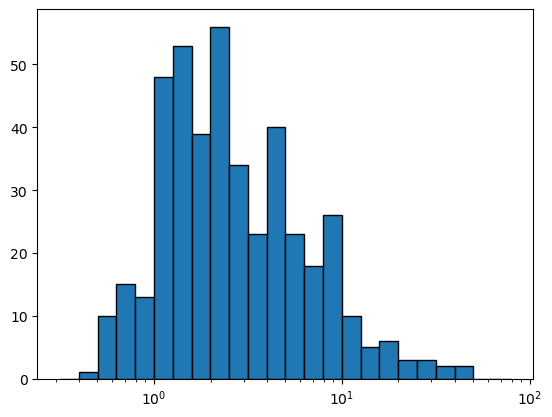

In [12]:
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [13]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 56% of the initial prices are more than double the latest price in the dataset

0.5627906976744186

In [14]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        # whether product matches the product from the previous line
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        # whether foil matches the foil from the previous line
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [15]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [16]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05,0.06,0.06


In [17]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.05


In [18]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11
5502,Zigzagoon,Reverse Holofoil,9/22 to 9/24,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.05,0.06,0.07,0.08,0.09,0.10


# Data Split

In [19]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '9/16 to 9/18',
       '9/19 to 9/21', '9/22 to 9/24', '9/25 to 9/27'], dtype=object)

In [20]:
# test set will contain everything from September 25th on
test = of_past_future_prices.loc[of_cleaned['Date Range'].isin(['9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
train = of_past_future_prices.loc[of_cleaned['Date Range'].isin([ '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13', 
       '8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 135/197,Holofoil,9/16 to 9/18,0.96,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,1.16,1.03,1.04,1.00,0.94
12,Absol ex - 135/197,Holofoil,9/19 to 9/21,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.96,1.16,1.03,1.04,1.00
13,Absol ex - 135/197,Holofoil,9/22 to 9/24,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,0.96,0.96,1.16,1.03,1.04
14,Absol ex - 135/197,Holofoil,9/25 to 9/27,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,1.03,1.08,0.96,0.96,1.16,1.03
15,Absol ex - 214/197,Holofoil,8/20 to 8/22,1.82,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.81,1.92,1.65,3.37,6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11


In [21]:
train

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
5,Absol ex - 135/197,Holofoil,8/29 to 8/31,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,1.16,0.93,0.92,0.81,0.81,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5493,Zigzagoon,Reverse Holofoil,8/26 to 8/28,0.07,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.07,0.07,0.07,0.08,0.07
5494,Zigzagoon,Reverse Holofoil,8/29 to 8/31,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.07,0.07,0.07,0.07,0.08
5495,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
5496,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07


In [22]:
of_cleaned.iloc[5884]

Product             Lillipup
Foil                  Normal
Date Range      8/23 to 8/25
Market Price            0.06
Name: 5884, dtype: object

In [23]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [24]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [25]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [26]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,0.167060
1,Previous Market Price_2,-0.074821
2,Previous Market Price_3,0.029078
3,Previous Market Price_4,-0.034503
4,Previous Market Price_5,-0.122030
5,Market Price,1.002076
6,Foil_Holofoil,-0.190213
7,Foil_Normal,0.061893
8,Foil_Reverse Holofoil,0.128320


In [27]:
y_pred = classifier.predict(X_test)

In [28]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [29]:
regression_results(y_test, y_pred)
# over 98% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9978
r2:  0.9978
MAE:  0.3416
MSE:  3.3686
RMSE:  1.8354


# LSTM

In [30]:
X_train = train[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_train = row_list
X_test = test[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_test = row_list
# y_train = train[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_train = row_list
# y_test = test[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_test = row_list

In [31]:
X_train['Market Price']

1       0.81
2       0.81
3       0.92
4       0.93
5       1.01
        ... 
5493    0.07
5494    0.08
5495    0.10
5496    0.11
5497    0.10
Name: Market Price, Length: 1720, dtype: float64

In [101]:
# need a many to many lstm
# https://github.com/keras-team/keras/issues/6063

model = Sequential()  
model.add(LSTM(1, input_dim=1, return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='linear'))
model.add(Dense(1, activation='linear'))
# model.add(Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 1)                 12        
                                                                 
 dense_30 (Dense)            (None, 1)                 2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [102]:
history = model.fit(X_train, y_train,epochs=20000, validation_data=(X_test, y_test))

Epoch 1/20000
54/54 [==============================] - 2s 10ms/step - loss: 1799.5159 - mean_squared_error: 1799.5159 - val_loss: 1560.9452 - val_mean_squared_error: 1560.9452
Epoch 2/20000
54/54 [==============================] - 0s 3ms/step - loss: 1799.2510 - mean_squared_error: 1799.2510 - val_loss: 1560.6930 - val_mean_squared_error: 1560.6930
Epoch 3/20000
54/54 [==============================] - 0s 3ms/step - loss: 1798.9609 - mean_squared_error: 1798.9609 - val_loss: 1560.3943 - val_mean_squared_error: 1560.3943
Epoch 4/20000
54/54 [==============================] - 0s 3ms/step - loss: 1798.6982 - mean_squared_error: 1798.6982 - val_loss: 1560.1383 - val_mean_squared_error: 1560.1383
Epoch 5/20000
54/54 [==============================] - 0s 4ms/step - loss: 1798.4603 - mean_squared_error: 1798.4603 - val_loss: 1559.8950 - val_mean_squared_error: 1559.8950
Epoch 6/20000
54/54 [==============================] - 0s 3ms/step - loss: 1798.2074 - mean_squared_error: 1798.2074 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1772.2654 - mean_squared_error: 1772.2654 - val_loss: 1532.8065 - val_mean_squared_error: 1532.8065
Epoch 48/20000
54/54 [==============================] - 0s 3ms/step - loss: 1771.8286 - mean_squared_error: 1771.8286 - val_loss: 1532.4156 - val_mean_squared_error: 1532.4156
Epoch 49/20000
54/54 [==============================] - 0s 3ms/step - loss: 1771.4552 - mean_squared_error: 1771.4552 - val_loss: 1531.9764 - val_mean_squared_error: 1531.9764
Epoch 50/20000
54/54 [==============================] - 0s 3ms/step - loss: 1771.0272 - mean_squared_error: 1771.0272 - val_loss: 1531.5486 - val_mean_squared_error: 1531.5486
Epoch 51/20000
54/54 [==============================] - 0s 3ms/step - loss: 1770.5516 - mean_squared_error: 1770.5516 - val_loss: 1531.0553 - val_mean_squared_error: 1531.0553
Epoch 52/20000
54/54 [==============================] - 0s 3ms/step - loss: 1770.0649 - mean_squared_error: 1770.0649 - val_loss: 1530.

54/54 [==============================] - 0s 3ms/step - loss: 1752.8323 - mean_squared_error: 1752.8323 - val_loss: 1512.7712 - val_mean_squared_error: 1512.7712
Epoch 94/20000
54/54 [==============================] - 0s 3ms/step - loss: 1752.4182 - mean_squared_error: 1752.4182 - val_loss: 1512.3438 - val_mean_squared_error: 1512.3438
Epoch 95/20000
54/54 [==============================] - 0s 3ms/step - loss: 1752.0215 - mean_squared_error: 1752.0215 - val_loss: 1511.9309 - val_mean_squared_error: 1511.9309
Epoch 96/20000
54/54 [==============================] - 0s 3ms/step - loss: 1751.6271 - mean_squared_error: 1751.6271 - val_loss: 1511.5016 - val_mean_squared_error: 1511.5016
Epoch 97/20000
54/54 [==============================] - 0s 3ms/step - loss: 1751.2126 - mean_squared_error: 1751.2126 - val_loss: 1511.0914 - val_mean_squared_error: 1511.0914
Epoch 98/20000
54/54 [==============================] - 0s 3ms/step - loss: 1750.7803 - mean_squared_error: 1750.7803 - val_loss: 1510.

54/54 [==============================] - 0s 3ms/step - loss: 1734.5648 - mean_squared_error: 1734.5648 - val_loss: 1493.8833 - val_mean_squared_error: 1493.8833
Epoch 140/20000
54/54 [==============================] - 0s 3ms/step - loss: 1734.1743 - mean_squared_error: 1734.1743 - val_loss: 1493.4280 - val_mean_squared_error: 1493.4280
Epoch 141/20000
54/54 [==============================] - 0s 3ms/step - loss: 1733.7411 - mean_squared_error: 1733.7411 - val_loss: 1492.9957 - val_mean_squared_error: 1492.9957
Epoch 142/20000
54/54 [==============================] - 0s 3ms/step - loss: 1733.3368 - mean_squared_error: 1733.3368 - val_loss: 1492.6047 - val_mean_squared_error: 1492.6047
Epoch 143/20000
54/54 [==============================] - 0s 3ms/step - loss: 1732.9697 - mean_squared_error: 1732.9697 - val_loss: 1492.2338 - val_mean_squared_error: 1492.2338
Epoch 144/20000
54/54 [==============================] - 0s 3ms/step - loss: 1732.6058 - mean_squared_error: 1732.6058 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1716.9305 - mean_squared_error: 1716.9305 - val_loss: 1475.5945 - val_mean_squared_error: 1475.5945
Epoch 186/20000
54/54 [==============================] - 0s 3ms/step - loss: 1716.5211 - mean_squared_error: 1716.5211 - val_loss: 1475.1986 - val_mean_squared_error: 1475.1986
Epoch 187/20000
54/54 [==============================] - 0s 3ms/step - loss: 1716.1898 - mean_squared_error: 1716.1898 - val_loss: 1474.8488 - val_mean_squared_error: 1474.8488
Epoch 188/20000
54/54 [==============================] - 0s 3ms/step - loss: 1715.7981 - mean_squared_error: 1715.7981 - val_loss: 1474.4364 - val_mean_squared_error: 1474.4364
Epoch 189/20000
54/54 [==============================] - 0s 3ms/step - loss: 1715.4088 - mean_squared_error: 1715.4088 - val_loss: 1474.0336 - val_mean_squared_error: 1474.0336
Epoch 190/20000
54/54 [==============================] - 0s 3ms/step - loss: 1715.0635 - mean_squared_error: 1715.0635 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1700.2201 - mean_squared_error: 1700.2201 - val_loss: 1458.2849 - val_mean_squared_error: 1458.2849
Epoch 232/20000
54/54 [==============================] - 0s 3ms/step - loss: 1699.8412 - mean_squared_error: 1699.8412 - val_loss: 1457.9327 - val_mean_squared_error: 1457.9327
Epoch 233/20000
54/54 [==============================] - 0s 3ms/step - loss: 1699.4814 - mean_squared_error: 1699.4814 - val_loss: 1457.5339 - val_mean_squared_error: 1457.5339
Epoch 234/20000
54/54 [==============================] - 0s 3ms/step - loss: 1699.0818 - mean_squared_error: 1699.0818 - val_loss: 1457.1782 - val_mean_squared_error: 1457.1782
Epoch 235/20000
54/54 [==============================] - 0s 3ms/step - loss: 1698.7844 - mean_squared_error: 1698.7844 - val_loss: 1456.8262 - val_mean_squared_error: 1456.8262
Epoch 236/20000
54/54 [==============================] - 0s 3ms/step - loss: 1698.4319 - mean_squared_error: 1698.4319 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1683.7402 - mean_squared_error: 1683.7402 - val_loss: 1441.2854 - val_mean_squared_error: 1441.2854
Epoch 278/20000
54/54 [==============================] - 0s 3ms/step - loss: 1683.3881 - mean_squared_error: 1683.3881 - val_loss: 1440.9290 - val_mean_squared_error: 1440.9290
Epoch 279/20000
54/54 [==============================] - 0s 3ms/step - loss: 1683.0562 - mean_squared_error: 1683.0562 - val_loss: 1440.5916 - val_mean_squared_error: 1440.5916
Epoch 280/20000
54/54 [==============================] - 0s 3ms/step - loss: 1682.7631 - mean_squared_error: 1682.7631 - val_loss: 1440.2838 - val_mean_squared_error: 1440.2838
Epoch 281/20000
54/54 [==============================] - 0s 3ms/step - loss: 1682.4164 - mean_squared_error: 1682.4164 - val_loss: 1439.9336 - val_mean_squared_error: 1439.9336
Epoch 282/20000
54/54 [==============================] - 0s 3ms/step - loss: 1682.0869 - mean_squared_error: 1682.0869 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1668.0577 - mean_squared_error: 1668.0577 - val_loss: 1425.0780 - val_mean_squared_error: 1425.0780
Epoch 324/20000
54/54 [==============================] - 0s 3ms/step - loss: 1667.7120 - mean_squared_error: 1667.7120 - val_loss: 1424.7117 - val_mean_squared_error: 1424.7117
Epoch 325/20000
54/54 [==============================] - 0s 3ms/step - loss: 1667.3729 - mean_squared_error: 1667.3729 - val_loss: 1424.3633 - val_mean_squared_error: 1424.3633
Epoch 326/20000
54/54 [==============================] - 0s 3ms/step - loss: 1667.0175 - mean_squared_error: 1667.0175 - val_loss: 1423.9995 - val_mean_squared_error: 1423.9995
Epoch 327/20000
54/54 [==============================] - 0s 3ms/step - loss: 1666.7003 - mean_squared_error: 1666.7003 - val_loss: 1423.6807 - val_mean_squared_error: 1423.6807
Epoch 328/20000
54/54 [==============================] - 0s 3ms/step - loss: 1666.3298 - mean_squared_error: 1666.3298 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1652.8230 - mean_squared_error: 1652.8230 - val_loss: 1409.3634 - val_mean_squared_error: 1409.3634
Epoch 370/20000
54/54 [==============================] - 0s 3ms/step - loss: 1652.4954 - mean_squared_error: 1652.4954 - val_loss: 1409.0187 - val_mean_squared_error: 1409.0187
Epoch 371/20000
54/54 [==============================] - 0s 3ms/step - loss: 1652.2021 - mean_squared_error: 1652.2021 - val_loss: 1408.6949 - val_mean_squared_error: 1408.6949
Epoch 372/20000
54/54 [==============================] - 0s 3ms/step - loss: 1651.8644 - mean_squared_error: 1651.8644 - val_loss: 1408.3696 - val_mean_squared_error: 1408.3696
Epoch 373/20000
54/54 [==============================] - 0s 3ms/step - loss: 1651.5582 - mean_squared_error: 1651.5582 - val_loss: 1408.0013 - val_mean_squared_error: 1408.0013
Epoch 374/20000
54/54 [==============================] - 0s 3ms/step - loss: 1651.1802 - mean_squared_error: 1651.1802 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1638.2015 - mean_squared_error: 1638.2015 - val_loss: 1394.1935 - val_mean_squared_error: 1394.1935
Epoch 416/20000
54/54 [==============================] - 0s 4ms/step - loss: 1637.8505 - mean_squared_error: 1637.8505 - val_loss: 1393.8352 - val_mean_squared_error: 1393.8352
Epoch 417/20000
54/54 [==============================] - 0s 4ms/step - loss: 1637.5449 - mean_squared_error: 1637.5449 - val_loss: 1393.5511 - val_mean_squared_error: 1393.5511
Epoch 418/20000
54/54 [==============================] - 0s 4ms/step - loss: 1637.2338 - mean_squared_error: 1637.2338 - val_loss: 1393.1902 - val_mean_squared_error: 1393.1902
Epoch 419/20000
54/54 [==============================] - 0s 4ms/step - loss: 1636.8779 - mean_squared_error: 1636.8779 - val_loss: 1392.8329 - val_mean_squared_error: 1392.8329
Epoch 420/20000
54/54 [==============================] - 0s 3ms/step - loss: 1636.5651 - mean_squared_error: 1636.5651 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1624.2114 - mean_squared_error: 1624.2114 - val_loss: 1379.7374 - val_mean_squared_error: 1379.7374
Epoch 462/20000
54/54 [==============================] - 0s 4ms/step - loss: 1623.9329 - mean_squared_error: 1623.9329 - val_loss: 1379.4080 - val_mean_squared_error: 1379.4080
Epoch 463/20000
54/54 [==============================] - 0s 3ms/step - loss: 1623.6191 - mean_squared_error: 1623.6191 - val_loss: 1379.0801 - val_mean_squared_error: 1379.0801
Epoch 464/20000
54/54 [==============================] - 0s 4ms/step - loss: 1623.2958 - mean_squared_error: 1623.2958 - val_loss: 1378.7556 - val_mean_squared_error: 1378.7556
Epoch 465/20000
54/54 [==============================] - 0s 4ms/step - loss: 1622.9454 - mean_squared_error: 1622.9454 - val_loss: 1378.3905 - val_mean_squared_error: 1378.3905
Epoch 466/20000
54/54 [==============================] - 0s 4ms/step - loss: 1622.6066 - mean_squared_error: 1622.6066 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1610.0397 - mean_squared_error: 1610.0397 - val_loss: 1365.0012 - val_mean_squared_error: 1365.0012
Epoch 508/20000
54/54 [==============================] - 0s 4ms/step - loss: 1609.7047 - mean_squared_error: 1609.7047 - val_loss: 1364.6427 - val_mean_squared_error: 1364.6427
Epoch 509/20000
54/54 [==============================] - 0s 3ms/step - loss: 1609.4254 - mean_squared_error: 1609.4254 - val_loss: 1364.3691 - val_mean_squared_error: 1364.3691
Epoch 510/20000
54/54 [==============================] - 0s 3ms/step - loss: 1609.1335 - mean_squared_error: 1609.1335 - val_loss: 1364.0769 - val_mean_squared_error: 1364.0769
Epoch 511/20000
54/54 [==============================] - 0s 3ms/step - loss: 1608.8392 - mean_squared_error: 1608.8392 - val_loss: 1363.7404 - val_mean_squared_error: 1363.7404
Epoch 512/20000
54/54 [==============================] - 0s 3ms/step - loss: 1608.6057 - mean_squared_error: 1608.6057 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1596.5770 - mean_squared_error: 1596.5770 - val_loss: 1351.0985 - val_mean_squared_error: 1351.0985
Epoch 554/20000
54/54 [==============================] - 0s 4ms/step - loss: 1596.3568 - mean_squared_error: 1596.3568 - val_loss: 1350.8662 - val_mean_squared_error: 1350.8662
Epoch 555/20000
54/54 [==============================] - 0s 4ms/step - loss: 1596.0840 - mean_squared_error: 1596.0840 - val_loss: 1350.5460 - val_mean_squared_error: 1350.5460
Epoch 556/20000
54/54 [==============================] - 0s 3ms/step - loss: 1595.8263 - mean_squared_error: 1595.8263 - val_loss: 1350.2881 - val_mean_squared_error: 1350.2881
Epoch 557/20000
54/54 [==============================] - 0s 3ms/step - loss: 1595.5269 - mean_squared_error: 1595.5269 - val_loss: 1349.9872 - val_mean_squared_error: 1349.9872
Epoch 558/20000
54/54 [==============================] - 0s 3ms/step - loss: 1595.2683 - mean_squared_error: 1595.2683 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1583.3536 - mean_squared_error: 1583.3536 - val_loss: 1337.3928 - val_mean_squared_error: 1337.3928
Epoch 600/20000
54/54 [==============================] - 0s 3ms/step - loss: 1583.0958 - mean_squared_error: 1583.0958 - val_loss: 1337.1471 - val_mean_squared_error: 1337.1471
Epoch 601/20000
54/54 [==============================] - 0s 3ms/step - loss: 1582.8191 - mean_squared_error: 1582.8191 - val_loss: 1336.8193 - val_mean_squared_error: 1336.8193
Epoch 602/20000
54/54 [==============================] - 0s 3ms/step - loss: 1582.5421 - mean_squared_error: 1582.5421 - val_loss: 1336.5179 - val_mean_squared_error: 1336.5179
Epoch 603/20000
54/54 [==============================] - 0s 3ms/step - loss: 1582.2483 - mean_squared_error: 1582.2483 - val_loss: 1336.2754 - val_mean_squared_error: 1336.2754
Epoch 604/20000
54/54 [==============================] - 0s 3ms/step - loss: 1581.9944 - mean_squared_error: 1581.9944 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1570.1876 - mean_squared_error: 1570.1876 - val_loss: 1323.8108 - val_mean_squared_error: 1323.8108
Epoch 646/20000
54/54 [==============================] - 0s 4ms/step - loss: 1569.9351 - mean_squared_error: 1569.9351 - val_loss: 1323.5576 - val_mean_squared_error: 1323.5576
Epoch 647/20000
54/54 [==============================] - 0s 4ms/step - loss: 1569.6268 - mean_squared_error: 1569.6268 - val_loss: 1323.2179 - val_mean_squared_error: 1323.2179
Epoch 648/20000
54/54 [==============================] - 0s 4ms/step - loss: 1569.3164 - mean_squared_error: 1569.3164 - val_loss: 1322.9062 - val_mean_squared_error: 1322.9062
Epoch 649/20000
54/54 [==============================] - 0s 4ms/step - loss: 1569.0374 - mean_squared_error: 1569.0374 - val_loss: 1322.6229 - val_mean_squared_error: 1322.6229
Epoch 650/20000
54/54 [==============================] - 0s 4ms/step - loss: 1568.7596 - mean_squared_error: 1568.7596 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1557.3345 - mean_squared_error: 1557.3345 - val_loss: 1310.6316 - val_mean_squared_error: 1310.6316
Epoch 692/20000
54/54 [==============================] - 0s 4ms/step - loss: 1557.0374 - mean_squared_error: 1557.0374 - val_loss: 1310.2874 - val_mean_squared_error: 1310.2874
Epoch 693/20000
54/54 [==============================] - 0s 4ms/step - loss: 1556.7465 - mean_squared_error: 1556.7465 - val_loss: 1309.9930 - val_mean_squared_error: 1309.9930
Epoch 694/20000
54/54 [==============================] - 0s 4ms/step - loss: 1556.4279 - mean_squared_error: 1556.4279 - val_loss: 1309.7380 - val_mean_squared_error: 1309.7380
Epoch 695/20000
54/54 [==============================] - 0s 4ms/step - loss: 1556.2271 - mean_squared_error: 1556.2271 - val_loss: 1309.4762 - val_mean_squared_error: 1309.4762
Epoch 696/20000
54/54 [==============================] - 0s 4ms/step - loss: 1555.9487 - mean_squared_error: 1555.9487 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1544.6936 - mean_squared_error: 1544.6936 - val_loss: 1297.6309 - val_mean_squared_error: 1297.6309
Epoch 738/20000
54/54 [==============================] - 0s 4ms/step - loss: 1544.4023 - mean_squared_error: 1544.4023 - val_loss: 1297.3380 - val_mean_squared_error: 1297.3380
Epoch 739/20000
54/54 [==============================] - 0s 4ms/step - loss: 1544.1531 - mean_squared_error: 1544.1531 - val_loss: 1297.0592 - val_mean_squared_error: 1297.0592
Epoch 740/20000
54/54 [==============================] - 0s 4ms/step - loss: 1543.8629 - mean_squared_error: 1543.8629 - val_loss: 1296.8446 - val_mean_squared_error: 1296.8446
Epoch 741/20000
54/54 [==============================] - 0s 4ms/step - loss: 1543.6085 - mean_squared_error: 1543.6085 - val_loss: 1296.5070 - val_mean_squared_error: 1296.5070
Epoch 742/20000
54/54 [==============================] - 0s 4ms/step - loss: 1543.3181 - mean_squared_error: 1543.3181 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1532.3573 - mean_squared_error: 1532.3573 - val_loss: 1284.9739 - val_mean_squared_error: 1284.9739
Epoch 784/20000
54/54 [==============================] - 0s 3ms/step - loss: 1532.1304 - mean_squared_error: 1532.1304 - val_loss: 1284.7467 - val_mean_squared_error: 1284.7467
Epoch 785/20000
54/54 [==============================] - 0s 3ms/step - loss: 1531.8262 - mean_squared_error: 1531.8262 - val_loss: 1284.4032 - val_mean_squared_error: 1284.4032
Epoch 786/20000
54/54 [==============================] - 0s 3ms/step - loss: 1531.5643 - mean_squared_error: 1531.5643 - val_loss: 1284.1406 - val_mean_squared_error: 1284.1406
Epoch 787/20000
54/54 [==============================] - 0s 3ms/step - loss: 1531.2822 - mean_squared_error: 1531.2822 - val_loss: 1283.8430 - val_mean_squared_error: 1283.8430
Epoch 788/20000
54/54 [==============================] - 0s 3ms/step - loss: 1531.0490 - mean_squared_error: 1531.0490 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1520.4039 - mean_squared_error: 1520.4039 - val_loss: 1272.6715 - val_mean_squared_error: 1272.6715
Epoch 830/20000
54/54 [==============================] - 0s 3ms/step - loss: 1520.1343 - mean_squared_error: 1520.1343 - val_loss: 1272.4021 - val_mean_squared_error: 1272.4021
Epoch 831/20000
54/54 [==============================] - 0s 3ms/step - loss: 1519.8431 - mean_squared_error: 1519.8431 - val_loss: 1272.1213 - val_mean_squared_error: 1272.1213
Epoch 832/20000
54/54 [==============================] - 0s 3ms/step - loss: 1519.5618 - mean_squared_error: 1519.5618 - val_loss: 1271.8538 - val_mean_squared_error: 1271.8538
Epoch 833/20000
54/54 [==============================] - 0s 3ms/step - loss: 1519.3229 - mean_squared_error: 1519.3229 - val_loss: 1271.6650 - val_mean_squared_error: 1271.6650
Epoch 834/20000
54/54 [==============================] - 0s 3ms/step - loss: 1519.0699 - mean_squared_error: 1519.0699 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1508.2668 - mean_squared_error: 1508.2668 - val_loss: 1260.2643 - val_mean_squared_error: 1260.2643
Epoch 876/20000
54/54 [==============================] - 0s 3ms/step - loss: 1507.9956 - mean_squared_error: 1507.9956 - val_loss: 1260.0560 - val_mean_squared_error: 1260.0560
Epoch 877/20000
54/54 [==============================] - 0s 3ms/step - loss: 1507.7742 - mean_squared_error: 1507.7742 - val_loss: 1259.7623 - val_mean_squared_error: 1259.7623
Epoch 878/20000
54/54 [==============================] - 0s 3ms/step - loss: 1507.4927 - mean_squared_error: 1507.4927 - val_loss: 1259.4974 - val_mean_squared_error: 1259.4974
Epoch 879/20000
54/54 [==============================] - 0s 3ms/step - loss: 1507.2456 - mean_squared_error: 1507.2456 - val_loss: 1259.2700 - val_mean_squared_error: 1259.2700
Epoch 880/20000
54/54 [==============================] - 0s 3ms/step - loss: 1506.9839 - mean_squared_error: 1506.9839 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1496.4536 - mean_squared_error: 1496.4536 - val_loss: 1248.3004 - val_mean_squared_error: 1248.3004
Epoch 922/20000
54/54 [==============================] - 0s 3ms/step - loss: 1496.1682 - mean_squared_error: 1496.1682 - val_loss: 1247.9698 - val_mean_squared_error: 1247.9698
Epoch 923/20000
54/54 [==============================] - 0s 3ms/step - loss: 1495.9045 - mean_squared_error: 1495.9045 - val_loss: 1247.7966 - val_mean_squared_error: 1247.7966
Epoch 924/20000
54/54 [==============================] - 0s 3ms/step - loss: 1495.6744 - mean_squared_error: 1495.6744 - val_loss: 1247.4896 - val_mean_squared_error: 1247.4896
Epoch 925/20000
54/54 [==============================] - 0s 3ms/step - loss: 1495.4139 - mean_squared_error: 1495.4139 - val_loss: 1247.2272 - val_mean_squared_error: 1247.2272
Epoch 926/20000
54/54 [==============================] - 0s 3ms/step - loss: 1495.1415 - mean_squared_error: 1495.1415 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1484.9875 - mean_squared_error: 1484.9875 - val_loss: 1236.8401 - val_mean_squared_error: 1236.8401
Epoch 968/20000
54/54 [==============================] - 0s 4ms/step - loss: 1484.7982 - mean_squared_error: 1484.7982 - val_loss: 1236.4340 - val_mean_squared_error: 1236.4340
Epoch 969/20000
54/54 [==============================] - 0s 4ms/step - loss: 1484.5356 - mean_squared_error: 1484.5356 - val_loss: 1236.1975 - val_mean_squared_error: 1236.1975
Epoch 970/20000
54/54 [==============================] - 0s 4ms/step - loss: 1484.2601 - mean_squared_error: 1484.2601 - val_loss: 1235.9680 - val_mean_squared_error: 1235.9680
Epoch 971/20000
54/54 [==============================] - 0s 4ms/step - loss: 1483.9884 - mean_squared_error: 1483.9884 - val_loss: 1235.6545 - val_mean_squared_error: 1235.6545
Epoch 972/20000
54/54 [==============================] - 0s 4ms/step - loss: 1483.7722 - mean_squared_error: 1483.7722 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1473.5430 - mean_squared_error: 1473.5430 - val_loss: 1225.0980 - val_mean_squared_error: 1225.0980
Epoch 1014/20000
54/54 [==============================] - 0s 3ms/step - loss: 1473.2733 - mean_squared_error: 1473.2733 - val_loss: 1224.8484 - val_mean_squared_error: 1224.8484
Epoch 1015/20000
54/54 [==============================] - 0s 3ms/step - loss: 1472.9730 - mean_squared_error: 1472.9730 - val_loss: 1224.6752 - val_mean_squared_error: 1224.6752
Epoch 1016/20000
54/54 [==============================] - 0s 3ms/step - loss: 1472.7933 - mean_squared_error: 1472.7933 - val_loss: 1224.3152 - val_mean_squared_error: 1224.3152
Epoch 1017/20000
54/54 [==============================] - 0s 3ms/step - loss: 1472.6078 - mean_squared_error: 1472.6078 - val_loss: 1224.1172 - val_mean_squared_error: 1224.1172
Epoch 1018/20000
54/54 [==============================] - 0s 3ms/step - loss: 1472.3818 - mean_squared_error: 1472.3818 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1462.3170 - mean_squared_error: 1462.3170 - val_loss: 1213.9181 - val_mean_squared_error: 1213.9181
Epoch 1060/20000
54/54 [==============================] - 0s 3ms/step - loss: 1462.0834 - mean_squared_error: 1462.0834 - val_loss: 1213.4460 - val_mean_squared_error: 1213.4460
Epoch 1061/20000
54/54 [==============================] - 0s 4ms/step - loss: 1461.8514 - mean_squared_error: 1461.8514 - val_loss: 1213.2318 - val_mean_squared_error: 1213.2318
Epoch 1062/20000
54/54 [==============================] - 0s 4ms/step - loss: 1461.5945 - mean_squared_error: 1461.5945 - val_loss: 1213.0135 - val_mean_squared_error: 1213.0135
Epoch 1063/20000
54/54 [==============================] - 0s 4ms/step - loss: 1461.3558 - mean_squared_error: 1461.3558 - val_loss: 1212.7687 - val_mean_squared_error: 1212.7687
Epoch 1064/20000
54/54 [==============================] - 0s 4ms/step - loss: 1461.1218 - mean_squared_error: 1461.1218 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1451.4335 - mean_squared_error: 1451.4335 - val_loss: 1202.7728 - val_mean_squared_error: 1202.7728
Epoch 1106/20000
54/54 [==============================] - 0s 4ms/step - loss: 1451.1698 - mean_squared_error: 1451.1698 - val_loss: 1202.5763 - val_mean_squared_error: 1202.5763
Epoch 1107/20000
54/54 [==============================] - 0s 4ms/step - loss: 1450.9171 - mean_squared_error: 1450.9171 - val_loss: 1202.4276 - val_mean_squared_error: 1202.4276
Epoch 1108/20000
54/54 [==============================] - 0s 4ms/step - loss: 1450.6893 - mean_squared_error: 1450.6893 - val_loss: 1202.2104 - val_mean_squared_error: 1202.2104
Epoch 1109/20000
54/54 [==============================] - 0s 3ms/step - loss: 1450.4590 - mean_squared_error: 1450.4590 - val_loss: 1201.7825 - val_mean_squared_error: 1201.7825
Epoch 1110/20000
54/54 [==============================] - 0s 4ms/step - loss: 1450.2189 - mean_squared_error: 1450.2189 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1440.3604 - mean_squared_error: 1440.3604 - val_loss: 1191.8395 - val_mean_squared_error: 1191.8395
Epoch 1152/20000
54/54 [==============================] - 0s 3ms/step - loss: 1440.1332 - mean_squared_error: 1440.1332 - val_loss: 1191.4452 - val_mean_squared_error: 1191.4452
Epoch 1153/20000
54/54 [==============================] - 0s 3ms/step - loss: 1439.8893 - mean_squared_error: 1439.8893 - val_loss: 1191.2672 - val_mean_squared_error: 1191.2672
Epoch 1154/20000
54/54 [==============================] - 0s 3ms/step - loss: 1439.7113 - mean_squared_error: 1439.7113 - val_loss: 1191.1425 - val_mean_squared_error: 1191.1425
Epoch 1155/20000
54/54 [==============================] - 0s 3ms/step - loss: 1439.4736 - mean_squared_error: 1439.4736 - val_loss: 1190.6718 - val_mean_squared_error: 1190.6718
Epoch 1156/20000
54/54 [==============================] - 0s 3ms/step - loss: 1439.2114 - mean_squared_error: 1439.2114 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1429.6044 - mean_squared_error: 1429.6044 - val_loss: 1181.0352 - val_mean_squared_error: 1181.0352
Epoch 1198/20000
54/54 [==============================] - 0s 4ms/step - loss: 1429.3724 - mean_squared_error: 1429.3724 - val_loss: 1180.6808 - val_mean_squared_error: 1180.6808
Epoch 1199/20000
54/54 [==============================] - 0s 3ms/step - loss: 1429.1953 - mean_squared_error: 1429.1953 - val_loss: 1180.3961 - val_mean_squared_error: 1180.3961
Epoch 1200/20000
54/54 [==============================] - 0s 3ms/step - loss: 1428.9315 - mean_squared_error: 1428.9315 - val_loss: 1180.4028 - val_mean_squared_error: 1180.4028
Epoch 1201/20000
54/54 [==============================] - 0s 3ms/step - loss: 1428.7305 - mean_squared_error: 1428.7305 - val_loss: 1179.9751 - val_mean_squared_error: 1179.9751
Epoch 1202/20000
54/54 [==============================] - 0s 4ms/step - loss: 1428.4794 - mean_squared_error: 1428.4794 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1419.0017 - mean_squared_error: 1419.0017 - val_loss: 1170.1816 - val_mean_squared_error: 1170.1816
Epoch 1244/20000
54/54 [==============================] - 0s 3ms/step - loss: 1418.7645 - mean_squared_error: 1418.7645 - val_loss: 1170.0443 - val_mean_squared_error: 1170.0443
Epoch 1245/20000
54/54 [==============================] - 0s 4ms/step - loss: 1418.5485 - mean_squared_error: 1418.5485 - val_loss: 1169.6027 - val_mean_squared_error: 1169.6027
Epoch 1246/20000
54/54 [==============================] - 0s 3ms/step - loss: 1418.3250 - mean_squared_error: 1418.3250 - val_loss: 1169.5793 - val_mean_squared_error: 1169.5793
Epoch 1247/20000
54/54 [==============================] - 0s 3ms/step - loss: 1418.1023 - mean_squared_error: 1418.1023 - val_loss: 1169.1481 - val_mean_squared_error: 1169.1481
Epoch 1248/20000
54/54 [==============================] - 0s 3ms/step - loss: 1417.8551 - mean_squared_error: 1417.8551 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1408.6398 - mean_squared_error: 1408.6398 - val_loss: 1159.7333 - val_mean_squared_error: 1159.7333
Epoch 1290/20000
54/54 [==============================] - 0s 4ms/step - loss: 1408.3901 - mean_squared_error: 1408.3901 - val_loss: 1159.4790 - val_mean_squared_error: 1159.4790
Epoch 1291/20000
54/54 [==============================] - 0s 3ms/step - loss: 1408.1587 - mean_squared_error: 1408.1587 - val_loss: 1159.2371 - val_mean_squared_error: 1159.2371
Epoch 1292/20000
54/54 [==============================] - 0s 3ms/step - loss: 1407.9452 - mean_squared_error: 1407.9452 - val_loss: 1159.2471 - val_mean_squared_error: 1159.2471
Epoch 1293/20000
54/54 [==============================] - 0s 4ms/step - loss: 1407.6951 - mean_squared_error: 1407.6951 - val_loss: 1158.9343 - val_mean_squared_error: 1158.9343
Epoch 1294/20000
54/54 [==============================] - 0s 3ms/step - loss: 1407.5016 - mean_squared_error: 1407.5016 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1398.3433 - mean_squared_error: 1398.3433 - val_loss: 1149.4799 - val_mean_squared_error: 1149.4799
Epoch 1336/20000
54/54 [==============================] - 0s 3ms/step - loss: 1398.1263 - mean_squared_error: 1398.1263 - val_loss: 1149.1725 - val_mean_squared_error: 1149.1725
Epoch 1337/20000
54/54 [==============================] - 0s 4ms/step - loss: 1397.8673 - mean_squared_error: 1397.8673 - val_loss: 1149.0695 - val_mean_squared_error: 1149.0695
Epoch 1338/20000
54/54 [==============================] - 0s 4ms/step - loss: 1397.6760 - mean_squared_error: 1397.6760 - val_loss: 1148.7352 - val_mean_squared_error: 1148.7352
Epoch 1339/20000
54/54 [==============================] - 0s 3ms/step - loss: 1397.4656 - mean_squared_error: 1397.4656 - val_loss: 1148.7290 - val_mean_squared_error: 1148.7290
Epoch 1340/20000
54/54 [==============================] - 0s 3ms/step - loss: 1397.2465 - mean_squared_error: 1397.2465 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1388.2383 - mean_squared_error: 1388.2383 - val_loss: 1139.3979 - val_mean_squared_error: 1139.3979
Epoch 1382/20000
54/54 [==============================] - 0s 4ms/step - loss: 1388.0243 - mean_squared_error: 1388.0243 - val_loss: 1139.0859 - val_mean_squared_error: 1139.0859
Epoch 1383/20000
54/54 [==============================] - 0s 5ms/step - loss: 1387.7975 - mean_squared_error: 1387.7975 - val_loss: 1138.9650 - val_mean_squared_error: 1138.9650
Epoch 1384/20000
54/54 [==============================] - 0s 4ms/step - loss: 1387.5649 - mean_squared_error: 1387.5649 - val_loss: 1138.6753 - val_mean_squared_error: 1138.6753
Epoch 1385/20000
54/54 [==============================] - 0s 4ms/step - loss: 1387.3734 - mean_squared_error: 1387.3734 - val_loss: 1138.4027 - val_mean_squared_error: 1138.4027
Epoch 1386/20000
54/54 [==============================] - 0s 4ms/step - loss: 1387.1553 - mean_squared_error: 1387.1553 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1378.2805 - mean_squared_error: 1378.2805 - val_loss: 1129.2291 - val_mean_squared_error: 1129.2291
Epoch 1428/20000
54/54 [==============================] - 0s 3ms/step - loss: 1378.0378 - mean_squared_error: 1378.0378 - val_loss: 1129.0067 - val_mean_squared_error: 1129.0067
Epoch 1429/20000
54/54 [==============================] - 0s 3ms/step - loss: 1377.8063 - mean_squared_error: 1377.8063 - val_loss: 1128.6429 - val_mean_squared_error: 1128.6429
Epoch 1430/20000
54/54 [==============================] - 0s 3ms/step - loss: 1377.5662 - mean_squared_error: 1377.5662 - val_loss: 1128.5571 - val_mean_squared_error: 1128.5571
Epoch 1431/20000
54/54 [==============================] - 0s 3ms/step - loss: 1377.3635 - mean_squared_error: 1377.3635 - val_loss: 1128.4093 - val_mean_squared_error: 1128.4093
Epoch 1432/20000
54/54 [==============================] - 0s 3ms/step - loss: 1377.1537 - mean_squared_error: 1377.1537 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1368.4008 - mean_squared_error: 1368.4008 - val_loss: 1118.5256 - val_mean_squared_error: 1118.5256
Epoch 1474/20000
54/54 [==============================] - 0s 3ms/step - loss: 1368.1868 - mean_squared_error: 1368.1868 - val_loss: 1118.2806 - val_mean_squared_error: 1118.2806
Epoch 1475/20000
54/54 [==============================] - 0s 4ms/step - loss: 1367.9805 - mean_squared_error: 1367.9805 - val_loss: 1117.9457 - val_mean_squared_error: 1117.9457
Epoch 1476/20000
54/54 [==============================] - 0s 4ms/step - loss: 1367.7791 - mean_squared_error: 1367.7791 - val_loss: 1117.7003 - val_mean_squared_error: 1117.7003
Epoch 1477/20000
54/54 [==============================] - 0s 4ms/step - loss: 1367.5917 - mean_squared_error: 1367.5917 - val_loss: 1117.5432 - val_mean_squared_error: 1117.5432
Epoch 1478/20000
54/54 [==============================] - 0s 4ms/step - loss: 1367.3724 - mean_squared_error: 1367.3724 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1358.6698 - mean_squared_error: 1358.6698 - val_loss: 1108.3062 - val_mean_squared_error: 1108.3062
Epoch 1520/20000
54/54 [==============================] - 0s 4ms/step - loss: 1358.4672 - mean_squared_error: 1358.4672 - val_loss: 1108.3167 - val_mean_squared_error: 1108.3167
Epoch 1521/20000
54/54 [==============================] - 0s 3ms/step - loss: 1358.2479 - mean_squared_error: 1358.2479 - val_loss: 1107.8949 - val_mean_squared_error: 1107.8949
Epoch 1522/20000
54/54 [==============================] - 0s 3ms/step - loss: 1358.0410 - mean_squared_error: 1358.0410 - val_loss: 1107.8828 - val_mean_squared_error: 1107.8828
Epoch 1523/20000
54/54 [==============================] - 0s 3ms/step - loss: 1357.8157 - mean_squared_error: 1357.8157 - val_loss: 1107.7202 - val_mean_squared_error: 1107.7202
Epoch 1524/20000
54/54 [==============================] - 0s 3ms/step - loss: 1357.6417 - mean_squared_error: 1357.6417 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1349.1962 - mean_squared_error: 1349.1962 - val_loss: 1098.9146 - val_mean_squared_error: 1098.9146
Epoch 1566/20000
54/54 [==============================] - 0s 3ms/step - loss: 1348.9917 - mean_squared_error: 1348.9917 - val_loss: 1098.4529 - val_mean_squared_error: 1098.4529
Epoch 1567/20000
54/54 [==============================] - 0s 4ms/step - loss: 1348.8002 - mean_squared_error: 1348.8002 - val_loss: 1098.2146 - val_mean_squared_error: 1098.2146
Epoch 1568/20000
54/54 [==============================] - 0s 3ms/step - loss: 1348.5665 - mean_squared_error: 1348.5665 - val_loss: 1098.0352 - val_mean_squared_error: 1098.0352
Epoch 1569/20000
54/54 [==============================] - 0s 3ms/step - loss: 1348.3619 - mean_squared_error: 1348.3619 - val_loss: 1097.8489 - val_mean_squared_error: 1097.8489
Epoch 1570/20000
54/54 [==============================] - 0s 3ms/step - loss: 1348.1875 - mean_squared_error: 1348.1875 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1339.8137 - mean_squared_error: 1339.8137 - val_loss: 1089.1665 - val_mean_squared_error: 1089.1665
Epoch 1612/20000
54/54 [==============================] - 0s 4ms/step - loss: 1339.6112 - mean_squared_error: 1339.6112 - val_loss: 1088.8533 - val_mean_squared_error: 1088.8533
Epoch 1613/20000
54/54 [==============================] - 0s 4ms/step - loss: 1339.3748 - mean_squared_error: 1339.3748 - val_loss: 1088.6660 - val_mean_squared_error: 1088.6660
Epoch 1614/20000
54/54 [==============================] - 0s 4ms/step - loss: 1339.1874 - mean_squared_error: 1339.1874 - val_loss: 1088.4219 - val_mean_squared_error: 1088.4219
Epoch 1615/20000
54/54 [==============================] - 0s 3ms/step - loss: 1338.9758 - mean_squared_error: 1338.9758 - val_loss: 1088.2183 - val_mean_squared_error: 1088.2183
Epoch 1616/20000
54/54 [==============================] - 0s 3ms/step - loss: 1338.7719 - mean_squared_error: 1338.7719 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1330.9502 - mean_squared_error: 1330.9502 - val_loss: 1080.1234 - val_mean_squared_error: 1080.1234
Epoch 1658/20000
54/54 [==============================] - 0s 3ms/step - loss: 1330.7996 - mean_squared_error: 1330.7996 - val_loss: 1080.2109 - val_mean_squared_error: 1080.2109
Epoch 1659/20000
54/54 [==============================] - 0s 3ms/step - loss: 1330.6173 - mean_squared_error: 1330.6173 - val_loss: 1079.7169 - val_mean_squared_error: 1079.7169
Epoch 1660/20000
54/54 [==============================] - 0s 3ms/step - loss: 1330.4337 - mean_squared_error: 1330.4337 - val_loss: 1079.7605 - val_mean_squared_error: 1079.7605
Epoch 1661/20000
54/54 [==============================] - 0s 3ms/step - loss: 1330.2712 - mean_squared_error: 1330.2712 - val_loss: 1079.4028 - val_mean_squared_error: 1079.4028
Epoch 1662/20000
54/54 [==============================] - 0s 3ms/step - loss: 1330.1072 - mean_squared_error: 1330.1072 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1321.9697 - mean_squared_error: 1321.9697 - val_loss: 1070.9474 - val_mean_squared_error: 1070.9474
Epoch 1704/20000
54/54 [==============================] - 0s 4ms/step - loss: 1321.7261 - mean_squared_error: 1321.7261 - val_loss: 1070.8408 - val_mean_squared_error: 1070.8408
Epoch 1705/20000
54/54 [==============================] - 0s 3ms/step - loss: 1321.5831 - mean_squared_error: 1321.5831 - val_loss: 1070.5508 - val_mean_squared_error: 1070.5508
Epoch 1706/20000
54/54 [==============================] - 0s 3ms/step - loss: 1321.3817 - mean_squared_error: 1321.3817 - val_loss: 1070.3347 - val_mean_squared_error: 1070.3347
Epoch 1707/20000
54/54 [==============================] - 0s 3ms/step - loss: 1321.1644 - mean_squared_error: 1321.1644 - val_loss: 1070.1445 - val_mean_squared_error: 1070.1445
Epoch 1708/20000
54/54 [==============================] - 0s 4ms/step - loss: 1321.0199 - mean_squared_error: 1321.0199 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1313.1497 - mean_squared_error: 1313.1497 - val_loss: 1061.8976 - val_mean_squared_error: 1061.8976
Epoch 1750/20000
54/54 [==============================] - 0s 3ms/step - loss: 1312.9786 - mean_squared_error: 1312.9786 - val_loss: 1061.8967 - val_mean_squared_error: 1061.8967
Epoch 1751/20000
54/54 [==============================] - 0s 3ms/step - loss: 1312.8168 - mean_squared_error: 1312.8168 - val_loss: 1061.6968 - val_mean_squared_error: 1061.6968
Epoch 1752/20000
54/54 [==============================] - 0s 3ms/step - loss: 1312.6238 - mean_squared_error: 1312.6238 - val_loss: 1061.5824 - val_mean_squared_error: 1061.5824
Epoch 1753/20000
54/54 [==============================] - 0s 3ms/step - loss: 1312.4285 - mean_squared_error: 1312.4285 - val_loss: 1061.2330 - val_mean_squared_error: 1061.2330
Epoch 1754/20000
54/54 [==============================] - 0s 3ms/step - loss: 1312.2505 - mean_squared_error: 1312.2505 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1304.4753 - mean_squared_error: 1304.4753 - val_loss: 1053.4349 - val_mean_squared_error: 1053.4349
Epoch 1796/20000
54/54 [==============================] - 0s 3ms/step - loss: 1304.3212 - mean_squared_error: 1304.3212 - val_loss: 1052.9572 - val_mean_squared_error: 1052.9572
Epoch 1797/20000
54/54 [==============================] - 0s 3ms/step - loss: 1304.0985 - mean_squared_error: 1304.0985 - val_loss: 1052.7374 - val_mean_squared_error: 1052.7374
Epoch 1798/20000
54/54 [==============================] - 0s 3ms/step - loss: 1303.8798 - mean_squared_error: 1303.8798 - val_loss: 1052.5004 - val_mean_squared_error: 1052.5004
Epoch 1799/20000
54/54 [==============================] - 0s 3ms/step - loss: 1303.7058 - mean_squared_error: 1303.7058 - val_loss: 1052.3914 - val_mean_squared_error: 1052.3914
Epoch 1800/20000
54/54 [==============================] - 0s 3ms/step - loss: 1303.5381 - mean_squared_error: 1303.5381 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1296.0966 - mean_squared_error: 1296.0966 - val_loss: 1044.7144 - val_mean_squared_error: 1044.7144
Epoch 1842/20000
54/54 [==============================] - 0s 3ms/step - loss: 1295.9406 - mean_squared_error: 1295.9406 - val_loss: 1044.2693 - val_mean_squared_error: 1044.2693
Epoch 1843/20000
54/54 [==============================] - 0s 4ms/step - loss: 1295.7476 - mean_squared_error: 1295.7476 - val_loss: 1044.2034 - val_mean_squared_error: 1044.2034
Epoch 1844/20000
54/54 [==============================] - 0s 4ms/step - loss: 1295.5538 - mean_squared_error: 1295.5538 - val_loss: 1043.8375 - val_mean_squared_error: 1043.8375
Epoch 1845/20000
54/54 [==============================] - 0s 3ms/step - loss: 1295.3364 - mean_squared_error: 1295.3364 - val_loss: 1043.7340 - val_mean_squared_error: 1043.7340
Epoch 1846/20000
54/54 [==============================] - 0s 3ms/step - loss: 1295.1770 - mean_squared_error: 1295.1770 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1287.5269 - mean_squared_error: 1287.5269 - val_loss: 1035.6818 - val_mean_squared_error: 1035.6818
Epoch 1888/20000
54/54 [==============================] - 0s 4ms/step - loss: 1287.3455 - mean_squared_error: 1287.3455 - val_loss: 1035.4285 - val_mean_squared_error: 1035.4285
Epoch 1889/20000
54/54 [==============================] - 0s 4ms/step - loss: 1287.1631 - mean_squared_error: 1287.1631 - val_loss: 1035.2955 - val_mean_squared_error: 1035.2955
Epoch 1890/20000
54/54 [==============================] - 0s 4ms/step - loss: 1286.9706 - mean_squared_error: 1286.9706 - val_loss: 1035.1906 - val_mean_squared_error: 1035.1906
Epoch 1891/20000
54/54 [==============================] - 0s 3ms/step - loss: 1286.7612 - mean_squared_error: 1286.7612 - val_loss: 1034.8805 - val_mean_squared_error: 1034.8805
Epoch 1892/20000
54/54 [==============================] - 0s 4ms/step - loss: 1286.5653 - mean_squared_error: 1286.5653 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1279.0490 - mean_squared_error: 1279.0490 - val_loss: 1026.9993 - val_mean_squared_error: 1026.9993
Epoch 1934/20000
54/54 [==============================] - 0s 3ms/step - loss: 1278.8386 - mean_squared_error: 1278.8386 - val_loss: 1026.8387 - val_mean_squared_error: 1026.8387
Epoch 1935/20000
54/54 [==============================] - 0s 3ms/step - loss: 1278.6495 - mean_squared_error: 1278.6495 - val_loss: 1026.5647 - val_mean_squared_error: 1026.5647
Epoch 1936/20000
54/54 [==============================] - 0s 3ms/step - loss: 1278.5472 - mean_squared_error: 1278.5472 - val_loss: 1026.5634 - val_mean_squared_error: 1026.5634
Epoch 1937/20000
54/54 [==============================] - 0s 4ms/step - loss: 1278.3407 - mean_squared_error: 1278.3407 - val_loss: 1026.3678 - val_mean_squared_error: 1026.3678
Epoch 1938/20000
54/54 [==============================] - 0s 4ms/step - loss: 1278.1365 - mean_squared_error: 1278.1365 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1270.6089 - mean_squared_error: 1270.6089 - val_loss: 1018.4166 - val_mean_squared_error: 1018.4166
Epoch 1980/20000
54/54 [==============================] - 0s 4ms/step - loss: 1270.4191 - mean_squared_error: 1270.4191 - val_loss: 1018.3362 - val_mean_squared_error: 1018.3362
Epoch 1981/20000
54/54 [==============================] - 0s 4ms/step - loss: 1270.2251 - mean_squared_error: 1270.2251 - val_loss: 1018.0248 - val_mean_squared_error: 1018.0248
Epoch 1982/20000
54/54 [==============================] - 0s 3ms/step - loss: 1270.0564 - mean_squared_error: 1270.0564 - val_loss: 1018.0866 - val_mean_squared_error: 1018.0866
Epoch 1983/20000
54/54 [==============================] - 0s 3ms/step - loss: 1269.9229 - mean_squared_error: 1269.9229 - val_loss: 1017.6888 - val_mean_squared_error: 1017.6888
Epoch 1984/20000
54/54 [==============================] - 0s 3ms/step - loss: 1269.7029 - mean_squared_error: 1269.7029 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1262.0471 - mean_squared_error: 1262.0471 - val_loss: 1009.9032 - val_mean_squared_error: 1009.9032
Epoch 2026/20000
54/54 [==============================] - 0s 3ms/step - loss: 1262.0436 - mean_squared_error: 1262.0436 - val_loss: 1009.4960 - val_mean_squared_error: 1009.4960
Epoch 2027/20000
54/54 [==============================] - 0s 3ms/step - loss: 1261.8153 - mean_squared_error: 1261.8153 - val_loss: 1009.5497 - val_mean_squared_error: 1009.5497
Epoch 2028/20000
54/54 [==============================] - 0s 3ms/step - loss: 1261.5881 - mean_squared_error: 1261.5881 - val_loss: 1009.2042 - val_mean_squared_error: 1009.2042
Epoch 2029/20000
54/54 [==============================] - 0s 3ms/step - loss: 1261.4375 - mean_squared_error: 1261.4375 - val_loss: 1009.0042 - val_mean_squared_error: 1009.0042
Epoch 2030/20000
54/54 [==============================] - 0s 3ms/step - loss: 1261.2622 - mean_squared_error: 1261.2622 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1254.1093 - mean_squared_error: 1254.1093 - val_loss: 1001.5814 - val_mean_squared_error: 1001.5814
Epoch 2072/20000
54/54 [==============================] - 0s 3ms/step - loss: 1253.9180 - mean_squared_error: 1253.9180 - val_loss: 1001.5004 - val_mean_squared_error: 1001.5004
Epoch 2073/20000
54/54 [==============================] - 0s 3ms/step - loss: 1253.7307 - mean_squared_error: 1253.7307 - val_loss: 1000.9822 - val_mean_squared_error: 1000.9822
Epoch 2074/20000
54/54 [==============================] - 0s 3ms/step - loss: 1253.5327 - mean_squared_error: 1253.5327 - val_loss: 1000.8460 - val_mean_squared_error: 1000.8460
Epoch 2075/20000
54/54 [==============================] - 0s 3ms/step - loss: 1253.3595 - mean_squared_error: 1253.3595 - val_loss: 1000.6278 - val_mean_squared_error: 1000.6278
Epoch 2076/20000
54/54 [==============================] - 0s 3ms/step - loss: 1253.1562 - mean_squared_error: 1253.1562 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1245.7760 - mean_squared_error: 1245.7760 - val_loss: 993.2372 - val_mean_squared_error: 993.2372
Epoch 2118/20000
54/54 [==============================] - 0s 3ms/step - loss: 1245.5814 - mean_squared_error: 1245.5814 - val_loss: 992.8023 - val_mean_squared_error: 992.8023
Epoch 2119/20000
54/54 [==============================] - 0s 3ms/step - loss: 1245.3461 - mean_squared_error: 1245.3461 - val_loss: 993.0383 - val_mean_squared_error: 993.0383
Epoch 2120/20000
54/54 [==============================] - 0s 3ms/step - loss: 1245.2235 - mean_squared_error: 1245.2235 - val_loss: 992.5674 - val_mean_squared_error: 992.5674
Epoch 2121/20000
54/54 [==============================] - 0s 3ms/step - loss: 1245.0061 - mean_squared_error: 1245.0061 - val_loss: 992.4769 - val_mean_squared_error: 992.4769
Epoch 2122/20000
54/54 [==============================] - 0s 3ms/step - loss: 1244.7780 - mean_squared_error: 1244.7780 - val_loss: 992.3

54/54 [==============================] - 0s 3ms/step - loss: 1237.3262 - mean_squared_error: 1237.3262 - val_loss: 984.7840 - val_mean_squared_error: 984.7840
Epoch 2164/20000
54/54 [==============================] - 0s 3ms/step - loss: 1237.2795 - mean_squared_error: 1237.2795 - val_loss: 984.4623 - val_mean_squared_error: 984.4623
Epoch 2165/20000
54/54 [==============================] - 0s 3ms/step - loss: 1237.0317 - mean_squared_error: 1237.0317 - val_loss: 984.3717 - val_mean_squared_error: 984.3717
Epoch 2166/20000
54/54 [==============================] - 0s 3ms/step - loss: 1236.7971 - mean_squared_error: 1236.7971 - val_loss: 984.2618 - val_mean_squared_error: 984.2618
Epoch 2167/20000
54/54 [==============================] - 0s 3ms/step - loss: 1236.6427 - mean_squared_error: 1236.6427 - val_loss: 983.9076 - val_mean_squared_error: 983.9076
Epoch 2168/20000
54/54 [==============================] - 0s 3ms/step - loss: 1236.4988 - mean_squared_error: 1236.4988 - val_loss: 983.9

54/54 [==============================] - 0s 3ms/step - loss: 1229.1432 - mean_squared_error: 1229.1432 - val_loss: 976.4114 - val_mean_squared_error: 976.4114
Epoch 2210/20000
54/54 [==============================] - 0s 3ms/step - loss: 1229.1211 - mean_squared_error: 1229.1211 - val_loss: 976.1891 - val_mean_squared_error: 976.1891
Epoch 2211/20000
54/54 [==============================] - 0s 3ms/step - loss: 1228.7094 - mean_squared_error: 1228.7094 - val_loss: 975.9577 - val_mean_squared_error: 975.9577
Epoch 2212/20000
54/54 [==============================] - 0s 3ms/step - loss: 1228.5907 - mean_squared_error: 1228.5907 - val_loss: 975.7612 - val_mean_squared_error: 975.7612
Epoch 2213/20000
54/54 [==============================] - 0s 3ms/step - loss: 1228.4397 - mean_squared_error: 1228.4397 - val_loss: 975.5827 - val_mean_squared_error: 975.5827
Epoch 2214/20000
54/54 [==============================] - 0s 3ms/step - loss: 1228.3195 - mean_squared_error: 1228.3195 - val_loss: 975.5

54/54 [==============================] - 0s 3ms/step - loss: 1220.8181 - mean_squared_error: 1220.8181 - val_loss: 968.0313 - val_mean_squared_error: 968.0313
Epoch 2256/20000
54/54 [==============================] - 0s 3ms/step - loss: 1220.5166 - mean_squared_error: 1220.5166 - val_loss: 967.7906 - val_mean_squared_error: 967.7906
Epoch 2257/20000
54/54 [==============================] - 0s 3ms/step - loss: 1220.5641 - mean_squared_error: 1220.5641 - val_loss: 967.6831 - val_mean_squared_error: 967.6831
Epoch 2258/20000
54/54 [==============================] - 0s 3ms/step - loss: 1220.1971 - mean_squared_error: 1220.1971 - val_loss: 967.3527 - val_mean_squared_error: 967.3527
Epoch 2259/20000
54/54 [==============================] - 0s 3ms/step - loss: 1220.0647 - mean_squared_error: 1220.0647 - val_loss: 967.7225 - val_mean_squared_error: 967.7225
Epoch 2260/20000
54/54 [==============================] - 0s 3ms/step - loss: 1219.8596 - mean_squared_error: 1219.8596 - val_loss: 967.4

54/54 [==============================] - 0s 3ms/step - loss: 1212.7726 - mean_squared_error: 1212.7726 - val_loss: 959.9361 - val_mean_squared_error: 959.9361
Epoch 2302/20000
54/54 [==============================] - 0s 3ms/step - loss: 1212.5219 - mean_squared_error: 1212.5219 - val_loss: 960.0042 - val_mean_squared_error: 960.0042
Epoch 2303/20000
54/54 [==============================] - 0s 3ms/step - loss: 1212.2859 - mean_squared_error: 1212.2859 - val_loss: 960.0093 - val_mean_squared_error: 960.0093
Epoch 2304/20000
54/54 [==============================] - 0s 3ms/step - loss: 1212.2507 - mean_squared_error: 1212.2507 - val_loss: 959.7047 - val_mean_squared_error: 959.7047
Epoch 2305/20000
54/54 [==============================] - 0s 3ms/step - loss: 1212.0513 - mean_squared_error: 1212.0513 - val_loss: 959.2944 - val_mean_squared_error: 959.2944
Epoch 2306/20000
54/54 [==============================] - 0s 3ms/step - loss: 1211.9307 - mean_squared_error: 1211.9307 - val_loss: 959.0

54/54 [==============================] - 0s 3ms/step - loss: 1204.7625 - mean_squared_error: 1204.7625 - val_loss: 952.1937 - val_mean_squared_error: 952.1937
Epoch 2348/20000
54/54 [==============================] - 0s 3ms/step - loss: 1204.5114 - mean_squared_error: 1204.5114 - val_loss: 951.8643 - val_mean_squared_error: 951.8643
Epoch 2349/20000
54/54 [==============================] - 0s 3ms/step - loss: 1204.5341 - mean_squared_error: 1204.5341 - val_loss: 951.7201 - val_mean_squared_error: 951.7201
Epoch 2350/20000
54/54 [==============================] - 0s 3ms/step - loss: 1204.0933 - mean_squared_error: 1204.0933 - val_loss: 951.5548 - val_mean_squared_error: 951.5548
Epoch 2351/20000
54/54 [==============================] - 0s 3ms/step - loss: 1203.8246 - mean_squared_error: 1203.8246 - val_loss: 951.1561 - val_mean_squared_error: 951.1561
Epoch 2352/20000
54/54 [==============================] - 0s 3ms/step - loss: 1203.7582 - mean_squared_error: 1203.7582 - val_loss: 950.9

54/54 [==============================] - 0s 3ms/step - loss: 1196.3892 - mean_squared_error: 1196.3892 - val_loss: 944.0490 - val_mean_squared_error: 944.0490
Epoch 2394/20000
54/54 [==============================] - 0s 3ms/step - loss: 1196.1522 - mean_squared_error: 1196.1522 - val_loss: 944.8217 - val_mean_squared_error: 944.8217
Epoch 2395/20000
54/54 [==============================] - 0s 3ms/step - loss: 1196.0641 - mean_squared_error: 1196.0641 - val_loss: 943.9625 - val_mean_squared_error: 943.9625
Epoch 2396/20000
54/54 [==============================] - 0s 3ms/step - loss: 1195.9445 - mean_squared_error: 1195.9445 - val_loss: 943.4342 - val_mean_squared_error: 943.4342
Epoch 2397/20000
54/54 [==============================] - 0s 3ms/step - loss: 1195.7297 - mean_squared_error: 1195.7297 - val_loss: 943.1930 - val_mean_squared_error: 943.1930
Epoch 2398/20000
54/54 [==============================] - 0s 3ms/step - loss: 1195.6472 - mean_squared_error: 1195.6472 - val_loss: 943.0

54/54 [==============================] - 0s 3ms/step - loss: 1188.3618 - mean_squared_error: 1188.3618 - val_loss: 936.0915 - val_mean_squared_error: 936.0915
Epoch 2440/20000
54/54 [==============================] - 0s 3ms/step - loss: 1188.0443 - mean_squared_error: 1188.0444 - val_loss: 935.8239 - val_mean_squared_error: 935.8239
Epoch 2441/20000
54/54 [==============================] - 0s 3ms/step - loss: 1187.9333 - mean_squared_error: 1187.9333 - val_loss: 935.5863 - val_mean_squared_error: 935.5863
Epoch 2442/20000
54/54 [==============================] - 0s 3ms/step - loss: 1187.9579 - mean_squared_error: 1187.9579 - val_loss: 935.5251 - val_mean_squared_error: 935.5251
Epoch 2443/20000
54/54 [==============================] - 0s 3ms/step - loss: 1187.5172 - mean_squared_error: 1187.5172 - val_loss: 935.1921 - val_mean_squared_error: 935.1921
Epoch 2444/20000
54/54 [==============================] - 0s 3ms/step - loss: 1187.4030 - mean_squared_error: 1187.4030 - val_loss: 934.9

54/54 [==============================] - 0s 3ms/step - loss: 1180.2784 - mean_squared_error: 1180.2784 - val_loss: 927.8681 - val_mean_squared_error: 927.8681
Epoch 2486/20000
54/54 [==============================] - 0s 4ms/step - loss: 1179.9777 - mean_squared_error: 1179.9777 - val_loss: 927.7759 - val_mean_squared_error: 927.7759
Epoch 2487/20000
54/54 [==============================] - 0s 4ms/step - loss: 1179.6210 - mean_squared_error: 1179.6210 - val_loss: 927.5982 - val_mean_squared_error: 927.5982
Epoch 2488/20000
54/54 [==============================] - 0s 4ms/step - loss: 1179.7675 - mean_squared_error: 1179.7675 - val_loss: 927.3744 - val_mean_squared_error: 927.3744
Epoch 2489/20000
54/54 [==============================] - 0s 4ms/step - loss: 1179.5530 - mean_squared_error: 1179.5530 - val_loss: 927.2184 - val_mean_squared_error: 927.2184
Epoch 2490/20000
54/54 [==============================] - 0s 3ms/step - loss: 1179.3367 - mean_squared_error: 1179.3367 - val_loss: 927.8

54/54 [==============================] - 0s 3ms/step - loss: 1172.1802 - mean_squared_error: 1172.1802 - val_loss: 920.2153 - val_mean_squared_error: 920.2153
Epoch 2532/20000
54/54 [==============================] - 0s 3ms/step - loss: 1172.1766 - mean_squared_error: 1172.1766 - val_loss: 920.0899 - val_mean_squared_error: 920.0899
Epoch 2533/20000
54/54 [==============================] - 0s 4ms/step - loss: 1171.9541 - mean_squared_error: 1171.9541 - val_loss: 920.0131 - val_mean_squared_error: 920.0131
Epoch 2534/20000
54/54 [==============================] - 0s 3ms/step - loss: 1172.2164 - mean_squared_error: 1172.2164 - val_loss: 919.6487 - val_mean_squared_error: 919.6487
Epoch 2535/20000
54/54 [==============================] - 0s 4ms/step - loss: 1171.5967 - mean_squared_error: 1171.5967 - val_loss: 919.5333 - val_mean_squared_error: 919.5333
Epoch 2536/20000
54/54 [==============================] - 0s 3ms/step - loss: 1171.4111 - mean_squared_error: 1171.4111 - val_loss: 919.2

54/54 [==============================] - 0s 4ms/step - loss: 1164.0770 - mean_squared_error: 1164.0770 - val_loss: 912.5444 - val_mean_squared_error: 912.5444
Epoch 2578/20000
54/54 [==============================] - 0s 4ms/step - loss: 1164.1985 - mean_squared_error: 1164.1985 - val_loss: 912.1536 - val_mean_squared_error: 912.1536
Epoch 2579/20000
54/54 [==============================] - 0s 3ms/step - loss: 1163.8472 - mean_squared_error: 1163.8472 - val_loss: 912.1500 - val_mean_squared_error: 912.1500
Epoch 2580/20000
54/54 [==============================] - 0s 4ms/step - loss: 1163.7107 - mean_squared_error: 1163.7107 - val_loss: 911.7443 - val_mean_squared_error: 911.7443
Epoch 2581/20000
54/54 [==============================] - 0s 4ms/step - loss: 1163.4662 - mean_squared_error: 1163.4662 - val_loss: 911.4670 - val_mean_squared_error: 911.4670
Epoch 2582/20000
54/54 [==============================] - 0s 4ms/step - loss: 1163.1643 - mean_squared_error: 1163.1643 - val_loss: 911.3

54/54 [==============================] - 0s 3ms/step - loss: 1156.1564 - mean_squared_error: 1156.1564 - val_loss: 904.4007 - val_mean_squared_error: 904.4007
Epoch 2624/20000
54/54 [==============================] - 0s 3ms/step - loss: 1155.8610 - mean_squared_error: 1155.8610 - val_loss: 904.1385 - val_mean_squared_error: 904.1385
Epoch 2625/20000
54/54 [==============================] - 0s 3ms/step - loss: 1155.6383 - mean_squared_error: 1155.6383 - val_loss: 904.5128 - val_mean_squared_error: 904.5128
Epoch 2626/20000
54/54 [==============================] - 0s 3ms/step - loss: 1155.5375 - mean_squared_error: 1155.5375 - val_loss: 903.7933 - val_mean_squared_error: 903.7933
Epoch 2627/20000
54/54 [==============================] - 0s 3ms/step - loss: 1155.3575 - mean_squared_error: 1155.3575 - val_loss: 903.7233 - val_mean_squared_error: 903.7233
Epoch 2628/20000
54/54 [==============================] - 0s 3ms/step - loss: 1155.2971 - mean_squared_error: 1155.2971 - val_loss: 903.4

54/54 [==============================] - 0s 4ms/step - loss: 1148.1154 - mean_squared_error: 1148.1154 - val_loss: 896.5566 - val_mean_squared_error: 896.5566
Epoch 2670/20000
54/54 [==============================] - 0s 3ms/step - loss: 1147.8579 - mean_squared_error: 1147.8579 - val_loss: 896.4042 - val_mean_squared_error: 896.4042
Epoch 2671/20000
54/54 [==============================] - 0s 3ms/step - loss: 1147.6571 - mean_squared_error: 1147.6571 - val_loss: 896.5029 - val_mean_squared_error: 896.5029
Epoch 2672/20000
54/54 [==============================] - 0s 3ms/step - loss: 1147.4589 - mean_squared_error: 1147.4589 - val_loss: 896.0228 - val_mean_squared_error: 896.0228
Epoch 2673/20000
54/54 [==============================] - 0s 3ms/step - loss: 1147.3810 - mean_squared_error: 1147.3810 - val_loss: 896.4586 - val_mean_squared_error: 896.4586
Epoch 2674/20000
54/54 [==============================] - 0s 3ms/step - loss: 1147.2169 - mean_squared_error: 1147.2169 - val_loss: 895.6

54/54 [==============================] - 0s 3ms/step - loss: 1140.0565 - mean_squared_error: 1140.0565 - val_loss: 888.9619 - val_mean_squared_error: 888.9619
Epoch 2716/20000
54/54 [==============================] - 0s 3ms/step - loss: 1139.7865 - mean_squared_error: 1139.7865 - val_loss: 888.6039 - val_mean_squared_error: 888.6039
Epoch 2717/20000
54/54 [==============================] - 0s 3ms/step - loss: 1139.7756 - mean_squared_error: 1139.7756 - val_loss: 888.4851 - val_mean_squared_error: 888.4851
Epoch 2718/20000
54/54 [==============================] - 0s 3ms/step - loss: 1139.5159 - mean_squared_error: 1139.5159 - val_loss: 888.7087 - val_mean_squared_error: 888.7087
Epoch 2719/20000
54/54 [==============================] - 0s 3ms/step - loss: 1139.4912 - mean_squared_error: 1139.4912 - val_loss: 888.1862 - val_mean_squared_error: 888.1862
Epoch 2720/20000
54/54 [==============================] - 0s 3ms/step - loss: 1139.2327 - mean_squared_error: 1139.2327 - val_loss: 888.1

Epoch 2762/20000
54/54 [==============================] - 0s 3ms/step - loss: 1131.9269 - mean_squared_error: 1131.9269 - val_loss: 880.9652 - val_mean_squared_error: 880.9652
Epoch 2763/20000
54/54 [==============================] - 0s 3ms/step - loss: 1131.8433 - mean_squared_error: 1131.8433 - val_loss: 880.8123 - val_mean_squared_error: 880.8123
Epoch 2764/20000
54/54 [==============================] - 0s 3ms/step - loss: 1131.7122 - mean_squared_error: 1131.7122 - val_loss: 880.9230 - val_mean_squared_error: 880.9230
Epoch 2765/20000
54/54 [==============================] - 0s 3ms/step - loss: 1131.4795 - mean_squared_error: 1131.4795 - val_loss: 880.6276 - val_mean_squared_error: 880.6276
Epoch 2766/20000
54/54 [==============================] - 0s 3ms/step - loss: 1131.3639 - mean_squared_error: 1131.3639 - val_loss: 880.3824 - val_mean_squared_error: 880.3824
Epoch 2767/20000
54/54 [==============================] - 0s 3ms/step - loss: 1131.0699 - mean_squared_error: 1131.0699 

54/54 [==============================] - 0s 3ms/step - loss: 1124.0590 - mean_squared_error: 1124.0590 - val_loss: 873.9965 - val_mean_squared_error: 873.9965
Epoch 2809/20000
54/54 [==============================] - 0s 3ms/step - loss: 1123.7939 - mean_squared_error: 1123.7939 - val_loss: 873.7029 - val_mean_squared_error: 873.7029
Epoch 2810/20000
54/54 [==============================] - 0s 3ms/step - loss: 1123.6825 - mean_squared_error: 1123.6825 - val_loss: 873.2242 - val_mean_squared_error: 873.2242
Epoch 2811/20000
54/54 [==============================] - 0s 3ms/step - loss: 1123.5414 - mean_squared_error: 1123.5414 - val_loss: 872.8768 - val_mean_squared_error: 872.8768
Epoch 2812/20000
54/54 [==============================] - 0s 3ms/step - loss: 1123.3708 - mean_squared_error: 1123.3708 - val_loss: 873.0948 - val_mean_squared_error: 873.0948
Epoch 2813/20000
54/54 [==============================] - 0s 3ms/step - loss: 1123.2318 - mean_squared_error: 1123.2318 - val_loss: 872.4

Epoch 2855/20000
54/54 [==============================] - 0s 3ms/step - loss: 1115.9590 - mean_squared_error: 1115.9590 - val_loss: 865.5858 - val_mean_squared_error: 865.5858
Epoch 2856/20000
54/54 [==============================] - 0s 3ms/step - loss: 1115.7086 - mean_squared_error: 1115.7086 - val_loss: 865.4435 - val_mean_squared_error: 865.4435
Epoch 2857/20000
54/54 [==============================] - 0s 3ms/step - loss: 1115.8335 - mean_squared_error: 1115.8335 - val_loss: 865.2599 - val_mean_squared_error: 865.2599
Epoch 2858/20000
54/54 [==============================] - 0s 3ms/step - loss: 1115.4580 - mean_squared_error: 1115.4580 - val_loss: 865.0434 - val_mean_squared_error: 865.0434
Epoch 2859/20000
54/54 [==============================] - 0s 3ms/step - loss: 1115.4299 - mean_squared_error: 1115.4299 - val_loss: 864.9226 - val_mean_squared_error: 864.9226
Epoch 2860/20000
54/54 [==============================] - 0s 3ms/step - loss: 1115.1416 - mean_squared_error: 1115.1416 

54/54 [==============================] - 0s 3ms/step - loss: 1108.1527 - mean_squared_error: 1108.1527 - val_loss: 857.9982 - val_mean_squared_error: 857.9982
Epoch 2902/20000
54/54 [==============================] - 0s 3ms/step - loss: 1107.8511 - mean_squared_error: 1107.8511 - val_loss: 858.5195 - val_mean_squared_error: 858.5195
Epoch 2903/20000
54/54 [==============================] - 0s 3ms/step - loss: 1107.7115 - mean_squared_error: 1107.7115 - val_loss: 857.7607 - val_mean_squared_error: 857.7607
Epoch 2904/20000
54/54 [==============================] - 0s 4ms/step - loss: 1107.5670 - mean_squared_error: 1107.5670 - val_loss: 857.6940 - val_mean_squared_error: 857.6940
Epoch 2905/20000
54/54 [==============================] - 0s 4ms/step - loss: 1107.4059 - mean_squared_error: 1107.4059 - val_loss: 857.5479 - val_mean_squared_error: 857.5479
Epoch 2906/20000
54/54 [==============================] - 0s 4ms/step - loss: 1107.2910 - mean_squared_error: 1107.2910 - val_loss: 857.1

54/54 [==============================] - 0s 3ms/step - loss: 1100.1138 - mean_squared_error: 1100.1138 - val_loss: 851.2027 - val_mean_squared_error: 851.2027
Epoch 2948/20000
54/54 [==============================] - 0s 3ms/step - loss: 1100.2233 - mean_squared_error: 1100.2233 - val_loss: 850.3262 - val_mean_squared_error: 850.3262
Epoch 2949/20000
54/54 [==============================] - 0s 3ms/step - loss: 1100.0270 - mean_squared_error: 1100.0270 - val_loss: 850.1642 - val_mean_squared_error: 850.1642
Epoch 2950/20000
54/54 [==============================] - 0s 3ms/step - loss: 1099.8633 - mean_squared_error: 1099.8633 - val_loss: 850.0300 - val_mean_squared_error: 850.0300
Epoch 2951/20000
54/54 [==============================] - 0s 3ms/step - loss: 1099.5861 - mean_squared_error: 1099.5861 - val_loss: 849.8528 - val_mean_squared_error: 849.8528
Epoch 2952/20000
54/54 [==============================] - 0s 3ms/step - loss: 1099.4069 - mean_squared_error: 1099.4069 - val_loss: 849.8

54/54 [==============================] - 0s 4ms/step - loss: 1092.4304 - mean_squared_error: 1092.4304 - val_loss: 843.3090 - val_mean_squared_error: 843.3090
Epoch 2994/20000
54/54 [==============================] - 0s 4ms/step - loss: 1092.3208 - mean_squared_error: 1092.3208 - val_loss: 843.7570 - val_mean_squared_error: 843.7570
Epoch 2995/20000
54/54 [==============================] - 0s 4ms/step - loss: 1092.1836 - mean_squared_error: 1092.1836 - val_loss: 842.9542 - val_mean_squared_error: 842.9542
Epoch 2996/20000
54/54 [==============================] - 0s 4ms/step - loss: 1092.0507 - mean_squared_error: 1092.0507 - val_loss: 842.5490 - val_mean_squared_error: 842.5490
Epoch 2997/20000
54/54 [==============================] - 0s 4ms/step - loss: 1091.8864 - mean_squared_error: 1091.8864 - val_loss: 842.4354 - val_mean_squared_error: 842.4354
Epoch 2998/20000
54/54 [==============================] - 0s 4ms/step - loss: 1091.7244 - mean_squared_error: 1091.7244 - val_loss: 844.5

54/54 [==============================] - 0s 3ms/step - loss: 1084.6560 - mean_squared_error: 1084.6560 - val_loss: 836.8494 - val_mean_squared_error: 836.8494
Epoch 3040/20000
54/54 [==============================] - 0s 3ms/step - loss: 1084.6687 - mean_squared_error: 1084.6687 - val_loss: 835.5294 - val_mean_squared_error: 835.5294
Epoch 3041/20000
54/54 [==============================] - 0s 3ms/step - loss: 1084.4716 - mean_squared_error: 1084.4716 - val_loss: 835.3735 - val_mean_squared_error: 835.3735
Epoch 3042/20000
54/54 [==============================] - 0s 3ms/step - loss: 1084.4541 - mean_squared_error: 1084.4541 - val_loss: 836.0133 - val_mean_squared_error: 836.0133
Epoch 3043/20000
54/54 [==============================] - 0s 3ms/step - loss: 1084.1561 - mean_squared_error: 1084.1561 - val_loss: 835.1710 - val_mean_squared_error: 835.1710
Epoch 3044/20000
54/54 [==============================] - 0s 3ms/step - loss: 1084.0466 - mean_squared_error: 1084.0466 - val_loss: 834.8

54/54 [==============================] - 0s 4ms/step - loss: 1077.1195 - mean_squared_error: 1077.1195 - val_loss: 828.2452 - val_mean_squared_error: 828.2452
Epoch 3086/20000
54/54 [==============================] - 0s 4ms/step - loss: 1076.8737 - mean_squared_error: 1076.8737 - val_loss: 828.1147 - val_mean_squared_error: 828.1147
Epoch 3087/20000
54/54 [==============================] - 0s 4ms/step - loss: 1076.8282 - mean_squared_error: 1076.8282 - val_loss: 828.5091 - val_mean_squared_error: 828.5091
Epoch 3088/20000
54/54 [==============================] - 0s 4ms/step - loss: 1076.5562 - mean_squared_error: 1076.5562 - val_loss: 827.7281 - val_mean_squared_error: 827.7281
Epoch 3089/20000
54/54 [==============================] - 0s 4ms/step - loss: 1076.4647 - mean_squared_error: 1076.4647 - val_loss: 827.5482 - val_mean_squared_error: 827.5482
Epoch 3090/20000
54/54 [==============================] - 0s 3ms/step - loss: 1076.1567 - mean_squared_error: 1076.1567 - val_loss: 827.3

Epoch 3132/20000
54/54 [==============================] - 0s 3ms/step - loss: 1069.1877 - mean_squared_error: 1069.1877 - val_loss: 820.6891 - val_mean_squared_error: 820.6891
Epoch 3133/20000
54/54 [==============================] - 0s 3ms/step - loss: 1068.8784 - mean_squared_error: 1068.8784 - val_loss: 820.6070 - val_mean_squared_error: 820.6070
Epoch 3134/20000
54/54 [==============================] - 0s 3ms/step - loss: 1068.7898 - mean_squared_error: 1068.7898 - val_loss: 820.3369 - val_mean_squared_error: 820.3369
Epoch 3135/20000
54/54 [==============================] - 0s 3ms/step - loss: 1068.6394 - mean_squared_error: 1068.6394 - val_loss: 820.1946 - val_mean_squared_error: 820.1946
Epoch 3136/20000
54/54 [==============================] - 0s 3ms/step - loss: 1068.4597 - mean_squared_error: 1068.4597 - val_loss: 820.1176 - val_mean_squared_error: 820.1176
Epoch 3137/20000
54/54 [==============================] - 0s 3ms/step - loss: 1068.2510 - mean_squared_error: 1068.2510 

54/54 [==============================] - 0s 3ms/step - loss: 1061.4657 - mean_squared_error: 1061.4657 - val_loss: 814.3159 - val_mean_squared_error: 814.3159
Epoch 3179/20000
54/54 [==============================] - 0s 3ms/step - loss: 1062.1948 - mean_squared_error: 1062.1948 - val_loss: 813.7334 - val_mean_squared_error: 813.7334
Epoch 3180/20000
54/54 [==============================] - 0s 3ms/step - loss: 1061.0779 - mean_squared_error: 1061.0779 - val_loss: 813.1354 - val_mean_squared_error: 813.1354
Epoch 3181/20000
54/54 [==============================] - 0s 3ms/step - loss: 1060.9230 - mean_squared_error: 1060.9230 - val_loss: 812.8405 - val_mean_squared_error: 812.8405
Epoch 3182/20000
54/54 [==============================] - 0s 3ms/step - loss: 1060.6436 - mean_squared_error: 1060.6436 - val_loss: 812.7070 - val_mean_squared_error: 812.7070
Epoch 3183/20000
54/54 [==============================] - 0s 3ms/step - loss: 1060.5566 - mean_squared_error: 1060.5566 - val_loss: 812.5

Epoch 3225/20000
54/54 [==============================] - 0s 3ms/step - loss: 1053.4857 - mean_squared_error: 1053.4857 - val_loss: 805.9557 - val_mean_squared_error: 805.9557
Epoch 3226/20000
54/54 [==============================] - 0s 3ms/step - loss: 1054.5050 - mean_squared_error: 1054.5050 - val_loss: 812.8384 - val_mean_squared_error: 812.8384
Epoch 3227/20000
54/54 [==============================] - 0s 3ms/step - loss: 1054.5680 - mean_squared_error: 1054.5680 - val_loss: 805.9056 - val_mean_squared_error: 805.9056
Epoch 3228/20000
54/54 [==============================] - 0s 3ms/step - loss: 1053.0403 - mean_squared_error: 1053.0403 - val_loss: 805.9612 - val_mean_squared_error: 805.9612
Epoch 3229/20000
54/54 [==============================] - 0s 3ms/step - loss: 1052.9839 - mean_squared_error: 1052.9839 - val_loss: 806.1310 - val_mean_squared_error: 806.1310
Epoch 3230/20000
54/54 [==============================] - 0s 3ms/step - loss: 1052.6450 - mean_squared_error: 1052.6450 

54/54 [==============================] - 0s 3ms/step - loss: 1045.7627 - mean_squared_error: 1045.7627 - val_loss: 798.7966 - val_mean_squared_error: 798.7966
Epoch 3272/20000
54/54 [==============================] - 0s 3ms/step - loss: 1045.8102 - mean_squared_error: 1045.8102 - val_loss: 798.7289 - val_mean_squared_error: 798.7289
Epoch 3273/20000
54/54 [==============================] - 0s 3ms/step - loss: 1045.5338 - mean_squared_error: 1045.5338 - val_loss: 798.6513 - val_mean_squared_error: 798.6513
Epoch 3274/20000
54/54 [==============================] - 0s 3ms/step - loss: 1045.2700 - mean_squared_error: 1045.2700 - val_loss: 798.2630 - val_mean_squared_error: 798.2630
Epoch 3275/20000
54/54 [==============================] - 0s 3ms/step - loss: 1045.1863 - mean_squared_error: 1045.1863 - val_loss: 798.1588 - val_mean_squared_error: 798.1588
Epoch 3276/20000
54/54 [==============================] - 0s 3ms/step - loss: 1045.0734 - mean_squared_error: 1045.0734 - val_loss: 797.7

54/54 [==============================] - 0s 3ms/step - loss: 1038.1802 - mean_squared_error: 1038.1802 - val_loss: 792.2573 - val_mean_squared_error: 792.2573
Epoch 3318/20000
54/54 [==============================] - 0s 3ms/step - loss: 1037.8955 - mean_squared_error: 1037.8955 - val_loss: 791.3749 - val_mean_squared_error: 791.3749
Epoch 3319/20000
54/54 [==============================] - 0s 3ms/step - loss: 1037.7010 - mean_squared_error: 1037.7010 - val_loss: 791.3472 - val_mean_squared_error: 791.3472
Epoch 3320/20000
54/54 [==============================] - 0s 3ms/step - loss: 1037.5000 - mean_squared_error: 1037.5000 - val_loss: 790.8383 - val_mean_squared_error: 790.8383
Epoch 3321/20000
54/54 [==============================] - 0s 3ms/step - loss: 1037.5986 - mean_squared_error: 1037.5986 - val_loss: 790.7854 - val_mean_squared_error: 790.7854
Epoch 3322/20000
54/54 [==============================] - 0s 3ms/step - loss: 1037.2596 - mean_squared_error: 1037.2596 - val_loss: 793.9

54/54 [==============================] - 0s 3ms/step - loss: 1030.3397 - mean_squared_error: 1030.3397 - val_loss: 784.2562 - val_mean_squared_error: 784.2562
Epoch 3364/20000
54/54 [==============================] - 0s 3ms/step - loss: 1030.2271 - mean_squared_error: 1030.2271 - val_loss: 786.6150 - val_mean_squared_error: 786.6150
Epoch 3365/20000
54/54 [==============================] - 0s 3ms/step - loss: 1030.1034 - mean_squared_error: 1030.1034 - val_loss: 784.0676 - val_mean_squared_error: 784.0676
Epoch 3366/20000
54/54 [==============================] - 0s 3ms/step - loss: 1030.0105 - mean_squared_error: 1030.0105 - val_loss: 783.9693 - val_mean_squared_error: 783.9693
Epoch 3367/20000
54/54 [==============================] - 0s 3ms/step - loss: 1029.6633 - mean_squared_error: 1029.6633 - val_loss: 785.9932 - val_mean_squared_error: 785.9932
Epoch 3368/20000
54/54 [==============================] - 0s 3ms/step - loss: 1029.6547 - mean_squared_error: 1029.6547 - val_loss: 786.7

54/54 [==============================] - 0s 4ms/step - loss: 1022.8185 - mean_squared_error: 1022.8185 - val_loss: 779.6009 - val_mean_squared_error: 779.6009
Epoch 3410/20000
54/54 [==============================] - 0s 4ms/step - loss: 1022.5487 - mean_squared_error: 1022.5487 - val_loss: 777.8038 - val_mean_squared_error: 777.8038
Epoch 3411/20000
54/54 [==============================] - 0s 4ms/step - loss: 1022.3776 - mean_squared_error: 1022.3776 - val_loss: 780.3640 - val_mean_squared_error: 780.3640
Epoch 3412/20000
54/54 [==============================] - 0s 4ms/step - loss: 1022.2443 - mean_squared_error: 1022.2443 - val_loss: 776.5876 - val_mean_squared_error: 776.5876
Epoch 3413/20000
54/54 [==============================] - 0s 4ms/step - loss: 1022.0864 - mean_squared_error: 1022.0864 - val_loss: 776.9968 - val_mean_squared_error: 776.9968
Epoch 3414/20000
54/54 [==============================] - 0s 4ms/step - loss: 1022.0320 - mean_squared_error: 1022.0320 - val_loss: 777.7

54/54 [==============================] - 0s 3ms/step - loss: 1015.1619 - mean_squared_error: 1015.1619 - val_loss: 773.4872 - val_mean_squared_error: 773.4872
Epoch 3456/20000
54/54 [==============================] - 0s 3ms/step - loss: 1015.1893 - mean_squared_error: 1015.1893 - val_loss: 770.1906 - val_mean_squared_error: 770.1906
Epoch 3457/20000
54/54 [==============================] - 0s 3ms/step - loss: 1014.9084 - mean_squared_error: 1014.9084 - val_loss: 769.8116 - val_mean_squared_error: 769.8116
Epoch 3458/20000
54/54 [==============================] - 0s 3ms/step - loss: 1014.7526 - mean_squared_error: 1014.7526 - val_loss: 772.4813 - val_mean_squared_error: 772.4813
Epoch 3459/20000
54/54 [==============================] - 0s 3ms/step - loss: 1014.5070 - mean_squared_error: 1014.5070 - val_loss: 769.4891 - val_mean_squared_error: 769.4891
Epoch 3460/20000
54/54 [==============================] - 0s 3ms/step - loss: 1014.3346 - mean_squared_error: 1014.3346 - val_loss: 769.1

54/54 [==============================] - 0s 4ms/step - loss: 1007.6236 - mean_squared_error: 1007.6236 - val_loss: 764.3642 - val_mean_squared_error: 764.3642
Epoch 3502/20000
54/54 [==============================] - 0s 4ms/step - loss: 1007.4702 - mean_squared_error: 1007.4702 - val_loss: 763.7485 - val_mean_squared_error: 763.7485
Epoch 3503/20000
54/54 [==============================] - 0s 4ms/step - loss: 1007.2545 - mean_squared_error: 1007.2545 - val_loss: 767.5828 - val_mean_squared_error: 767.5828
Epoch 3504/20000
54/54 [==============================] - 0s 3ms/step - loss: 1007.3439 - mean_squared_error: 1007.3439 - val_loss: 762.7688 - val_mean_squared_error: 762.7688
Epoch 3505/20000
54/54 [==============================] - 0s 4ms/step - loss: 1006.8673 - mean_squared_error: 1006.8673 - val_loss: 762.5165 - val_mean_squared_error: 762.5165
Epoch 3506/20000
54/54 [==============================] - 0s 4ms/step - loss: 1006.9347 - mean_squared_error: 1006.9347 - val_loss: 762.2

54/54 [==============================] - 0s 3ms/step - loss: 1000.2756 - mean_squared_error: 1000.2756 - val_loss: 756.6665 - val_mean_squared_error: 756.6665
Epoch 3548/20000
54/54 [==============================] - 0s 3ms/step - loss: 999.9654 - mean_squared_error: 999.9654 - val_loss: 756.1611 - val_mean_squared_error: 756.1611
Epoch 3549/20000
54/54 [==============================] - 0s 3ms/step - loss: 999.9310 - mean_squared_error: 999.9310 - val_loss: 757.4921 - val_mean_squared_error: 757.4921
Epoch 3550/20000
54/54 [==============================] - 0s 3ms/step - loss: 999.6005 - mean_squared_error: 999.6005 - val_loss: 755.7361 - val_mean_squared_error: 755.7361
Epoch 3551/20000
54/54 [==============================] - 0s 3ms/step - loss: 999.6149 - mean_squared_error: 999.6149 - val_loss: 755.7715 - val_mean_squared_error: 755.7715
Epoch 3552/20000
54/54 [==============================] - 0s 3ms/step - loss: 999.3812 - mean_squared_error: 999.3812 - val_loss: 759.0692 - val_

54/54 [==============================] - 0s 4ms/step - loss: 992.6674 - mean_squared_error: 992.6674 - val_loss: 751.3184 - val_mean_squared_error: 751.3184
Epoch 3595/20000
54/54 [==============================] - 0s 4ms/step - loss: 992.4630 - mean_squared_error: 992.4630 - val_loss: 749.0281 - val_mean_squared_error: 749.0281
Epoch 3596/20000
54/54 [==============================] - 0s 3ms/step - loss: 992.3393 - mean_squared_error: 992.3393 - val_loss: 751.4191 - val_mean_squared_error: 751.4191
Epoch 3597/20000
54/54 [==============================] - 0s 3ms/step - loss: 992.0748 - mean_squared_error: 992.0748 - val_loss: 750.8759 - val_mean_squared_error: 750.8759
Epoch 3598/20000
54/54 [==============================] - 0s 3ms/step - loss: 991.9745 - mean_squared_error: 991.9745 - val_loss: 748.8606 - val_mean_squared_error: 748.8606
Epoch 3599/20000
54/54 [==============================] - 0s 3ms/step - loss: 991.8987 - mean_squared_error: 991.8987 - val_loss: 750.7472 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 984.8699 - mean_squared_error: 984.8699 - val_loss: 742.5182 - val_mean_squared_error: 742.5182
Epoch 3642/20000
54/54 [==============================] - 0s 3ms/step - loss: 984.8849 - mean_squared_error: 984.8849 - val_loss: 744.0475 - val_mean_squared_error: 744.0475
Epoch 3643/20000
54/54 [==============================] - 0s 3ms/step - loss: 984.6176 - mean_squared_error: 984.6176 - val_loss: 742.1776 - val_mean_squared_error: 742.1776
Epoch 3644/20000
54/54 [==============================] - 0s 3ms/step - loss: 984.2785 - mean_squared_error: 984.2785 - val_loss: 743.5975 - val_mean_squared_error: 743.5975
Epoch 3645/20000
54/54 [==============================] - 0s 3ms/step - loss: 984.3743 - mean_squared_error: 984.3743 - val_loss: 742.5646 - val_mean_squared_error: 742.5646
Epoch 3646/20000
54/54 [==============================] - 0s 3ms/step - loss: 984.1486 - mean_squared_error: 984.1486 - val_loss: 743.5861 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 977.3266 - mean_squared_error: 977.3266 - val_loss: 737.9814 - val_mean_squared_error: 737.9814
Epoch 3689/20000
54/54 [==============================] - 0s 3ms/step - loss: 977.2349 - mean_squared_error: 977.2349 - val_loss: 736.7642 - val_mean_squared_error: 736.7642
Epoch 3690/20000
54/54 [==============================] - 0s 3ms/step - loss: 977.0766 - mean_squared_error: 977.0766 - val_loss: 735.3297 - val_mean_squared_error: 735.3297
Epoch 3691/20000
54/54 [==============================] - 0s 3ms/step - loss: 976.8707 - mean_squared_error: 976.8707 - val_loss: 736.5125 - val_mean_squared_error: 736.5125
Epoch 3692/20000
54/54 [==============================] - 0s 3ms/step - loss: 976.5978 - mean_squared_error: 976.5978 - val_loss: 734.9446 - val_mean_squared_error: 734.9446
Epoch 3693/20000
54/54 [==============================] - 0s 3ms/step - loss: 976.6421 - mean_squared_error: 976.6421 - val_loss: 735.2036 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 969.9911 - mean_squared_error: 969.9911 - val_loss: 729.8454 - val_mean_squared_error: 729.8454
Epoch 3736/20000
54/54 [==============================] - 0s 3ms/step - loss: 969.6363 - mean_squared_error: 969.6363 - val_loss: 729.7855 - val_mean_squared_error: 729.7855
Epoch 3737/20000
54/54 [==============================] - 0s 3ms/step - loss: 969.6049 - mean_squared_error: 969.6049 - val_loss: 727.9011 - val_mean_squared_error: 727.9011
Epoch 3738/20000
54/54 [==============================] - 0s 3ms/step - loss: 969.4557 - mean_squared_error: 969.4557 - val_loss: 729.4700 - val_mean_squared_error: 729.4700
Epoch 3739/20000
54/54 [==============================] - 0s 3ms/step - loss: 969.2462 - mean_squared_error: 969.2462 - val_loss: 727.7991 - val_mean_squared_error: 727.7991
Epoch 3740/20000
54/54 [==============================] - 0s 3ms/step - loss: 969.0023 - mean_squared_error: 969.0023 - val_loss: 729.1988 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 962.4032 - mean_squared_error: 962.4032 - val_loss: 723.1307 - val_mean_squared_error: 723.1307
Epoch 3783/20000
54/54 [==============================] - 0s 3ms/step - loss: 962.1176 - mean_squared_error: 962.1176 - val_loss: 721.2126 - val_mean_squared_error: 721.2126
Epoch 3784/20000
54/54 [==============================] - 0s 3ms/step - loss: 962.1483 - mean_squared_error: 962.1483 - val_loss: 722.2432 - val_mean_squared_error: 722.2432
Epoch 3785/20000
54/54 [==============================] - 0s 3ms/step - loss: 961.8209 - mean_squared_error: 961.8209 - val_loss: 721.2162 - val_mean_squared_error: 721.2162
Epoch 3786/20000
54/54 [==============================] - 0s 3ms/step - loss: 961.7222 - mean_squared_error: 961.7222 - val_loss: 722.3370 - val_mean_squared_error: 722.3370
Epoch 3787/20000
54/54 [==============================] - 0s 3ms/step - loss: 961.5877 - mean_squared_error: 961.5877 - val_loss: 720.8952 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 954.8462 - mean_squared_error: 954.8462 - val_loss: 715.3550 - val_mean_squared_error: 715.3550
Epoch 3830/20000
54/54 [==============================] - 0s 4ms/step - loss: 954.6411 - mean_squared_error: 954.6411 - val_loss: 715.4044 - val_mean_squared_error: 715.4044
Epoch 3831/20000
54/54 [==============================] - 0s 4ms/step - loss: 954.3617 - mean_squared_error: 954.3617 - val_loss: 713.9464 - val_mean_squared_error: 713.9464
Epoch 3832/20000
54/54 [==============================] - 0s 4ms/step - loss: 954.3332 - mean_squared_error: 954.3332 - val_loss: 715.0877 - val_mean_squared_error: 715.0877
Epoch 3833/20000
54/54 [==============================] - 0s 3ms/step - loss: 954.1859 - mean_squared_error: 954.1859 - val_loss: 715.0090 - val_mean_squared_error: 715.0090
Epoch 3834/20000
54/54 [==============================] - 0s 3ms/step - loss: 953.9899 - mean_squared_error: 953.9899 - val_loss: 714.1094 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 947.3132 - mean_squared_error: 947.3132 - val_loss: 708.9194 - val_mean_squared_error: 708.9194
Epoch 3877/20000
54/54 [==============================] - 0s 3ms/step - loss: 947.3446 - mean_squared_error: 947.3446 - val_loss: 708.1442 - val_mean_squared_error: 708.1442
Epoch 3878/20000
54/54 [==============================] - 0s 3ms/step - loss: 947.1187 - mean_squared_error: 947.1187 - val_loss: 708.0389 - val_mean_squared_error: 708.0389
Epoch 3879/20000
54/54 [==============================] - 0s 3ms/step - loss: 947.2845 - mean_squared_error: 947.2845 - val_loss: 707.5826 - val_mean_squared_error: 707.5826
Epoch 3880/20000
54/54 [==============================] - 0s 3ms/step - loss: 946.7040 - mean_squared_error: 946.7040 - val_loss: 707.7667 - val_mean_squared_error: 707.7667
Epoch 3881/20000
54/54 [==============================] - 0s 3ms/step - loss: 946.7859 - mean_squared_error: 946.7859 - val_loss: 707.4831 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 940.1180 - mean_squared_error: 940.1180 - val_loss: 700.8865 - val_mean_squared_error: 700.8865
Epoch 3924/20000
54/54 [==============================] - 0s 4ms/step - loss: 939.8024 - mean_squared_error: 939.8024 - val_loss: 701.2643 - val_mean_squared_error: 701.2643
Epoch 3925/20000
54/54 [==============================] - 0s 4ms/step - loss: 939.6361 - mean_squared_error: 939.6361 - val_loss: 701.0307 - val_mean_squared_error: 701.0307
Epoch 3926/20000
54/54 [==============================] - 0s 4ms/step - loss: 939.5770 - mean_squared_error: 939.5770 - val_loss: 700.9818 - val_mean_squared_error: 700.9818
Epoch 3927/20000
54/54 [==============================] - 0s 3ms/step - loss: 939.2195 - mean_squared_error: 939.2195 - val_loss: 700.9099 - val_mean_squared_error: 700.9099
Epoch 3928/20000
54/54 [==============================] - 0s 3ms/step - loss: 939.1157 - mean_squared_error: 939.1157 - val_loss: 700.7021 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 932.6037 - mean_squared_error: 932.6037 - val_loss: 695.1812 - val_mean_squared_error: 695.1812
Epoch 3971/20000
54/54 [==============================] - 0s 3ms/step - loss: 932.4871 - mean_squared_error: 932.4871 - val_loss: 694.0380 - val_mean_squared_error: 694.0380
Epoch 3972/20000
54/54 [==============================] - 0s 3ms/step - loss: 932.2870 - mean_squared_error: 932.2870 - val_loss: 693.6346 - val_mean_squared_error: 693.6346
Epoch 3973/20000
54/54 [==============================] - 0s 3ms/step - loss: 932.1425 - mean_squared_error: 932.1425 - val_loss: 694.2448 - val_mean_squared_error: 694.2448
Epoch 3974/20000
54/54 [==============================] - 0s 3ms/step - loss: 931.9341 - mean_squared_error: 931.9341 - val_loss: 694.2026 - val_mean_squared_error: 694.2026
Epoch 3975/20000
54/54 [==============================] - 0s 3ms/step - loss: 931.9505 - mean_squared_error: 931.9505 - val_loss: 693.5725 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 925.3658 - mean_squared_error: 925.3658 - val_loss: 687.1570 - val_mean_squared_error: 687.1570
Epoch 4018/20000
54/54 [==============================] - 0s 4ms/step - loss: 925.0662 - mean_squared_error: 925.0662 - val_loss: 686.8987 - val_mean_squared_error: 686.8987
Epoch 4019/20000
54/54 [==============================] - 0s 3ms/step - loss: 924.9105 - mean_squared_error: 924.9105 - val_loss: 687.0877 - val_mean_squared_error: 687.0877
Epoch 4020/20000
54/54 [==============================] - 0s 3ms/step - loss: 924.8259 - mean_squared_error: 924.8259 - val_loss: 687.0901 - val_mean_squared_error: 687.0901
Epoch 4021/20000
54/54 [==============================] - 0s 3ms/step - loss: 924.4943 - mean_squared_error: 924.4943 - val_loss: 687.1206 - val_mean_squared_error: 687.1206
Epoch 4022/20000
54/54 [==============================] - 0s 3ms/step - loss: 924.5174 - mean_squared_error: 924.5174 - val_loss: 686.7257 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 917.9333 - mean_squared_error: 917.9333 - val_loss: 680.0984 - val_mean_squared_error: 680.0984
Epoch 4065/20000
54/54 [==============================] - 0s 3ms/step - loss: 917.8027 - mean_squared_error: 917.8027 - val_loss: 680.7054 - val_mean_squared_error: 680.7054
Epoch 4066/20000
54/54 [==============================] - 0s 3ms/step - loss: 917.7354 - mean_squared_error: 917.7354 - val_loss: 680.1392 - val_mean_squared_error: 680.1392
Epoch 4067/20000
54/54 [==============================] - 0s 3ms/step - loss: 917.4608 - mean_squared_error: 917.4608 - val_loss: 679.6554 - val_mean_squared_error: 679.6554
Epoch 4068/20000
54/54 [==============================] - 0s 3ms/step - loss: 917.3083 - mean_squared_error: 917.3083 - val_loss: 679.6317 - val_mean_squared_error: 679.6317
Epoch 4069/20000
54/54 [==============================] - 0s 3ms/step - loss: 917.0016 - mean_squared_error: 917.0016 - val_loss: 679.0895 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 910.8023 - mean_squared_error: 910.8023 - val_loss: 676.2094 - val_mean_squared_error: 676.2094
Epoch 4112/20000
54/54 [==============================] - 0s 3ms/step - loss: 910.6917 - mean_squared_error: 910.6917 - val_loss: 673.6609 - val_mean_squared_error: 673.6609
Epoch 4113/20000
54/54 [==============================] - 0s 3ms/step - loss: 910.5900 - mean_squared_error: 910.5900 - val_loss: 674.0188 - val_mean_squared_error: 674.0188
Epoch 4114/20000
54/54 [==============================] - 0s 3ms/step - loss: 910.4954 - mean_squared_error: 910.4954 - val_loss: 674.0351 - val_mean_squared_error: 674.0351
Epoch 4115/20000
54/54 [==============================] - 0s 3ms/step - loss: 910.1578 - mean_squared_error: 910.1578 - val_loss: 672.9756 - val_mean_squared_error: 672.9756
Epoch 4116/20000
54/54 [==============================] - 0s 3ms/step - loss: 910.1802 - mean_squared_error: 910.1802 - val_loss: 672.6867 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 903.6809 - mean_squared_error: 903.6809 - val_loss: 667.2443 - val_mean_squared_error: 667.2443
Epoch 4159/20000
54/54 [==============================] - 0s 3ms/step - loss: 903.7220 - mean_squared_error: 903.7220 - val_loss: 667.1359 - val_mean_squared_error: 667.1359
Epoch 4160/20000
54/54 [==============================] - 0s 3ms/step - loss: 903.3816 - mean_squared_error: 903.3816 - val_loss: 666.6367 - val_mean_squared_error: 666.6367
Epoch 4161/20000
54/54 [==============================] - 0s 3ms/step - loss: 903.2181 - mean_squared_error: 903.2181 - val_loss: 666.4490 - val_mean_squared_error: 666.4490
Epoch 4162/20000
54/54 [==============================] - 0s 3ms/step - loss: 903.2335 - mean_squared_error: 903.2335 - val_loss: 666.4854 - val_mean_squared_error: 666.4854
Epoch 4163/20000
54/54 [==============================] - 0s 3ms/step - loss: 903.0955 - mean_squared_error: 903.0955 - val_loss: 666.4346 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 896.7939 - mean_squared_error: 896.7939 - val_loss: 660.6330 - val_mean_squared_error: 660.6330
Epoch 4206/20000
54/54 [==============================] - 0s 3ms/step - loss: 896.4283 - mean_squared_error: 896.4283 - val_loss: 660.3106 - val_mean_squared_error: 660.3106
Epoch 4207/20000
54/54 [==============================] - 0s 3ms/step - loss: 896.3171 - mean_squared_error: 896.3171 - val_loss: 660.5232 - val_mean_squared_error: 660.5232
Epoch 4208/20000
54/54 [==============================] - 0s 3ms/step - loss: 896.3286 - mean_squared_error: 896.3286 - val_loss: 660.7600 - val_mean_squared_error: 660.7600
Epoch 4209/20000
54/54 [==============================] - 0s 3ms/step - loss: 896.0276 - mean_squared_error: 896.0276 - val_loss: 660.0067 - val_mean_squared_error: 660.0067
Epoch 4210/20000
54/54 [==============================] - 0s 3ms/step - loss: 895.9092 - mean_squared_error: 895.9092 - val_loss: 660.1919 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 889.5656 - mean_squared_error: 889.5656 - val_loss: 655.4666 - val_mean_squared_error: 655.4666
Epoch 4253/20000
54/54 [==============================] - 0s 3ms/step - loss: 889.8245 - mean_squared_error: 889.8245 - val_loss: 653.6736 - val_mean_squared_error: 653.6736
Epoch 4254/20000
54/54 [==============================] - 0s 3ms/step - loss: 889.2664 - mean_squared_error: 889.2664 - val_loss: 653.4075 - val_mean_squared_error: 653.4075
Epoch 4255/20000
54/54 [==============================] - 0s 3ms/step - loss: 888.9980 - mean_squared_error: 888.9980 - val_loss: 653.6232 - val_mean_squared_error: 653.6232
Epoch 4256/20000
54/54 [==============================] - 0s 4ms/step - loss: 888.8499 - mean_squared_error: 888.8499 - val_loss: 653.2110 - val_mean_squared_error: 653.2110
Epoch 4257/20000
54/54 [==============================] - 0s 4ms/step - loss: 888.7466 - mean_squared_error: 888.7466 - val_loss: 652.5411 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 882.5120 - mean_squared_error: 882.5120 - val_loss: 647.0822 - val_mean_squared_error: 647.0822
Epoch 4300/20000
54/54 [==============================] - 0s 3ms/step - loss: 882.3277 - mean_squared_error: 882.3277 - val_loss: 649.0134 - val_mean_squared_error: 649.0134
Epoch 4301/20000
54/54 [==============================] - 0s 3ms/step - loss: 882.3447 - mean_squared_error: 882.3447 - val_loss: 646.9620 - val_mean_squared_error: 646.9620
Epoch 4302/20000
54/54 [==============================] - 0s 4ms/step - loss: 882.0870 - mean_squared_error: 882.0870 - val_loss: 646.3658 - val_mean_squared_error: 646.3658
Epoch 4303/20000
54/54 [==============================] - 0s 3ms/step - loss: 881.8223 - mean_squared_error: 881.8223 - val_loss: 646.8621 - val_mean_squared_error: 646.8621
Epoch 4304/20000
54/54 [==============================] - 0s 4ms/step - loss: 881.9102 - mean_squared_error: 881.9102 - val_loss: 646.3126 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 875.3702 - mean_squared_error: 875.3702 - val_loss: 640.5827 - val_mean_squared_error: 640.5827
Epoch 4347/20000
54/54 [==============================] - 0s 4ms/step - loss: 875.4233 - mean_squared_error: 875.4233 - val_loss: 640.3589 - val_mean_squared_error: 640.3589
Epoch 4348/20000
54/54 [==============================] - 0s 4ms/step - loss: 875.0682 - mean_squared_error: 875.0682 - val_loss: 640.3127 - val_mean_squared_error: 640.3127
Epoch 4349/20000
54/54 [==============================] - 0s 4ms/step - loss: 874.9601 - mean_squared_error: 874.9601 - val_loss: 639.8625 - val_mean_squared_error: 639.8625
Epoch 4350/20000
54/54 [==============================] - 0s 4ms/step - loss: 874.8103 - mean_squared_error: 874.8103 - val_loss: 639.7694 - val_mean_squared_error: 639.7694
Epoch 4351/20000
54/54 [==============================] - 0s 4ms/step - loss: 874.6172 - mean_squared_error: 874.6172 - val_loss: 640.7993 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 868.3463 - mean_squared_error: 868.3463 - val_loss: 633.9428 - val_mean_squared_error: 633.9428
Epoch 4394/20000
54/54 [==============================] - 0s 3ms/step - loss: 868.1852 - mean_squared_error: 868.1852 - val_loss: 633.4988 - val_mean_squared_error: 633.4988
Epoch 4395/20000
54/54 [==============================] - 0s 3ms/step - loss: 868.0654 - mean_squared_error: 868.0654 - val_loss: 633.7408 - val_mean_squared_error: 633.7408
Epoch 4396/20000
54/54 [==============================] - 0s 3ms/step - loss: 867.7672 - mean_squared_error: 867.7672 - val_loss: 633.4322 - val_mean_squared_error: 633.4322
Epoch 4397/20000
54/54 [==============================] - 0s 4ms/step - loss: 867.7583 - mean_squared_error: 867.7583 - val_loss: 633.0780 - val_mean_squared_error: 633.0780
Epoch 4398/20000
54/54 [==============================] - 0s 4ms/step - loss: 867.6123 - mean_squared_error: 867.6123 - val_loss: 633.0287 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 861.2448 - mean_squared_error: 861.2448 - val_loss: 626.6371 - val_mean_squared_error: 626.6371
Epoch 4441/20000
54/54 [==============================] - 0s 3ms/step - loss: 860.9532 - mean_squared_error: 860.9532 - val_loss: 627.1644 - val_mean_squared_error: 627.1644
Epoch 4442/20000
54/54 [==============================] - 0s 3ms/step - loss: 860.9348 - mean_squared_error: 860.9348 - val_loss: 626.5634 - val_mean_squared_error: 626.5634
Epoch 4443/20000
54/54 [==============================] - 0s 3ms/step - loss: 860.7246 - mean_squared_error: 860.7246 - val_loss: 626.3217 - val_mean_squared_error: 626.3217
Epoch 4444/20000
54/54 [==============================] - 0s 3ms/step - loss: 860.6669 - mean_squared_error: 860.6669 - val_loss: 626.3622 - val_mean_squared_error: 626.3622
Epoch 4445/20000
54/54 [==============================] - 0s 3ms/step - loss: 860.5641 - mean_squared_error: 860.5641 - val_loss: 626.1011 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 854.0208 - mean_squared_error: 854.0208 - val_loss: 620.3069 - val_mean_squared_error: 620.3069
Epoch 4488/20000
54/54 [==============================] - 0s 3ms/step - loss: 853.9790 - mean_squared_error: 853.9790 - val_loss: 620.2128 - val_mean_squared_error: 620.2128
Epoch 4489/20000
54/54 [==============================] - 0s 3ms/step - loss: 853.8964 - mean_squared_error: 853.8964 - val_loss: 619.9780 - val_mean_squared_error: 619.9780
Epoch 4490/20000
54/54 [==============================] - 0s 3ms/step - loss: 853.7438 - mean_squared_error: 853.7438 - val_loss: 619.8656 - val_mean_squared_error: 619.8656
Epoch 4491/20000
54/54 [==============================] - 0s 3ms/step - loss: 853.6071 - mean_squared_error: 853.6071 - val_loss: 619.8034 - val_mean_squared_error: 619.8034
Epoch 4492/20000
54/54 [==============================] - 0s 3ms/step - loss: 853.4568 - mean_squared_error: 853.4568 - val_loss: 619.8599 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 847.2236 - mean_squared_error: 847.2236 - val_loss: 614.1050 - val_mean_squared_error: 614.1050
Epoch 4535/20000
54/54 [==============================] - 0s 3ms/step - loss: 847.0139 - mean_squared_error: 847.0139 - val_loss: 613.7122 - val_mean_squared_error: 613.7122
Epoch 4536/20000
54/54 [==============================] - 0s 3ms/step - loss: 846.8932 - mean_squared_error: 846.8932 - val_loss: 613.5580 - val_mean_squared_error: 613.5580
Epoch 4537/20000
54/54 [==============================] - 0s 3ms/step - loss: 846.7572 - mean_squared_error: 846.7572 - val_loss: 613.4348 - val_mean_squared_error: 613.4348
Epoch 4538/20000
54/54 [==============================] - 0s 3ms/step - loss: 846.6129 - mean_squared_error: 846.6129 - val_loss: 613.5342 - val_mean_squared_error: 613.5342
Epoch 4539/20000
54/54 [==============================] - 0s 3ms/step - loss: 846.4340 - mean_squared_error: 846.4340 - val_loss: 613.4247 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 840.1649 - mean_squared_error: 840.1649 - val_loss: 607.5075 - val_mean_squared_error: 607.5075
Epoch 4582/20000
54/54 [==============================] - 0s 3ms/step - loss: 840.0100 - mean_squared_error: 840.0100 - val_loss: 607.2288 - val_mean_squared_error: 607.2288
Epoch 4583/20000
54/54 [==============================] - 0s 4ms/step - loss: 839.8140 - mean_squared_error: 839.8140 - val_loss: 607.4616 - val_mean_squared_error: 607.4616
Epoch 4584/20000
54/54 [==============================] - 0s 3ms/step - loss: 839.6909 - mean_squared_error: 839.6909 - val_loss: 607.7820 - val_mean_squared_error: 607.7820
Epoch 4585/20000
54/54 [==============================] - 0s 4ms/step - loss: 839.4302 - mean_squared_error: 839.4302 - val_loss: 607.0562 - val_mean_squared_error: 607.0562
Epoch 4586/20000
54/54 [==============================] - 0s 3ms/step - loss: 839.4512 - mean_squared_error: 839.4512 - val_loss: 607.1387 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 833.3122 - mean_squared_error: 833.3122 - val_loss: 600.3030 - val_mean_squared_error: 600.3030
Epoch 4629/20000
54/54 [==============================] - 0s 3ms/step - loss: 832.9041 - mean_squared_error: 832.9041 - val_loss: 601.0903 - val_mean_squared_error: 601.0903
Epoch 4630/20000
54/54 [==============================] - 0s 3ms/step - loss: 832.9761 - mean_squared_error: 832.9761 - val_loss: 600.9676 - val_mean_squared_error: 600.9676
Epoch 4631/20000
54/54 [==============================] - 0s 3ms/step - loss: 832.8948 - mean_squared_error: 832.8948 - val_loss: 600.5800 - val_mean_squared_error: 600.5800
Epoch 4632/20000
54/54 [==============================] - 0s 3ms/step - loss: 832.6528 - mean_squared_error: 832.6528 - val_loss: 600.6638 - val_mean_squared_error: 600.6638
Epoch 4633/20000
54/54 [==============================] - 0s 3ms/step - loss: 832.5782 - mean_squared_error: 832.5782 - val_loss: 599.6845 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 826.4372 - mean_squared_error: 826.4372 - val_loss: 594.0845 - val_mean_squared_error: 594.0845
Epoch 4676/20000
54/54 [==============================] - 0s 4ms/step - loss: 826.2557 - mean_squared_error: 826.2557 - val_loss: 595.3976 - val_mean_squared_error: 595.3976
Epoch 4677/20000
54/54 [==============================] - 0s 3ms/step - loss: 826.1527 - mean_squared_error: 826.1527 - val_loss: 593.9559 - val_mean_squared_error: 593.9559
Epoch 4678/20000
54/54 [==============================] - 0s 4ms/step - loss: 825.7725 - mean_squared_error: 825.7725 - val_loss: 595.1021 - val_mean_squared_error: 595.1021
Epoch 4679/20000
54/54 [==============================] - 0s 4ms/step - loss: 825.8013 - mean_squared_error: 825.8013 - val_loss: 593.4053 - val_mean_squared_error: 593.4053
Epoch 4680/20000
54/54 [==============================] - 0s 3ms/step - loss: 825.7043 - mean_squared_error: 825.7043 - val_loss: 593.5721 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 819.6212 - mean_squared_error: 819.6212 - val_loss: 588.4600 - val_mean_squared_error: 588.4600
Epoch 4723/20000
54/54 [==============================] - 0s 3ms/step - loss: 819.3238 - mean_squared_error: 819.3238 - val_loss: 587.5975 - val_mean_squared_error: 587.5975
Epoch 4724/20000
54/54 [==============================] - 0s 3ms/step - loss: 819.3203 - mean_squared_error: 819.3203 - val_loss: 587.3851 - val_mean_squared_error: 587.3851
Epoch 4725/20000
54/54 [==============================] - 0s 3ms/step - loss: 819.1559 - mean_squared_error: 819.1559 - val_loss: 587.8617 - val_mean_squared_error: 587.8617
Epoch 4726/20000
54/54 [==============================] - 0s 3ms/step - loss: 818.8448 - mean_squared_error: 818.8448 - val_loss: 586.9120 - val_mean_squared_error: 586.9120
Epoch 4727/20000
54/54 [==============================] - 0s 3ms/step - loss: 818.9871 - mean_squared_error: 818.9871 - val_loss: 587.9832 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 812.7067 - mean_squared_error: 812.7067 - val_loss: 581.1469 - val_mean_squared_error: 581.1469
Epoch 4770/20000
54/54 [==============================] - 0s 4ms/step - loss: 812.6053 - mean_squared_error: 812.6053 - val_loss: 581.0783 - val_mean_squared_error: 581.0783
Epoch 4771/20000
54/54 [==============================] - 0s 3ms/step - loss: 812.5844 - mean_squared_error: 812.5844 - val_loss: 581.1775 - val_mean_squared_error: 581.1775
Epoch 4772/20000
54/54 [==============================] - 0s 4ms/step - loss: 812.2325 - mean_squared_error: 812.2325 - val_loss: 581.1440 - val_mean_squared_error: 581.1440
Epoch 4773/20000
54/54 [==============================] - 0s 4ms/step - loss: 812.1921 - mean_squared_error: 812.1921 - val_loss: 580.9570 - val_mean_squared_error: 580.9570
Epoch 4774/20000
54/54 [==============================] - 0s 3ms/step - loss: 811.8022 - mean_squared_error: 811.8022 - val_loss: 581.0667 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 805.8804 - mean_squared_error: 805.8804 - val_loss: 574.7257 - val_mean_squared_error: 574.7257
Epoch 4817/20000
54/54 [==============================] - 0s 3ms/step - loss: 805.8531 - mean_squared_error: 805.8531 - val_loss: 574.6589 - val_mean_squared_error: 574.6589
Epoch 4818/20000
54/54 [==============================] - 0s 3ms/step - loss: 805.5555 - mean_squared_error: 805.5555 - val_loss: 575.0498 - val_mean_squared_error: 575.0498
Epoch 4819/20000
54/54 [==============================] - 0s 3ms/step - loss: 805.5240 - mean_squared_error: 805.5240 - val_loss: 575.2632 - val_mean_squared_error: 575.2632
Epoch 4820/20000
54/54 [==============================] - 0s 3ms/step - loss: 805.3347 - mean_squared_error: 805.3347 - val_loss: 574.4282 - val_mean_squared_error: 574.4282
Epoch 4821/20000
54/54 [==============================] - 0s 3ms/step - loss: 804.9523 - mean_squared_error: 804.9523 - val_loss: 575.2459 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 799.1627 - mean_squared_error: 799.1627 - val_loss: 568.7224 - val_mean_squared_error: 568.7224
Epoch 4864/20000
54/54 [==============================] - 0s 3ms/step - loss: 799.0626 - mean_squared_error: 799.0626 - val_loss: 568.5540 - val_mean_squared_error: 568.5540
Epoch 4865/20000
54/54 [==============================] - 0s 3ms/step - loss: 798.7996 - mean_squared_error: 798.7996 - val_loss: 568.9492 - val_mean_squared_error: 568.9492
Epoch 4866/20000
54/54 [==============================] - 0s 3ms/step - loss: 798.7892 - mean_squared_error: 798.7892 - val_loss: 568.9214 - val_mean_squared_error: 568.9214
Epoch 4867/20000
54/54 [==============================] - 0s 3ms/step - loss: 798.6433 - mean_squared_error: 798.6433 - val_loss: 568.7572 - val_mean_squared_error: 568.7572
Epoch 4868/20000
54/54 [==============================] - 0s 3ms/step - loss: 798.5043 - mean_squared_error: 798.5043 - val_loss: 567.8611 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 792.3063 - mean_squared_error: 792.3063 - val_loss: 562.8658 - val_mean_squared_error: 562.8658
Epoch 4911/20000
54/54 [==============================] - 0s 3ms/step - loss: 792.4745 - mean_squared_error: 792.4745 - val_loss: 562.4724 - val_mean_squared_error: 562.4724
Epoch 4912/20000
54/54 [==============================] - 0s 3ms/step - loss: 792.1575 - mean_squared_error: 792.1575 - val_loss: 563.6169 - val_mean_squared_error: 563.6169
Epoch 4913/20000
54/54 [==============================] - 0s 3ms/step - loss: 792.0508 - mean_squared_error: 792.0508 - val_loss: 562.4736 - val_mean_squared_error: 562.4736
Epoch 4914/20000
54/54 [==============================] - 0s 3ms/step - loss: 791.9426 - mean_squared_error: 791.9426 - val_loss: 562.1266 - val_mean_squared_error: 562.1266
Epoch 4915/20000
54/54 [==============================] - 0s 3ms/step - loss: 791.6837 - mean_squared_error: 791.6837 - val_loss: 562.0031 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 785.7126 - mean_squared_error: 785.7126 - val_loss: 558.1503 - val_mean_squared_error: 558.1503
Epoch 4958/20000
54/54 [==============================] - 0s 3ms/step - loss: 785.7283 - mean_squared_error: 785.7283 - val_loss: 556.6478 - val_mean_squared_error: 556.6478
Epoch 4959/20000
54/54 [==============================] - 0s 3ms/step - loss: 785.4154 - mean_squared_error: 785.4154 - val_loss: 556.0652 - val_mean_squared_error: 556.0652
Epoch 4960/20000
54/54 [==============================] - 0s 3ms/step - loss: 785.1211 - mean_squared_error: 785.1211 - val_loss: 556.0317 - val_mean_squared_error: 556.0317
Epoch 4961/20000
54/54 [==============================] - 0s 3ms/step - loss: 785.1253 - mean_squared_error: 785.1253 - val_loss: 555.7581 - val_mean_squared_error: 555.7581
Epoch 4962/20000
54/54 [==============================] - 0s 3ms/step - loss: 784.9072 - mean_squared_error: 784.9072 - val_loss: 555.8155 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 779.0090 - mean_squared_error: 779.0090 - val_loss: 550.2363 - val_mean_squared_error: 550.2363
Epoch 5005/20000
54/54 [==============================] - 0s 3ms/step - loss: 778.6526 - mean_squared_error: 778.6526 - val_loss: 550.6280 - val_mean_squared_error: 550.6280
Epoch 5006/20000
54/54 [==============================] - 0s 3ms/step - loss: 778.6531 - mean_squared_error: 778.6531 - val_loss: 552.9314 - val_mean_squared_error: 552.9314
Epoch 5007/20000
54/54 [==============================] - 0s 3ms/step - loss: 778.6429 - mean_squared_error: 778.6429 - val_loss: 550.0441 - val_mean_squared_error: 550.0441
Epoch 5008/20000
54/54 [==============================] - 0s 3ms/step - loss: 778.3345 - mean_squared_error: 778.3345 - val_loss: 551.0768 - val_mean_squared_error: 551.0768
Epoch 5009/20000
54/54 [==============================] - 0s 3ms/step - loss: 778.3275 - mean_squared_error: 778.3275 - val_loss: 549.6381 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 772.1116 - mean_squared_error: 772.1116 - val_loss: 544.2640 - val_mean_squared_error: 544.2640
Epoch 5052/20000
54/54 [==============================] - 0s 3ms/step - loss: 772.0328 - mean_squared_error: 772.0328 - val_loss: 544.4912 - val_mean_squared_error: 544.4912
Epoch 5053/20000
54/54 [==============================] - 0s 3ms/step - loss: 772.0757 - mean_squared_error: 772.0757 - val_loss: 545.0425 - val_mean_squared_error: 545.0425
Epoch 5054/20000
54/54 [==============================] - 0s 3ms/step - loss: 771.9755 - mean_squared_error: 771.9755 - val_loss: 544.3977 - val_mean_squared_error: 544.3977
Epoch 5055/20000
54/54 [==============================] - 0s 3ms/step - loss: 772.2094 - mean_squared_error: 772.2094 - val_loss: 544.0238 - val_mean_squared_error: 544.0238
Epoch 5056/20000
54/54 [==============================] - 0s 3ms/step - loss: 771.5729 - mean_squared_error: 771.5729 - val_loss: 544.3035 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 765.8318 - mean_squared_error: 765.8318 - val_loss: 540.0026 - val_mean_squared_error: 540.0026
Epoch 5099/20000
54/54 [==============================] - 0s 3ms/step - loss: 765.5671 - mean_squared_error: 765.5671 - val_loss: 540.2247 - val_mean_squared_error: 540.2247
Epoch 5100/20000
54/54 [==============================] - 0s 4ms/step - loss: 765.4904 - mean_squared_error: 765.4904 - val_loss: 538.0737 - val_mean_squared_error: 538.0737
Epoch 5101/20000
54/54 [==============================] - 0s 4ms/step - loss: 765.3484 - mean_squared_error: 765.3484 - val_loss: 538.2379 - val_mean_squared_error: 538.2379
Epoch 5102/20000
54/54 [==============================] - 0s 3ms/step - loss: 765.0760 - mean_squared_error: 765.0760 - val_loss: 539.3297 - val_mean_squared_error: 539.3297
Epoch 5103/20000
54/54 [==============================] - 0s 3ms/step - loss: 765.1666 - mean_squared_error: 765.1666 - val_loss: 537.7142 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 759.4405 - mean_squared_error: 759.4405 - val_loss: 532.4589 - val_mean_squared_error: 532.4589
Epoch 5146/20000
54/54 [==============================] - 0s 3ms/step - loss: 759.0234 - mean_squared_error: 759.0234 - val_loss: 532.2661 - val_mean_squared_error: 532.2661
Epoch 5147/20000
54/54 [==============================] - 0s 3ms/step - loss: 758.8351 - mean_squared_error: 758.8351 - val_loss: 532.3014 - val_mean_squared_error: 532.3014
Epoch 5148/20000
54/54 [==============================] - 0s 3ms/step - loss: 758.6558 - mean_squared_error: 758.6558 - val_loss: 533.2195 - val_mean_squared_error: 533.2195
Epoch 5149/20000
54/54 [==============================] - 0s 3ms/step - loss: 758.7592 - mean_squared_error: 758.7592 - val_loss: 532.3987 - val_mean_squared_error: 532.3987
Epoch 5150/20000
54/54 [==============================] - 0s 3ms/step - loss: 758.6776 - mean_squared_error: 758.6776 - val_loss: 531.9547 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 752.5691 - mean_squared_error: 752.5691 - val_loss: 527.2492 - val_mean_squared_error: 527.2492
Epoch 5193/20000
54/54 [==============================] - 0s 3ms/step - loss: 752.4780 - mean_squared_error: 752.4780 - val_loss: 526.8865 - val_mean_squared_error: 526.8865
Epoch 5194/20000
54/54 [==============================] - 0s 3ms/step - loss: 752.2545 - mean_squared_error: 752.2545 - val_loss: 527.4326 - val_mean_squared_error: 527.4326
Epoch 5195/20000
54/54 [==============================] - 0s 3ms/step - loss: 751.9988 - mean_squared_error: 751.9988 - val_loss: 526.4777 - val_mean_squared_error: 526.4777
Epoch 5196/20000
54/54 [==============================] - 0s 3ms/step - loss: 751.9466 - mean_squared_error: 751.9466 - val_loss: 526.5936 - val_mean_squared_error: 526.5936
Epoch 5197/20000
54/54 [==============================] - 0s 4ms/step - loss: 751.9984 - mean_squared_error: 751.9984 - val_loss: 525.9124 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 746.2947 - mean_squared_error: 746.2947 - val_loss: 520.4894 - val_mean_squared_error: 520.4894
Epoch 5240/20000
54/54 [==============================] - 0s 3ms/step - loss: 745.8785 - mean_squared_error: 745.8785 - val_loss: 521.0991 - val_mean_squared_error: 521.0991
Epoch 5241/20000
54/54 [==============================] - 0s 3ms/step - loss: 745.8751 - mean_squared_error: 745.8751 - val_loss: 520.6768 - val_mean_squared_error: 520.6768
Epoch 5242/20000
54/54 [==============================] - 0s 3ms/step - loss: 745.5010 - mean_squared_error: 745.5010 - val_loss: 520.3251 - val_mean_squared_error: 520.3251
Epoch 5243/20000
54/54 [==============================] - 0s 3ms/step - loss: 745.2859 - mean_squared_error: 745.2859 - val_loss: 520.1445 - val_mean_squared_error: 520.1445
Epoch 5244/20000
54/54 [==============================] - 0s 3ms/step - loss: 745.3288 - mean_squared_error: 745.3288 - val_loss: 520.1942 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 739.3030 - mean_squared_error: 739.3030 - val_loss: 514.5976 - val_mean_squared_error: 514.5976
Epoch 5287/20000
54/54 [==============================] - 0s 3ms/step - loss: 739.1106 - mean_squared_error: 739.1106 - val_loss: 515.7667 - val_mean_squared_error: 515.7667
Epoch 5288/20000
54/54 [==============================] - 0s 3ms/step - loss: 738.9769 - mean_squared_error: 738.9769 - val_loss: 514.2901 - val_mean_squared_error: 514.2901
Epoch 5289/20000
54/54 [==============================] - 0s 3ms/step - loss: 739.0179 - mean_squared_error: 739.0179 - val_loss: 514.7703 - val_mean_squared_error: 514.7703
Epoch 5290/20000
54/54 [==============================] - 0s 3ms/step - loss: 738.8373 - mean_squared_error: 738.8373 - val_loss: 514.1187 - val_mean_squared_error: 514.1187
Epoch 5291/20000
54/54 [==============================] - 0s 3ms/step - loss: 738.5865 - mean_squared_error: 738.5865 - val_loss: 515.3845 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 732.6407 - mean_squared_error: 732.6407 - val_loss: 508.9400 - val_mean_squared_error: 508.9400
Epoch 5334/20000
54/54 [==============================] - 0s 3ms/step - loss: 733.0013 - mean_squared_error: 733.0013 - val_loss: 508.7695 - val_mean_squared_error: 508.7695
Epoch 5335/20000
54/54 [==============================] - 0s 3ms/step - loss: 732.3929 - mean_squared_error: 732.3929 - val_loss: 508.6461 - val_mean_squared_error: 508.6461
Epoch 5336/20000
54/54 [==============================] - 0s 3ms/step - loss: 732.4132 - mean_squared_error: 732.4132 - val_loss: 509.0912 - val_mean_squared_error: 509.0912
Epoch 5337/20000
54/54 [==============================] - 0s 3ms/step - loss: 732.1132 - mean_squared_error: 732.1132 - val_loss: 508.9565 - val_mean_squared_error: 508.9565
Epoch 5338/20000
54/54 [==============================] - 0s 3ms/step - loss: 732.1874 - mean_squared_error: 732.1874 - val_loss: 508.2605 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 726.5829 - mean_squared_error: 726.5829 - val_loss: 503.1491 - val_mean_squared_error: 503.1491
Epoch 5381/20000
54/54 [==============================] - 0s 3ms/step - loss: 726.5202 - mean_squared_error: 726.5202 - val_loss: 504.4631 - val_mean_squared_error: 504.4631
Epoch 5382/20000
54/54 [==============================] - 0s 4ms/step - loss: 726.0792 - mean_squared_error: 726.0792 - val_loss: 502.9740 - val_mean_squared_error: 502.9740
Epoch 5383/20000
54/54 [==============================] - 0s 4ms/step - loss: 725.9588 - mean_squared_error: 725.9588 - val_loss: 503.2626 - val_mean_squared_error: 503.2626
Epoch 5384/20000
54/54 [==============================] - 0s 3ms/step - loss: 725.8297 - mean_squared_error: 725.8297 - val_loss: 505.2025 - val_mean_squared_error: 505.2025
Epoch 5385/20000
54/54 [==============================] - 0s 3ms/step - loss: 726.2108 - mean_squared_error: 726.2108 - val_loss: 502.6127 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 719.9713 - mean_squared_error: 719.9713 - val_loss: 497.5268 - val_mean_squared_error: 497.5268
Epoch 5428/20000
54/54 [==============================] - 0s 3ms/step - loss: 719.9611 - mean_squared_error: 719.9611 - val_loss: 499.1692 - val_mean_squared_error: 499.1692
Epoch 5429/20000
54/54 [==============================] - 0s 3ms/step - loss: 719.6954 - mean_squared_error: 719.6954 - val_loss: 497.3893 - val_mean_squared_error: 497.3893
Epoch 5430/20000
54/54 [==============================] - 0s 3ms/step - loss: 719.4064 - mean_squared_error: 719.4064 - val_loss: 498.0647 - val_mean_squared_error: 498.0647
Epoch 5431/20000
54/54 [==============================] - 0s 3ms/step - loss: 719.1283 - mean_squared_error: 719.1283 - val_loss: 497.8372 - val_mean_squared_error: 497.8372
Epoch 5432/20000
54/54 [==============================] - 0s 3ms/step - loss: 719.2644 - mean_squared_error: 719.2644 - val_loss: 497.0352 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 713.9500 - mean_squared_error: 713.9500 - val_loss: 492.1944 - val_mean_squared_error: 492.1944
Epoch 5475/20000
54/54 [==============================] - 0s 3ms/step - loss: 713.9663 - mean_squared_error: 713.9663 - val_loss: 491.7769 - val_mean_squared_error: 491.7769
Epoch 5476/20000
54/54 [==============================] - 0s 3ms/step - loss: 713.6108 - mean_squared_error: 713.6108 - val_loss: 491.5951 - val_mean_squared_error: 491.5951
Epoch 5477/20000
54/54 [==============================] - 0s 3ms/step - loss: 713.2928 - mean_squared_error: 713.2928 - val_loss: 491.5400 - val_mean_squared_error: 491.5400
Epoch 5478/20000
54/54 [==============================] - 0s 3ms/step - loss: 712.8770 - mean_squared_error: 712.8770 - val_loss: 491.5941 - val_mean_squared_error: 491.5941
Epoch 5479/20000
54/54 [==============================] - 0s 3ms/step - loss: 712.7703 - mean_squared_error: 712.7703 - val_loss: 491.2952 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 707.1749 - mean_squared_error: 707.1749 - val_loss: 488.7267 - val_mean_squared_error: 488.7267
Epoch 5522/20000
54/54 [==============================] - 0s 3ms/step - loss: 707.1920 - mean_squared_error: 707.1920 - val_loss: 486.8784 - val_mean_squared_error: 486.8784
Epoch 5523/20000
54/54 [==============================] - 0s 3ms/step - loss: 706.8094 - mean_squared_error: 706.8094 - val_loss: 486.5901 - val_mean_squared_error: 486.5901
Epoch 5524/20000
54/54 [==============================] - 0s 3ms/step - loss: 706.9260 - mean_squared_error: 706.9260 - val_loss: 488.6702 - val_mean_squared_error: 488.6702
Epoch 5525/20000
54/54 [==============================] - 0s 4ms/step - loss: 706.9050 - mean_squared_error: 706.9050 - val_loss: 486.1262 - val_mean_squared_error: 486.1262
Epoch 5526/20000
54/54 [==============================] - 0s 3ms/step - loss: 706.4770 - mean_squared_error: 706.4770 - val_loss: 485.6950 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 700.6117 - mean_squared_error: 700.6117 - val_loss: 481.2727 - val_mean_squared_error: 481.2727
Epoch 5569/20000
54/54 [==============================] - 0s 3ms/step - loss: 700.7024 - mean_squared_error: 700.7024 - val_loss: 480.6712 - val_mean_squared_error: 480.6712
Epoch 5570/20000
54/54 [==============================] - 0s 3ms/step - loss: 700.6927 - mean_squared_error: 700.6927 - val_loss: 480.4718 - val_mean_squared_error: 480.4718
Epoch 5571/20000
54/54 [==============================] - 0s 3ms/step - loss: 700.4666 - mean_squared_error: 700.4666 - val_loss: 480.3544 - val_mean_squared_error: 480.3544
Epoch 5572/20000
54/54 [==============================] - 0s 3ms/step - loss: 700.1993 - mean_squared_error: 700.1993 - val_loss: 480.1560 - val_mean_squared_error: 480.1560
Epoch 5573/20000
54/54 [==============================] - 0s 3ms/step - loss: 700.2527 - mean_squared_error: 700.2527 - val_loss: 480.3251 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 694.3858 - mean_squared_error: 694.3858 - val_loss: 475.8492 - val_mean_squared_error: 475.8492
Epoch 5616/20000
54/54 [==============================] - 0s 3ms/step - loss: 694.4009 - mean_squared_error: 694.4009 - val_loss: 475.2577 - val_mean_squared_error: 475.2577
Epoch 5617/20000
54/54 [==============================] - 0s 4ms/step - loss: 694.4888 - mean_squared_error: 694.4888 - val_loss: 475.1084 - val_mean_squared_error: 475.1084
Epoch 5618/20000
54/54 [==============================] - 0s 4ms/step - loss: 694.0107 - mean_squared_error: 694.0107 - val_loss: 476.7430 - val_mean_squared_error: 476.7430
Epoch 5619/20000
54/54 [==============================] - 0s 3ms/step - loss: 694.4133 - mean_squared_error: 694.4133 - val_loss: 474.9564 - val_mean_squared_error: 474.9564
Epoch 5620/20000
54/54 [==============================] - 0s 3ms/step - loss: 693.7164 - mean_squared_error: 693.7164 - val_loss: 475.5527 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 688.1196 - mean_squared_error: 688.1196 - val_loss: 469.7779 - val_mean_squared_error: 469.7779
Epoch 5663/20000
54/54 [==============================] - 0s 3ms/step - loss: 688.0972 - mean_squared_error: 688.0972 - val_loss: 472.1415 - val_mean_squared_error: 472.1415
Epoch 5664/20000
54/54 [==============================] - 0s 3ms/step - loss: 687.9962 - mean_squared_error: 687.9962 - val_loss: 470.4431 - val_mean_squared_error: 470.4431
Epoch 5665/20000
54/54 [==============================] - 0s 3ms/step - loss: 688.2165 - mean_squared_error: 688.2165 - val_loss: 470.1184 - val_mean_squared_error: 470.1184
Epoch 5666/20000
54/54 [==============================] - 0s 3ms/step - loss: 687.7651 - mean_squared_error: 687.7651 - val_loss: 469.6057 - val_mean_squared_error: 469.6057
Epoch 5667/20000
54/54 [==============================] - 0s 3ms/step - loss: 687.7128 - mean_squared_error: 687.7128 - val_loss: 469.3596 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 682.2195 - mean_squared_error: 682.2195 - val_loss: 465.4869 - val_mean_squared_error: 465.4869
Epoch 5710/20000
54/54 [==============================] - 0s 3ms/step - loss: 681.8294 - mean_squared_error: 681.8294 - val_loss: 464.3109 - val_mean_squared_error: 464.3109
Epoch 5711/20000
54/54 [==============================] - 0s 3ms/step - loss: 681.7054 - mean_squared_error: 681.7054 - val_loss: 464.3131 - val_mean_squared_error: 464.3131
Epoch 5712/20000
54/54 [==============================] - 0s 3ms/step - loss: 682.1287 - mean_squared_error: 682.1287 - val_loss: 464.0912 - val_mean_squared_error: 464.0912
Epoch 5713/20000
54/54 [==============================] - 0s 3ms/step - loss: 681.6879 - mean_squared_error: 681.6879 - val_loss: 464.0948 - val_mean_squared_error: 464.0948
Epoch 5714/20000
54/54 [==============================] - 0s 3ms/step - loss: 680.9529 - mean_squared_error: 680.9529 - val_loss: 463.9185 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 675.9326 - mean_squared_error: 675.9326 - val_loss: 458.7886 - val_mean_squared_error: 458.7886
Epoch 5757/20000
54/54 [==============================] - 0s 3ms/step - loss: 675.5018 - mean_squared_error: 675.5018 - val_loss: 459.3787 - val_mean_squared_error: 459.3787
Epoch 5758/20000
54/54 [==============================] - 0s 3ms/step - loss: 675.8052 - mean_squared_error: 675.8052 - val_loss: 458.6032 - val_mean_squared_error: 458.6032
Epoch 5759/20000
54/54 [==============================] - 0s 3ms/step - loss: 675.0399 - mean_squared_error: 675.0399 - val_loss: 458.4882 - val_mean_squared_error: 458.4882
Epoch 5760/20000
54/54 [==============================] - 0s 3ms/step - loss: 675.2549 - mean_squared_error: 675.2549 - val_loss: 463.0312 - val_mean_squared_error: 463.0312
Epoch 5761/20000
54/54 [==============================] - 0s 3ms/step - loss: 675.5793 - mean_squared_error: 675.5793 - val_loss: 458.2523 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 670.0438 - mean_squared_error: 670.0438 - val_loss: 453.4418 - val_mean_squared_error: 453.4418
Epoch 5804/20000
54/54 [==============================] - 0s 3ms/step - loss: 669.6443 - mean_squared_error: 669.6443 - val_loss: 453.3128 - val_mean_squared_error: 453.3128
Epoch 5805/20000
54/54 [==============================] - 0s 3ms/step - loss: 669.4563 - mean_squared_error: 669.4563 - val_loss: 453.3809 - val_mean_squared_error: 453.3809
Epoch 5806/20000
54/54 [==============================] - 0s 3ms/step - loss: 669.3235 - mean_squared_error: 669.3235 - val_loss: 453.2341 - val_mean_squared_error: 453.2341
Epoch 5807/20000
54/54 [==============================] - 0s 3ms/step - loss: 668.9271 - mean_squared_error: 668.9271 - val_loss: 454.8629 - val_mean_squared_error: 454.8629
Epoch 5808/20000
54/54 [==============================] - 0s 3ms/step - loss: 669.0009 - mean_squared_error: 669.0009 - val_loss: 453.0596 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 663.4258 - mean_squared_error: 663.4258 - val_loss: 448.8637 - val_mean_squared_error: 448.8637
Epoch 5851/20000
54/54 [==============================] - 0s 3ms/step - loss: 663.2218 - mean_squared_error: 663.2218 - val_loss: 448.1675 - val_mean_squared_error: 448.1675
Epoch 5852/20000
54/54 [==============================] - 0s 3ms/step - loss: 663.1990 - mean_squared_error: 663.1990 - val_loss: 448.4307 - val_mean_squared_error: 448.4307
Epoch 5853/20000
54/54 [==============================] - 0s 3ms/step - loss: 663.0490 - mean_squared_error: 663.0490 - val_loss: 448.1676 - val_mean_squared_error: 448.1676
Epoch 5854/20000
54/54 [==============================] - 0s 3ms/step - loss: 662.6327 - mean_squared_error: 662.6327 - val_loss: 447.8960 - val_mean_squared_error: 447.8960
Epoch 5855/20000
54/54 [==============================] - 0s 3ms/step - loss: 662.5364 - mean_squared_error: 662.5364 - val_loss: 448.1526 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 657.2007 - mean_squared_error: 657.2007 - val_loss: 443.0634 - val_mean_squared_error: 443.0634
Epoch 5898/20000
54/54 [==============================] - 0s 3ms/step - loss: 657.0184 - mean_squared_error: 657.0184 - val_loss: 443.8973 - val_mean_squared_error: 443.8973
Epoch 5899/20000
54/54 [==============================] - 0s 3ms/step - loss: 657.2021 - mean_squared_error: 657.2021 - val_loss: 442.7236 - val_mean_squared_error: 442.7236
Epoch 5900/20000
54/54 [==============================] - 0s 3ms/step - loss: 656.5976 - mean_squared_error: 656.5976 - val_loss: 444.2816 - val_mean_squared_error: 444.2816
Epoch 5901/20000
54/54 [==============================] - 0s 3ms/step - loss: 656.5867 - mean_squared_error: 656.5867 - val_loss: 443.8896 - val_mean_squared_error: 443.8896
Epoch 5902/20000
54/54 [==============================] - 0s 3ms/step - loss: 656.3342 - mean_squared_error: 656.3342 - val_loss: 442.4347 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 650.9612 - mean_squared_error: 650.9612 - val_loss: 439.1937 - val_mean_squared_error: 439.1937
Epoch 5945/20000
54/54 [==============================] - 0s 3ms/step - loss: 650.8680 - mean_squared_error: 650.8680 - val_loss: 437.3962 - val_mean_squared_error: 437.3962
Epoch 5946/20000
54/54 [==============================] - 0s 3ms/step - loss: 651.0883 - mean_squared_error: 651.0883 - val_loss: 438.3411 - val_mean_squared_error: 438.3411
Epoch 5947/20000
54/54 [==============================] - 0s 3ms/step - loss: 650.5018 - mean_squared_error: 650.5018 - val_loss: 437.4225 - val_mean_squared_error: 437.4225
Epoch 5948/20000
54/54 [==============================] - 0s 3ms/step - loss: 650.8958 - mean_squared_error: 650.8958 - val_loss: 437.1218 - val_mean_squared_error: 437.1218
Epoch 5949/20000
54/54 [==============================] - 0s 4ms/step - loss: 650.8987 - mean_squared_error: 650.8987 - val_loss: 437.2343 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 645.0754 - mean_squared_error: 645.0754 - val_loss: 432.4565 - val_mean_squared_error: 432.4565
Epoch 5992/20000
54/54 [==============================] - 0s 3ms/step - loss: 644.8459 - mean_squared_error: 644.8459 - val_loss: 432.8873 - val_mean_squared_error: 432.8873
Epoch 5993/20000
54/54 [==============================] - 0s 3ms/step - loss: 644.5977 - mean_squared_error: 644.5977 - val_loss: 432.1660 - val_mean_squared_error: 432.1660
Epoch 5994/20000
54/54 [==============================] - 0s 3ms/step - loss: 644.6655 - mean_squared_error: 644.6655 - val_loss: 432.2654 - val_mean_squared_error: 432.2654
Epoch 5995/20000
54/54 [==============================] - 0s 3ms/step - loss: 644.3525 - mean_squared_error: 644.3525 - val_loss: 434.4045 - val_mean_squared_error: 434.4045
Epoch 5996/20000
54/54 [==============================] - 0s 3ms/step - loss: 644.2626 - mean_squared_error: 644.2626 - val_loss: 432.4261 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 638.6377 - mean_squared_error: 638.6377 - val_loss: 427.4875 - val_mean_squared_error: 427.4875
Epoch 6039/20000
54/54 [==============================] - 0s 4ms/step - loss: 638.8834 - mean_squared_error: 638.8834 - val_loss: 427.7690 - val_mean_squared_error: 427.7690
Epoch 6040/20000
54/54 [==============================] - 0s 4ms/step - loss: 638.4746 - mean_squared_error: 638.4746 - val_loss: 426.9037 - val_mean_squared_error: 426.9037
Epoch 6041/20000
54/54 [==============================] - 0s 4ms/step - loss: 638.5941 - mean_squared_error: 638.5941 - val_loss: 427.2662 - val_mean_squared_error: 427.2662
Epoch 6042/20000
54/54 [==============================] - 0s 4ms/step - loss: 638.2508 - mean_squared_error: 638.2508 - val_loss: 426.8483 - val_mean_squared_error: 426.8483
Epoch 6043/20000
54/54 [==============================] - 0s 3ms/step - loss: 638.1487 - mean_squared_error: 638.1487 - val_loss: 426.6367 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 632.8480 - mean_squared_error: 632.8480 - val_loss: 422.0682 - val_mean_squared_error: 422.0682
Epoch 6086/20000
54/54 [==============================] - 0s 3ms/step - loss: 632.5346 - mean_squared_error: 632.5346 - val_loss: 421.8146 - val_mean_squared_error: 421.8146
Epoch 6087/20000
54/54 [==============================] - 0s 3ms/step - loss: 632.6588 - mean_squared_error: 632.6588 - val_loss: 422.3929 - val_mean_squared_error: 422.3929
Epoch 6088/20000
54/54 [==============================] - 0s 3ms/step - loss: 632.0429 - mean_squared_error: 632.0429 - val_loss: 421.5851 - val_mean_squared_error: 421.5851
Epoch 6089/20000
54/54 [==============================] - 0s 3ms/step - loss: 632.4584 - mean_squared_error: 632.4584 - val_loss: 421.5091 - val_mean_squared_error: 421.5091
Epoch 6090/20000
54/54 [==============================] - 0s 3ms/step - loss: 631.9897 - mean_squared_error: 631.9897 - val_loss: 422.1050 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 626.6047 - mean_squared_error: 626.6047 - val_loss: 417.7199 - val_mean_squared_error: 417.7199
Epoch 6133/20000
54/54 [==============================] - 0s 3ms/step - loss: 626.4816 - mean_squared_error: 626.4816 - val_loss: 416.8162 - val_mean_squared_error: 416.8162
Epoch 6134/20000
54/54 [==============================] - 0s 4ms/step - loss: 626.5823 - mean_squared_error: 626.5823 - val_loss: 416.7686 - val_mean_squared_error: 416.7686
Epoch 6135/20000
54/54 [==============================] - 0s 4ms/step - loss: 625.9794 - mean_squared_error: 625.9794 - val_loss: 416.5290 - val_mean_squared_error: 416.5290
Epoch 6136/20000
54/54 [==============================] - 0s 3ms/step - loss: 625.9886 - mean_squared_error: 625.9886 - val_loss: 417.7604 - val_mean_squared_error: 417.7604
Epoch 6137/20000
54/54 [==============================] - 0s 3ms/step - loss: 626.0096 - mean_squared_error: 626.0096 - val_loss: 416.4314 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 620.8317 - mean_squared_error: 620.8317 - val_loss: 411.6699 - val_mean_squared_error: 411.6699
Epoch 6180/20000
54/54 [==============================] - 0s 3ms/step - loss: 620.3928 - mean_squared_error: 620.3928 - val_loss: 414.5106 - val_mean_squared_error: 414.5106
Epoch 6181/20000
54/54 [==============================] - 0s 3ms/step - loss: 620.4214 - mean_squared_error: 620.4214 - val_loss: 411.6938 - val_mean_squared_error: 411.6938
Epoch 6182/20000
54/54 [==============================] - 0s 3ms/step - loss: 620.0727 - mean_squared_error: 620.0727 - val_loss: 411.4161 - val_mean_squared_error: 411.4161
Epoch 6183/20000
54/54 [==============================] - 0s 3ms/step - loss: 619.9121 - mean_squared_error: 619.9121 - val_loss: 411.2638 - val_mean_squared_error: 411.2638
Epoch 6184/20000
54/54 [==============================] - 0s 4ms/step - loss: 619.9709 - mean_squared_error: 619.9709 - val_loss: 411.2691 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 614.8324 - mean_squared_error: 614.8324 - val_loss: 406.6269 - val_mean_squared_error: 406.6269
Epoch 6227/20000
54/54 [==============================] - 0s 3ms/step - loss: 614.4623 - mean_squared_error: 614.4623 - val_loss: 406.6425 - val_mean_squared_error: 406.6425
Epoch 6228/20000
54/54 [==============================] - 0s 3ms/step - loss: 614.2313 - mean_squared_error: 614.2313 - val_loss: 406.4563 - val_mean_squared_error: 406.4563
Epoch 6229/20000
54/54 [==============================] - 0s 4ms/step - loss: 614.2180 - mean_squared_error: 614.2180 - val_loss: 407.6493 - val_mean_squared_error: 407.6493
Epoch 6230/20000
54/54 [==============================] - 0s 4ms/step - loss: 614.0087 - mean_squared_error: 614.0087 - val_loss: 406.2921 - val_mean_squared_error: 406.2921
Epoch 6231/20000
54/54 [==============================] - 0s 4ms/step - loss: 613.9357 - mean_squared_error: 613.9357 - val_loss: 406.3010 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 608.4590 - mean_squared_error: 608.4590 - val_loss: 402.4324 - val_mean_squared_error: 402.4324
Epoch 6274/20000
54/54 [==============================] - 0s 3ms/step - loss: 608.5511 - mean_squared_error: 608.5511 - val_loss: 401.7062 - val_mean_squared_error: 401.7062
Epoch 6275/20000
54/54 [==============================] - 0s 3ms/step - loss: 608.1335 - mean_squared_error: 608.1335 - val_loss: 401.4674 - val_mean_squared_error: 401.4674
Epoch 6276/20000
54/54 [==============================] - 0s 3ms/step - loss: 608.4650 - mean_squared_error: 608.4650 - val_loss: 401.2663 - val_mean_squared_error: 401.2663
Epoch 6277/20000
54/54 [==============================] - 0s 3ms/step - loss: 607.9454 - mean_squared_error: 607.9454 - val_loss: 401.6226 - val_mean_squared_error: 401.6226
Epoch 6278/20000
54/54 [==============================] - 0s 3ms/step - loss: 607.7986 - mean_squared_error: 607.7986 - val_loss: 401.0958 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 602.8581 - mean_squared_error: 602.8581 - val_loss: 396.7392 - val_mean_squared_error: 396.7392
Epoch 6321/20000
54/54 [==============================] - 0s 3ms/step - loss: 603.0338 - mean_squared_error: 603.0338 - val_loss: 396.6375 - val_mean_squared_error: 396.6375
Epoch 6322/20000
54/54 [==============================] - 0s 3ms/step - loss: 602.8454 - mean_squared_error: 602.8454 - val_loss: 396.5253 - val_mean_squared_error: 396.5253
Epoch 6323/20000
54/54 [==============================] - 0s 3ms/step - loss: 602.5085 - mean_squared_error: 602.5085 - val_loss: 396.4095 - val_mean_squared_error: 396.4095
Epoch 6324/20000
54/54 [==============================] - 0s 3ms/step - loss: 602.2739 - mean_squared_error: 602.2739 - val_loss: 396.3029 - val_mean_squared_error: 396.3029
Epoch 6325/20000
54/54 [==============================] - 0s 3ms/step - loss: 602.3049 - mean_squared_error: 602.3049 - val_loss: 396.4220 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 596.9778 - mean_squared_error: 596.9778 - val_loss: 392.9870 - val_mean_squared_error: 392.9870
Epoch 6368/20000
54/54 [==============================] - 0s 4ms/step - loss: 596.8820 - mean_squared_error: 596.8820 - val_loss: 392.2227 - val_mean_squared_error: 392.2227
Epoch 6369/20000
54/54 [==============================] - 0s 3ms/step - loss: 597.0055 - mean_squared_error: 597.0055 - val_loss: 391.8889 - val_mean_squared_error: 391.8889
Epoch 6370/20000
54/54 [==============================] - 0s 3ms/step - loss: 596.4926 - mean_squared_error: 596.4926 - val_loss: 391.6517 - val_mean_squared_error: 391.6517
Epoch 6371/20000
54/54 [==============================] - 0s 3ms/step - loss: 596.6389 - mean_squared_error: 596.6389 - val_loss: 392.9840 - val_mean_squared_error: 392.9840
Epoch 6372/20000
54/54 [==============================] - 0s 3ms/step - loss: 596.7130 - mean_squared_error: 596.7130 - val_loss: 391.4596 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 591.4861 - mean_squared_error: 591.4861 - val_loss: 388.6207 - val_mean_squared_error: 388.6207
Epoch 6415/20000
54/54 [==============================] - 0s 3ms/step - loss: 591.1339 - mean_squared_error: 591.1339 - val_loss: 387.2243 - val_mean_squared_error: 387.2243
Epoch 6416/20000
54/54 [==============================] - 0s 3ms/step - loss: 590.7157 - mean_squared_error: 590.7157 - val_loss: 387.3264 - val_mean_squared_error: 387.3264
Epoch 6417/20000
54/54 [==============================] - 0s 3ms/step - loss: 590.7015 - mean_squared_error: 590.7015 - val_loss: 387.9467 - val_mean_squared_error: 387.9467
Epoch 6418/20000
54/54 [==============================] - 0s 3ms/step - loss: 591.1736 - mean_squared_error: 591.1736 - val_loss: 386.8670 - val_mean_squared_error: 386.8670
Epoch 6419/20000
54/54 [==============================] - 0s 3ms/step - loss: 590.4811 - mean_squared_error: 590.4811 - val_loss: 386.8542 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 585.5297 - mean_squared_error: 585.5297 - val_loss: 382.7211 - val_mean_squared_error: 382.7211
Epoch 6462/20000
54/54 [==============================] - 0s 4ms/step - loss: 585.9655 - mean_squared_error: 585.9655 - val_loss: 382.5588 - val_mean_squared_error: 382.5588
Epoch 6463/20000
54/54 [==============================] - 0s 3ms/step - loss: 585.2784 - mean_squared_error: 585.2784 - val_loss: 382.1403 - val_mean_squared_error: 382.1403
Epoch 6464/20000
54/54 [==============================] - 0s 3ms/step - loss: 584.8746 - mean_squared_error: 584.8746 - val_loss: 383.0277 - val_mean_squared_error: 383.0277
Epoch 6465/20000
54/54 [==============================] - 0s 3ms/step - loss: 585.1021 - mean_squared_error: 585.1021 - val_loss: 381.9644 - val_mean_squared_error: 381.9644
Epoch 6466/20000
54/54 [==============================] - 0s 4ms/step - loss: 584.9134 - mean_squared_error: 584.9134 - val_loss: 381.9870 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 580.0554 - mean_squared_error: 580.0554 - val_loss: 377.6341 - val_mean_squared_error: 377.6341
Epoch 6509/20000
54/54 [==============================] - 0s 3ms/step - loss: 580.0492 - mean_squared_error: 580.0492 - val_loss: 377.5653 - val_mean_squared_error: 377.5653
Epoch 6510/20000
54/54 [==============================] - 0s 3ms/step - loss: 579.7304 - mean_squared_error: 579.7304 - val_loss: 377.3721 - val_mean_squared_error: 377.3721
Epoch 6511/20000
54/54 [==============================] - 0s 3ms/step - loss: 579.4091 - mean_squared_error: 579.4091 - val_loss: 377.5869 - val_mean_squared_error: 377.5869
Epoch 6512/20000
54/54 [==============================] - 0s 3ms/step - loss: 578.8723 - mean_squared_error: 578.8723 - val_loss: 377.2557 - val_mean_squared_error: 377.2557
Epoch 6513/20000
54/54 [==============================] - 0s 3ms/step - loss: 578.9890 - mean_squared_error: 578.9890 - val_loss: 381.8496 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 573.6769 - mean_squared_error: 573.6769 - val_loss: 373.1508 - val_mean_squared_error: 373.1508
Epoch 6556/20000
54/54 [==============================] - 0s 3ms/step - loss: 573.9309 - mean_squared_error: 573.9309 - val_loss: 373.7837 - val_mean_squared_error: 373.7837
Epoch 6557/20000
54/54 [==============================] - 0s 3ms/step - loss: 573.4427 - mean_squared_error: 573.4427 - val_loss: 372.6335 - val_mean_squared_error: 372.6335
Epoch 6558/20000
54/54 [==============================] - 0s 3ms/step - loss: 573.4998 - mean_squared_error: 573.4998 - val_loss: 372.6563 - val_mean_squared_error: 372.6563
Epoch 6559/20000
54/54 [==============================] - 0s 3ms/step - loss: 574.1630 - mean_squared_error: 574.1630 - val_loss: 372.4182 - val_mean_squared_error: 372.4182
Epoch 6560/20000
54/54 [==============================] - 0s 3ms/step - loss: 573.3107 - mean_squared_error: 573.3107 - val_loss: 372.8151 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 568.8369 - mean_squared_error: 568.8369 - val_loss: 368.3307 - val_mean_squared_error: 368.3307
Epoch 6603/20000
54/54 [==============================] - 0s 3ms/step - loss: 567.9958 - mean_squared_error: 567.9958 - val_loss: 368.0636 - val_mean_squared_error: 368.0636
Epoch 6604/20000
54/54 [==============================] - 0s 3ms/step - loss: 568.5207 - mean_squared_error: 568.5207 - val_loss: 371.0509 - val_mean_squared_error: 371.0509
Epoch 6605/20000
54/54 [==============================] - 0s 3ms/step - loss: 568.1993 - mean_squared_error: 568.1993 - val_loss: 368.8926 - val_mean_squared_error: 368.8926
Epoch 6606/20000
54/54 [==============================] - 0s 3ms/step - loss: 567.5406 - mean_squared_error: 567.5406 - val_loss: 367.9960 - val_mean_squared_error: 367.9960
Epoch 6607/20000
54/54 [==============================] - 0s 3ms/step - loss: 567.8036 - mean_squared_error: 567.8036 - val_loss: 367.6931 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 563.2231 - mean_squared_error: 563.2231 - val_loss: 363.5308 - val_mean_squared_error: 363.5308
Epoch 6650/20000
54/54 [==============================] - 0s 3ms/step - loss: 562.5084 - mean_squared_error: 562.5084 - val_loss: 363.4442 - val_mean_squared_error: 363.4442
Epoch 6651/20000
54/54 [==============================] - 0s 3ms/step - loss: 562.6732 - mean_squared_error: 562.6732 - val_loss: 363.5611 - val_mean_squared_error: 363.5611
Epoch 6652/20000
54/54 [==============================] - 0s 3ms/step - loss: 562.3226 - mean_squared_error: 562.3226 - val_loss: 363.4998 - val_mean_squared_error: 363.4998
Epoch 6653/20000
54/54 [==============================] - 0s 3ms/step - loss: 561.8456 - mean_squared_error: 561.8456 - val_loss: 363.2495 - val_mean_squared_error: 363.2495
Epoch 6654/20000
54/54 [==============================] - 0s 3ms/step - loss: 562.8322 - mean_squared_error: 562.8322 - val_loss: 363.2766 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 556.9521 - mean_squared_error: 556.9521 - val_loss: 358.9976 - val_mean_squared_error: 358.9976
Epoch 6697/20000
54/54 [==============================] - 0s 3ms/step - loss: 556.8224 - mean_squared_error: 556.8224 - val_loss: 358.9191 - val_mean_squared_error: 358.9191
Epoch 6698/20000
54/54 [==============================] - 0s 3ms/step - loss: 557.3014 - mean_squared_error: 557.3014 - val_loss: 358.7175 - val_mean_squared_error: 358.7175
Epoch 6699/20000
54/54 [==============================] - 0s 3ms/step - loss: 556.4465 - mean_squared_error: 556.4465 - val_loss: 359.9170 - val_mean_squared_error: 359.9170
Epoch 6700/20000
54/54 [==============================] - 0s 3ms/step - loss: 556.4567 - mean_squared_error: 556.4567 - val_loss: 363.1631 - val_mean_squared_error: 363.1631
Epoch 6701/20000
54/54 [==============================] - 0s 3ms/step - loss: 556.4532 - mean_squared_error: 556.4532 - val_loss: 358.6343 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 551.0092 - mean_squared_error: 551.0092 - val_loss: 354.2901 - val_mean_squared_error: 354.2901
Epoch 6744/20000
54/54 [==============================] - 0s 3ms/step - loss: 550.9295 - mean_squared_error: 550.9295 - val_loss: 354.9974 - val_mean_squared_error: 354.9974
Epoch 6745/20000
54/54 [==============================] - 0s 3ms/step - loss: 551.3358 - mean_squared_error: 551.3358 - val_loss: 354.7023 - val_mean_squared_error: 354.7023
Epoch 6746/20000
54/54 [==============================] - 0s 3ms/step - loss: 551.2267 - mean_squared_error: 551.2267 - val_loss: 353.9606 - val_mean_squared_error: 353.9606
Epoch 6747/20000
54/54 [==============================] - 0s 3ms/step - loss: 550.8488 - mean_squared_error: 550.8488 - val_loss: 355.0222 - val_mean_squared_error: 355.0222
Epoch 6748/20000
54/54 [==============================] - 0s 3ms/step - loss: 551.3202 - mean_squared_error: 551.3202 - val_loss: 353.8845 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 545.4767 - mean_squared_error: 545.4767 - val_loss: 349.7905 - val_mean_squared_error: 349.7905
Epoch 6791/20000
54/54 [==============================] - 0s 3ms/step - loss: 545.8112 - mean_squared_error: 545.8112 - val_loss: 349.8494 - val_mean_squared_error: 349.8494
Epoch 6792/20000
54/54 [==============================] - 0s 3ms/step - loss: 545.3782 - mean_squared_error: 545.3782 - val_loss: 349.5830 - val_mean_squared_error: 349.5830
Epoch 6793/20000
54/54 [==============================] - 0s 3ms/step - loss: 545.1439 - mean_squared_error: 545.1439 - val_loss: 350.0525 - val_mean_squared_error: 350.0525
Epoch 6794/20000
54/54 [==============================] - 0s 3ms/step - loss: 545.0461 - mean_squared_error: 545.0461 - val_loss: 351.7780 - val_mean_squared_error: 351.7780
Epoch 6795/20000
54/54 [==============================] - 0s 3ms/step - loss: 545.4726 - mean_squared_error: 545.4726 - val_loss: 349.1892 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 540.0730 - mean_squared_error: 540.0730 - val_loss: 345.7926 - val_mean_squared_error: 345.7926
Epoch 6838/20000
54/54 [==============================] - 0s 3ms/step - loss: 539.7743 - mean_squared_error: 539.7743 - val_loss: 345.5994 - val_mean_squared_error: 345.5994
Epoch 6839/20000
54/54 [==============================] - 0s 3ms/step - loss: 540.6382 - mean_squared_error: 540.6382 - val_loss: 345.0488 - val_mean_squared_error: 345.0488
Epoch 6840/20000
54/54 [==============================] - 0s 3ms/step - loss: 539.3411 - mean_squared_error: 539.3411 - val_loss: 344.9978 - val_mean_squared_error: 344.9978
Epoch 6841/20000
54/54 [==============================] - 0s 3ms/step - loss: 539.7241 - mean_squared_error: 539.7241 - val_loss: 344.9274 - val_mean_squared_error: 344.9274
Epoch 6842/20000
54/54 [==============================] - 0s 3ms/step - loss: 539.5248 - mean_squared_error: 539.5248 - val_loss: 345.0939 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 534.3268 - mean_squared_error: 534.3268 - val_loss: 341.2591 - val_mean_squared_error: 341.2591
Epoch 6885/20000
54/54 [==============================] - 0s 4ms/step - loss: 534.3911 - mean_squared_error: 534.3911 - val_loss: 340.7952 - val_mean_squared_error: 340.7952
Epoch 6886/20000
54/54 [==============================] - 0s 4ms/step - loss: 534.1173 - mean_squared_error: 534.1173 - val_loss: 340.7614 - val_mean_squared_error: 340.7614
Epoch 6887/20000
54/54 [==============================] - 0s 3ms/step - loss: 534.6320 - mean_squared_error: 534.6320 - val_loss: 341.5293 - val_mean_squared_error: 341.5293
Epoch 6888/20000
54/54 [==============================] - 0s 3ms/step - loss: 534.1830 - mean_squared_error: 534.1830 - val_loss: 340.4608 - val_mean_squared_error: 340.4608
Epoch 6889/20000
54/54 [==============================] - 0s 3ms/step - loss: 533.9990 - mean_squared_error: 533.9990 - val_loss: 340.8651 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 529.4550 - mean_squared_error: 529.4550 - val_loss: 336.4639 - val_mean_squared_error: 336.4639
Epoch 6932/20000
54/54 [==============================] - 0s 3ms/step - loss: 528.7877 - mean_squared_error: 528.7877 - val_loss: 336.4247 - val_mean_squared_error: 336.4247
Epoch 6933/20000
54/54 [==============================] - 0s 3ms/step - loss: 529.2634 - mean_squared_error: 529.2634 - val_loss: 336.5927 - val_mean_squared_error: 336.5927
Epoch 6934/20000
54/54 [==============================] - 0s 3ms/step - loss: 528.2863 - mean_squared_error: 528.2863 - val_loss: 336.4719 - val_mean_squared_error: 336.4719
Epoch 6935/20000
54/54 [==============================] - 0s 3ms/step - loss: 528.7208 - mean_squared_error: 528.7208 - val_loss: 335.9858 - val_mean_squared_error: 335.9858
Epoch 6936/20000
54/54 [==============================] - 0s 3ms/step - loss: 528.2688 - mean_squared_error: 528.2688 - val_loss: 335.9417 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 524.2154 - mean_squared_error: 524.2154 - val_loss: 332.1791 - val_mean_squared_error: 332.1791
Epoch 6979/20000
54/54 [==============================] - 0s 4ms/step - loss: 523.2495 - mean_squared_error: 523.2495 - val_loss: 332.1812 - val_mean_squared_error: 332.1812
Epoch 6980/20000
54/54 [==============================] - 0s 3ms/step - loss: 522.9650 - mean_squared_error: 522.9650 - val_loss: 333.6241 - val_mean_squared_error: 333.6241
Epoch 6981/20000
54/54 [==============================] - 0s 4ms/step - loss: 523.3352 - mean_squared_error: 523.3352 - val_loss: 332.3236 - val_mean_squared_error: 332.3236
Epoch 6982/20000
54/54 [==============================] - 0s 3ms/step - loss: 523.0825 - mean_squared_error: 523.0825 - val_loss: 332.8232 - val_mean_squared_error: 332.8232
Epoch 6983/20000
54/54 [==============================] - 0s 3ms/step - loss: 522.8932 - mean_squared_error: 522.8932 - val_loss: 332.1664 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 517.7353 - mean_squared_error: 517.7353 - val_loss: 327.4459 - val_mean_squared_error: 327.4459
Epoch 7026/20000
54/54 [==============================] - 0s 3ms/step - loss: 517.7235 - mean_squared_error: 517.7235 - val_loss: 328.0533 - val_mean_squared_error: 328.0533
Epoch 7027/20000
54/54 [==============================] - 0s 3ms/step - loss: 518.0703 - mean_squared_error: 518.0703 - val_loss: 327.3563 - val_mean_squared_error: 327.3563
Epoch 7028/20000
54/54 [==============================] - 0s 3ms/step - loss: 517.4930 - mean_squared_error: 517.4930 - val_loss: 327.1699 - val_mean_squared_error: 327.1699
Epoch 7029/20000
54/54 [==============================] - 0s 3ms/step - loss: 517.8684 - mean_squared_error: 517.8684 - val_loss: 327.0788 - val_mean_squared_error: 327.0788
Epoch 7030/20000
54/54 [==============================] - 0s 3ms/step - loss: 517.2244 - mean_squared_error: 517.2244 - val_loss: 327.0018 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 512.7360 - mean_squared_error: 512.7360 - val_loss: 323.0868 - val_mean_squared_error: 323.0868
Epoch 7073/20000
54/54 [==============================] - 0s 3ms/step - loss: 512.5103 - mean_squared_error: 512.5103 - val_loss: 322.9945 - val_mean_squared_error: 322.9945
Epoch 7074/20000
54/54 [==============================] - 0s 3ms/step - loss: 513.1998 - mean_squared_error: 513.1998 - val_loss: 322.9071 - val_mean_squared_error: 322.9071
Epoch 7075/20000
54/54 [==============================] - 0s 3ms/step - loss: 512.2708 - mean_squared_error: 512.2708 - val_loss: 323.4853 - val_mean_squared_error: 323.4853
Epoch 7076/20000
54/54 [==============================] - 0s 3ms/step - loss: 512.3745 - mean_squared_error: 512.3745 - val_loss: 322.8884 - val_mean_squared_error: 322.8884
Epoch 7077/20000
54/54 [==============================] - 0s 3ms/step - loss: 511.6129 - mean_squared_error: 511.6129 - val_loss: 322.6421 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 507.1107 - mean_squared_error: 507.1107 - val_loss: 319.4986 - val_mean_squared_error: 319.4986
Epoch 7120/20000
54/54 [==============================] - 0s 3ms/step - loss: 507.0920 - mean_squared_error: 507.0920 - val_loss: 319.3805 - val_mean_squared_error: 319.3805
Epoch 7121/20000
54/54 [==============================] - 0s 3ms/step - loss: 507.2513 - mean_squared_error: 507.2513 - val_loss: 319.3578 - val_mean_squared_error: 319.3578
Epoch 7122/20000
54/54 [==============================] - 0s 3ms/step - loss: 507.2838 - mean_squared_error: 507.2838 - val_loss: 319.0619 - val_mean_squared_error: 319.0619
Epoch 7123/20000
54/54 [==============================] - 0s 3ms/step - loss: 506.7216 - mean_squared_error: 506.7216 - val_loss: 319.1534 - val_mean_squared_error: 319.1534
Epoch 7124/20000
54/54 [==============================] - 0s 3ms/step - loss: 506.4940 - mean_squared_error: 506.4940 - val_loss: 318.6707 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 501.7518 - mean_squared_error: 501.7518 - val_loss: 315.2326 - val_mean_squared_error: 315.2326
Epoch 7167/20000
54/54 [==============================] - 0s 3ms/step - loss: 502.0724 - mean_squared_error: 502.0724 - val_loss: 315.0348 - val_mean_squared_error: 315.0348
Epoch 7168/20000
54/54 [==============================] - 0s 3ms/step - loss: 501.4962 - mean_squared_error: 501.4962 - val_loss: 315.1231 - val_mean_squared_error: 315.1231
Epoch 7169/20000
54/54 [==============================] - 0s 3ms/step - loss: 501.9164 - mean_squared_error: 501.9164 - val_loss: 314.8712 - val_mean_squared_error: 314.8712
Epoch 7170/20000
54/54 [==============================] - 0s 3ms/step - loss: 501.5293 - mean_squared_error: 501.5293 - val_loss: 314.7833 - val_mean_squared_error: 314.7833
Epoch 7171/20000
54/54 [==============================] - 0s 3ms/step - loss: 501.2292 - mean_squared_error: 501.2292 - val_loss: 315.1484 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 496.2322 - mean_squared_error: 496.2322 - val_loss: 310.6577 - val_mean_squared_error: 310.6577
Epoch 7214/20000
54/54 [==============================] - 0s 3ms/step - loss: 496.2387 - mean_squared_error: 496.2387 - val_loss: 312.7316 - val_mean_squared_error: 312.7316
Epoch 7215/20000
54/54 [==============================] - 0s 3ms/step - loss: 497.0650 - mean_squared_error: 497.0650 - val_loss: 310.5954 - val_mean_squared_error: 310.5954
Epoch 7216/20000
54/54 [==============================] - 0s 3ms/step - loss: 495.8733 - mean_squared_error: 495.8733 - val_loss: 310.1962 - val_mean_squared_error: 310.1962
Epoch 7217/20000
54/54 [==============================] - 0s 4ms/step - loss: 496.2418 - mean_squared_error: 496.2418 - val_loss: 310.3420 - val_mean_squared_error: 310.3420
Epoch 7218/20000
54/54 [==============================] - 0s 3ms/step - loss: 495.9670 - mean_squared_error: 495.9670 - val_loss: 309.9824 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 490.9873 - mean_squared_error: 490.9873 - val_loss: 306.6542 - val_mean_squared_error: 306.6542
Epoch 7261/20000
54/54 [==============================] - 0s 3ms/step - loss: 490.6542 - mean_squared_error: 490.6542 - val_loss: 306.2001 - val_mean_squared_error: 306.2001
Epoch 7262/20000
54/54 [==============================] - 0s 3ms/step - loss: 490.8888 - mean_squared_error: 490.8888 - val_loss: 306.3195 - val_mean_squared_error: 306.3195
Epoch 7263/20000
54/54 [==============================] - 0s 3ms/step - loss: 490.8678 - mean_squared_error: 490.8678 - val_loss: 308.4190 - val_mean_squared_error: 308.4190
Epoch 7264/20000
54/54 [==============================] - 0s 3ms/step - loss: 491.2889 - mean_squared_error: 491.2889 - val_loss: 306.0104 - val_mean_squared_error: 306.0104
Epoch 7265/20000
54/54 [==============================] - 0s 3ms/step - loss: 490.2062 - mean_squared_error: 490.2062 - val_loss: 307.9126 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 485.6979 - mean_squared_error: 485.6979 - val_loss: 304.8384 - val_mean_squared_error: 304.8384
Epoch 7308/20000
54/54 [==============================] - 0s 4ms/step - loss: 485.9165 - mean_squared_error: 485.9165 - val_loss: 302.3206 - val_mean_squared_error: 302.3206
Epoch 7309/20000
54/54 [==============================] - 0s 3ms/step - loss: 486.4356 - mean_squared_error: 486.4356 - val_loss: 302.2745 - val_mean_squared_error: 302.2745
Epoch 7310/20000
54/54 [==============================] - 0s 3ms/step - loss: 485.5197 - mean_squared_error: 485.5197 - val_loss: 302.0969 - val_mean_squared_error: 302.0969
Epoch 7311/20000
54/54 [==============================] - 0s 4ms/step - loss: 485.7001 - mean_squared_error: 485.7001 - val_loss: 301.9377 - val_mean_squared_error: 301.9377
Epoch 7312/20000
54/54 [==============================] - 0s 4ms/step - loss: 485.3680 - mean_squared_error: 485.3680 - val_loss: 302.0454 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 480.9476 - mean_squared_error: 480.9476 - val_loss: 298.4299 - val_mean_squared_error: 298.4299
Epoch 7355/20000
54/54 [==============================] - 0s 3ms/step - loss: 480.2368 - mean_squared_error: 480.2368 - val_loss: 298.6927 - val_mean_squared_error: 298.6927
Epoch 7356/20000
54/54 [==============================] - 0s 3ms/step - loss: 480.4180 - mean_squared_error: 480.4180 - val_loss: 298.0284 - val_mean_squared_error: 298.0284
Epoch 7357/20000
54/54 [==============================] - 0s 3ms/step - loss: 480.2718 - mean_squared_error: 480.2718 - val_loss: 297.9200 - val_mean_squared_error: 297.9200
Epoch 7358/20000
54/54 [==============================] - 0s 3ms/step - loss: 479.9585 - mean_squared_error: 479.9585 - val_loss: 303.0861 - val_mean_squared_error: 303.0861
Epoch 7359/20000
54/54 [==============================] - 0s 3ms/step - loss: 480.1972 - mean_squared_error: 480.1972 - val_loss: 297.9277 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 475.0480 - mean_squared_error: 475.0480 - val_loss: 295.5657 - val_mean_squared_error: 295.5657
Epoch 7402/20000
54/54 [==============================] - 0s 4ms/step - loss: 475.3614 - mean_squared_error: 475.3614 - val_loss: 294.0927 - val_mean_squared_error: 294.0927
Epoch 7403/20000
54/54 [==============================] - 0s 4ms/step - loss: 475.0621 - mean_squared_error: 475.0621 - val_loss: 294.2057 - val_mean_squared_error: 294.2057
Epoch 7404/20000
54/54 [==============================] - 0s 3ms/step - loss: 475.1839 - mean_squared_error: 475.1839 - val_loss: 294.9368 - val_mean_squared_error: 294.9368
Epoch 7405/20000
54/54 [==============================] - 0s 3ms/step - loss: 475.0678 - mean_squared_error: 475.0678 - val_loss: 294.1120 - val_mean_squared_error: 294.1120
Epoch 7406/20000
54/54 [==============================] - 0s 3ms/step - loss: 474.4716 - mean_squared_error: 474.4716 - val_loss: 294.4112 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 470.1455 - mean_squared_error: 470.1455 - val_loss: 290.8120 - val_mean_squared_error: 290.8120
Epoch 7449/20000
54/54 [==============================] - 0s 3ms/step - loss: 470.3320 - mean_squared_error: 470.3320 - val_loss: 290.4653 - val_mean_squared_error: 290.4653
Epoch 7450/20000
54/54 [==============================] - 0s 3ms/step - loss: 469.7758 - mean_squared_error: 469.7758 - val_loss: 290.1317 - val_mean_squared_error: 290.1317
Epoch 7451/20000
54/54 [==============================] - 0s 3ms/step - loss: 469.8672 - mean_squared_error: 469.8672 - val_loss: 289.9253 - val_mean_squared_error: 289.9253
Epoch 7452/20000
54/54 [==============================] - 0s 3ms/step - loss: 469.4436 - mean_squared_error: 469.4436 - val_loss: 289.9379 - val_mean_squared_error: 289.9379
Epoch 7453/20000
54/54 [==============================] - 0s 3ms/step - loss: 470.0565 - mean_squared_error: 470.0565 - val_loss: 289.7346 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 465.2023 - mean_squared_error: 465.2023 - val_loss: 288.3767 - val_mean_squared_error: 288.3767
Epoch 7496/20000
54/54 [==============================] - 0s 3ms/step - loss: 464.7231 - mean_squared_error: 464.7231 - val_loss: 286.4116 - val_mean_squared_error: 286.4116
Epoch 7497/20000
54/54 [==============================] - 0s 3ms/step - loss: 464.8939 - mean_squared_error: 464.8939 - val_loss: 286.1815 - val_mean_squared_error: 286.1815
Epoch 7498/20000
54/54 [==============================] - 0s 3ms/step - loss: 465.6024 - mean_squared_error: 465.6024 - val_loss: 286.1826 - val_mean_squared_error: 286.1826
Epoch 7499/20000
54/54 [==============================] - 0s 3ms/step - loss: 465.3654 - mean_squared_error: 465.3654 - val_loss: 286.3576 - val_mean_squared_error: 286.3576
Epoch 7500/20000
54/54 [==============================] - 0s 3ms/step - loss: 464.4881 - mean_squared_error: 464.4881 - val_loss: 285.9799 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 459.9435 - mean_squared_error: 459.9435 - val_loss: 283.1823 - val_mean_squared_error: 283.1823
Epoch 7543/20000
54/54 [==============================] - 0s 3ms/step - loss: 460.6437 - mean_squared_error: 460.6437 - val_loss: 282.9994 - val_mean_squared_error: 282.9994
Epoch 7544/20000
54/54 [==============================] - 0s 3ms/step - loss: 459.4977 - mean_squared_error: 459.4977 - val_loss: 284.0066 - val_mean_squared_error: 284.0066
Epoch 7545/20000
54/54 [==============================] - 0s 3ms/step - loss: 460.4528 - mean_squared_error: 460.4528 - val_loss: 283.0558 - val_mean_squared_error: 283.0558
Epoch 7546/20000
54/54 [==============================] - 0s 3ms/step - loss: 459.3419 - mean_squared_error: 459.3419 - val_loss: 283.1335 - val_mean_squared_error: 283.1335
Epoch 7547/20000
54/54 [==============================] - 0s 3ms/step - loss: 459.2849 - mean_squared_error: 459.2849 - val_loss: 283.0441 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 454.9113 - mean_squared_error: 454.9113 - val_loss: 279.8495 - val_mean_squared_error: 279.8495
Epoch 7590/20000
54/54 [==============================] - 0s 3ms/step - loss: 455.1295 - mean_squared_error: 455.1295 - val_loss: 280.3050 - val_mean_squared_error: 280.3050
Epoch 7591/20000
54/54 [==============================] - 0s 3ms/step - loss: 454.1069 - mean_squared_error: 454.1069 - val_loss: 279.5645 - val_mean_squared_error: 279.5645
Epoch 7592/20000
54/54 [==============================] - 0s 3ms/step - loss: 455.0038 - mean_squared_error: 455.0038 - val_loss: 278.7233 - val_mean_squared_error: 278.7233
Epoch 7593/20000
54/54 [==============================] - 0s 3ms/step - loss: 454.4499 - mean_squared_error: 454.4499 - val_loss: 278.7407 - val_mean_squared_error: 278.7407
Epoch 7594/20000
54/54 [==============================] - 0s 3ms/step - loss: 454.9222 - mean_squared_error: 454.9222 - val_loss: 280.3305 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 449.7748 - mean_squared_error: 449.7748 - val_loss: 274.8565 - val_mean_squared_error: 274.8565
Epoch 7637/20000
54/54 [==============================] - 0s 3ms/step - loss: 449.7167 - mean_squared_error: 449.7167 - val_loss: 275.9181 - val_mean_squared_error: 275.9181
Epoch 7638/20000
54/54 [==============================] - 0s 3ms/step - loss: 449.6265 - mean_squared_error: 449.6265 - val_loss: 276.5793 - val_mean_squared_error: 276.5793
Epoch 7639/20000
54/54 [==============================] - 0s 3ms/step - loss: 449.3849 - mean_squared_error: 449.3849 - val_loss: 274.7078 - val_mean_squared_error: 274.7078
Epoch 7640/20000
54/54 [==============================] - 0s 4ms/step - loss: 449.3886 - mean_squared_error: 449.3886 - val_loss: 275.2916 - val_mean_squared_error: 275.2916
Epoch 7641/20000
54/54 [==============================] - 0s 4ms/step - loss: 448.8489 - mean_squared_error: 448.8489 - val_loss: 284.3681 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 444.5492 - mean_squared_error: 444.5492 - val_loss: 271.3942 - val_mean_squared_error: 271.3942
Epoch 7684/20000
54/54 [==============================] - 0s 3ms/step - loss: 444.2050 - mean_squared_error: 444.2050 - val_loss: 271.0883 - val_mean_squared_error: 271.0883
Epoch 7685/20000
54/54 [==============================] - 0s 3ms/step - loss: 444.8661 - mean_squared_error: 444.8661 - val_loss: 270.7686 - val_mean_squared_error: 270.7686
Epoch 7686/20000
54/54 [==============================] - 0s 3ms/step - loss: 445.0908 - mean_squared_error: 445.0908 - val_loss: 271.5334 - val_mean_squared_error: 271.5334
Epoch 7687/20000
54/54 [==============================] - 0s 3ms/step - loss: 443.8306 - mean_squared_error: 443.8306 - val_loss: 276.8254 - val_mean_squared_error: 276.8254
Epoch 7688/20000
54/54 [==============================] - 0s 3ms/step - loss: 444.4525 - mean_squared_error: 444.4525 - val_loss: 270.9581 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 439.4573 - mean_squared_error: 439.4573 - val_loss: 269.0487 - val_mean_squared_error: 269.0487
Epoch 7731/20000
54/54 [==============================] - 0s 4ms/step - loss: 439.5628 - mean_squared_error: 439.5628 - val_loss: 267.7621 - val_mean_squared_error: 267.7621
Epoch 7732/20000
54/54 [==============================] - 0s 4ms/step - loss: 439.6740 - mean_squared_error: 439.6740 - val_loss: 268.2755 - val_mean_squared_error: 268.2755
Epoch 7733/20000
54/54 [==============================] - 0s 3ms/step - loss: 439.3552 - mean_squared_error: 439.3552 - val_loss: 267.5109 - val_mean_squared_error: 267.5109
Epoch 7734/20000
54/54 [==============================] - 0s 4ms/step - loss: 438.9612 - mean_squared_error: 438.9612 - val_loss: 268.2788 - val_mean_squared_error: 268.2788
Epoch 7735/20000
54/54 [==============================] - 0s 3ms/step - loss: 439.2206 - mean_squared_error: 439.2206 - val_loss: 267.3272 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 434.2041 - mean_squared_error: 434.2041 - val_loss: 271.3214 - val_mean_squared_error: 271.3214
Epoch 7778/20000
54/54 [==============================] - 0s 3ms/step - loss: 434.4966 - mean_squared_error: 434.4966 - val_loss: 263.9862 - val_mean_squared_error: 263.9862
Epoch 7779/20000
54/54 [==============================] - 0s 3ms/step - loss: 434.2060 - mean_squared_error: 434.2060 - val_loss: 264.7647 - val_mean_squared_error: 264.7647
Epoch 7780/20000
54/54 [==============================] - 0s 3ms/step - loss: 435.5963 - mean_squared_error: 435.5963 - val_loss: 264.7152 - val_mean_squared_error: 264.7152
Epoch 7781/20000
54/54 [==============================] - 0s 3ms/step - loss: 434.0858 - mean_squared_error: 434.0858 - val_loss: 263.5951 - val_mean_squared_error: 263.5951
Epoch 7782/20000
54/54 [==============================] - 0s 3ms/step - loss: 433.8961 - mean_squared_error: 433.8961 - val_loss: 263.3534 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 429.2983 - mean_squared_error: 429.2983 - val_loss: 259.8519 - val_mean_squared_error: 259.8519
Epoch 7825/20000
54/54 [==============================] - 0s 4ms/step - loss: 429.5558 - mean_squared_error: 429.5558 - val_loss: 260.8708 - val_mean_squared_error: 260.8708
Epoch 7826/20000
54/54 [==============================] - 0s 4ms/step - loss: 430.8230 - mean_squared_error: 430.8230 - val_loss: 260.3821 - val_mean_squared_error: 260.3821
Epoch 7827/20000
54/54 [==============================] - 0s 3ms/step - loss: 429.1479 - mean_squared_error: 429.1479 - val_loss: 260.7389 - val_mean_squared_error: 260.7389
Epoch 7828/20000
54/54 [==============================] - 0s 3ms/step - loss: 429.7437 - mean_squared_error: 429.7437 - val_loss: 260.1331 - val_mean_squared_error: 260.1331
Epoch 7829/20000
54/54 [==============================] - 0s 3ms/step - loss: 428.7319 - mean_squared_error: 428.7319 - val_loss: 266.7234 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 425.9102 - mean_squared_error: 425.9102 - val_loss: 257.2362 - val_mean_squared_error: 257.2362
Epoch 7872/20000
54/54 [==============================] - 0s 3ms/step - loss: 424.4636 - mean_squared_error: 424.4636 - val_loss: 256.4272 - val_mean_squared_error: 256.4272
Epoch 7873/20000
54/54 [==============================] - 0s 3ms/step - loss: 424.2492 - mean_squared_error: 424.2492 - val_loss: 256.1461 - val_mean_squared_error: 256.1461
Epoch 7874/20000
54/54 [==============================] - 0s 3ms/step - loss: 424.3038 - mean_squared_error: 424.3038 - val_loss: 256.4281 - val_mean_squared_error: 256.4281
Epoch 7875/20000
54/54 [==============================] - 0s 3ms/step - loss: 424.2169 - mean_squared_error: 424.2169 - val_loss: 256.4114 - val_mean_squared_error: 256.4114
Epoch 7876/20000
54/54 [==============================] - 0s 3ms/step - loss: 423.8254 - mean_squared_error: 423.8254 - val_loss: 255.8993 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 419.2346 - mean_squared_error: 419.2346 - val_loss: 252.6693 - val_mean_squared_error: 252.6693
Epoch 7919/20000
54/54 [==============================] - 0s 3ms/step - loss: 419.6310 - mean_squared_error: 419.6310 - val_loss: 252.2584 - val_mean_squared_error: 252.2584
Epoch 7920/20000
54/54 [==============================] - 0s 3ms/step - loss: 419.2157 - mean_squared_error: 419.2157 - val_loss: 252.4999 - val_mean_squared_error: 252.4999
Epoch 7921/20000
54/54 [==============================] - 0s 3ms/step - loss: 420.0991 - mean_squared_error: 420.0991 - val_loss: 254.6459 - val_mean_squared_error: 254.6459
Epoch 7922/20000
54/54 [==============================] - 0s 3ms/step - loss: 418.7401 - mean_squared_error: 418.7401 - val_loss: 252.6327 - val_mean_squared_error: 252.6327
Epoch 7923/20000
54/54 [==============================] - 0s 3ms/step - loss: 419.4419 - mean_squared_error: 419.4419 - val_loss: 252.6020 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 414.7499 - mean_squared_error: 414.7499 - val_loss: 249.3637 - val_mean_squared_error: 249.3637
Epoch 7966/20000
54/54 [==============================] - 0s 3ms/step - loss: 415.0736 - mean_squared_error: 415.0736 - val_loss: 249.6916 - val_mean_squared_error: 249.6916
Epoch 7967/20000
54/54 [==============================] - 0s 3ms/step - loss: 415.2914 - mean_squared_error: 415.2914 - val_loss: 249.5017 - val_mean_squared_error: 249.5017
Epoch 7968/20000
54/54 [==============================] - 0s 3ms/step - loss: 414.3771 - mean_squared_error: 414.3771 - val_loss: 249.3867 - val_mean_squared_error: 249.3867
Epoch 7969/20000
54/54 [==============================] - 0s 3ms/step - loss: 414.1837 - mean_squared_error: 414.1837 - val_loss: 248.7849 - val_mean_squared_error: 248.7849
Epoch 7970/20000
54/54 [==============================] - 0s 3ms/step - loss: 413.8776 - mean_squared_error: 413.8776 - val_loss: 249.8822 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 409.9444 - mean_squared_error: 409.9444 - val_loss: 252.3301 - val_mean_squared_error: 252.3301
Epoch 8013/20000
54/54 [==============================] - 0s 3ms/step - loss: 409.6676 - mean_squared_error: 409.6676 - val_loss: 245.9635 - val_mean_squared_error: 245.9635
Epoch 8014/20000
54/54 [==============================] - 0s 3ms/step - loss: 409.9594 - mean_squared_error: 409.9594 - val_loss: 246.5631 - val_mean_squared_error: 246.5631
Epoch 8015/20000
54/54 [==============================] - 0s 3ms/step - loss: 409.7579 - mean_squared_error: 409.7579 - val_loss: 247.3403 - val_mean_squared_error: 247.3403
Epoch 8016/20000
54/54 [==============================] - 0s 3ms/step - loss: 410.4337 - mean_squared_error: 410.4337 - val_loss: 247.1427 - val_mean_squared_error: 247.1427
Epoch 8017/20000
54/54 [==============================] - 0s 4ms/step - loss: 409.6708 - mean_squared_error: 409.6708 - val_loss: 249.1559 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 404.9197 - mean_squared_error: 404.9197 - val_loss: 241.7786 - val_mean_squared_error: 241.7786
Epoch 8060/20000
54/54 [==============================] - 0s 4ms/step - loss: 404.8146 - mean_squared_error: 404.8146 - val_loss: 241.8046 - val_mean_squared_error: 241.8046
Epoch 8061/20000
54/54 [==============================] - 0s 3ms/step - loss: 405.8110 - mean_squared_error: 405.8110 - val_loss: 242.6890 - val_mean_squared_error: 242.6890
Epoch 8062/20000
54/54 [==============================] - 0s 4ms/step - loss: 405.0398 - mean_squared_error: 405.0398 - val_loss: 241.7087 - val_mean_squared_error: 241.7087
Epoch 8063/20000
54/54 [==============================] - 0s 4ms/step - loss: 404.2260 - mean_squared_error: 404.2260 - val_loss: 242.1929 - val_mean_squared_error: 242.1929
Epoch 8064/20000
54/54 [==============================] - 0s 4ms/step - loss: 404.6002 - mean_squared_error: 404.6002 - val_loss: 241.5926 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 399.7837 - mean_squared_error: 399.7837 - val_loss: 246.1832 - val_mean_squared_error: 246.1832
Epoch 8107/20000
54/54 [==============================] - 0s 3ms/step - loss: 400.1017 - mean_squared_error: 400.1017 - val_loss: 241.2335 - val_mean_squared_error: 241.2335
Epoch 8108/20000
54/54 [==============================] - 0s 3ms/step - loss: 399.5891 - mean_squared_error: 399.5891 - val_loss: 242.4033 - val_mean_squared_error: 242.4033
Epoch 8109/20000
54/54 [==============================] - 0s 3ms/step - loss: 400.0853 - mean_squared_error: 400.0853 - val_loss: 239.2298 - val_mean_squared_error: 239.2298
Epoch 8110/20000
54/54 [==============================] - 0s 3ms/step - loss: 399.5248 - mean_squared_error: 399.5248 - val_loss: 238.2776 - val_mean_squared_error: 238.2776
Epoch 8111/20000
54/54 [==============================] - 0s 3ms/step - loss: 399.2140 - mean_squared_error: 399.2140 - val_loss: 240.3054 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 395.6730 - mean_squared_error: 395.6730 - val_loss: 235.9346 - val_mean_squared_error: 235.9346
Epoch 8154/20000
54/54 [==============================] - 0s 3ms/step - loss: 395.4543 - mean_squared_error: 395.4543 - val_loss: 234.7253 - val_mean_squared_error: 234.7253
Epoch 8155/20000
54/54 [==============================] - 0s 3ms/step - loss: 395.9850 - mean_squared_error: 395.9850 - val_loss: 234.7986 - val_mean_squared_error: 234.7986
Epoch 8156/20000
54/54 [==============================] - 0s 4ms/step - loss: 394.6576 - mean_squared_error: 394.6576 - val_loss: 234.6939 - val_mean_squared_error: 234.6939
Epoch 8157/20000
54/54 [==============================] - 0s 4ms/step - loss: 394.9817 - mean_squared_error: 394.9817 - val_loss: 234.6526 - val_mean_squared_error: 234.6526
Epoch 8158/20000
54/54 [==============================] - 0s 4ms/step - loss: 395.9796 - mean_squared_error: 395.9796 - val_loss: 234.7672 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 392.2834 - mean_squared_error: 392.2834 - val_loss: 231.9216 - val_mean_squared_error: 231.9216
Epoch 8201/20000
54/54 [==============================] - 0s 3ms/step - loss: 390.0955 - mean_squared_error: 390.0955 - val_loss: 233.5416 - val_mean_squared_error: 233.5416
Epoch 8202/20000
54/54 [==============================] - 0s 3ms/step - loss: 390.2644 - mean_squared_error: 390.2644 - val_loss: 236.0173 - val_mean_squared_error: 236.0173
Epoch 8203/20000
54/54 [==============================] - 0s 3ms/step - loss: 390.5568 - mean_squared_error: 390.5568 - val_loss: 231.7628 - val_mean_squared_error: 231.7628
Epoch 8204/20000
54/54 [==============================] - 0s 3ms/step - loss: 390.3174 - mean_squared_error: 390.3174 - val_loss: 232.0442 - val_mean_squared_error: 232.0442
Epoch 8205/20000
54/54 [==============================] - 0s 3ms/step - loss: 389.8725 - mean_squared_error: 389.8725 - val_loss: 232.6514 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 387.0976 - mean_squared_error: 387.0976 - val_loss: 228.1477 - val_mean_squared_error: 228.1477
Epoch 8248/20000
54/54 [==============================] - 0s 3ms/step - loss: 385.6840 - mean_squared_error: 385.6840 - val_loss: 228.1600 - val_mean_squared_error: 228.1600
Epoch 8249/20000
54/54 [==============================] - 0s 3ms/step - loss: 385.8998 - mean_squared_error: 385.8998 - val_loss: 229.4265 - val_mean_squared_error: 229.4265
Epoch 8250/20000
54/54 [==============================] - 0s 3ms/step - loss: 385.3579 - mean_squared_error: 385.3579 - val_loss: 229.5524 - val_mean_squared_error: 229.5524
Epoch 8251/20000
54/54 [==============================] - 0s 3ms/step - loss: 385.9350 - mean_squared_error: 385.9350 - val_loss: 227.9706 - val_mean_squared_error: 227.9706
Epoch 8252/20000
54/54 [==============================] - 0s 3ms/step - loss: 384.9926 - mean_squared_error: 384.9926 - val_loss: 229.8862 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 381.5385 - mean_squared_error: 381.5385 - val_loss: 225.5839 - val_mean_squared_error: 225.5839
Epoch 8295/20000
54/54 [==============================] - 0s 3ms/step - loss: 381.2356 - mean_squared_error: 381.2356 - val_loss: 225.2310 - val_mean_squared_error: 225.2310
Epoch 8296/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.6555 - mean_squared_error: 380.6555 - val_loss: 225.7795 - val_mean_squared_error: 225.7795
Epoch 8297/20000
54/54 [==============================] - 0s 3ms/step - loss: 381.4882 - mean_squared_error: 381.4882 - val_loss: 224.7566 - val_mean_squared_error: 224.7566
Epoch 8298/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.2992 - mean_squared_error: 380.2992 - val_loss: 224.6600 - val_mean_squared_error: 224.6600
Epoch 8299/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.7707 - mean_squared_error: 380.7707 - val_loss: 226.7268 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 376.4222 - mean_squared_error: 376.4222 - val_loss: 221.4596 - val_mean_squared_error: 221.4596
Epoch 8342/20000
54/54 [==============================] - 0s 3ms/step - loss: 376.6873 - mean_squared_error: 376.6873 - val_loss: 224.0789 - val_mean_squared_error: 224.0789
Epoch 8343/20000
54/54 [==============================] - 0s 3ms/step - loss: 378.2995 - mean_squared_error: 378.2995 - val_loss: 223.0594 - val_mean_squared_error: 223.0594
Epoch 8344/20000
54/54 [==============================] - 0s 3ms/step - loss: 376.4455 - mean_squared_error: 376.4455 - val_loss: 221.9769 - val_mean_squared_error: 221.9769
Epoch 8345/20000
54/54 [==============================] - 0s 3ms/step - loss: 376.7455 - mean_squared_error: 376.7455 - val_loss: 223.0814 - val_mean_squared_error: 223.0814
Epoch 8346/20000
54/54 [==============================] - 0s 3ms/step - loss: 376.1542 - mean_squared_error: 376.1542 - val_loss: 222.2699 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 372.2861 - mean_squared_error: 372.2861 - val_loss: 219.3040 - val_mean_squared_error: 219.3040
Epoch 8389/20000
54/54 [==============================] - 0s 3ms/step - loss: 371.6907 - mean_squared_error: 371.6907 - val_loss: 218.6355 - val_mean_squared_error: 218.6355
Epoch 8390/20000
54/54 [==============================] - 0s 3ms/step - loss: 371.9716 - mean_squared_error: 371.9716 - val_loss: 219.4757 - val_mean_squared_error: 219.4757
Epoch 8391/20000
54/54 [==============================] - 0s 3ms/step - loss: 372.1679 - mean_squared_error: 372.1679 - val_loss: 218.6987 - val_mean_squared_error: 218.6987
Epoch 8392/20000
54/54 [==============================] - 0s 3ms/step - loss: 371.5487 - mean_squared_error: 371.5487 - val_loss: 219.5564 - val_mean_squared_error: 219.5564
Epoch 8393/20000
54/54 [==============================] - 0s 3ms/step - loss: 372.0281 - mean_squared_error: 372.0281 - val_loss: 218.4673 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 367.1274 - mean_squared_error: 367.1274 - val_loss: 215.4539 - val_mean_squared_error: 215.4539
Epoch 8436/20000
54/54 [==============================] - 0s 3ms/step - loss: 367.0312 - mean_squared_error: 367.0312 - val_loss: 214.8609 - val_mean_squared_error: 214.8609
Epoch 8437/20000
54/54 [==============================] - 0s 3ms/step - loss: 369.2909 - mean_squared_error: 369.2909 - val_loss: 215.8236 - val_mean_squared_error: 215.8236
Epoch 8438/20000
54/54 [==============================] - 0s 3ms/step - loss: 366.5415 - mean_squared_error: 366.5415 - val_loss: 236.0485 - val_mean_squared_error: 236.0485
Epoch 8439/20000
54/54 [==============================] - 0s 3ms/step - loss: 366.9606 - mean_squared_error: 366.9606 - val_loss: 228.1740 - val_mean_squared_error: 228.1740
Epoch 8440/20000
54/54 [==============================] - 0s 3ms/step - loss: 366.9321 - mean_squared_error: 366.9321 - val_loss: 216.4043 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 363.2418 - mean_squared_error: 363.2418 - val_loss: 211.7362 - val_mean_squared_error: 211.7362
Epoch 8483/20000
54/54 [==============================] - 0s 3ms/step - loss: 362.9644 - mean_squared_error: 362.9644 - val_loss: 212.1806 - val_mean_squared_error: 212.1806
Epoch 8484/20000
54/54 [==============================] - 0s 4ms/step - loss: 362.9731 - mean_squared_error: 362.9731 - val_loss: 212.0186 - val_mean_squared_error: 212.0186
Epoch 8485/20000
54/54 [==============================] - 0s 4ms/step - loss: 362.3350 - mean_squared_error: 362.3350 - val_loss: 211.6084 - val_mean_squared_error: 211.6084
Epoch 8486/20000
54/54 [==============================] - 0s 4ms/step - loss: 362.6966 - mean_squared_error: 362.6966 - val_loss: 212.1127 - val_mean_squared_error: 212.1127
Epoch 8487/20000
54/54 [==============================] - 0s 3ms/step - loss: 362.1040 - mean_squared_error: 362.1040 - val_loss: 213.5104 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 358.2988 - mean_squared_error: 358.2988 - val_loss: 208.9005 - val_mean_squared_error: 208.9005
Epoch 8530/20000
54/54 [==============================] - 0s 3ms/step - loss: 358.0467 - mean_squared_error: 358.0467 - val_loss: 211.5782 - val_mean_squared_error: 211.5782
Epoch 8531/20000
54/54 [==============================] - 0s 3ms/step - loss: 359.1749 - mean_squared_error: 359.1749 - val_loss: 209.3879 - val_mean_squared_error: 209.3879
Epoch 8532/20000
54/54 [==============================] - 0s 3ms/step - loss: 357.8328 - mean_squared_error: 357.8328 - val_loss: 208.6158 - val_mean_squared_error: 208.6158
Epoch 8533/20000
54/54 [==============================] - 0s 3ms/step - loss: 358.3023 - mean_squared_error: 358.3023 - val_loss: 209.0426 - val_mean_squared_error: 209.0426
Epoch 8534/20000
54/54 [==============================] - 0s 3ms/step - loss: 357.5722 - mean_squared_error: 357.5722 - val_loss: 208.6859 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 353.7160 - mean_squared_error: 353.7160 - val_loss: 205.5863 - val_mean_squared_error: 205.5863
Epoch 8577/20000
54/54 [==============================] - 0s 3ms/step - loss: 354.1303 - mean_squared_error: 354.1303 - val_loss: 206.0050 - val_mean_squared_error: 206.0050
Epoch 8578/20000
54/54 [==============================] - 0s 3ms/step - loss: 353.6573 - mean_squared_error: 353.6573 - val_loss: 205.6681 - val_mean_squared_error: 205.6681
Epoch 8579/20000
54/54 [==============================] - 0s 4ms/step - loss: 353.5956 - mean_squared_error: 353.5956 - val_loss: 206.5102 - val_mean_squared_error: 206.5102
Epoch 8580/20000
54/54 [==============================] - 0s 3ms/step - loss: 353.6214 - mean_squared_error: 353.6214 - val_loss: 205.7281 - val_mean_squared_error: 205.7281
Epoch 8581/20000
54/54 [==============================] - 0s 3ms/step - loss: 353.0125 - mean_squared_error: 353.0125 - val_loss: 205.7802 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 349.7117 - mean_squared_error: 349.7117 - val_loss: 202.9266 - val_mean_squared_error: 202.9266
Epoch 8624/20000
54/54 [==============================] - 0s 3ms/step - loss: 349.4760 - mean_squared_error: 349.4760 - val_loss: 203.4746 - val_mean_squared_error: 203.4746
Epoch 8625/20000
54/54 [==============================] - 0s 3ms/step - loss: 349.6299 - mean_squared_error: 349.6299 - val_loss: 202.8717 - val_mean_squared_error: 202.8717
Epoch 8626/20000
54/54 [==============================] - 0s 3ms/step - loss: 349.1545 - mean_squared_error: 349.1545 - val_loss: 202.6720 - val_mean_squared_error: 202.6720
Epoch 8627/20000
54/54 [==============================] - 0s 3ms/step - loss: 348.6582 - mean_squared_error: 348.6582 - val_loss: 203.5054 - val_mean_squared_error: 203.5054
Epoch 8628/20000
54/54 [==============================] - 0s 3ms/step - loss: 348.8074 - mean_squared_error: 348.8074 - val_loss: 206.7526 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 344.5563 - mean_squared_error: 344.5563 - val_loss: 201.3152 - val_mean_squared_error: 201.3152
Epoch 8671/20000
54/54 [==============================] - 0s 3ms/step - loss: 345.0788 - mean_squared_error: 345.0788 - val_loss: 199.6362 - val_mean_squared_error: 199.6362
Epoch 8672/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.6709 - mean_squared_error: 344.6709 - val_loss: 199.5211 - val_mean_squared_error: 199.5211
Epoch 8673/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.3967 - mean_squared_error: 344.3967 - val_loss: 199.4117 - val_mean_squared_error: 199.4117
Epoch 8674/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.5518 - mean_squared_error: 344.5518 - val_loss: 199.3373 - val_mean_squared_error: 199.3373
Epoch 8675/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.3313 - mean_squared_error: 344.3313 - val_loss: 201.3772 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 340.3287 - mean_squared_error: 340.3287 - val_loss: 197.0610 - val_mean_squared_error: 197.0610
Epoch 8718/20000
54/54 [==============================] - 0s 3ms/step - loss: 340.3416 - mean_squared_error: 340.3416 - val_loss: 196.8137 - val_mean_squared_error: 196.8137
Epoch 8719/20000
54/54 [==============================] - 0s 3ms/step - loss: 341.7058 - mean_squared_error: 341.7058 - val_loss: 196.6992 - val_mean_squared_error: 196.6992
Epoch 8720/20000
54/54 [==============================] - 0s 3ms/step - loss: 340.3571 - mean_squared_error: 340.3571 - val_loss: 196.6196 - val_mean_squared_error: 196.6196
Epoch 8721/20000
54/54 [==============================] - 0s 3ms/step - loss: 339.8697 - mean_squared_error: 339.8697 - val_loss: 196.4167 - val_mean_squared_error: 196.4167
Epoch 8722/20000
54/54 [==============================] - 0s 3ms/step - loss: 340.2414 - mean_squared_error: 340.2414 - val_loss: 196.4886 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 335.9825 - mean_squared_error: 335.9825 - val_loss: 194.4347 - val_mean_squared_error: 194.4347
Epoch 8765/20000
54/54 [==============================] - 0s 3ms/step - loss: 335.8024 - mean_squared_error: 335.8024 - val_loss: 194.2012 - val_mean_squared_error: 194.2012
Epoch 8766/20000
54/54 [==============================] - 0s 3ms/step - loss: 335.9624 - mean_squared_error: 335.9624 - val_loss: 194.2017 - val_mean_squared_error: 194.2017
Epoch 8767/20000
54/54 [==============================] - 0s 3ms/step - loss: 337.0213 - mean_squared_error: 337.0213 - val_loss: 193.8146 - val_mean_squared_error: 193.8146
Epoch 8768/20000
54/54 [==============================] - 0s 3ms/step - loss: 336.1844 - mean_squared_error: 336.1844 - val_loss: 194.5313 - val_mean_squared_error: 194.5313
Epoch 8769/20000
54/54 [==============================] - 0s 3ms/step - loss: 335.4148 - mean_squared_error: 335.4148 - val_loss: 194.1987 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 331.6154 - mean_squared_error: 331.6154 - val_loss: 190.8635 - val_mean_squared_error: 190.8635
Epoch 8812/20000
54/54 [==============================] - 0s 3ms/step - loss: 331.4438 - mean_squared_error: 331.4438 - val_loss: 195.1318 - val_mean_squared_error: 195.1318
Epoch 8813/20000
54/54 [==============================] - 0s 3ms/step - loss: 332.7527 - mean_squared_error: 332.7527 - val_loss: 191.3357 - val_mean_squared_error: 191.3357
Epoch 8814/20000
54/54 [==============================] - 0s 3ms/step - loss: 331.5318 - mean_squared_error: 331.5318 - val_loss: 192.2447 - val_mean_squared_error: 192.2447
Epoch 8815/20000
54/54 [==============================] - 0s 3ms/step - loss: 332.0461 - mean_squared_error: 332.0461 - val_loss: 191.5230 - val_mean_squared_error: 191.5230
Epoch 8816/20000
54/54 [==============================] - 0s 3ms/step - loss: 331.3393 - mean_squared_error: 331.3393 - val_loss: 192.2191 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 327.5841 - mean_squared_error: 327.5841 - val_loss: 188.1361 - val_mean_squared_error: 188.1361
Epoch 8859/20000
54/54 [==============================] - 0s 3ms/step - loss: 327.4863 - mean_squared_error: 327.4863 - val_loss: 188.0598 - val_mean_squared_error: 188.0598
Epoch 8860/20000
54/54 [==============================] - 0s 4ms/step - loss: 326.7554 - mean_squared_error: 326.7554 - val_loss: 188.1333 - val_mean_squared_error: 188.1333
Epoch 8861/20000
54/54 [==============================] - 0s 3ms/step - loss: 329.0518 - mean_squared_error: 329.0518 - val_loss: 189.7105 - val_mean_squared_error: 189.7105
Epoch 8862/20000
54/54 [==============================] - 0s 3ms/step - loss: 326.5225 - mean_squared_error: 326.5225 - val_loss: 189.6309 - val_mean_squared_error: 189.6309
Epoch 8863/20000
54/54 [==============================] - 0s 3ms/step - loss: 327.3631 - mean_squared_error: 327.3631 - val_loss: 189.7503 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 323.1363 - mean_squared_error: 323.1363 - val_loss: 185.4347 - val_mean_squared_error: 185.4347
Epoch 8906/20000
54/54 [==============================] - 0s 3ms/step - loss: 322.7334 - mean_squared_error: 322.7334 - val_loss: 186.8408 - val_mean_squared_error: 186.8408
Epoch 8907/20000
54/54 [==============================] - 0s 4ms/step - loss: 322.5435 - mean_squared_error: 322.5435 - val_loss: 186.3964 - val_mean_squared_error: 186.3964
Epoch 8908/20000
54/54 [==============================] - 0s 4ms/step - loss: 323.2654 - mean_squared_error: 323.2654 - val_loss: 186.0880 - val_mean_squared_error: 186.0880
Epoch 8909/20000
54/54 [==============================] - 0s 4ms/step - loss: 322.9156 - mean_squared_error: 322.9156 - val_loss: 186.2101 - val_mean_squared_error: 186.2101
Epoch 8910/20000
54/54 [==============================] - 0s 4ms/step - loss: 322.5862 - mean_squared_error: 322.5862 - val_loss: 185.8023 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 318.6591 - mean_squared_error: 318.6591 - val_loss: 193.6985 - val_mean_squared_error: 193.6985
Epoch 8953/20000
54/54 [==============================] - 0s 3ms/step - loss: 319.0828 - mean_squared_error: 319.0828 - val_loss: 182.5978 - val_mean_squared_error: 182.5978
Epoch 8954/20000
54/54 [==============================] - 0s 3ms/step - loss: 319.1191 - mean_squared_error: 319.1191 - val_loss: 182.8856 - val_mean_squared_error: 182.8856
Epoch 8955/20000
54/54 [==============================] - 0s 3ms/step - loss: 318.2999 - mean_squared_error: 318.2999 - val_loss: 183.0281 - val_mean_squared_error: 183.0281
Epoch 8956/20000
54/54 [==============================] - 0s 3ms/step - loss: 318.2576 - mean_squared_error: 318.2576 - val_loss: 182.6367 - val_mean_squared_error: 182.6367
Epoch 8957/20000
54/54 [==============================] - 0s 3ms/step - loss: 318.2921 - mean_squared_error: 318.2921 - val_loss: 182.9832 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 316.7136 - mean_squared_error: 316.7136 - val_loss: 180.6789 - val_mean_squared_error: 180.6789
Epoch 9000/20000
54/54 [==============================] - 0s 4ms/step - loss: 314.6791 - mean_squared_error: 314.6791 - val_loss: 180.7189 - val_mean_squared_error: 180.7189
Epoch 9001/20000
54/54 [==============================] - 0s 4ms/step - loss: 314.4733 - mean_squared_error: 314.4733 - val_loss: 186.3127 - val_mean_squared_error: 186.3127
Epoch 9002/20000
54/54 [==============================] - 0s 3ms/step - loss: 314.9159 - mean_squared_error: 314.9159 - val_loss: 183.4039 - val_mean_squared_error: 183.4039
Epoch 9003/20000
54/54 [==============================] - 0s 3ms/step - loss: 313.9172 - mean_squared_error: 313.9172 - val_loss: 179.8105 - val_mean_squared_error: 179.8105
Epoch 9004/20000
54/54 [==============================] - 0s 3ms/step - loss: 313.5951 - mean_squared_error: 313.5951 - val_loss: 180.1292 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 310.5337 - mean_squared_error: 310.5337 - val_loss: 177.0972 - val_mean_squared_error: 177.0972
Epoch 9047/20000
54/54 [==============================] - 0s 3ms/step - loss: 310.7728 - mean_squared_error: 310.7728 - val_loss: 177.6420 - val_mean_squared_error: 177.6420
Epoch 9048/20000
54/54 [==============================] - 0s 3ms/step - loss: 309.9518 - mean_squared_error: 309.9518 - val_loss: 177.5237 - val_mean_squared_error: 177.5237
Epoch 9049/20000
54/54 [==============================] - 0s 3ms/step - loss: 310.0363 - mean_squared_error: 310.0363 - val_loss: 177.7088 - val_mean_squared_error: 177.7088
Epoch 9050/20000
54/54 [==============================] - 0s 3ms/step - loss: 309.9086 - mean_squared_error: 309.9086 - val_loss: 177.5164 - val_mean_squared_error: 177.5164
Epoch 9051/20000
54/54 [==============================] - 0s 3ms/step - loss: 309.8811 - mean_squared_error: 309.8811 - val_loss: 177.7751 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 305.9612 - mean_squared_error: 305.9612 - val_loss: 176.3516 - val_mean_squared_error: 176.3516
Epoch 9094/20000
54/54 [==============================] - 0s 3ms/step - loss: 306.1218 - mean_squared_error: 306.1218 - val_loss: 178.2287 - val_mean_squared_error: 178.2287
Epoch 9095/20000
54/54 [==============================] - 0s 3ms/step - loss: 305.9880 - mean_squared_error: 305.9880 - val_loss: 174.8469 - val_mean_squared_error: 174.8469
Epoch 9096/20000
54/54 [==============================] - 0s 3ms/step - loss: 306.1334 - mean_squared_error: 306.1334 - val_loss: 174.4496 - val_mean_squared_error: 174.4496
Epoch 9097/20000
54/54 [==============================] - 0s 3ms/step - loss: 305.6912 - mean_squared_error: 305.6912 - val_loss: 174.3762 - val_mean_squared_error: 174.3762
Epoch 9098/20000
54/54 [==============================] - 0s 3ms/step - loss: 305.4544 - mean_squared_error: 305.4544 - val_loss: 174.7184 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 302.3249 - mean_squared_error: 302.3249 - val_loss: 171.9023 - val_mean_squared_error: 171.9023
Epoch 9141/20000
54/54 [==============================] - 0s 3ms/step - loss: 301.6194 - mean_squared_error: 301.6194 - val_loss: 171.8222 - val_mean_squared_error: 171.8222
Epoch 9142/20000
54/54 [==============================] - 0s 3ms/step - loss: 301.7250 - mean_squared_error: 301.7250 - val_loss: 173.8554 - val_mean_squared_error: 173.8554
Epoch 9143/20000
54/54 [==============================] - 0s 3ms/step - loss: 302.0883 - mean_squared_error: 302.0883 - val_loss: 172.1047 - val_mean_squared_error: 172.1047
Epoch 9144/20000
54/54 [==============================] - 0s 3ms/step - loss: 301.5990 - mean_squared_error: 301.5990 - val_loss: 171.7842 - val_mean_squared_error: 171.7842
Epoch 9145/20000
54/54 [==============================] - 0s 3ms/step - loss: 301.4885 - mean_squared_error: 301.4885 - val_loss: 172.6485 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 297.6322 - mean_squared_error: 297.6322 - val_loss: 169.6429 - val_mean_squared_error: 169.6429
Epoch 9188/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.8590 - mean_squared_error: 297.8590 - val_loss: 170.9536 - val_mean_squared_error: 170.9536
Epoch 9189/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.5225 - mean_squared_error: 297.5225 - val_loss: 169.4283 - val_mean_squared_error: 169.4283
Epoch 9190/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.5880 - mean_squared_error: 297.5880 - val_loss: 190.9459 - val_mean_squared_error: 190.9459
Epoch 9191/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.5937 - mean_squared_error: 297.5937 - val_loss: 170.2020 - val_mean_squared_error: 170.2020
Epoch 9192/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.6387 - mean_squared_error: 297.6387 - val_loss: 170.7300 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 293.2747 - mean_squared_error: 293.2747 - val_loss: 167.0569 - val_mean_squared_error: 167.0569
Epoch 9235/20000
54/54 [==============================] - 0s 3ms/step - loss: 294.1653 - mean_squared_error: 294.1653 - val_loss: 166.8606 - val_mean_squared_error: 166.8606
Epoch 9236/20000
54/54 [==============================] - 0s 3ms/step - loss: 293.8343 - mean_squared_error: 293.8343 - val_loss: 166.8262 - val_mean_squared_error: 166.8262
Epoch 9237/20000
54/54 [==============================] - 0s 3ms/step - loss: 293.5098 - mean_squared_error: 293.5098 - val_loss: 172.5538 - val_mean_squared_error: 172.5538
Epoch 9238/20000
54/54 [==============================] - 0s 3ms/step - loss: 293.4941 - mean_squared_error: 293.4941 - val_loss: 166.8860 - val_mean_squared_error: 166.8860
Epoch 9239/20000
54/54 [==============================] - 0s 3ms/step - loss: 293.4216 - mean_squared_error: 293.4216 - val_loss: 166.5005 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 289.9094 - mean_squared_error: 289.9094 - val_loss: 165.4748 - val_mean_squared_error: 165.4748
Epoch 9282/20000
54/54 [==============================] - 0s 3ms/step - loss: 289.2093 - mean_squared_error: 289.2093 - val_loss: 165.0473 - val_mean_squared_error: 165.0473
Epoch 9283/20000
54/54 [==============================] - 0s 3ms/step - loss: 289.6690 - mean_squared_error: 289.6690 - val_loss: 164.7905 - val_mean_squared_error: 164.7905
Epoch 9284/20000
54/54 [==============================] - 0s 3ms/step - loss: 289.0331 - mean_squared_error: 289.0331 - val_loss: 164.5150 - val_mean_squared_error: 164.5150
Epoch 9285/20000
54/54 [==============================] - 0s 3ms/step - loss: 288.9702 - mean_squared_error: 288.9702 - val_loss: 164.4492 - val_mean_squared_error: 164.4492
Epoch 9286/20000
54/54 [==============================] - 0s 3ms/step - loss: 289.0032 - mean_squared_error: 289.0032 - val_loss: 164.2235 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 285.3068 - mean_squared_error: 285.3068 - val_loss: 165.3607 - val_mean_squared_error: 165.3607
Epoch 9329/20000
54/54 [==============================] - 0s 4ms/step - loss: 286.3209 - mean_squared_error: 286.3209 - val_loss: 161.7662 - val_mean_squared_error: 161.7662
Epoch 9330/20000
54/54 [==============================] - 0s 3ms/step - loss: 285.6534 - mean_squared_error: 285.6534 - val_loss: 162.2643 - val_mean_squared_error: 162.2643
Epoch 9331/20000
54/54 [==============================] - 0s 3ms/step - loss: 285.0122 - mean_squared_error: 285.0122 - val_loss: 162.9528 - val_mean_squared_error: 162.9528
Epoch 9332/20000
54/54 [==============================] - 0s 3ms/step - loss: 285.2008 - mean_squared_error: 285.2008 - val_loss: 162.3006 - val_mean_squared_error: 162.3006
Epoch 9333/20000
54/54 [==============================] - 0s 3ms/step - loss: 285.2653 - mean_squared_error: 285.2653 - val_loss: 163.4393 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 281.8166 - mean_squared_error: 281.8166 - val_loss: 160.5868 - val_mean_squared_error: 160.5868
Epoch 9376/20000
54/54 [==============================] - 0s 3ms/step - loss: 281.7643 - mean_squared_error: 281.7643 - val_loss: 159.2214 - val_mean_squared_error: 159.2214
Epoch 9377/20000
54/54 [==============================] - 0s 3ms/step - loss: 281.9002 - mean_squared_error: 281.9002 - val_loss: 159.1663 - val_mean_squared_error: 159.1663
Epoch 9378/20000
54/54 [==============================] - 0s 3ms/step - loss: 281.9352 - mean_squared_error: 281.9352 - val_loss: 159.1378 - val_mean_squared_error: 159.1378
Epoch 9379/20000
54/54 [==============================] - 0s 3ms/step - loss: 281.3606 - mean_squared_error: 281.3606 - val_loss: 160.0818 - val_mean_squared_error: 160.0818
Epoch 9380/20000
54/54 [==============================] - 0s 3ms/step - loss: 280.7945 - mean_squared_error: 280.7945 - val_loss: 159.6706 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 277.7885 - mean_squared_error: 277.7885 - val_loss: 157.6467 - val_mean_squared_error: 157.6467
Epoch 9423/20000
54/54 [==============================] - 0s 4ms/step - loss: 277.8811 - mean_squared_error: 277.8811 - val_loss: 157.3161 - val_mean_squared_error: 157.3161
Epoch 9424/20000
54/54 [==============================] - 0s 3ms/step - loss: 277.4352 - mean_squared_error: 277.4352 - val_loss: 156.9939 - val_mean_squared_error: 156.9939
Epoch 9425/20000
54/54 [==============================] - 0s 3ms/step - loss: 277.4504 - mean_squared_error: 277.4504 - val_loss: 158.0217 - val_mean_squared_error: 158.0217
Epoch 9426/20000
54/54 [==============================] - 0s 3ms/step - loss: 277.4625 - mean_squared_error: 277.4625 - val_loss: 156.8438 - val_mean_squared_error: 156.8438
Epoch 9427/20000
54/54 [==============================] - 0s 4ms/step - loss: 277.1472 - mean_squared_error: 277.1472 - val_loss: 157.3488 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 273.8558 - mean_squared_error: 273.8558 - val_loss: 156.5873 - val_mean_squared_error: 156.5873
Epoch 9470/20000
54/54 [==============================] - 0s 3ms/step - loss: 274.2317 - mean_squared_error: 274.2317 - val_loss: 158.0099 - val_mean_squared_error: 158.0099
Epoch 9471/20000
54/54 [==============================] - 0s 3ms/step - loss: 273.3521 - mean_squared_error: 273.3521 - val_loss: 155.2549 - val_mean_squared_error: 155.2549
Epoch 9472/20000
54/54 [==============================] - 0s 3ms/step - loss: 273.2319 - mean_squared_error: 273.2319 - val_loss: 161.0609 - val_mean_squared_error: 161.0609
Epoch 9473/20000
54/54 [==============================] - 0s 3ms/step - loss: 273.1637 - mean_squared_error: 273.1637 - val_loss: 159.4091 - val_mean_squared_error: 159.4091
Epoch 9474/20000
54/54 [==============================] - 0s 3ms/step - loss: 273.4046 - mean_squared_error: 273.4046 - val_loss: 154.4201 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 270.0523 - mean_squared_error: 270.0523 - val_loss: 152.8284 - val_mean_squared_error: 152.8284
Epoch 9517/20000
54/54 [==============================] - 0s 3ms/step - loss: 269.8141 - mean_squared_error: 269.8141 - val_loss: 152.6830 - val_mean_squared_error: 152.6830
Epoch 9518/20000
54/54 [==============================] - 0s 3ms/step - loss: 269.2668 - mean_squared_error: 269.2668 - val_loss: 172.5394 - val_mean_squared_error: 172.5394
Epoch 9519/20000
54/54 [==============================] - 0s 3ms/step - loss: 270.0242 - mean_squared_error: 270.0242 - val_loss: 153.3290 - val_mean_squared_error: 153.3290
Epoch 9520/20000
54/54 [==============================] - 0s 3ms/step - loss: 269.8081 - mean_squared_error: 269.8081 - val_loss: 152.5462 - val_mean_squared_error: 152.5462
Epoch 9521/20000
54/54 [==============================] - 0s 3ms/step - loss: 269.2603 - mean_squared_error: 269.2603 - val_loss: 152.0735 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 265.8915 - mean_squared_error: 265.8915 - val_loss: 150.3505 - val_mean_squared_error: 150.3505
Epoch 9564/20000
54/54 [==============================] - 0s 3ms/step - loss: 266.1110 - mean_squared_error: 266.1110 - val_loss: 149.8947 - val_mean_squared_error: 149.8947
Epoch 9565/20000
54/54 [==============================] - 0s 3ms/step - loss: 266.2800 - mean_squared_error: 266.2800 - val_loss: 150.3068 - val_mean_squared_error: 150.3068
Epoch 9566/20000
54/54 [==============================] - 0s 3ms/step - loss: 264.9912 - mean_squared_error: 264.9912 - val_loss: 152.9630 - val_mean_squared_error: 152.9630
Epoch 9567/20000
54/54 [==============================] - 0s 3ms/step - loss: 266.2006 - mean_squared_error: 266.2006 - val_loss: 149.7308 - val_mean_squared_error: 149.7308
Epoch 9568/20000
54/54 [==============================] - 0s 3ms/step - loss: 265.1006 - mean_squared_error: 265.1006 - val_loss: 149.9226 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 262.0787 - mean_squared_error: 262.0787 - val_loss: 148.3362 - val_mean_squared_error: 148.3362
Epoch 9611/20000
54/54 [==============================] - 0s 3ms/step - loss: 261.4579 - mean_squared_error: 261.4579 - val_loss: 148.4807 - val_mean_squared_error: 148.4807
Epoch 9612/20000
54/54 [==============================] - 0s 3ms/step - loss: 261.9793 - mean_squared_error: 261.9793 - val_loss: 147.8900 - val_mean_squared_error: 147.8900
Epoch 9613/20000
54/54 [==============================] - 0s 3ms/step - loss: 261.7636 - mean_squared_error: 261.7636 - val_loss: 147.6647 - val_mean_squared_error: 147.6647
Epoch 9614/20000
54/54 [==============================] - 0s 3ms/step - loss: 261.8324 - mean_squared_error: 261.8324 - val_loss: 148.4991 - val_mean_squared_error: 148.4991
Epoch 9615/20000
54/54 [==============================] - 0s 3ms/step - loss: 261.6964 - mean_squared_error: 261.6964 - val_loss: 147.5125 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 258.1559 - mean_squared_error: 258.1559 - val_loss: 147.3782 - val_mean_squared_error: 147.3782
Epoch 9658/20000
54/54 [==============================] - 0s 3ms/step - loss: 257.9671 - mean_squared_error: 257.9671 - val_loss: 145.6628 - val_mean_squared_error: 145.6628
Epoch 9659/20000
54/54 [==============================] - 0s 3ms/step - loss: 257.5927 - mean_squared_error: 257.5927 - val_loss: 146.1787 - val_mean_squared_error: 146.1787
Epoch 9660/20000
54/54 [==============================] - 0s 3ms/step - loss: 257.8979 - mean_squared_error: 257.8979 - val_loss: 145.5460 - val_mean_squared_error: 145.5460
Epoch 9661/20000
54/54 [==============================] - 0s 3ms/step - loss: 257.9119 - mean_squared_error: 257.9119 - val_loss: 146.2124 - val_mean_squared_error: 146.2124
Epoch 9662/20000
54/54 [==============================] - 0s 4ms/step - loss: 257.3738 - mean_squared_error: 257.3738 - val_loss: 157.8769 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 254.0807 - mean_squared_error: 254.0807 - val_loss: 145.3701 - val_mean_squared_error: 145.3701
Epoch 9705/20000
54/54 [==============================] - 0s 3ms/step - loss: 254.3189 - mean_squared_error: 254.3189 - val_loss: 143.4988 - val_mean_squared_error: 143.4988
Epoch 9706/20000
54/54 [==============================] - 0s 3ms/step - loss: 254.1468 - mean_squared_error: 254.1468 - val_loss: 143.1172 - val_mean_squared_error: 143.1172
Epoch 9707/20000
54/54 [==============================] - 0s 3ms/step - loss: 254.9495 - mean_squared_error: 254.9495 - val_loss: 143.7793 - val_mean_squared_error: 143.7793
Epoch 9708/20000
54/54 [==============================] - 0s 3ms/step - loss: 253.6293 - mean_squared_error: 253.6293 - val_loss: 143.4603 - val_mean_squared_error: 143.4603
Epoch 9709/20000
54/54 [==============================] - 0s 3ms/step - loss: 254.1248 - mean_squared_error: 254.1248 - val_loss: 143.7380 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 250.7182 - mean_squared_error: 250.7182 - val_loss: 142.3714 - val_mean_squared_error: 142.3714
Epoch 9752/20000
54/54 [==============================] - 0s 4ms/step - loss: 251.2870 - mean_squared_error: 251.2870 - val_loss: 141.4731 - val_mean_squared_error: 141.4731
Epoch 9753/20000
54/54 [==============================] - 0s 3ms/step - loss: 250.3148 - mean_squared_error: 250.3148 - val_loss: 141.5743 - val_mean_squared_error: 141.5743
Epoch 9754/20000
54/54 [==============================] - 0s 3ms/step - loss: 250.3805 - mean_squared_error: 250.3805 - val_loss: 141.5436 - val_mean_squared_error: 141.5436
Epoch 9755/20000
54/54 [==============================] - 0s 4ms/step - loss: 250.2000 - mean_squared_error: 250.2000 - val_loss: 142.0950 - val_mean_squared_error: 142.0950
Epoch 9756/20000
54/54 [==============================] - 0s 3ms/step - loss: 250.0031 - mean_squared_error: 250.0031 - val_loss: 140.9926 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 246.4990 - mean_squared_error: 246.4990 - val_loss: 139.4570 - val_mean_squared_error: 139.4570
Epoch 9799/20000
54/54 [==============================] - 0s 3ms/step - loss: 246.7000 - mean_squared_error: 246.7000 - val_loss: 139.0559 - val_mean_squared_error: 139.0559
Epoch 9800/20000
54/54 [==============================] - 0s 3ms/step - loss: 246.4589 - mean_squared_error: 246.4589 - val_loss: 140.5447 - val_mean_squared_error: 140.5447
Epoch 9801/20000
54/54 [==============================] - 0s 3ms/step - loss: 247.6016 - mean_squared_error: 247.6016 - val_loss: 139.3793 - val_mean_squared_error: 139.3793
Epoch 9802/20000
54/54 [==============================] - 0s 3ms/step - loss: 246.7962 - mean_squared_error: 246.7962 - val_loss: 138.9618 - val_mean_squared_error: 138.9618
Epoch 9803/20000
54/54 [==============================] - 0s 3ms/step - loss: 246.3610 - mean_squared_error: 246.3610 - val_loss: 139.5593 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 243.6555 - mean_squared_error: 243.6555 - val_loss: 136.9979 - val_mean_squared_error: 136.9979
Epoch 9846/20000
54/54 [==============================] - 0s 3ms/step - loss: 242.5011 - mean_squared_error: 242.5011 - val_loss: 136.9594 - val_mean_squared_error: 136.9594
Epoch 9847/20000
54/54 [==============================] - 0s 4ms/step - loss: 243.3013 - mean_squared_error: 243.3013 - val_loss: 137.5343 - val_mean_squared_error: 137.5343
Epoch 9848/20000
54/54 [==============================] - 0s 4ms/step - loss: 242.5954 - mean_squared_error: 242.5954 - val_loss: 136.8610 - val_mean_squared_error: 136.8610
Epoch 9849/20000
54/54 [==============================] - 0s 4ms/step - loss: 242.5067 - mean_squared_error: 242.5067 - val_loss: 139.7971 - val_mean_squared_error: 139.7971
Epoch 9850/20000
54/54 [==============================] - 0s 3ms/step - loss: 242.6463 - mean_squared_error: 242.6463 - val_loss: 137.4957 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 239.6438 - mean_squared_error: 239.6438 - val_loss: 135.4088 - val_mean_squared_error: 135.4088
Epoch 9893/20000
54/54 [==============================] - 0s 3ms/step - loss: 239.3163 - mean_squared_error: 239.3163 - val_loss: 135.0527 - val_mean_squared_error: 135.0527
Epoch 9894/20000
54/54 [==============================] - 0s 4ms/step - loss: 239.1079 - mean_squared_error: 239.1079 - val_loss: 134.9484 - val_mean_squared_error: 134.9484
Epoch 9895/20000
54/54 [==============================] - 0s 4ms/step - loss: 238.9551 - mean_squared_error: 238.9551 - val_loss: 158.9390 - val_mean_squared_error: 158.9390
Epoch 9896/20000
54/54 [==============================] - 0s 3ms/step - loss: 238.9195 - mean_squared_error: 238.9195 - val_loss: 134.7445 - val_mean_squared_error: 134.7445
Epoch 9897/20000
54/54 [==============================] - 0s 4ms/step - loss: 239.0135 - mean_squared_error: 239.0135 - val_loss: 134.7487 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 235.3128 - mean_squared_error: 235.3128 - val_loss: 133.4289 - val_mean_squared_error: 133.4289
Epoch 9940/20000
54/54 [==============================] - 0s 4ms/step - loss: 235.4584 - mean_squared_error: 235.4584 - val_loss: 133.1186 - val_mean_squared_error: 133.1186
Epoch 9941/20000
54/54 [==============================] - 0s 3ms/step - loss: 236.1569 - mean_squared_error: 236.1569 - val_loss: 132.7752 - val_mean_squared_error: 132.7752
Epoch 9942/20000
54/54 [==============================] - 0s 4ms/step - loss: 234.7543 - mean_squared_error: 234.7543 - val_loss: 132.8861 - val_mean_squared_error: 132.8861
Epoch 9943/20000
54/54 [==============================] - 0s 3ms/step - loss: 235.1967 - mean_squared_error: 235.1967 - val_loss: 132.8839 - val_mean_squared_error: 132.8839
Epoch 9944/20000
54/54 [==============================] - 0s 4ms/step - loss: 235.1651 - mean_squared_error: 235.1651 - val_loss: 133.1137 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 232.4640 - mean_squared_error: 232.4640 - val_loss: 131.2663 - val_mean_squared_error: 131.2663
Epoch 9987/20000
54/54 [==============================] - 0s 3ms/step - loss: 231.9202 - mean_squared_error: 231.9202 - val_loss: 135.1468 - val_mean_squared_error: 135.1468
Epoch 9988/20000
54/54 [==============================] - 0s 3ms/step - loss: 231.7635 - mean_squared_error: 231.7635 - val_loss: 130.7565 - val_mean_squared_error: 130.7565
Epoch 9989/20000
54/54 [==============================] - 0s 3ms/step - loss: 231.5073 - mean_squared_error: 231.5073 - val_loss: 130.7869 - val_mean_squared_error: 130.7869
Epoch 9990/20000
54/54 [==============================] - 0s 3ms/step - loss: 232.0846 - mean_squared_error: 232.0846 - val_loss: 130.7057 - val_mean_squared_error: 130.7057
Epoch 9991/20000
54/54 [==============================] - 0s 3ms/step - loss: 231.0771 - mean_squared_error: 231.0771 - val_loss: 130.9965 - val_me

Epoch 10033/20000
54/54 [==============================] - 0s 3ms/step - loss: 228.0575 - mean_squared_error: 228.0575 - val_loss: 129.1373 - val_mean_squared_error: 129.1373
Epoch 10034/20000
54/54 [==============================] - 0s 3ms/step - loss: 227.8779 - mean_squared_error: 227.8779 - val_loss: 129.2625 - val_mean_squared_error: 129.2625
Epoch 10035/20000
54/54 [==============================] - 0s 3ms/step - loss: 228.3197 - mean_squared_error: 228.3197 - val_loss: 129.0037 - val_mean_squared_error: 129.0037
Epoch 10036/20000
54/54 [==============================] - 0s 3ms/step - loss: 227.5663 - mean_squared_error: 227.5663 - val_loss: 128.9911 - val_mean_squared_error: 128.9911
Epoch 10037/20000
54/54 [==============================] - 0s 3ms/step - loss: 227.8765 - mean_squared_error: 227.8765 - val_loss: 129.0432 - val_mean_squared_error: 129.0432
Epoch 10038/20000
54/54 [==============================] - 0s 3ms/step - loss: 228.0858 - mean_squared_error: 228.0858 - val_

Epoch 10080/20000
54/54 [==============================] - 0s 3ms/step - loss: 224.8227 - mean_squared_error: 224.8227 - val_loss: 127.1731 - val_mean_squared_error: 127.1731
Epoch 10081/20000
54/54 [==============================] - 0s 3ms/step - loss: 224.5525 - mean_squared_error: 224.5525 - val_loss: 126.9554 - val_mean_squared_error: 126.9554
Epoch 10082/20000
54/54 [==============================] - 0s 3ms/step - loss: 224.4510 - mean_squared_error: 224.4510 - val_loss: 126.8359 - val_mean_squared_error: 126.8359
Epoch 10083/20000
54/54 [==============================] - 0s 3ms/step - loss: 224.1388 - mean_squared_error: 224.1388 - val_loss: 127.0954 - val_mean_squared_error: 127.0954
Epoch 10084/20000
54/54 [==============================] - 0s 3ms/step - loss: 224.8230 - mean_squared_error: 224.8230 - val_loss: 127.5940 - val_mean_squared_error: 127.5940
Epoch 10085/20000
54/54 [==============================] - 0s 3ms/step - loss: 224.0738 - mean_squared_error: 224.0738 - val_

Epoch 10127/20000
54/54 [==============================] - 0s 3ms/step - loss: 221.1186 - mean_squared_error: 221.1186 - val_loss: 125.2265 - val_mean_squared_error: 125.2265
Epoch 10128/20000
54/54 [==============================] - 0s 3ms/step - loss: 220.7321 - mean_squared_error: 220.7321 - val_loss: 125.3843 - val_mean_squared_error: 125.3843
Epoch 10129/20000
54/54 [==============================] - 0s 3ms/step - loss: 220.7473 - mean_squared_error: 220.7473 - val_loss: 124.9873 - val_mean_squared_error: 124.9873
Epoch 10130/20000
54/54 [==============================] - 0s 3ms/step - loss: 220.6947 - mean_squared_error: 220.6947 - val_loss: 125.2256 - val_mean_squared_error: 125.2256
Epoch 10131/20000
54/54 [==============================] - 0s 3ms/step - loss: 220.4579 - mean_squared_error: 220.4579 - val_loss: 124.9377 - val_mean_squared_error: 124.9377
Epoch 10132/20000
54/54 [==============================] - 0s 3ms/step - loss: 220.8890 - mean_squared_error: 220.8890 - val_

Epoch 10174/20000
54/54 [==============================] - 0s 3ms/step - loss: 217.5836 - mean_squared_error: 217.5836 - val_loss: 126.7915 - val_mean_squared_error: 126.7915
Epoch 10175/20000
54/54 [==============================] - 0s 4ms/step - loss: 217.3795 - mean_squared_error: 217.3795 - val_loss: 125.4484 - val_mean_squared_error: 125.4484
Epoch 10176/20000
54/54 [==============================] - 0s 3ms/step - loss: 217.8908 - mean_squared_error: 217.8908 - val_loss: 123.5173 - val_mean_squared_error: 123.5173
Epoch 10177/20000
54/54 [==============================] - 0s 3ms/step - loss: 217.6626 - mean_squared_error: 217.6626 - val_loss: 123.3505 - val_mean_squared_error: 123.3505
Epoch 10178/20000
54/54 [==============================] - 0s 4ms/step - loss: 217.4435 - mean_squared_error: 217.4435 - val_loss: 123.6876 - val_mean_squared_error: 123.6876
Epoch 10179/20000
54/54 [==============================] - 0s 3ms/step - loss: 216.8443 - mean_squared_error: 216.8443 - val_

Epoch 10221/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.0616 - mean_squared_error: 214.0616 - val_loss: 121.5206 - val_mean_squared_error: 121.5206
Epoch 10222/20000
54/54 [==============================] - 0s 3ms/step - loss: 213.8605 - mean_squared_error: 213.8605 - val_loss: 121.1128 - val_mean_squared_error: 121.1128
Epoch 10223/20000
54/54 [==============================] - 0s 3ms/step - loss: 213.4876 - mean_squared_error: 213.4876 - val_loss: 121.5373 - val_mean_squared_error: 121.5373
Epoch 10224/20000
54/54 [==============================] - 0s 3ms/step - loss: 213.9784 - mean_squared_error: 213.9784 - val_loss: 121.3030 - val_mean_squared_error: 121.3030
Epoch 10225/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.3569 - mean_squared_error: 214.3569 - val_loss: 121.2456 - val_mean_squared_error: 121.2456
Epoch 10226/20000
54/54 [==============================] - 0s 3ms/step - loss: 213.5002 - mean_squared_error: 213.5002 - val_

Epoch 10268/20000
54/54 [==============================] - 0s 3ms/step - loss: 210.4140 - mean_squared_error: 210.4140 - val_loss: 119.1913 - val_mean_squared_error: 119.1913
Epoch 10269/20000
54/54 [==============================] - 0s 3ms/step - loss: 210.6559 - mean_squared_error: 210.6559 - val_loss: 121.3047 - val_mean_squared_error: 121.3047
Epoch 10270/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.8805 - mean_squared_error: 209.8805 - val_loss: 119.9387 - val_mean_squared_error: 119.9387
Epoch 10271/20000
54/54 [==============================] - 0s 3ms/step - loss: 211.9102 - mean_squared_error: 211.9102 - val_loss: 119.7999 - val_mean_squared_error: 119.7999
Epoch 10272/20000
54/54 [==============================] - 0s 3ms/step - loss: 210.3682 - mean_squared_error: 210.3682 - val_loss: 119.9078 - val_mean_squared_error: 119.9078
Epoch 10273/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.8335 - mean_squared_error: 209.8335 - val_

Epoch 10315/20000
54/54 [==============================] - 0s 3ms/step - loss: 207.0678 - mean_squared_error: 207.0678 - val_loss: 118.6690 - val_mean_squared_error: 118.6690
Epoch 10316/20000
54/54 [==============================] - 0s 3ms/step - loss: 206.8535 - mean_squared_error: 206.8535 - val_loss: 117.9014 - val_mean_squared_error: 117.9014
Epoch 10317/20000
54/54 [==============================] - 0s 3ms/step - loss: 207.2863 - mean_squared_error: 207.2863 - val_loss: 117.8437 - val_mean_squared_error: 117.8437
Epoch 10318/20000
54/54 [==============================] - 0s 3ms/step - loss: 207.0459 - mean_squared_error: 207.0459 - val_loss: 118.2077 - val_mean_squared_error: 118.2077
Epoch 10319/20000
54/54 [==============================] - 0s 3ms/step - loss: 206.4799 - mean_squared_error: 206.4799 - val_loss: 118.1952 - val_mean_squared_error: 118.1952
Epoch 10320/20000
54/54 [==============================] - 0s 3ms/step - loss: 206.5551 - mean_squared_error: 206.5551 - val_

Epoch 10362/20000
54/54 [==============================] - 0s 3ms/step - loss: 203.1658 - mean_squared_error: 203.1658 - val_loss: 116.2344 - val_mean_squared_error: 116.2344
Epoch 10363/20000
54/54 [==============================] - 0s 3ms/step - loss: 203.5523 - mean_squared_error: 203.5523 - val_loss: 115.8705 - val_mean_squared_error: 115.8705
Epoch 10364/20000
54/54 [==============================] - 0s 3ms/step - loss: 203.2855 - mean_squared_error: 203.2855 - val_loss: 116.2753 - val_mean_squared_error: 116.2753
Epoch 10365/20000
54/54 [==============================] - 0s 3ms/step - loss: 203.3772 - mean_squared_error: 203.3772 - val_loss: 117.2440 - val_mean_squared_error: 117.2440
Epoch 10366/20000
54/54 [==============================] - 0s 3ms/step - loss: 203.3839 - mean_squared_error: 203.3839 - val_loss: 116.4117 - val_mean_squared_error: 116.4117
Epoch 10367/20000
54/54 [==============================] - 0s 3ms/step - loss: 203.6310 - mean_squared_error: 203.6310 - val_

Epoch 10409/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.8081 - mean_squared_error: 199.8081 - val_loss: 114.3309 - val_mean_squared_error: 114.3309
Epoch 10410/20000
54/54 [==============================] - 0s 3ms/step - loss: 200.2758 - mean_squared_error: 200.2758 - val_loss: 116.2471 - val_mean_squared_error: 116.2471
Epoch 10411/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.7403 - mean_squared_error: 199.7403 - val_loss: 114.9230 - val_mean_squared_error: 114.9230
Epoch 10412/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.9032 - mean_squared_error: 199.9032 - val_loss: 114.7519 - val_mean_squared_error: 114.7519
Epoch 10413/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.8141 - mean_squared_error: 199.8141 - val_loss: 114.3313 - val_mean_squared_error: 114.3313
Epoch 10414/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.6789 - mean_squared_error: 199.6789 - val_

Epoch 10456/20000
54/54 [==============================] - 0s 3ms/step - loss: 196.7345 - mean_squared_error: 196.7345 - val_loss: 112.6926 - val_mean_squared_error: 112.6926
Epoch 10457/20000
54/54 [==============================] - 0s 3ms/step - loss: 196.6433 - mean_squared_error: 196.6433 - val_loss: 112.2310 - val_mean_squared_error: 112.2310
Epoch 10458/20000
54/54 [==============================] - 0s 3ms/step - loss: 196.7166 - mean_squared_error: 196.7166 - val_loss: 113.2820 - val_mean_squared_error: 113.2820
Epoch 10459/20000
54/54 [==============================] - 0s 3ms/step - loss: 196.7236 - mean_squared_error: 196.7236 - val_loss: 112.3634 - val_mean_squared_error: 112.3634
Epoch 10460/20000
54/54 [==============================] - 0s 3ms/step - loss: 196.6775 - mean_squared_error: 196.6775 - val_loss: 117.3085 - val_mean_squared_error: 117.3085
Epoch 10461/20000
54/54 [==============================] - 0s 3ms/step - loss: 196.9459 - mean_squared_error: 196.9459 - val_

Epoch 10503/20000
54/54 [==============================] - 0s 3ms/step - loss: 193.7075 - mean_squared_error: 193.7075 - val_loss: 111.8624 - val_mean_squared_error: 111.8624
Epoch 10504/20000
54/54 [==============================] - 0s 4ms/step - loss: 193.3362 - mean_squared_error: 193.3362 - val_loss: 112.0604 - val_mean_squared_error: 112.0604
Epoch 10505/20000
54/54 [==============================] - 0s 3ms/step - loss: 193.1093 - mean_squared_error: 193.1093 - val_loss: 112.0733 - val_mean_squared_error: 112.0733
Epoch 10506/20000
54/54 [==============================] - 0s 4ms/step - loss: 193.0115 - mean_squared_error: 193.0115 - val_loss: 112.0666 - val_mean_squared_error: 112.0666
Epoch 10507/20000
54/54 [==============================] - 0s 3ms/step - loss: 193.5512 - mean_squared_error: 193.5512 - val_loss: 111.4510 - val_mean_squared_error: 111.4510
Epoch 10508/20000
54/54 [==============================] - 0s 3ms/step - loss: 192.7775 - mean_squared_error: 192.7775 - val_

Epoch 10550/20000
54/54 [==============================] - 0s 3ms/step - loss: 190.6331 - mean_squared_error: 190.6331 - val_loss: 110.2668 - val_mean_squared_error: 110.2668
Epoch 10551/20000
54/54 [==============================] - 0s 3ms/step - loss: 189.9177 - mean_squared_error: 189.9177 - val_loss: 110.1264 - val_mean_squared_error: 110.1264
Epoch 10552/20000
54/54 [==============================] - 0s 3ms/step - loss: 190.4194 - mean_squared_error: 190.4194 - val_loss: 109.8163 - val_mean_squared_error: 109.8163
Epoch 10553/20000
54/54 [==============================] - 0s 3ms/step - loss: 190.8826 - mean_squared_error: 190.8826 - val_loss: 110.0704 - val_mean_squared_error: 110.0704
Epoch 10554/20000
54/54 [==============================] - 0s 3ms/step - loss: 189.4868 - mean_squared_error: 189.4868 - val_loss: 110.1000 - val_mean_squared_error: 110.1000
Epoch 10555/20000
54/54 [==============================] - 0s 3ms/step - loss: 189.7043 - mean_squared_error: 189.7043 - val_

Epoch 10597/20000
54/54 [==============================] - 0s 4ms/step - loss: 186.8037 - mean_squared_error: 186.8037 - val_loss: 108.5540 - val_mean_squared_error: 108.5540
Epoch 10598/20000
54/54 [==============================] - 0s 4ms/step - loss: 186.8861 - mean_squared_error: 186.8861 - val_loss: 107.9972 - val_mean_squared_error: 107.9972
Epoch 10599/20000
54/54 [==============================] - 0s 4ms/step - loss: 187.0077 - mean_squared_error: 187.0077 - val_loss: 108.7182 - val_mean_squared_error: 108.7182
Epoch 10600/20000
54/54 [==============================] - 0s 4ms/step - loss: 186.6251 - mean_squared_error: 186.6251 - val_loss: 108.0467 - val_mean_squared_error: 108.0467
Epoch 10601/20000
54/54 [==============================] - 0s 3ms/step - loss: 186.5113 - mean_squared_error: 186.5113 - val_loss: 119.3142 - val_mean_squared_error: 119.3142
Epoch 10602/20000
54/54 [==============================] - 0s 4ms/step - loss: 187.1972 - mean_squared_error: 187.1972 - val_

Epoch 10644/20000
54/54 [==============================] - 0s 3ms/step - loss: 183.4042 - mean_squared_error: 183.4042 - val_loss: 106.7967 - val_mean_squared_error: 106.7967
Epoch 10645/20000
54/54 [==============================] - 0s 3ms/step - loss: 183.8070 - mean_squared_error: 183.8070 - val_loss: 105.9919 - val_mean_squared_error: 105.9919
Epoch 10646/20000
54/54 [==============================] - 0s 3ms/step - loss: 183.5509 - mean_squared_error: 183.5509 - val_loss: 106.3791 - val_mean_squared_error: 106.3791
Epoch 10647/20000
54/54 [==============================] - 0s 3ms/step - loss: 183.6716 - mean_squared_error: 183.6716 - val_loss: 105.4905 - val_mean_squared_error: 105.4905
Epoch 10648/20000
54/54 [==============================] - 0s 4ms/step - loss: 183.4833 - mean_squared_error: 183.4833 - val_loss: 106.2822 - val_mean_squared_error: 106.2822
Epoch 10649/20000
54/54 [==============================] - 0s 3ms/step - loss: 184.6432 - mean_squared_error: 184.6432 - val_

Epoch 10691/20000
54/54 [==============================] - 0s 3ms/step - loss: 180.7170 - mean_squared_error: 180.7170 - val_loss: 104.9678 - val_mean_squared_error: 104.9678
Epoch 10692/20000
54/54 [==============================] - 0s 3ms/step - loss: 180.3514 - mean_squared_error: 180.3514 - val_loss: 104.9755 - val_mean_squared_error: 104.9755
Epoch 10693/20000
54/54 [==============================] - 0s 4ms/step - loss: 180.1703 - mean_squared_error: 180.1703 - val_loss: 103.3351 - val_mean_squared_error: 103.3351
Epoch 10694/20000
54/54 [==============================] - 0s 4ms/step - loss: 180.5354 - mean_squared_error: 180.5354 - val_loss: 103.6724 - val_mean_squared_error: 103.6724
Epoch 10695/20000
54/54 [==============================] - 0s 4ms/step - loss: 180.1412 - mean_squared_error: 180.1412 - val_loss: 104.5299 - val_mean_squared_error: 104.5299
Epoch 10696/20000
54/54 [==============================] - 0s 4ms/step - loss: 180.3000 - mean_squared_error: 180.3000 - val_

Epoch 10738/20000
54/54 [==============================] - 0s 3ms/step - loss: 177.5652 - mean_squared_error: 177.5652 - val_loss: 104.8264 - val_mean_squared_error: 104.8264
Epoch 10739/20000
54/54 [==============================] - 0s 3ms/step - loss: 177.9107 - mean_squared_error: 177.9107 - val_loss: 104.9925 - val_mean_squared_error: 104.9925
Epoch 10740/20000
54/54 [==============================] - 0s 3ms/step - loss: 177.7824 - mean_squared_error: 177.7824 - val_loss: 104.2786 - val_mean_squared_error: 104.2786
Epoch 10741/20000
54/54 [==============================] - 0s 3ms/step - loss: 176.9758 - mean_squared_error: 176.9758 - val_loss: 101.5938 - val_mean_squared_error: 101.5938
Epoch 10742/20000
54/54 [==============================] - 0s 3ms/step - loss: 177.5925 - mean_squared_error: 177.5925 - val_loss: 101.9188 - val_mean_squared_error: 101.9188
Epoch 10743/20000
54/54 [==============================] - 0s 3ms/step - loss: 177.4886 - mean_squared_error: 177.4886 - val_

Epoch 10785/20000
54/54 [==============================] - 0s 3ms/step - loss: 174.3969 - mean_squared_error: 174.3969 - val_loss: 104.1586 - val_mean_squared_error: 104.1586
Epoch 10786/20000
54/54 [==============================] - 0s 3ms/step - loss: 173.9678 - mean_squared_error: 173.9678 - val_loss: 104.0167 - val_mean_squared_error: 104.0167
Epoch 10787/20000
54/54 [==============================] - 0s 3ms/step - loss: 174.0953 - mean_squared_error: 174.0953 - val_loss: 103.1394 - val_mean_squared_error: 103.1394
Epoch 10788/20000
54/54 [==============================] - 0s 3ms/step - loss: 174.8490 - mean_squared_error: 174.8490 - val_loss: 103.5592 - val_mean_squared_error: 103.5592
Epoch 10789/20000
54/54 [==============================] - 0s 3ms/step - loss: 173.4218 - mean_squared_error: 173.4218 - val_loss: 100.8609 - val_mean_squared_error: 100.8609
Epoch 10790/20000
54/54 [==============================] - 0s 3ms/step - loss: 173.6565 - mean_squared_error: 173.6565 - val_

Epoch 10832/20000
54/54 [==============================] - 0s 3ms/step - loss: 170.9602 - mean_squared_error: 170.9602 - val_loss: 102.5009 - val_mean_squared_error: 102.5009
Epoch 10833/20000
54/54 [==============================] - 0s 3ms/step - loss: 170.6544 - mean_squared_error: 170.6544 - val_loss: 101.3390 - val_mean_squared_error: 101.3390
Epoch 10834/20000
54/54 [==============================] - 0s 3ms/step - loss: 170.9205 - mean_squared_error: 170.9205 - val_loss: 98.7942 - val_mean_squared_error: 98.7942
Epoch 10835/20000
54/54 [==============================] - 0s 3ms/step - loss: 171.8586 - mean_squared_error: 171.8586 - val_loss: 100.0132 - val_mean_squared_error: 100.0132
Epoch 10836/20000
54/54 [==============================] - 0s 3ms/step - loss: 170.4359 - mean_squared_error: 170.4359 - val_loss: 100.8482 - val_mean_squared_error: 100.8482
Epoch 10837/20000
54/54 [==============================] - 0s 3ms/step - loss: 171.2503 - mean_squared_error: 171.2503 - val_lo

54/54 [==============================] - 0s 3ms/step - loss: 167.9221 - mean_squared_error: 167.9221 - val_loss: 99.8408 - val_mean_squared_error: 99.8408
Epoch 10880/20000
54/54 [==============================] - 0s 3ms/step - loss: 167.9065 - mean_squared_error: 167.9065 - val_loss: 99.8551 - val_mean_squared_error: 99.8551
Epoch 10881/20000
54/54 [==============================] - 0s 3ms/step - loss: 167.7467 - mean_squared_error: 167.7467 - val_loss: 100.1846 - val_mean_squared_error: 100.1846
Epoch 10882/20000
54/54 [==============================] - 0s 3ms/step - loss: 168.2521 - mean_squared_error: 168.2521 - val_loss: 96.7537 - val_mean_squared_error: 96.7537
Epoch 10883/20000
54/54 [==============================] - 0s 4ms/step - loss: 168.5455 - mean_squared_error: 168.5455 - val_loss: 100.9943 - val_mean_squared_error: 100.9943
Epoch 10884/20000
54/54 [==============================] - 0s 3ms/step - loss: 167.6457 - mean_squared_error: 167.6457 - val_loss: 98.7452 - val_mean

54/54 [==============================] - 0s 3ms/step - loss: 165.1186 - mean_squared_error: 165.1186 - val_loss: 97.7211 - val_mean_squared_error: 97.7211
Epoch 10927/20000
54/54 [==============================] - 0s 3ms/step - loss: 164.7384 - mean_squared_error: 164.7384 - val_loss: 99.5632 - val_mean_squared_error: 99.5632
Epoch 10928/20000
54/54 [==============================] - 0s 3ms/step - loss: 164.5300 - mean_squared_error: 164.5300 - val_loss: 96.8109 - val_mean_squared_error: 96.8109
Epoch 10929/20000
54/54 [==============================] - 0s 3ms/step - loss: 164.9381 - mean_squared_error: 164.9381 - val_loss: 100.1070 - val_mean_squared_error: 100.1070
Epoch 10930/20000
54/54 [==============================] - 0s 3ms/step - loss: 164.4508 - mean_squared_error: 164.4508 - val_loss: 94.5321 - val_mean_squared_error: 94.5321
Epoch 10931/20000
54/54 [==============================] - 0s 3ms/step - loss: 164.3637 - mean_squared_error: 164.3637 - val_loss: 93.7789 - val_mean_s

54/54 [==============================] - 0s 3ms/step - loss: 161.5541 - mean_squared_error: 161.5541 - val_loss: 97.8227 - val_mean_squared_error: 97.8227
Epoch 10974/20000
54/54 [==============================] - 0s 3ms/step - loss: 162.1847 - mean_squared_error: 162.1847 - val_loss: 99.9520 - val_mean_squared_error: 99.9520
Epoch 10975/20000
54/54 [==============================] - 0s 3ms/step - loss: 161.5782 - mean_squared_error: 161.5782 - val_loss: 93.1205 - val_mean_squared_error: 93.1205
Epoch 10976/20000
54/54 [==============================] - 0s 3ms/step - loss: 161.6958 - mean_squared_error: 161.6958 - val_loss: 98.2128 - val_mean_squared_error: 98.2128
Epoch 10977/20000
54/54 [==============================] - 0s 3ms/step - loss: 161.2046 - mean_squared_error: 161.2046 - val_loss: 96.8254 - val_mean_squared_error: 96.8254
Epoch 10978/20000
54/54 [==============================] - 0s 3ms/step - loss: 161.5832 - mean_squared_error: 161.5832 - val_loss: 95.3367 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 158.7017 - mean_squared_error: 158.7017 - val_loss: 96.4577 - val_mean_squared_error: 96.4577
Epoch 11021/20000
54/54 [==============================] - 0s 3ms/step - loss: 159.1609 - mean_squared_error: 159.1609 - val_loss: 95.3054 - val_mean_squared_error: 95.3054
Epoch 11022/20000
54/54 [==============================] - 0s 3ms/step - loss: 158.5681 - mean_squared_error: 158.5681 - val_loss: 90.4629 - val_mean_squared_error: 90.4629
Epoch 11023/20000
54/54 [==============================] - 0s 3ms/step - loss: 158.5551 - mean_squared_error: 158.5551 - val_loss: 90.3797 - val_mean_squared_error: 90.3797
Epoch 11024/20000
54/54 [==============================] - 0s 3ms/step - loss: 158.6146 - mean_squared_error: 158.6146 - val_loss: 97.0672 - val_mean_squared_error: 97.0672
Epoch 11025/20000
54/54 [==============================] - 0s 3ms/step - loss: 158.8767 - mean_squared_error: 158.8767 - val_loss: 97.2150 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 155.9560 - mean_squared_error: 155.9560 - val_loss: 93.1157 - val_mean_squared_error: 93.1157
Epoch 11068/20000
54/54 [==============================] - 0s 3ms/step - loss: 155.8451 - mean_squared_error: 155.8451 - val_loss: 95.7073 - val_mean_squared_error: 95.7073
Epoch 11069/20000
54/54 [==============================] - 0s 3ms/step - loss: 156.3277 - mean_squared_error: 156.3277 - val_loss: 94.9237 - val_mean_squared_error: 94.9237
Epoch 11070/20000
54/54 [==============================] - 0s 3ms/step - loss: 155.6765 - mean_squared_error: 155.6765 - val_loss: 96.4160 - val_mean_squared_error: 96.4160
Epoch 11071/20000
54/54 [==============================] - 0s 3ms/step - loss: 155.5325 - mean_squared_error: 155.5325 - val_loss: 96.0944 - val_mean_squared_error: 96.0944
Epoch 11072/20000
54/54 [==============================] - 0s 3ms/step - loss: 155.2076 - mean_squared_error: 155.2076 - val_loss: 92.2659 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 153.0018 - mean_squared_error: 153.0018 - val_loss: 96.0684 - val_mean_squared_error: 96.0684
Epoch 11115/20000
54/54 [==============================] - 0s 4ms/step - loss: 152.8117 - mean_squared_error: 152.8117 - val_loss: 87.2866 - val_mean_squared_error: 87.2866
Epoch 11116/20000
54/54 [==============================] - 0s 3ms/step - loss: 152.5504 - mean_squared_error: 152.5504 - val_loss: 94.4200 - val_mean_squared_error: 94.4200
Epoch 11117/20000
54/54 [==============================] - 0s 4ms/step - loss: 152.5097 - mean_squared_error: 152.5097 - val_loss: 89.6411 - val_mean_squared_error: 89.6411
Epoch 11118/20000
54/54 [==============================] - 0s 3ms/step - loss: 152.5935 - mean_squared_error: 152.5935 - val_loss: 92.6299 - val_mean_squared_error: 92.6299
Epoch 11119/20000
54/54 [==============================] - 0s 4ms/step - loss: 152.9404 - mean_squared_error: 152.9404 - val_loss: 91.0967 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 150.6466 - mean_squared_error: 150.6466 - val_loss: 89.7354 - val_mean_squared_error: 89.7354
Epoch 11162/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.6666 - mean_squared_error: 149.6666 - val_loss: 88.4020 - val_mean_squared_error: 88.4020
Epoch 11163/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.3629 - mean_squared_error: 149.3629 - val_loss: 94.5101 - val_mean_squared_error: 94.5101
Epoch 11164/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.6944 - mean_squared_error: 149.6944 - val_loss: 93.1415 - val_mean_squared_error: 93.1415
Epoch 11165/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.5606 - mean_squared_error: 149.5606 - val_loss: 94.7646 - val_mean_squared_error: 94.7646
Epoch 11166/20000
54/54 [==============================] - 0s 3ms/step - loss: 151.6215 - mean_squared_error: 151.6215 - val_loss: 91.0408 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 147.1427 - mean_squared_error: 147.1427 - val_loss: 90.9125 - val_mean_squared_error: 90.9125
Epoch 11209/20000
54/54 [==============================] - 0s 3ms/step - loss: 146.8936 - mean_squared_error: 146.8936 - val_loss: 88.4292 - val_mean_squared_error: 88.4292
Epoch 11210/20000
54/54 [==============================] - 0s 3ms/step - loss: 146.4905 - mean_squared_error: 146.4905 - val_loss: 93.7240 - val_mean_squared_error: 93.7240
Epoch 11211/20000
54/54 [==============================] - 0s 3ms/step - loss: 146.4767 - mean_squared_error: 146.4767 - val_loss: 90.7229 - val_mean_squared_error: 90.7229
Epoch 11212/20000
54/54 [==============================] - 0s 4ms/step - loss: 146.5936 - mean_squared_error: 146.5936 - val_loss: 89.6518 - val_mean_squared_error: 89.6518
Epoch 11213/20000
54/54 [==============================] - 0s 3ms/step - loss: 147.0507 - mean_squared_error: 147.0507 - val_loss: 83.7296 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 144.4590 - mean_squared_error: 144.4590 - val_loss: 89.8095 - val_mean_squared_error: 89.8095
Epoch 11256/20000
54/54 [==============================] - 0s 3ms/step - loss: 144.0599 - mean_squared_error: 144.0599 - val_loss: 83.4490 - val_mean_squared_error: 83.4490
Epoch 11257/20000
54/54 [==============================] - 0s 3ms/step - loss: 144.6191 - mean_squared_error: 144.6191 - val_loss: 88.3887 - val_mean_squared_error: 88.3887
Epoch 11258/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.6931 - mean_squared_error: 143.6931 - val_loss: 82.3295 - val_mean_squared_error: 82.3295
Epoch 11259/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.7563 - mean_squared_error: 143.7563 - val_loss: 90.0498 - val_mean_squared_error: 90.0498
Epoch 11260/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.6458 - mean_squared_error: 143.6458 - val_loss: 84.4958 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 141.6148 - mean_squared_error: 141.6148 - val_loss: 88.3644 - val_mean_squared_error: 88.3644
Epoch 11303/20000
54/54 [==============================] - 0s 3ms/step - loss: 141.1096 - mean_squared_error: 141.1096 - val_loss: 91.0252 - val_mean_squared_error: 91.0252
Epoch 11304/20000
54/54 [==============================] - 0s 3ms/step - loss: 141.4809 - mean_squared_error: 141.4809 - val_loss: 82.9220 - val_mean_squared_error: 82.9220
Epoch 11305/20000
54/54 [==============================] - 0s 3ms/step - loss: 141.0498 - mean_squared_error: 141.0498 - val_loss: 83.8355 - val_mean_squared_error: 83.8355
Epoch 11306/20000
54/54 [==============================] - 0s 3ms/step - loss: 141.4514 - mean_squared_error: 141.4514 - val_loss: 81.8089 - val_mean_squared_error: 81.8089
Epoch 11307/20000
54/54 [==============================] - 0s 3ms/step - loss: 141.2651 - mean_squared_error: 141.2651 - val_loss: 87.5572 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 138.1848 - mean_squared_error: 138.1848 - val_loss: 87.9794 - val_mean_squared_error: 87.9794
Epoch 11350/20000
54/54 [==============================] - 0s 3ms/step - loss: 138.0820 - mean_squared_error: 138.0820 - val_loss: 89.4965 - val_mean_squared_error: 89.4965
Epoch 11351/20000
54/54 [==============================] - 0s 3ms/step - loss: 137.9747 - mean_squared_error: 137.9747 - val_loss: 90.9202 - val_mean_squared_error: 90.9202
Epoch 11352/20000
54/54 [==============================] - 0s 3ms/step - loss: 138.2400 - mean_squared_error: 138.2400 - val_loss: 84.7083 - val_mean_squared_error: 84.7083
Epoch 11353/20000
54/54 [==============================] - 0s 3ms/step - loss: 138.3138 - mean_squared_error: 138.3138 - val_loss: 86.3012 - val_mean_squared_error: 86.3012
Epoch 11354/20000
54/54 [==============================] - 0s 3ms/step - loss: 138.1505 - mean_squared_error: 138.1505 - val_loss: 81.7813 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 135.7384 - mean_squared_error: 135.7384 - val_loss: 89.9508 - val_mean_squared_error: 89.9508
Epoch 11397/20000
54/54 [==============================] - 0s 3ms/step - loss: 135.3791 - mean_squared_error: 135.3791 - val_loss: 80.0569 - val_mean_squared_error: 80.0569
Epoch 11398/20000
54/54 [==============================] - 0s 3ms/step - loss: 135.4126 - mean_squared_error: 135.4126 - val_loss: 87.6846 - val_mean_squared_error: 87.6846
Epoch 11399/20000
54/54 [==============================] - 0s 3ms/step - loss: 135.2752 - mean_squared_error: 135.2752 - val_loss: 82.6239 - val_mean_squared_error: 82.6239
Epoch 11400/20000
54/54 [==============================] - 0s 3ms/step - loss: 135.6715 - mean_squared_error: 135.6715 - val_loss: 80.3548 - val_mean_squared_error: 80.3548
Epoch 11401/20000
54/54 [==============================] - 0s 3ms/step - loss: 135.0139 - mean_squared_error: 135.0139 - val_loss: 85.3159 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 132.8066 - mean_squared_error: 132.8066 - val_loss: 85.3756 - val_mean_squared_error: 85.3756
Epoch 11444/20000
54/54 [==============================] - 0s 3ms/step - loss: 133.0195 - mean_squared_error: 133.0195 - val_loss: 87.6590 - val_mean_squared_error: 87.6590
Epoch 11445/20000
54/54 [==============================] - 0s 3ms/step - loss: 132.2911 - mean_squared_error: 132.2911 - val_loss: 90.7516 - val_mean_squared_error: 90.7516
Epoch 11446/20000
54/54 [==============================] - 0s 3ms/step - loss: 132.8968 - mean_squared_error: 132.8968 - val_loss: 88.6473 - val_mean_squared_error: 88.6473
Epoch 11447/20000
54/54 [==============================] - 0s 3ms/step - loss: 132.9334 - mean_squared_error: 132.9334 - val_loss: 86.8181 - val_mean_squared_error: 86.8181
Epoch 11448/20000
54/54 [==============================] - 0s 3ms/step - loss: 132.6093 - mean_squared_error: 132.6093 - val_loss: 84.8854 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 131.4574 - mean_squared_error: 131.4574 - val_loss: 80.1730 - val_mean_squared_error: 80.1730
Epoch 11491/20000
54/54 [==============================] - 0s 3ms/step - loss: 129.9571 - mean_squared_error: 129.9571 - val_loss: 81.0393 - val_mean_squared_error: 81.0393
Epoch 11492/20000
54/54 [==============================] - 0s 3ms/step - loss: 130.0735 - mean_squared_error: 130.0735 - val_loss: 74.5423 - val_mean_squared_error: 74.5423
Epoch 11493/20000
54/54 [==============================] - 0s 3ms/step - loss: 130.1703 - mean_squared_error: 130.1703 - val_loss: 84.3698 - val_mean_squared_error: 84.3698
Epoch 11494/20000
54/54 [==============================] - 0s 3ms/step - loss: 130.1173 - mean_squared_error: 130.1173 - val_loss: 86.1770 - val_mean_squared_error: 86.1770
Epoch 11495/20000
54/54 [==============================] - 0s 3ms/step - loss: 130.5757 - mean_squared_error: 130.5757 - val_loss: 83.7006 - val_mean_squ

54/54 [==============================] - 0s 4ms/step - loss: 127.6447 - mean_squared_error: 127.6447 - val_loss: 77.5446 - val_mean_squared_error: 77.5446
Epoch 11538/20000
54/54 [==============================] - 0s 3ms/step - loss: 128.9638 - mean_squared_error: 128.9638 - val_loss: 73.6962 - val_mean_squared_error: 73.6962
Epoch 11539/20000
54/54 [==============================] - 0s 4ms/step - loss: 126.9415 - mean_squared_error: 126.9415 - val_loss: 86.2778 - val_mean_squared_error: 86.2778
Epoch 11540/20000
54/54 [==============================] - 0s 3ms/step - loss: 127.2685 - mean_squared_error: 127.2685 - val_loss: 73.2184 - val_mean_squared_error: 73.2184
Epoch 11541/20000
54/54 [==============================] - 0s 3ms/step - loss: 127.8884 - mean_squared_error: 127.8884 - val_loss: 85.8093 - val_mean_squared_error: 85.8093
Epoch 11542/20000
54/54 [==============================] - 0s 3ms/step - loss: 127.3739 - mean_squared_error: 127.3739 - val_loss: 79.5767 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 124.7439 - mean_squared_error: 124.7439 - val_loss: 85.0674 - val_mean_squared_error: 85.0674
Epoch 11585/20000
54/54 [==============================] - 0s 3ms/step - loss: 124.9046 - mean_squared_error: 124.9046 - val_loss: 72.7798 - val_mean_squared_error: 72.7798
Epoch 11586/20000
54/54 [==============================] - 0s 3ms/step - loss: 124.1642 - mean_squared_error: 124.1642 - val_loss: 83.1784 - val_mean_squared_error: 83.1784
Epoch 11587/20000
54/54 [==============================] - 0s 3ms/step - loss: 124.5719 - mean_squared_error: 124.5719 - val_loss: 72.9316 - val_mean_squared_error: 72.9316
Epoch 11588/20000
54/54 [==============================] - 0s 3ms/step - loss: 124.3996 - mean_squared_error: 124.3996 - val_loss: 86.7707 - val_mean_squared_error: 86.7707
Epoch 11589/20000
54/54 [==============================] - 0s 3ms/step - loss: 124.6609 - mean_squared_error: 124.6609 - val_loss: 82.0240 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 122.3702 - mean_squared_error: 122.3702 - val_loss: 74.0657 - val_mean_squared_error: 74.0657
Epoch 11632/20000
54/54 [==============================] - 0s 4ms/step - loss: 122.7711 - mean_squared_error: 122.7711 - val_loss: 84.9036 - val_mean_squared_error: 84.9036
Epoch 11633/20000
54/54 [==============================] - 0s 3ms/step - loss: 121.7427 - mean_squared_error: 121.7427 - val_loss: 75.0621 - val_mean_squared_error: 75.0621
Epoch 11634/20000
54/54 [==============================] - 0s 3ms/step - loss: 122.4619 - mean_squared_error: 122.4619 - val_loss: 73.9419 - val_mean_squared_error: 73.9419
Epoch 11635/20000
54/54 [==============================] - 0s 3ms/step - loss: 121.9029 - mean_squared_error: 121.9029 - val_loss: 75.3560 - val_mean_squared_error: 75.3560
Epoch 11636/20000
54/54 [==============================] - 0s 3ms/step - loss: 122.5978 - mean_squared_error: 122.5978 - val_loss: 82.5306 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 119.9988 - mean_squared_error: 119.9988 - val_loss: 83.8666 - val_mean_squared_error: 83.8666
Epoch 11679/20000
54/54 [==============================] - 0s 3ms/step - loss: 119.1648 - mean_squared_error: 119.1648 - val_loss: 86.1533 - val_mean_squared_error: 86.1533
Epoch 11680/20000
54/54 [==============================] - 0s 3ms/step - loss: 120.1412 - mean_squared_error: 120.1412 - val_loss: 70.0342 - val_mean_squared_error: 70.0342
Epoch 11681/20000
54/54 [==============================] - 0s 3ms/step - loss: 119.3643 - mean_squared_error: 119.3643 - val_loss: 69.2604 - val_mean_squared_error: 69.2604
Epoch 11682/20000
54/54 [==============================] - 0s 3ms/step - loss: 119.4803 - mean_squared_error: 119.4803 - val_loss: 68.3656 - val_mean_squared_error: 68.3656
Epoch 11683/20000
54/54 [==============================] - 0s 3ms/step - loss: 119.0952 - mean_squared_error: 119.0952 - val_loss: 85.6334 - val_mean_squ

54/54 [==============================] - 0s 4ms/step - loss: 116.6171 - mean_squared_error: 116.6171 - val_loss: 72.6173 - val_mean_squared_error: 72.6173
Epoch 11726/20000
54/54 [==============================] - 0s 3ms/step - loss: 116.5419 - mean_squared_error: 116.5419 - val_loss: 87.1977 - val_mean_squared_error: 87.1977
Epoch 11727/20000
54/54 [==============================] - 0s 3ms/step - loss: 117.2512 - mean_squared_error: 117.2512 - val_loss: 72.0980 - val_mean_squared_error: 72.0980
Epoch 11728/20000
54/54 [==============================] - 0s 3ms/step - loss: 116.5388 - mean_squared_error: 116.5388 - val_loss: 81.7820 - val_mean_squared_error: 81.7820
Epoch 11729/20000
54/54 [==============================] - 0s 3ms/step - loss: 116.7060 - mean_squared_error: 116.7060 - val_loss: 86.1950 - val_mean_squared_error: 86.1950
Epoch 11730/20000
54/54 [==============================] - 0s 4ms/step - loss: 116.5533 - mean_squared_error: 116.5533 - val_loss: 82.7579 - val_mean_squ

54/54 [==============================] - 0s 4ms/step - loss: 114.7892 - mean_squared_error: 114.7892 - val_loss: 82.3639 - val_mean_squared_error: 82.3639
Epoch 11773/20000
54/54 [==============================] - 0s 3ms/step - loss: 114.2946 - mean_squared_error: 114.2946 - val_loss: 85.3167 - val_mean_squared_error: 85.3167
Epoch 11774/20000
54/54 [==============================] - 0s 3ms/step - loss: 114.1845 - mean_squared_error: 114.1845 - val_loss: 86.2953 - val_mean_squared_error: 86.2953
Epoch 11775/20000
54/54 [==============================] - 0s 3ms/step - loss: 114.4135 - mean_squared_error: 114.4135 - val_loss: 76.4480 - val_mean_squared_error: 76.4480
Epoch 11776/20000
54/54 [==============================] - 0s 3ms/step - loss: 114.4723 - mean_squared_error: 114.4723 - val_loss: 81.0632 - val_mean_squared_error: 81.0632
Epoch 11777/20000
54/54 [==============================] - 0s 4ms/step - loss: 113.9397 - mean_squared_error: 113.9397 - val_loss: 80.7336 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 112.3957 - mean_squared_error: 112.3957 - val_loss: 78.2283 - val_mean_squared_error: 78.2283
Epoch 11820/20000
54/54 [==============================] - 0s 3ms/step - loss: 112.2534 - mean_squared_error: 112.2534 - val_loss: 84.3563 - val_mean_squared_error: 84.3563
Epoch 11821/20000
54/54 [==============================] - 0s 3ms/step - loss: 111.9900 - mean_squared_error: 111.9900 - val_loss: 81.7786 - val_mean_squared_error: 81.7786
Epoch 11822/20000
54/54 [==============================] - 0s 3ms/step - loss: 111.5506 - mean_squared_error: 111.5506 - val_loss: 68.1675 - val_mean_squared_error: 68.1675
Epoch 11823/20000
54/54 [==============================] - 0s 3ms/step - loss: 112.2115 - mean_squared_error: 112.2115 - val_loss: 84.6683 - val_mean_squared_error: 84.6683
Epoch 11824/20000
54/54 [==============================] - 0s 3ms/step - loss: 111.3007 - mean_squared_error: 111.3007 - val_loss: 76.8092 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 109.3461 - mean_squared_error: 109.3461 - val_loss: 65.7313 - val_mean_squared_error: 65.7313
Epoch 11867/20000
54/54 [==============================] - 0s 3ms/step - loss: 108.8860 - mean_squared_error: 108.8860 - val_loss: 77.0635 - val_mean_squared_error: 77.0635
Epoch 11868/20000
54/54 [==============================] - 0s 3ms/step - loss: 108.8372 - mean_squared_error: 108.8372 - val_loss: 83.1899 - val_mean_squared_error: 83.1899
Epoch 11869/20000
54/54 [==============================] - 0s 4ms/step - loss: 109.4032 - mean_squared_error: 109.4032 - val_loss: 81.4114 - val_mean_squared_error: 81.4114
Epoch 11870/20000
54/54 [==============================] - 0s 4ms/step - loss: 109.3978 - mean_squared_error: 109.3978 - val_loss: 79.5676 - val_mean_squared_error: 79.5676
Epoch 11871/20000
54/54 [==============================] - 0s 3ms/step - loss: 109.0062 - mean_squared_error: 109.0062 - val_loss: 72.3229 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 107.3572 - mean_squared_error: 107.3572 - val_loss: 64.9246 - val_mean_squared_error: 64.9246
Epoch 11914/20000
54/54 [==============================] - 0s 3ms/step - loss: 107.4018 - mean_squared_error: 107.4018 - val_loss: 62.1011 - val_mean_squared_error: 62.1011
Epoch 11915/20000
54/54 [==============================] - 0s 3ms/step - loss: 106.8317 - mean_squared_error: 106.8317 - val_loss: 78.0646 - val_mean_squared_error: 78.0646
Epoch 11916/20000
54/54 [==============================] - 0s 3ms/step - loss: 106.9894 - mean_squared_error: 106.9894 - val_loss: 77.0146 - val_mean_squared_error: 77.0146
Epoch 11917/20000
54/54 [==============================] - 0s 3ms/step - loss: 106.6184 - mean_squared_error: 106.6184 - val_loss: 65.0094 - val_mean_squared_error: 65.0094
Epoch 11918/20000
54/54 [==============================] - 0s 3ms/step - loss: 106.9903 - mean_squared_error: 106.9903 - val_loss: 80.7944 - val_mean_squ

54/54 [==============================] - 0s 4ms/step - loss: 104.8640 - mean_squared_error: 104.8640 - val_loss: 74.0878 - val_mean_squared_error: 74.0878
Epoch 11961/20000
54/54 [==============================] - 0s 3ms/step - loss: 104.6753 - mean_squared_error: 104.6753 - val_loss: 63.2904 - val_mean_squared_error: 63.2904
Epoch 11962/20000
54/54 [==============================] - 0s 3ms/step - loss: 104.1478 - mean_squared_error: 104.1478 - val_loss: 69.2042 - val_mean_squared_error: 69.2042
Epoch 11963/20000
54/54 [==============================] - 0s 3ms/step - loss: 104.1645 - mean_squared_error: 104.1645 - val_loss: 74.2372 - val_mean_squared_error: 74.2372
Epoch 11964/20000
54/54 [==============================] - 0s 4ms/step - loss: 103.9998 - mean_squared_error: 103.9998 - val_loss: 83.6930 - val_mean_squared_error: 83.6930
Epoch 11965/20000
54/54 [==============================] - 0s 3ms/step - loss: 104.0875 - mean_squared_error: 104.0875 - val_loss: 78.6280 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 101.9774 - mean_squared_error: 101.9774 - val_loss: 59.1331 - val_mean_squared_error: 59.1331
Epoch 12008/20000
54/54 [==============================] - 0s 3ms/step - loss: 101.9581 - mean_squared_error: 101.9581 - val_loss: 77.0564 - val_mean_squared_error: 77.0564
Epoch 12009/20000
54/54 [==============================] - 0s 3ms/step - loss: 101.9113 - mean_squared_error: 101.9113 - val_loss: 79.1527 - val_mean_squared_error: 79.1527
Epoch 12010/20000
54/54 [==============================] - 0s 3ms/step - loss: 101.7359 - mean_squared_error: 101.7359 - val_loss: 58.7666 - val_mean_squared_error: 58.7666
Epoch 12011/20000
54/54 [==============================] - 0s 3ms/step - loss: 101.8689 - mean_squared_error: 101.8689 - val_loss: 79.4874 - val_mean_squared_error: 79.4874
Epoch 12012/20000
54/54 [==============================] - 0s 3ms/step - loss: 101.6998 - mean_squared_error: 101.6998 - val_loss: 78.9478 - val_mean_squ

54/54 [==============================] - 0s 4ms/step - loss: 100.3314 - mean_squared_error: 100.3314 - val_loss: 76.7160 - val_mean_squared_error: 76.7160
Epoch 12055/20000
54/54 [==============================] - 0s 3ms/step - loss: 99.6272 - mean_squared_error: 99.6272 - val_loss: 74.4990 - val_mean_squared_error: 74.4990
Epoch 12056/20000
54/54 [==============================] - 0s 3ms/step - loss: 99.9101 - mean_squared_error: 99.9101 - val_loss: 68.0571 - val_mean_squared_error: 68.0571
Epoch 12057/20000
54/54 [==============================] - 0s 3ms/step - loss: 99.5790 - mean_squared_error: 99.5790 - val_loss: 78.4139 - val_mean_squared_error: 78.4139
Epoch 12058/20000
54/54 [==============================] - 0s 3ms/step - loss: 99.1395 - mean_squared_error: 99.1395 - val_loss: 82.5317 - val_mean_squared_error: 82.5317
Epoch 12059/20000
54/54 [==============================] - 0s 3ms/step - loss: 100.8916 - mean_squared_error: 100.8916 - val_loss: 73.9662 - val_mean_squared_err

Epoch 12102/20000
54/54 [==============================] - 0s 3ms/step - loss: 96.7109 - mean_squared_error: 96.7109 - val_loss: 82.1084 - val_mean_squared_error: 82.1084
Epoch 12103/20000
54/54 [==============================] - 0s 3ms/step - loss: 98.0273 - mean_squared_error: 98.0273 - val_loss: 57.6036 - val_mean_squared_error: 57.6036
Epoch 12104/20000
54/54 [==============================] - 0s 3ms/step - loss: 96.9149 - mean_squared_error: 96.9149 - val_loss: 78.1341 - val_mean_squared_error: 78.1341
Epoch 12105/20000
54/54 [==============================] - 0s 3ms/step - loss: 96.8951 - mean_squared_error: 96.8951 - val_loss: 82.0908 - val_mean_squared_error: 82.0908
Epoch 12106/20000
54/54 [==============================] - 0s 3ms/step - loss: 97.2026 - mean_squared_error: 97.2026 - val_loss: 67.7258 - val_mean_squared_error: 67.7258
Epoch 12107/20000
54/54 [==============================] - 0s 3ms/step - loss: 97.0787 - mean_squared_error: 97.0787 - val_loss: 73.1205 - val_me

Epoch 12150/20000
54/54 [==============================] - 0s 3ms/step - loss: 95.1080 - mean_squared_error: 95.1080 - val_loss: 79.7901 - val_mean_squared_error: 79.7901
Epoch 12151/20000
54/54 [==============================] - 0s 3ms/step - loss: 94.9247 - mean_squared_error: 94.9247 - val_loss: 64.7266 - val_mean_squared_error: 64.7266
Epoch 12152/20000
54/54 [==============================] - 0s 3ms/step - loss: 94.5345 - mean_squared_error: 94.5345 - val_loss: 68.3239 - val_mean_squared_error: 68.3239
Epoch 12153/20000
54/54 [==============================] - 0s 3ms/step - loss: 94.6567 - mean_squared_error: 94.6567 - val_loss: 78.2302 - val_mean_squared_error: 78.2302
Epoch 12154/20000
54/54 [==============================] - 0s 3ms/step - loss: 94.4048 - mean_squared_error: 94.4048 - val_loss: 81.1202 - val_mean_squared_error: 81.1202
Epoch 12155/20000
54/54 [==============================] - 0s 3ms/step - loss: 94.5185 - mean_squared_error: 94.5185 - val_loss: 55.0946 - val_me

Epoch 12198/20000
54/54 [==============================] - 0s 3ms/step - loss: 92.8406 - mean_squared_error: 92.8406 - val_loss: 82.6802 - val_mean_squared_error: 82.6802
Epoch 12199/20000
54/54 [==============================] - 0s 3ms/step - loss: 92.1124 - mean_squared_error: 92.1124 - val_loss: 57.9234 - val_mean_squared_error: 57.9234
Epoch 12200/20000
54/54 [==============================] - 0s 3ms/step - loss: 91.9421 - mean_squared_error: 91.9421 - val_loss: 76.7013 - val_mean_squared_error: 76.7013
Epoch 12201/20000
54/54 [==============================] - 0s 3ms/step - loss: 92.5080 - mean_squared_error: 92.5080 - val_loss: 78.3742 - val_mean_squared_error: 78.3742
Epoch 12202/20000
54/54 [==============================] - 0s 3ms/step - loss: 92.5552 - mean_squared_error: 92.5552 - val_loss: 79.5988 - val_mean_squared_error: 79.5988
Epoch 12203/20000
54/54 [==============================] - 0s 3ms/step - loss: 92.0235 - mean_squared_error: 92.0235 - val_loss: 59.1317 - val_me

Epoch 12246/20000
54/54 [==============================] - 0s 3ms/step - loss: 90.2943 - mean_squared_error: 90.2943 - val_loss: 67.0622 - val_mean_squared_error: 67.0622
Epoch 12247/20000
54/54 [==============================] - 0s 3ms/step - loss: 90.1448 - mean_squared_error: 90.1448 - val_loss: 75.4025 - val_mean_squared_error: 75.4025
Epoch 12248/20000
54/54 [==============================] - 0s 3ms/step - loss: 89.9339 - mean_squared_error: 89.9339 - val_loss: 66.6614 - val_mean_squared_error: 66.6614
Epoch 12249/20000
54/54 [==============================] - 0s 3ms/step - loss: 89.9795 - mean_squared_error: 89.9795 - val_loss: 78.8135 - val_mean_squared_error: 78.8135
Epoch 12250/20000
54/54 [==============================] - 0s 3ms/step - loss: 90.4107 - mean_squared_error: 90.4107 - val_loss: 73.3890 - val_mean_squared_error: 73.3890
Epoch 12251/20000
54/54 [==============================] - 0s 3ms/step - loss: 89.5570 - mean_squared_error: 89.5570 - val_loss: 78.2945 - val_me

Epoch 12294/20000
54/54 [==============================] - 0s 3ms/step - loss: 88.9228 - mean_squared_error: 88.9228 - val_loss: 72.7641 - val_mean_squared_error: 72.7641
Epoch 12295/20000
54/54 [==============================] - 0s 3ms/step - loss: 87.6963 - mean_squared_error: 87.6963 - val_loss: 51.1460 - val_mean_squared_error: 51.1460
Epoch 12296/20000
54/54 [==============================] - 0s 3ms/step - loss: 87.7946 - mean_squared_error: 87.7946 - val_loss: 56.6643 - val_mean_squared_error: 56.6643
Epoch 12297/20000
54/54 [==============================] - 0s 3ms/step - loss: 88.6614 - mean_squared_error: 88.6614 - val_loss: 75.8466 - val_mean_squared_error: 75.8466
Epoch 12298/20000
54/54 [==============================] - 0s 4ms/step - loss: 87.6642 - mean_squared_error: 87.6642 - val_loss: 71.6817 - val_mean_squared_error: 71.6817
Epoch 12299/20000
54/54 [==============================] - 0s 4ms/step - loss: 87.8163 - mean_squared_error: 87.8163 - val_loss: 62.4203 - val_me

Epoch 12342/20000
54/54 [==============================] - 0s 3ms/step - loss: 85.7235 - mean_squared_error: 85.7235 - val_loss: 75.4287 - val_mean_squared_error: 75.4287
Epoch 12343/20000
54/54 [==============================] - 0s 3ms/step - loss: 85.3834 - mean_squared_error: 85.3834 - val_loss: 50.2517 - val_mean_squared_error: 50.2517
Epoch 12344/20000
54/54 [==============================] - 0s 3ms/step - loss: 86.5367 - mean_squared_error: 86.5367 - val_loss: 62.7363 - val_mean_squared_error: 62.7363
Epoch 12345/20000
54/54 [==============================] - 0s 3ms/step - loss: 85.4010 - mean_squared_error: 85.4010 - val_loss: 68.9929 - val_mean_squared_error: 68.9929
Epoch 12346/20000
54/54 [==============================] - 0s 3ms/step - loss: 87.0636 - mean_squared_error: 87.0636 - val_loss: 61.9811 - val_mean_squared_error: 61.9811
Epoch 12347/20000
54/54 [==============================] - 0s 3ms/step - loss: 85.2798 - mean_squared_error: 85.2798 - val_loss: 80.6238 - val_me

Epoch 12390/20000
54/54 [==============================] - 0s 3ms/step - loss: 83.3123 - mean_squared_error: 83.3123 - val_loss: 53.4093 - val_mean_squared_error: 53.4093
Epoch 12391/20000
54/54 [==============================] - 0s 3ms/step - loss: 83.0570 - mean_squared_error: 83.0570 - val_loss: 73.5970 - val_mean_squared_error: 73.5970
Epoch 12392/20000
54/54 [==============================] - 0s 3ms/step - loss: 83.5026 - mean_squared_error: 83.5026 - val_loss: 79.9814 - val_mean_squared_error: 79.9814
Epoch 12393/20000
54/54 [==============================] - 0s 3ms/step - loss: 83.6437 - mean_squared_error: 83.6437 - val_loss: 58.6906 - val_mean_squared_error: 58.6906
Epoch 12394/20000
54/54 [==============================] - 0s 4ms/step - loss: 83.6439 - mean_squared_error: 83.6439 - val_loss: 70.0956 - val_mean_squared_error: 70.0956
Epoch 12395/20000
54/54 [==============================] - 0s 4ms/step - loss: 82.9220 - mean_squared_error: 82.9220 - val_loss: 80.7714 - val_me

Epoch 12438/20000
54/54 [==============================] - 0s 3ms/step - loss: 81.0800 - mean_squared_error: 81.0800 - val_loss: 64.0387 - val_mean_squared_error: 64.0387
Epoch 12439/20000
54/54 [==============================] - 0s 3ms/step - loss: 81.4291 - mean_squared_error: 81.4291 - val_loss: 54.0134 - val_mean_squared_error: 54.0134
Epoch 12440/20000
54/54 [==============================] - 0s 3ms/step - loss: 81.2084 - mean_squared_error: 81.2084 - val_loss: 70.2973 - val_mean_squared_error: 70.2973
Epoch 12441/20000
54/54 [==============================] - 0s 3ms/step - loss: 81.5617 - mean_squared_error: 81.5617 - val_loss: 77.0177 - val_mean_squared_error: 77.0177
Epoch 12442/20000
54/54 [==============================] - 0s 3ms/step - loss: 81.6391 - mean_squared_error: 81.6391 - val_loss: 47.0642 - val_mean_squared_error: 47.0642
Epoch 12443/20000
54/54 [==============================] - 0s 3ms/step - loss: 81.4489 - mean_squared_error: 81.4489 - val_loss: 70.4654 - val_me

Epoch 12486/20000
54/54 [==============================] - 0s 3ms/step - loss: 78.9223 - mean_squared_error: 78.9223 - val_loss: 51.7560 - val_mean_squared_error: 51.7560
Epoch 12487/20000
54/54 [==============================] - 0s 3ms/step - loss: 79.5177 - mean_squared_error: 79.5177 - val_loss: 72.1128 - val_mean_squared_error: 72.1128
Epoch 12488/20000
54/54 [==============================] - 0s 3ms/step - loss: 78.6659 - mean_squared_error: 78.6659 - val_loss: 46.0993 - val_mean_squared_error: 46.0993
Epoch 12489/20000
54/54 [==============================] - 0s 3ms/step - loss: 79.1759 - mean_squared_error: 79.1759 - val_loss: 79.7579 - val_mean_squared_error: 79.7579
Epoch 12490/20000
54/54 [==============================] - 0s 3ms/step - loss: 78.8724 - mean_squared_error: 78.8724 - val_loss: 69.7222 - val_mean_squared_error: 69.7222
Epoch 12491/20000
54/54 [==============================] - 0s 3ms/step - loss: 78.9800 - mean_squared_error: 78.9800 - val_loss: 79.1754 - val_me

Epoch 12534/20000
54/54 [==============================] - 0s 3ms/step - loss: 76.8125 - mean_squared_error: 76.8125 - val_loss: 73.6512 - val_mean_squared_error: 73.6512
Epoch 12535/20000
54/54 [==============================] - 0s 3ms/step - loss: 76.8848 - mean_squared_error: 76.8848 - val_loss: 51.8454 - val_mean_squared_error: 51.8454
Epoch 12536/20000
54/54 [==============================] - 0s 3ms/step - loss: 80.6679 - mean_squared_error: 80.6679 - val_loss: 60.4657 - val_mean_squared_error: 60.4657
Epoch 12537/20000
54/54 [==============================] - 0s 3ms/step - loss: 76.7419 - mean_squared_error: 76.7419 - val_loss: 59.0294 - val_mean_squared_error: 59.0294
Epoch 12538/20000
54/54 [==============================] - 0s 3ms/step - loss: 76.7703 - mean_squared_error: 76.7703 - val_loss: 77.6882 - val_mean_squared_error: 77.6882
Epoch 12539/20000
54/54 [==============================] - 0s 3ms/step - loss: 77.2015 - mean_squared_error: 77.2015 - val_loss: 54.9106 - val_me

Epoch 12582/20000
54/54 [==============================] - 0s 4ms/step - loss: 74.9502 - mean_squared_error: 74.9502 - val_loss: 79.6131 - val_mean_squared_error: 79.6131
Epoch 12583/20000
54/54 [==============================] - 0s 3ms/step - loss: 74.9579 - mean_squared_error: 74.9579 - val_loss: 54.1532 - val_mean_squared_error: 54.1532
Epoch 12584/20000
54/54 [==============================] - 0s 4ms/step - loss: 74.4977 - mean_squared_error: 74.4977 - val_loss: 76.8960 - val_mean_squared_error: 76.8960
Epoch 12585/20000
54/54 [==============================] - 0s 3ms/step - loss: 74.8720 - mean_squared_error: 74.8720 - val_loss: 68.7361 - val_mean_squared_error: 68.7361
Epoch 12586/20000
54/54 [==============================] - 0s 3ms/step - loss: 74.5760 - mean_squared_error: 74.5760 - val_loss: 62.9867 - val_mean_squared_error: 62.9867
Epoch 12587/20000
54/54 [==============================] - 0s 3ms/step - loss: 74.3796 - mean_squared_error: 74.3796 - val_loss: 74.1877 - val_me

Epoch 12630/20000
54/54 [==============================] - 0s 3ms/step - loss: 73.9350 - mean_squared_error: 73.9350 - val_loss: 60.0706 - val_mean_squared_error: 60.0706
Epoch 12631/20000
54/54 [==============================] - 0s 3ms/step - loss: 72.7974 - mean_squared_error: 72.7974 - val_loss: 49.2008 - val_mean_squared_error: 49.2008
Epoch 12632/20000
54/54 [==============================] - 0s 3ms/step - loss: 72.6578 - mean_squared_error: 72.6578 - val_loss: 76.6542 - val_mean_squared_error: 76.6542
Epoch 12633/20000
54/54 [==============================] - 0s 3ms/step - loss: 72.8430 - mean_squared_error: 72.8430 - val_loss: 68.3755 - val_mean_squared_error: 68.3755
Epoch 12634/20000
54/54 [==============================] - 0s 4ms/step - loss: 77.0262 - mean_squared_error: 77.0262 - val_loss: 75.1648 - val_mean_squared_error: 75.1648
Epoch 12635/20000
54/54 [==============================] - 0s 3ms/step - loss: 72.2454 - mean_squared_error: 72.2454 - val_loss: 53.4864 - val_me

Epoch 12678/20000
54/54 [==============================] - 0s 3ms/step - loss: 70.4874 - mean_squared_error: 70.4874 - val_loss: 75.2814 - val_mean_squared_error: 75.2814
Epoch 12679/20000
54/54 [==============================] - 0s 4ms/step - loss: 71.2638 - mean_squared_error: 71.2638 - val_loss: 68.5860 - val_mean_squared_error: 68.5860
Epoch 12680/20000
54/54 [==============================] - 0s 3ms/step - loss: 70.5190 - mean_squared_error: 70.5190 - val_loss: 62.9344 - val_mean_squared_error: 62.9344
Epoch 12681/20000
54/54 [==============================] - 0s 3ms/step - loss: 71.9737 - mean_squared_error: 71.9737 - val_loss: 41.2901 - val_mean_squared_error: 41.2901
Epoch 12682/20000
54/54 [==============================] - 0s 3ms/step - loss: 70.5368 - mean_squared_error: 70.5368 - val_loss: 61.4443 - val_mean_squared_error: 61.4443
Epoch 12683/20000
54/54 [==============================] - 0s 3ms/step - loss: 70.4292 - mean_squared_error: 70.4292 - val_loss: 69.7340 - val_me

Epoch 12726/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.3944 - mean_squared_error: 68.3944 - val_loss: 72.8642 - val_mean_squared_error: 72.8642
Epoch 12727/20000
54/54 [==============================] - 0s 4ms/step - loss: 69.4684 - mean_squared_error: 69.4684 - val_loss: 60.7136 - val_mean_squared_error: 60.7136
Epoch 12728/20000
54/54 [==============================] - 0s 4ms/step - loss: 68.5395 - mean_squared_error: 68.5395 - val_loss: 82.3067 - val_mean_squared_error: 82.3067
Epoch 12729/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.5791 - mean_squared_error: 68.5791 - val_loss: 40.1941 - val_mean_squared_error: 40.1941
Epoch 12730/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.4006 - mean_squared_error: 68.4006 - val_loss: 54.0068 - val_mean_squared_error: 54.0068
Epoch 12731/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.8298 - mean_squared_error: 68.8298 - val_loss: 70.7023 - val_me

Epoch 12774/20000
54/54 [==============================] - 0s 3ms/step - loss: 66.7788 - mean_squared_error: 66.7788 - val_loss: 61.9098 - val_mean_squared_error: 61.9098
Epoch 12775/20000
54/54 [==============================] - 0s 3ms/step - loss: 66.9081 - mean_squared_error: 66.9081 - val_loss: 79.4765 - val_mean_squared_error: 79.4765
Epoch 12776/20000
54/54 [==============================] - 0s 3ms/step - loss: 66.7533 - mean_squared_error: 66.7533 - val_loss: 56.8550 - val_mean_squared_error: 56.8550
Epoch 12777/20000
54/54 [==============================] - 0s 3ms/step - loss: 67.5191 - mean_squared_error: 67.5191 - val_loss: 56.1334 - val_mean_squared_error: 56.1334
Epoch 12778/20000
54/54 [==============================] - 0s 3ms/step - loss: 66.9530 - mean_squared_error: 66.9530 - val_loss: 76.5423 - val_mean_squared_error: 76.5423
Epoch 12779/20000
54/54 [==============================] - 0s 3ms/step - loss: 66.8810 - mean_squared_error: 66.8810 - val_loss: 48.9243 - val_me

Epoch 12822/20000
54/54 [==============================] - 0s 3ms/step - loss: 65.4353 - mean_squared_error: 65.4353 - val_loss: 44.1375 - val_mean_squared_error: 44.1375
Epoch 12823/20000
54/54 [==============================] - 0s 3ms/step - loss: 64.9348 - mean_squared_error: 64.9348 - val_loss: 68.5805 - val_mean_squared_error: 68.5805
Epoch 12824/20000
54/54 [==============================] - 0s 3ms/step - loss: 64.3555 - mean_squared_error: 64.3555 - val_loss: 54.9752 - val_mean_squared_error: 54.9752
Epoch 12825/20000
54/54 [==============================] - 0s 3ms/step - loss: 65.1470 - mean_squared_error: 65.1470 - val_loss: 49.6068 - val_mean_squared_error: 49.6068
Epoch 12826/20000
54/54 [==============================] - 0s 3ms/step - loss: 64.7080 - mean_squared_error: 64.7080 - val_loss: 67.3185 - val_mean_squared_error: 67.3185
Epoch 12827/20000
54/54 [==============================] - 0s 3ms/step - loss: 64.9761 - mean_squared_error: 64.9761 - val_loss: 75.9011 - val_me

Epoch 12870/20000
54/54 [==============================] - 0s 3ms/step - loss: 63.3713 - mean_squared_error: 63.3713 - val_loss: 73.9578 - val_mean_squared_error: 73.9578
Epoch 12871/20000
54/54 [==============================] - 0s 3ms/step - loss: 62.4555 - mean_squared_error: 62.4555 - val_loss: 37.6403 - val_mean_squared_error: 37.6403
Epoch 12872/20000
54/54 [==============================] - 0s 3ms/step - loss: 62.6516 - mean_squared_error: 62.6516 - val_loss: 81.5262 - val_mean_squared_error: 81.5262
Epoch 12873/20000
54/54 [==============================] - 0s 3ms/step - loss: 62.9968 - mean_squared_error: 62.9968 - val_loss: 84.1740 - val_mean_squared_error: 84.1740
Epoch 12874/20000
54/54 [==============================] - 0s 3ms/step - loss: 62.7908 - mean_squared_error: 62.7908 - val_loss: 81.9799 - val_mean_squared_error: 81.9799
Epoch 12875/20000
54/54 [==============================] - 0s 3ms/step - loss: 63.2969 - mean_squared_error: 63.2969 - val_loss: 50.8654 - val_me

Epoch 12918/20000
54/54 [==============================] - 0s 3ms/step - loss: 61.5343 - mean_squared_error: 61.5343 - val_loss: 42.2765 - val_mean_squared_error: 42.2765
Epoch 12919/20000
54/54 [==============================] - 0s 3ms/step - loss: 60.9418 - mean_squared_error: 60.9418 - val_loss: 53.7788 - val_mean_squared_error: 53.7788
Epoch 12920/20000
54/54 [==============================] - 0s 3ms/step - loss: 60.6809 - mean_squared_error: 60.6809 - val_loss: 61.4203 - val_mean_squared_error: 61.4203
Epoch 12921/20000
54/54 [==============================] - 0s 3ms/step - loss: 60.4770 - mean_squared_error: 60.4770 - val_loss: 83.1153 - val_mean_squared_error: 83.1153
Epoch 12922/20000
54/54 [==============================] - 0s 3ms/step - loss: 61.5048 - mean_squared_error: 61.5048 - val_loss: 60.9268 - val_mean_squared_error: 60.9268
Epoch 12923/20000
54/54 [==============================] - 0s 3ms/step - loss: 60.4616 - mean_squared_error: 60.4616 - val_loss: 37.7615 - val_me

Epoch 12966/20000
54/54 [==============================] - 0s 3ms/step - loss: 59.0128 - mean_squared_error: 59.0128 - val_loss: 71.7133 - val_mean_squared_error: 71.7133
Epoch 12967/20000
54/54 [==============================] - 0s 3ms/step - loss: 59.3990 - mean_squared_error: 59.3990 - val_loss: 76.6978 - val_mean_squared_error: 76.6978
Epoch 12968/20000
54/54 [==============================] - 0s 3ms/step - loss: 59.0723 - mean_squared_error: 59.0723 - val_loss: 70.4777 - val_mean_squared_error: 70.4777
Epoch 12969/20000
54/54 [==============================] - 0s 3ms/step - loss: 58.7849 - mean_squared_error: 58.7849 - val_loss: 35.3193 - val_mean_squared_error: 35.3193
Epoch 12970/20000
54/54 [==============================] - 0s 3ms/step - loss: 59.1159 - mean_squared_error: 59.1159 - val_loss: 42.0737 - val_mean_squared_error: 42.0737
Epoch 12971/20000
54/54 [==============================] - 0s 3ms/step - loss: 59.4720 - mean_squared_error: 59.4720 - val_loss: 45.4274 - val_me

Epoch 13014/20000
54/54 [==============================] - 0s 3ms/step - loss: 59.1490 - mean_squared_error: 59.1490 - val_loss: 45.2876 - val_mean_squared_error: 45.2876
Epoch 13015/20000
54/54 [==============================] - 0s 3ms/step - loss: 56.9723 - mean_squared_error: 56.9723 - val_loss: 55.9161 - val_mean_squared_error: 55.9161
Epoch 13016/20000
54/54 [==============================] - 0s 3ms/step - loss: 57.5797 - mean_squared_error: 57.5797 - val_loss: 62.7717 - val_mean_squared_error: 62.7717
Epoch 13017/20000
54/54 [==============================] - 0s 3ms/step - loss: 57.0701 - mean_squared_error: 57.0701 - val_loss: 49.6309 - val_mean_squared_error: 49.6309
Epoch 13018/20000
54/54 [==============================] - 0s 3ms/step - loss: 57.1218 - mean_squared_error: 57.1218 - val_loss: 58.0200 - val_mean_squared_error: 58.0200
Epoch 13019/20000
54/54 [==============================] - 0s 4ms/step - loss: 58.0888 - mean_squared_error: 58.0888 - val_loss: 64.2715 - val_me

Epoch 13062/20000
54/54 [==============================] - 0s 3ms/step - loss: 57.1870 - mean_squared_error: 57.1870 - val_loss: 44.3343 - val_mean_squared_error: 44.3343
Epoch 13063/20000
54/54 [==============================] - 0s 3ms/step - loss: 55.3626 - mean_squared_error: 55.3626 - val_loss: 78.2060 - val_mean_squared_error: 78.2060
Epoch 13064/20000
54/54 [==============================] - 0s 3ms/step - loss: 55.7577 - mean_squared_error: 55.7577 - val_loss: 80.7056 - val_mean_squared_error: 80.7056
Epoch 13065/20000
54/54 [==============================] - 0s 3ms/step - loss: 55.5571 - mean_squared_error: 55.5571 - val_loss: 74.0210 - val_mean_squared_error: 74.0210
Epoch 13066/20000
54/54 [==============================] - 0s 3ms/step - loss: 56.3870 - mean_squared_error: 56.3870 - val_loss: 61.0367 - val_mean_squared_error: 61.0367
Epoch 13067/20000
54/54 [==============================] - 0s 4ms/step - loss: 55.6042 - mean_squared_error: 55.6042 - val_loss: 38.3493 - val_me

Epoch 13110/20000
54/54 [==============================] - 0s 3ms/step - loss: 56.7652 - mean_squared_error: 56.7652 - val_loss: 49.9852 - val_mean_squared_error: 49.9852
Epoch 13111/20000
54/54 [==============================] - 0s 3ms/step - loss: 53.2546 - mean_squared_error: 53.2546 - val_loss: 74.3545 - val_mean_squared_error: 74.3545
Epoch 13112/20000
54/54 [==============================] - 0s 3ms/step - loss: 53.8377 - mean_squared_error: 53.8377 - val_loss: 78.2100 - val_mean_squared_error: 78.2100
Epoch 13113/20000
54/54 [==============================] - 0s 3ms/step - loss: 53.9518 - mean_squared_error: 53.9518 - val_loss: 49.1527 - val_mean_squared_error: 49.1527
Epoch 13114/20000
54/54 [==============================] - 0s 3ms/step - loss: 53.6030 - mean_squared_error: 53.6030 - val_loss: 55.3716 - val_mean_squared_error: 55.3716
Epoch 13115/20000
54/54 [==============================] - 0s 3ms/step - loss: 52.9301 - mean_squared_error: 52.9301 - val_loss: 79.4996 - val_me

Epoch 13158/20000
54/54 [==============================] - 0s 3ms/step - loss: 51.9176 - mean_squared_error: 51.9176 - val_loss: 66.1845 - val_mean_squared_error: 66.1845
Epoch 13159/20000
54/54 [==============================] - 0s 3ms/step - loss: 51.8138 - mean_squared_error: 51.8138 - val_loss: 41.0967 - val_mean_squared_error: 41.0967
Epoch 13160/20000
54/54 [==============================] - 0s 3ms/step - loss: 51.6201 - mean_squared_error: 51.6201 - val_loss: 51.2150 - val_mean_squared_error: 51.2150
Epoch 13161/20000
54/54 [==============================] - 0s 3ms/step - loss: 51.8301 - mean_squared_error: 51.8301 - val_loss: 56.9644 - val_mean_squared_error: 56.9644
Epoch 13162/20000
54/54 [==============================] - 0s 3ms/step - loss: 51.6320 - mean_squared_error: 51.6320 - val_loss: 61.4070 - val_mean_squared_error: 61.4070
Epoch 13163/20000
54/54 [==============================] - 0s 3ms/step - loss: 51.7315 - mean_squared_error: 51.7315 - val_loss: 38.4387 - val_me

Epoch 13206/20000
54/54 [==============================] - 0s 3ms/step - loss: 50.2316 - mean_squared_error: 50.2316 - val_loss: 63.4704 - val_mean_squared_error: 63.4704
Epoch 13207/20000
54/54 [==============================] - 0s 3ms/step - loss: 50.4878 - mean_squared_error: 50.4878 - val_loss: 50.3732 - val_mean_squared_error: 50.3732
Epoch 13208/20000
54/54 [==============================] - 0s 3ms/step - loss: 50.0333 - mean_squared_error: 50.0333 - val_loss: 78.2544 - val_mean_squared_error: 78.2544
Epoch 13209/20000
54/54 [==============================] - 0s 3ms/step - loss: 50.7357 - mean_squared_error: 50.7357 - val_loss: 80.2937 - val_mean_squared_error: 80.2937
Epoch 13210/20000
54/54 [==============================] - 0s 3ms/step - loss: 50.1573 - mean_squared_error: 50.1573 - val_loss: 70.0135 - val_mean_squared_error: 70.0135
Epoch 13211/20000
54/54 [==============================] - 0s 3ms/step - loss: 50.3346 - mean_squared_error: 50.3346 - val_loss: 83.4105 - val_me

Epoch 13254/20000
54/54 [==============================] - 0s 3ms/step - loss: 48.6395 - mean_squared_error: 48.6395 - val_loss: 75.8991 - val_mean_squared_error: 75.8991
Epoch 13255/20000
54/54 [==============================] - 0s 3ms/step - loss: 48.4145 - mean_squared_error: 48.4145 - val_loss: 58.1011 - val_mean_squared_error: 58.1011
Epoch 13256/20000
54/54 [==============================] - 0s 3ms/step - loss: 48.7489 - mean_squared_error: 48.7489 - val_loss: 31.3751 - val_mean_squared_error: 31.3751
Epoch 13257/20000
54/54 [==============================] - 0s 3ms/step - loss: 48.5431 - mean_squared_error: 48.5431 - val_loss: 56.3637 - val_mean_squared_error: 56.3637
Epoch 13258/20000
54/54 [==============================] - 0s 3ms/step - loss: 48.2624 - mean_squared_error: 48.2624 - val_loss: 30.2889 - val_mean_squared_error: 30.2889
Epoch 13259/20000
54/54 [==============================] - 0s 3ms/step - loss: 50.1416 - mean_squared_error: 50.1416 - val_loss: 36.2356 - val_me

Epoch 13302/20000
54/54 [==============================] - 0s 3ms/step - loss: 46.6362 - mean_squared_error: 46.6362 - val_loss: 55.7021 - val_mean_squared_error: 55.7021
Epoch 13303/20000
54/54 [==============================] - 0s 3ms/step - loss: 46.8284 - mean_squared_error: 46.8284 - val_loss: 54.3567 - val_mean_squared_error: 54.3567
Epoch 13304/20000
54/54 [==============================] - 0s 3ms/step - loss: 46.8785 - mean_squared_error: 46.8785 - val_loss: 79.5157 - val_mean_squared_error: 79.5157
Epoch 13305/20000
54/54 [==============================] - 0s 3ms/step - loss: 46.4253 - mean_squared_error: 46.4253 - val_loss: 56.2386 - val_mean_squared_error: 56.2386
Epoch 13306/20000
54/54 [==============================] - 0s 3ms/step - loss: 47.2248 - mean_squared_error: 47.2248 - val_loss: 63.7073 - val_mean_squared_error: 63.7073
Epoch 13307/20000
54/54 [==============================] - 0s 3ms/step - loss: 46.6684 - mean_squared_error: 46.6684 - val_loss: 46.0231 - val_me

Epoch 13350/20000
54/54 [==============================] - 0s 3ms/step - loss: 45.3130 - mean_squared_error: 45.3130 - val_loss: 77.0520 - val_mean_squared_error: 77.0520
Epoch 13351/20000
54/54 [==============================] - 0s 3ms/step - loss: 45.1199 - mean_squared_error: 45.1199 - val_loss: 27.6362 - val_mean_squared_error: 27.6362
Epoch 13352/20000
54/54 [==============================] - 0s 3ms/step - loss: 45.5288 - mean_squared_error: 45.5288 - val_loss: 37.7876 - val_mean_squared_error: 37.7876
Epoch 13353/20000
54/54 [==============================] - 0s 3ms/step - loss: 44.9097 - mean_squared_error: 44.9097 - val_loss: 70.0089 - val_mean_squared_error: 70.0089
Epoch 13354/20000
54/54 [==============================] - 0s 3ms/step - loss: 45.0949 - mean_squared_error: 45.0949 - val_loss: 61.4116 - val_mean_squared_error: 61.4116
Epoch 13355/20000
54/54 [==============================] - 0s 3ms/step - loss: 44.7042 - mean_squared_error: 44.7042 - val_loss: 68.2203 - val_me

Epoch 13398/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.3431 - mean_squared_error: 43.3431 - val_loss: 31.7011 - val_mean_squared_error: 31.7011
Epoch 13399/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.9512 - mean_squared_error: 43.9512 - val_loss: 71.9549 - val_mean_squared_error: 71.9549
Epoch 13400/20000
54/54 [==============================] - 0s 3ms/step - loss: 46.8686 - mean_squared_error: 46.8686 - val_loss: 30.5912 - val_mean_squared_error: 30.5912
Epoch 13401/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.3842 - mean_squared_error: 43.3842 - val_loss: 78.2975 - val_mean_squared_error: 78.2975
Epoch 13402/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.3934 - mean_squared_error: 43.3934 - val_loss: 66.7635 - val_mean_squared_error: 66.7635
Epoch 13403/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.4522 - mean_squared_error: 43.4522 - val_loss: 82.0632 - val_me

Epoch 13446/20000
54/54 [==============================] - 0s 3ms/step - loss: 41.7532 - mean_squared_error: 41.7532 - val_loss: 51.4720 - val_mean_squared_error: 51.4720
Epoch 13447/20000
54/54 [==============================] - 0s 3ms/step - loss: 42.1354 - mean_squared_error: 42.1354 - val_loss: 49.0682 - val_mean_squared_error: 49.0682
Epoch 13448/20000
54/54 [==============================] - 0s 3ms/step - loss: 41.6729 - mean_squared_error: 41.6729 - val_loss: 98.0451 - val_mean_squared_error: 98.0451
Epoch 13449/20000
54/54 [==============================] - 0s 3ms/step - loss: 42.0461 - mean_squared_error: 42.0461 - val_loss: 76.3266 - val_mean_squared_error: 76.3266
Epoch 13450/20000
54/54 [==============================] - 0s 3ms/step - loss: 42.3243 - mean_squared_error: 42.3243 - val_loss: 36.4938 - val_mean_squared_error: 36.4938
Epoch 13451/20000
54/54 [==============================] - 0s 3ms/step - loss: 41.6805 - mean_squared_error: 41.6805 - val_loss: 85.4919 - val_me

Epoch 13494/20000
54/54 [==============================] - 0s 3ms/step - loss: 40.5048 - mean_squared_error: 40.5048 - val_loss: 36.4538 - val_mean_squared_error: 36.4538
Epoch 13495/20000
54/54 [==============================] - 0s 3ms/step - loss: 40.5301 - mean_squared_error: 40.5301 - val_loss: 43.4078 - val_mean_squared_error: 43.4078
Epoch 13496/20000
54/54 [==============================] - 0s 4ms/step - loss: 40.3590 - mean_squared_error: 40.3590 - val_loss: 29.8350 - val_mean_squared_error: 29.8350
Epoch 13497/20000
54/54 [==============================] - 0s 3ms/step - loss: 40.8309 - mean_squared_error: 40.8309 - val_loss: 57.5218 - val_mean_squared_error: 57.5218
Epoch 13498/20000
54/54 [==============================] - 0s 4ms/step - loss: 40.0344 - mean_squared_error: 40.0344 - val_loss: 81.4172 - val_mean_squared_error: 81.4172
Epoch 13499/20000
54/54 [==============================] - 0s 3ms/step - loss: 40.7264 - mean_squared_error: 40.7264 - val_loss: 43.0710 - val_me

Epoch 13542/20000
54/54 [==============================] - 0s 3ms/step - loss: 39.0129 - mean_squared_error: 39.0129 - val_loss: 39.7399 - val_mean_squared_error: 39.7399
Epoch 13543/20000
54/54 [==============================] - 0s 3ms/step - loss: 39.1981 - mean_squared_error: 39.1981 - val_loss: 72.9365 - val_mean_squared_error: 72.9365
Epoch 13544/20000
54/54 [==============================] - 0s 3ms/step - loss: 38.7542 - mean_squared_error: 38.7542 - val_loss: 52.2210 - val_mean_squared_error: 52.2210
Epoch 13545/20000
54/54 [==============================] - 0s 3ms/step - loss: 39.0121 - mean_squared_error: 39.0121 - val_loss: 41.4280 - val_mean_squared_error: 41.4280
Epoch 13546/20000
54/54 [==============================] - 0s 3ms/step - loss: 38.7105 - mean_squared_error: 38.7105 - val_loss: 29.8355 - val_mean_squared_error: 29.8355
Epoch 13547/20000
54/54 [==============================] - 0s 3ms/step - loss: 39.1808 - mean_squared_error: 39.1808 - val_loss: 30.1457 - val_me

Epoch 13590/20000
54/54 [==============================] - 0s 4ms/step - loss: 37.4756 - mean_squared_error: 37.4756 - val_loss: 39.7643 - val_mean_squared_error: 39.7643
Epoch 13591/20000
54/54 [==============================] - 0s 4ms/step - loss: 37.9566 - mean_squared_error: 37.9566 - val_loss: 33.1395 - val_mean_squared_error: 33.1395
Epoch 13592/20000
54/54 [==============================] - 0s 4ms/step - loss: 37.4371 - mean_squared_error: 37.4371 - val_loss: 39.6825 - val_mean_squared_error: 39.6825
Epoch 13593/20000
54/54 [==============================] - 0s 4ms/step - loss: 37.3112 - mean_squared_error: 37.3112 - val_loss: 43.2538 - val_mean_squared_error: 43.2538
Epoch 13594/20000
54/54 [==============================] - 0s 4ms/step - loss: 37.4421 - mean_squared_error: 37.4421 - val_loss: 40.2140 - val_mean_squared_error: 40.2140
Epoch 13595/20000
54/54 [==============================] - 0s 3ms/step - loss: 37.3711 - mean_squared_error: 37.3711 - val_loss: 51.7026 - val_me

Epoch 13638/20000
54/54 [==============================] - 0s 3ms/step - loss: 36.4552 - mean_squared_error: 36.4552 - val_loss: 91.0012 - val_mean_squared_error: 91.0012
Epoch 13639/20000
54/54 [==============================] - 0s 3ms/step - loss: 36.5525 - mean_squared_error: 36.5525 - val_loss: 52.4548 - val_mean_squared_error: 52.4548
Epoch 13640/20000
54/54 [==============================] - 0s 3ms/step - loss: 36.0696 - mean_squared_error: 36.0696 - val_loss: 30.4090 - val_mean_squared_error: 30.4090
Epoch 13641/20000
54/54 [==============================] - 0s 3ms/step - loss: 36.7083 - mean_squared_error: 36.7083 - val_loss: 69.3935 - val_mean_squared_error: 69.3935
Epoch 13642/20000
54/54 [==============================] - 0s 3ms/step - loss: 35.7542 - mean_squared_error: 35.7542 - val_loss: 79.4822 - val_mean_squared_error: 79.4822
Epoch 13643/20000
54/54 [==============================] - 0s 4ms/step - loss: 37.6348 - mean_squared_error: 37.6348 - val_loss: 22.1714 - val_me

Epoch 13686/20000
54/54 [==============================] - 0s 4ms/step - loss: 34.5711 - mean_squared_error: 34.5711 - val_loss: 50.7912 - val_mean_squared_error: 50.7912
Epoch 13687/20000
54/54 [==============================] - 0s 4ms/step - loss: 36.6740 - mean_squared_error: 36.6740 - val_loss: 27.8669 - val_mean_squared_error: 27.8669
Epoch 13688/20000
54/54 [==============================] - 0s 3ms/step - loss: 34.6004 - mean_squared_error: 34.6004 - val_loss: 67.0678 - val_mean_squared_error: 67.0678
Epoch 13689/20000
54/54 [==============================] - 0s 3ms/step - loss: 34.5838 - mean_squared_error: 34.5838 - val_loss: 54.0685 - val_mean_squared_error: 54.0685
Epoch 13690/20000
54/54 [==============================] - 0s 3ms/step - loss: 34.6826 - mean_squared_error: 34.6826 - val_loss: 27.3380 - val_mean_squared_error: 27.3380
Epoch 13691/20000
54/54 [==============================] - 0s 3ms/step - loss: 34.7975 - mean_squared_error: 34.7975 - val_loss: 62.4892 - val_me

Epoch 13734/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.7937 - mean_squared_error: 32.7937 - val_loss: 75.6423 - val_mean_squared_error: 75.6423
Epoch 13735/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.9795 - mean_squared_error: 32.9795 - val_loss: 49.3022 - val_mean_squared_error: 49.3022
Epoch 13736/20000
54/54 [==============================] - 0s 3ms/step - loss: 33.3564 - mean_squared_error: 33.3564 - val_loss: 68.8465 - val_mean_squared_error: 68.8465
Epoch 13737/20000
54/54 [==============================] - 0s 3ms/step - loss: 33.1591 - mean_squared_error: 33.1591 - val_loss: 28.6359 - val_mean_squared_error: 28.6359
Epoch 13738/20000
54/54 [==============================] - 0s 3ms/step - loss: 33.9202 - mean_squared_error: 33.9202 - val_loss: 62.1673 - val_mean_squared_error: 62.1673
Epoch 13739/20000
54/54 [==============================] - 0s 3ms/step - loss: 33.0055 - mean_squared_error: 33.0055 - val_loss: 74.1474 - val_me

Epoch 13782/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.3618 - mean_squared_error: 32.3618 - val_loss: 29.2239 - val_mean_squared_error: 29.2239
Epoch 13783/20000
54/54 [==============================] - 0s 3ms/step - loss: 31.8739 - mean_squared_error: 31.8739 - val_loss: 39.0664 - val_mean_squared_error: 39.0664
Epoch 13784/20000
54/54 [==============================] - 0s 3ms/step - loss: 31.9491 - mean_squared_error: 31.9491 - val_loss: 44.2786 - val_mean_squared_error: 44.2786
Epoch 13785/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.3835 - mean_squared_error: 32.3835 - val_loss: 47.7438 - val_mean_squared_error: 47.7438
Epoch 13786/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.1634 - mean_squared_error: 32.1634 - val_loss: 68.7047 - val_mean_squared_error: 68.7047
Epoch 13787/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.5132 - mean_squared_error: 32.5132 - val_loss: 47.2680 - val_me

Epoch 13830/20000
54/54 [==============================] - 0s 4ms/step - loss: 30.9668 - mean_squared_error: 30.9668 - val_loss: 35.6225 - val_mean_squared_error: 35.6225
Epoch 13831/20000
54/54 [==============================] - 0s 4ms/step - loss: 30.5166 - mean_squared_error: 30.5166 - val_loss: 23.0494 - val_mean_squared_error: 23.0494
Epoch 13832/20000
54/54 [==============================] - 0s 3ms/step - loss: 30.9464 - mean_squared_error: 30.9464 - val_loss: 86.9756 - val_mean_squared_error: 86.9756
Epoch 13833/20000
54/54 [==============================] - 0s 3ms/step - loss: 31.1908 - mean_squared_error: 31.1908 - val_loss: 67.4511 - val_mean_squared_error: 67.4511
Epoch 13834/20000
54/54 [==============================] - 0s 4ms/step - loss: 30.4389 - mean_squared_error: 30.4389 - val_loss: 55.2099 - val_mean_squared_error: 55.2099
Epoch 13835/20000
54/54 [==============================] - 0s 3ms/step - loss: 30.4448 - mean_squared_error: 30.4448 - val_loss: 28.4267 - val_me

Epoch 13878/20000
54/54 [==============================] - 0s 3ms/step - loss: 29.7201 - mean_squared_error: 29.7201 - val_loss: 78.4090 - val_mean_squared_error: 78.4090
Epoch 13879/20000
54/54 [==============================] - 0s 3ms/step - loss: 28.9893 - mean_squared_error: 28.9893 - val_loss: 68.5487 - val_mean_squared_error: 68.5487
Epoch 13880/20000
54/54 [==============================] - 0s 3ms/step - loss: 30.4576 - mean_squared_error: 30.4576 - val_loss: 18.9180 - val_mean_squared_error: 18.9180
Epoch 13881/20000
54/54 [==============================] - 0s 3ms/step - loss: 29.0550 - mean_squared_error: 29.0550 - val_loss: 26.5059 - val_mean_squared_error: 26.5059
Epoch 13882/20000
54/54 [==============================] - 0s 3ms/step - loss: 29.2759 - mean_squared_error: 29.2759 - val_loss: 79.2011 - val_mean_squared_error: 79.2011
Epoch 13883/20000
54/54 [==============================] - 0s 3ms/step - loss: 28.9968 - mean_squared_error: 28.9968 - val_loss: 39.7838 - val_me

Epoch 13926/20000
54/54 [==============================] - 0s 3ms/step - loss: 33.4851 - mean_squared_error: 33.4851 - val_loss: 39.0363 - val_mean_squared_error: 39.0363
Epoch 13927/20000
54/54 [==============================] - 0s 3ms/step - loss: 28.3220 - mean_squared_error: 28.3220 - val_loss: 98.3974 - val_mean_squared_error: 98.3974
Epoch 13928/20000
54/54 [==============================] - 0s 3ms/step - loss: 28.9433 - mean_squared_error: 28.9433 - val_loss: 44.4909 - val_mean_squared_error: 44.4909
Epoch 13929/20000
54/54 [==============================] - 0s 3ms/step - loss: 27.7756 - mean_squared_error: 27.7756 - val_loss: 19.4070 - val_mean_squared_error: 19.4070
Epoch 13930/20000
54/54 [==============================] - 0s 3ms/step - loss: 28.0939 - mean_squared_error: 28.0939 - val_loss: 60.4395 - val_mean_squared_error: 60.4395
Epoch 13931/20000
54/54 [==============================] - 0s 3ms/step - loss: 29.0662 - mean_squared_error: 29.0662 - val_loss: 23.7362 - val_me

Epoch 13974/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.7694 - mean_squared_error: 26.7694 - val_loss: 19.2786 - val_mean_squared_error: 19.2786
Epoch 13975/20000
54/54 [==============================] - 0s 3ms/step - loss: 27.2183 - mean_squared_error: 27.2183 - val_loss: 19.6243 - val_mean_squared_error: 19.6243
Epoch 13976/20000
54/54 [==============================] - 0s 3ms/step - loss: 29.2268 - mean_squared_error: 29.2268 - val_loss: 41.2512 - val_mean_squared_error: 41.2512
Epoch 13977/20000
54/54 [==============================] - 0s 3ms/step - loss: 27.0578 - mean_squared_error: 27.0578 - val_loss: 50.3058 - val_mean_squared_error: 50.3058
Epoch 13978/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.8391 - mean_squared_error: 26.8391 - val_loss: 75.2704 - val_mean_squared_error: 75.2704
Epoch 13979/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.5987 - mean_squared_error: 26.5987 - val_loss: 78.7221 - val_me

Epoch 14022/20000
54/54 [==============================] - 0s 3ms/step - loss: 25.3934 - mean_squared_error: 25.3934 - val_loss: 98.9819 - val_mean_squared_error: 98.9819
Epoch 14023/20000
54/54 [==============================] - 0s 3ms/step - loss: 25.4356 - mean_squared_error: 25.4356 - val_loss: 38.7893 - val_mean_squared_error: 38.7893
Epoch 14024/20000
54/54 [==============================] - 0s 3ms/step - loss: 25.9335 - mean_squared_error: 25.9335 - val_loss: 79.7801 - val_mean_squared_error: 79.7801
Epoch 14025/20000
54/54 [==============================] - 0s 3ms/step - loss: 25.6997 - mean_squared_error: 25.6997 - val_loss: 35.9255 - val_mean_squared_error: 35.9255
Epoch 14026/20000
54/54 [==============================] - 0s 3ms/step - loss: 25.3585 - mean_squared_error: 25.3585 - val_loss: 79.6101 - val_mean_squared_error: 79.6101
Epoch 14027/20000
54/54 [==============================] - 0s 4ms/step - loss: 25.7787 - mean_squared_error: 25.7787 - val_loss: 48.5778 - val_me

Epoch 14070/20000
54/54 [==============================] - 0s 3ms/step - loss: 27.4025 - mean_squared_error: 27.4025 - val_loss: 31.2878 - val_mean_squared_error: 31.2878
Epoch 14071/20000
54/54 [==============================] - 0s 3ms/step - loss: 24.7113 - mean_squared_error: 24.7113 - val_loss: 46.8968 - val_mean_squared_error: 46.8968
Epoch 14072/20000
54/54 [==============================] - 0s 3ms/step - loss: 24.4895 - mean_squared_error: 24.4895 - val_loss: 104.2846 - val_mean_squared_error: 104.2846
Epoch 14073/20000
54/54 [==============================] - 0s 3ms/step - loss: 25.2045 - mean_squared_error: 25.2045 - val_loss: 82.4038 - val_mean_squared_error: 82.4038
Epoch 14074/20000
54/54 [==============================] - 0s 3ms/step - loss: 24.4867 - mean_squared_error: 24.4867 - val_loss: 42.4157 - val_mean_squared_error: 42.4157
Epoch 14075/20000
54/54 [==============================] - 0s 3ms/step - loss: 24.0567 - mean_squared_error: 24.0567 - val_loss: 66.0753 - val_

Epoch 14118/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.0966 - mean_squared_error: 23.0966 - val_loss: 33.5229 - val_mean_squared_error: 33.5229
Epoch 14119/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.3944 - mean_squared_error: 23.3944 - val_loss: 16.0983 - val_mean_squared_error: 16.0983
Epoch 14120/20000
54/54 [==============================] - 0s 3ms/step - loss: 25.1124 - mean_squared_error: 25.1124 - val_loss: 44.2913 - val_mean_squared_error: 44.2913
Epoch 14121/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.0956 - mean_squared_error: 23.0956 - val_loss: 76.5219 - val_mean_squared_error: 76.5219
Epoch 14122/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.9781 - mean_squared_error: 23.9781 - val_loss: 62.6311 - val_mean_squared_error: 62.6311
Epoch 14123/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.9305 - mean_squared_error: 23.9305 - val_loss: 17.1971 - val_me

Epoch 14166/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.0346 - mean_squared_error: 23.0346 - val_loss: 41.7958 - val_mean_squared_error: 41.7958
Epoch 14167/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.1899 - mean_squared_error: 22.1899 - val_loss: 83.0046 - val_mean_squared_error: 83.0046
Epoch 14168/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.0132 - mean_squared_error: 22.0132 - val_loss: 101.6982 - val_mean_squared_error: 101.6982
Epoch 14169/20000
54/54 [==============================] - 0s 4ms/step - loss: 22.6752 - mean_squared_error: 22.6752 - val_loss: 72.2538 - val_mean_squared_error: 72.2538
Epoch 14170/20000
54/54 [==============================] - 0s 4ms/step - loss: 22.4360 - mean_squared_error: 22.4360 - val_loss: 60.5967 - val_mean_squared_error: 60.5967
Epoch 14171/20000
54/54 [==============================] - 0s 4ms/step - loss: 22.0863 - mean_squared_error: 22.0863 - val_loss: 48.5525 - val_

Epoch 14214/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.9266 - mean_squared_error: 21.9266 - val_loss: 14.8865 - val_mean_squared_error: 14.8865
Epoch 14215/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.3438 - mean_squared_error: 21.3438 - val_loss: 87.2833 - val_mean_squared_error: 87.2833
Epoch 14216/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.6135 - mean_squared_error: 21.6135 - val_loss: 16.0554 - val_mean_squared_error: 16.0554
Epoch 14217/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.3952 - mean_squared_error: 21.3952 - val_loss: 56.6848 - val_mean_squared_error: 56.6848
Epoch 14218/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.4645 - mean_squared_error: 21.4645 - val_loss: 97.5398 - val_mean_squared_error: 97.5398
Epoch 14219/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.1419 - mean_squared_error: 21.1419 - val_loss: 68.4465 - val_me

Epoch 14262/20000
54/54 [==============================] - 0s 4ms/step - loss: 20.2955 - mean_squared_error: 20.2955 - val_loss: 57.4587 - val_mean_squared_error: 57.4587
Epoch 14263/20000
54/54 [==============================] - 0s 3ms/step - loss: 20.5589 - mean_squared_error: 20.5589 - val_loss: 73.1681 - val_mean_squared_error: 73.1681
Epoch 14264/20000
54/54 [==============================] - 0s 4ms/step - loss: 20.3349 - mean_squared_error: 20.3349 - val_loss: 84.9901 - val_mean_squared_error: 84.9901
Epoch 14265/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.5421 - mean_squared_error: 22.5421 - val_loss: 18.8188 - val_mean_squared_error: 18.8188
Epoch 14266/20000
54/54 [==============================] - 0s 3ms/step - loss: 20.2230 - mean_squared_error: 20.2230 - val_loss: 88.3446 - val_mean_squared_error: 88.3446
Epoch 14267/20000
54/54 [==============================] - 0s 3ms/step - loss: 19.6697 - mean_squared_error: 19.6697 - val_loss: 79.1644 - val_me

Epoch 14310/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.8377 - mean_squared_error: 18.8377 - val_loss: 63.6760 - val_mean_squared_error: 63.6760
Epoch 14311/20000
54/54 [==============================] - 0s 3ms/step - loss: 19.2869 - mean_squared_error: 19.2869 - val_loss: 92.2769 - val_mean_squared_error: 92.2769
Epoch 14312/20000
54/54 [==============================] - 0s 3ms/step - loss: 19.2105 - mean_squared_error: 19.2105 - val_loss: 27.7506 - val_mean_squared_error: 27.7506
Epoch 14313/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.9439 - mean_squared_error: 22.9439 - val_loss: 68.3295 - val_mean_squared_error: 68.3295
Epoch 14314/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.7280 - mean_squared_error: 18.7280 - val_loss: 35.3153 - val_mean_squared_error: 35.3153
Epoch 14315/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.7846 - mean_squared_error: 18.7846 - val_loss: 66.9724 - val_me

Epoch 14358/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.6538 - mean_squared_error: 18.6538 - val_loss: 66.6840 - val_mean_squared_error: 66.6840
Epoch 14359/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.1452 - mean_squared_error: 18.1452 - val_loss: 57.5627 - val_mean_squared_error: 57.5627
Epoch 14360/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.1778 - mean_squared_error: 18.1778 - val_loss: 86.4690 - val_mean_squared_error: 86.4690
Epoch 14361/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.0159 - mean_squared_error: 18.0159 - val_loss: 62.2149 - val_mean_squared_error: 62.2149
Epoch 14362/20000
54/54 [==============================] - 0s 3ms/step - loss: 20.3818 - mean_squared_error: 20.3818 - val_loss: 40.3802 - val_mean_squared_error: 40.3802
Epoch 14363/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.1637 - mean_squared_error: 18.1637 - val_loss: 76.9262 - val_me

Epoch 14406/20000
54/54 [==============================] - 0s 3ms/step - loss: 16.9022 - mean_squared_error: 16.9022 - val_loss: 107.6039 - val_mean_squared_error: 107.6039
Epoch 14407/20000
54/54 [==============================] - 0s 3ms/step - loss: 17.6301 - mean_squared_error: 17.6301 - val_loss: 44.2039 - val_mean_squared_error: 44.2039
Epoch 14408/20000
54/54 [==============================] - 0s 3ms/step - loss: 17.3338 - mean_squared_error: 17.3338 - val_loss: 87.2765 - val_mean_squared_error: 87.2765
Epoch 14409/20000
54/54 [==============================] - 0s 3ms/step - loss: 17.5011 - mean_squared_error: 17.5011 - val_loss: 71.4888 - val_mean_squared_error: 71.4888
Epoch 14410/20000
54/54 [==============================] - 0s 3ms/step - loss: 17.2751 - mean_squared_error: 17.2751 - val_loss: 23.3827 - val_mean_squared_error: 23.3827
Epoch 14411/20000
54/54 [==============================] - 0s 3ms/step - loss: 17.1762 - mean_squared_error: 17.1762 - val_loss: 79.3901 - val_

Epoch 14454/20000
54/54 [==============================] - 0s 3ms/step - loss: 15.9290 - mean_squared_error: 15.9290 - val_loss: 85.7803 - val_mean_squared_error: 85.7803
Epoch 14455/20000
54/54 [==============================] - 0s 3ms/step - loss: 16.1429 - mean_squared_error: 16.1429 - val_loss: 79.0514 - val_mean_squared_error: 79.0514
Epoch 14456/20000
54/54 [==============================] - 0s 3ms/step - loss: 16.7986 - mean_squared_error: 16.7986 - val_loss: 101.2624 - val_mean_squared_error: 101.2624
Epoch 14457/20000
54/54 [==============================] - 0s 3ms/step - loss: 15.7864 - mean_squared_error: 15.7864 - val_loss: 12.0566 - val_mean_squared_error: 12.0566
Epoch 14458/20000
54/54 [==============================] - 0s 3ms/step - loss: 16.4200 - mean_squared_error: 16.4200 - val_loss: 77.0829 - val_mean_squared_error: 77.0829
Epoch 14459/20000
54/54 [==============================] - 0s 3ms/step - loss: 16.1760 - mean_squared_error: 16.1760 - val_loss: 55.9308 - val_

Epoch 14502/20000
54/54 [==============================] - 0s 4ms/step - loss: 17.0934 - mean_squared_error: 17.0934 - val_loss: 13.0086 - val_mean_squared_error: 13.0086
Epoch 14503/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.9023 - mean_squared_error: 14.9023 - val_loss: 95.3914 - val_mean_squared_error: 95.3914
Epoch 14504/20000
54/54 [==============================] - 0s 3ms/step - loss: 15.2188 - mean_squared_error: 15.2188 - val_loss: 89.6326 - val_mean_squared_error: 89.6326
Epoch 14505/20000
54/54 [==============================] - 0s 4ms/step - loss: 17.0313 - mean_squared_error: 17.0313 - val_loss: 60.7645 - val_mean_squared_error: 60.7645
Epoch 14506/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.9268 - mean_squared_error: 14.9268 - val_loss: 92.6956 - val_mean_squared_error: 92.6956
Epoch 14507/20000
54/54 [==============================] - 0s 4ms/step - loss: 15.6363 - mean_squared_error: 15.6363 - val_loss: 52.8972 - val_me

Epoch 14550/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.9678 - mean_squared_error: 14.9678 - val_loss: 117.7320 - val_mean_squared_error: 117.7320
Epoch 14551/20000
54/54 [==============================] - 0s 3ms/step - loss: 16.2001 - mean_squared_error: 16.2001 - val_loss: 11.6049 - val_mean_squared_error: 11.6049
Epoch 14552/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.5311 - mean_squared_error: 14.5311 - val_loss: 62.3952 - val_mean_squared_error: 62.3952
Epoch 14553/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.5114 - mean_squared_error: 14.5114 - val_loss: 58.0607 - val_mean_squared_error: 58.0607
Epoch 14554/20000
54/54 [==============================] - 0s 3ms/step - loss: 15.7606 - mean_squared_error: 15.7606 - val_loss: 48.8481 - val_mean_squared_error: 48.8481
Epoch 14555/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.0389 - mean_squared_error: 14.0389 - val_loss: 44.9009 - val_

Epoch 14598/20000
54/54 [==============================] - 0s 4ms/step - loss: 13.4303 - mean_squared_error: 13.4303 - val_loss: 41.9192 - val_mean_squared_error: 41.9192
Epoch 14599/20000
54/54 [==============================] - 0s 4ms/step - loss: 14.3980 - mean_squared_error: 14.3980 - val_loss: 29.5038 - val_mean_squared_error: 29.5038
Epoch 14600/20000
54/54 [==============================] - 0s 4ms/step - loss: 13.1976 - mean_squared_error: 13.1976 - val_loss: 78.2758 - val_mean_squared_error: 78.2758
Epoch 14601/20000
54/54 [==============================] - 0s 4ms/step - loss: 13.4060 - mean_squared_error: 13.4060 - val_loss: 70.2234 - val_mean_squared_error: 70.2234
Epoch 14602/20000
54/54 [==============================] - 0s 3ms/step - loss: 13.9834 - mean_squared_error: 13.9834 - val_loss: 80.0995 - val_mean_squared_error: 80.0995
Epoch 14603/20000
54/54 [==============================] - 0s 3ms/step - loss: 13.5629 - mean_squared_error: 13.5629 - val_loss: 65.3042 - val_me

Epoch 14646/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.9482 - mean_squared_error: 12.9482 - val_loss: 94.3503 - val_mean_squared_error: 94.3503
Epoch 14647/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.4040 - mean_squared_error: 12.4040 - val_loss: 63.7886 - val_mean_squared_error: 63.7886
Epoch 14648/20000
54/54 [==============================] - 0s 3ms/step - loss: 13.2061 - mean_squared_error: 13.2061 - val_loss: 31.5961 - val_mean_squared_error: 31.5961
Epoch 14649/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.9754 - mean_squared_error: 12.9754 - val_loss: 47.7967 - val_mean_squared_error: 47.7967
Epoch 14650/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.4973 - mean_squared_error: 12.4973 - val_loss: 66.9359 - val_mean_squared_error: 66.9359
Epoch 14651/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.5737 - mean_squared_error: 12.5737 - val_loss: 35.7766 - val_me

Epoch 14694/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.8253 - mean_squared_error: 11.8253 - val_loss: 96.4913 - val_mean_squared_error: 96.4913
Epoch 14695/20000
54/54 [==============================] - 0s 3ms/step - loss: 13.3743 - mean_squared_error: 13.3743 - val_loss: 26.4659 - val_mean_squared_error: 26.4659
Epoch 14696/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.8382 - mean_squared_error: 11.8382 - val_loss: 115.3813 - val_mean_squared_error: 115.3813
Epoch 14697/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.1527 - mean_squared_error: 12.1527 - val_loss: 95.1374 - val_mean_squared_error: 95.1374
Epoch 14698/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.9671 - mean_squared_error: 11.9671 - val_loss: 100.7324 - val_mean_squared_error: 100.7324
Epoch 14699/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.7986 - mean_squared_error: 12.7986 - val_loss: 16.1849 - va

Epoch 14742/20000
54/54 [==============================] - 0s 3ms/step - loss: 13.5775 - mean_squared_error: 13.5775 - val_loss: 33.7092 - val_mean_squared_error: 33.7092
Epoch 14743/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.9762 - mean_squared_error: 10.9762 - val_loss: 21.2142 - val_mean_squared_error: 21.2142
Epoch 14744/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.3616 - mean_squared_error: 11.3616 - val_loss: 82.2713 - val_mean_squared_error: 82.2713
Epoch 14745/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.4456 - mean_squared_error: 11.4456 - val_loss: 51.9999 - val_mean_squared_error: 51.9999
Epoch 14746/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.0911 - mean_squared_error: 12.0911 - val_loss: 16.0917 - val_mean_squared_error: 16.0917
Epoch 14747/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.9408 - mean_squared_error: 10.9408 - val_loss: 73.5587 - val_me

Epoch 14790/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.6555 - mean_squared_error: 10.6555 - val_loss: 58.4495 - val_mean_squared_error: 58.4495
Epoch 14791/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.1022 - mean_squared_error: 10.1022 - val_loss: 60.5921 - val_mean_squared_error: 60.5921
Epoch 14792/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.5484 - mean_squared_error: 10.5484 - val_loss: 117.6868 - val_mean_squared_error: 117.6868
Epoch 14793/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.2743 - mean_squared_error: 10.2743 - val_loss: 9.8752 - val_mean_squared_error: 9.8752
Epoch 14794/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.3154 - mean_squared_error: 10.3154 - val_loss: 104.0507 - val_mean_squared_error: 104.0507
Epoch 14795/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.7273 - mean_squared_error: 10.7273 - val_loss: 50.4400 - val_

54/54 [==============================] - 0s 3ms/step - loss: 9.8899 - mean_squared_error: 9.8899 - val_loss: 14.6955 - val_mean_squared_error: 14.6955
Epoch 14839/20000
54/54 [==============================] - 0s 4ms/step - loss: 9.8209 - mean_squared_error: 9.8209 - val_loss: 58.7224 - val_mean_squared_error: 58.7224
Epoch 14840/20000
54/54 [==============================] - 0s 4ms/step - loss: 11.7228 - mean_squared_error: 11.7228 - val_loss: 31.6144 - val_mean_squared_error: 31.6144
Epoch 14841/20000
54/54 [==============================] - 0s 4ms/step - loss: 9.8707 - mean_squared_error: 9.8707 - val_loss: 108.7419 - val_mean_squared_error: 108.7419
Epoch 14842/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.7468 - mean_squared_error: 9.7468 - val_loss: 21.5124 - val_mean_squared_error: 21.5124
Epoch 14843/20000
54/54 [==============================] - 0s 4ms/step - loss: 9.6236 - mean_squared_error: 9.6236 - val_loss: 84.9949 - val_mean_squared_error: 84.9949


54/54 [==============================] - 0s 3ms/step - loss: 8.9429 - mean_squared_error: 8.9429 - val_loss: 32.9010 - val_mean_squared_error: 32.9010
Epoch 14887/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.8168 - mean_squared_error: 8.8168 - val_loss: 101.5209 - val_mean_squared_error: 101.5209
Epoch 14888/20000
54/54 [==============================] - 0s 3ms/step - loss: 13.2453 - mean_squared_error: 13.2453 - val_loss: 57.5343 - val_mean_squared_error: 57.5343
Epoch 14889/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.9403 - mean_squared_error: 8.9403 - val_loss: 108.6500 - val_mean_squared_error: 108.6500
Epoch 14890/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.7584 - mean_squared_error: 10.7584 - val_loss: 32.7233 - val_mean_squared_error: 32.7233
Epoch 14891/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.3681 - mean_squared_error: 9.3681 - val_loss: 81.3450 - val_mean_squared_error: 81.3

54/54 [==============================] - 0s 4ms/step - loss: 8.7973 - mean_squared_error: 8.7973 - val_loss: 95.4934 - val_mean_squared_error: 95.4934
Epoch 14935/20000
54/54 [==============================] - 0s 4ms/step - loss: 9.7728 - mean_squared_error: 9.7728 - val_loss: 47.0808 - val_mean_squared_error: 47.0808
Epoch 14936/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.1379 - mean_squared_error: 8.1379 - val_loss: 109.6958 - val_mean_squared_error: 109.6958
Epoch 14937/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.5258 - mean_squared_error: 8.5258 - val_loss: 19.9615 - val_mean_squared_error: 19.9615
Epoch 14938/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.5001 - mean_squared_error: 8.5001 - val_loss: 105.2278 - val_mean_squared_error: 105.2278
Epoch 14939/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.8589 - mean_squared_error: 9.8589 - val_loss: 12.4035 - val_mean_squared_error: 12.4035


54/54 [==============================] - 0s 3ms/step - loss: 8.0412 - mean_squared_error: 8.0412 - val_loss: 16.1644 - val_mean_squared_error: 16.1644
Epoch 14983/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.6419 - mean_squared_error: 9.6419 - val_loss: 51.9687 - val_mean_squared_error: 51.9687
Epoch 14984/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.8640 - mean_squared_error: 7.8640 - val_loss: 26.1955 - val_mean_squared_error: 26.1955
Epoch 14985/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.4766 - mean_squared_error: 9.4766 - val_loss: 44.7620 - val_mean_squared_error: 44.7620
Epoch 14986/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.4149 - mean_squared_error: 7.4149 - val_loss: 45.6283 - val_mean_squared_error: 45.6283
Epoch 14987/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.6399 - mean_squared_error: 10.6399 - val_loss: 25.8680 - val_mean_squared_error: 25.8680
Ep

54/54 [==============================] - 0s 3ms/step - loss: 8.0258 - mean_squared_error: 8.0258 - val_loss: 62.6363 - val_mean_squared_error: 62.6363
Epoch 15031/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.3652 - mean_squared_error: 7.3652 - val_loss: 43.8536 - val_mean_squared_error: 43.8536
Epoch 15032/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.4135 - mean_squared_error: 7.4135 - val_loss: 14.2103 - val_mean_squared_error: 14.2103
Epoch 15033/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.1552 - mean_squared_error: 7.1552 - val_loss: 80.4579 - val_mean_squared_error: 80.4579
Epoch 15034/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.5426 - mean_squared_error: 7.5426 - val_loss: 12.9063 - val_mean_squared_error: 12.9063
Epoch 15035/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.9295 - mean_squared_error: 6.9295 - val_loss: 66.7608 - val_mean_squared_error: 66.7608
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 6.7000 - mean_squared_error: 6.7000 - val_loss: 102.8443 - val_mean_squared_error: 102.8443
Epoch 15079/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.9959 - mean_squared_error: 6.9959 - val_loss: 63.5614 - val_mean_squared_error: 63.5614
Epoch 15080/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.9016 - mean_squared_error: 7.9016 - val_loss: 77.7268 - val_mean_squared_error: 77.7268
Epoch 15081/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.3933 - mean_squared_error: 6.3933 - val_loss: 55.7806 - val_mean_squared_error: 55.7806
Epoch 15082/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.9231 - mean_squared_error: 6.9231 - val_loss: 30.6479 - val_mean_squared_error: 30.6479
Epoch 15083/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.6713 - mean_squared_error: 6.6713 - val_loss: 113.2381 - val_mean_squared_error: 113.2381


54/54 [==============================] - 0s 3ms/step - loss: 6.3302 - mean_squared_error: 6.3302 - val_loss: 47.7684 - val_mean_squared_error: 47.7684
Epoch 15127/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.0549 - mean_squared_error: 6.0549 - val_loss: 34.8756 - val_mean_squared_error: 34.8756
Epoch 15128/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.0212 - mean_squared_error: 7.0212 - val_loss: 51.9223 - val_mean_squared_error: 51.9223
Epoch 15129/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.6814 - mean_squared_error: 6.6814 - val_loss: 49.8821 - val_mean_squared_error: 49.8821
Epoch 15130/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.9806 - mean_squared_error: 5.9806 - val_loss: 93.9912 - val_mean_squared_error: 93.9912
Epoch 15131/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.1298 - mean_squared_error: 6.1298 - val_loss: 89.1345 - val_mean_squared_error: 89.1345
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 5.7344 - mean_squared_error: 5.7344 - val_loss: 8.3971 - val_mean_squared_error: 8.3971
Epoch 15175/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.8341 - mean_squared_error: 5.8341 - val_loss: 71.3657 - val_mean_squared_error: 71.3657
Epoch 15176/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.9986 - mean_squared_error: 5.9986 - val_loss: 79.5931 - val_mean_squared_error: 79.5931
Epoch 15177/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.0155 - mean_squared_error: 9.0155 - val_loss: 11.5538 - val_mean_squared_error: 11.5538
Epoch 15178/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.3507 - mean_squared_error: 5.3507 - val_loss: 36.6285 - val_mean_squared_error: 36.6285
Epoch 15179/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.9533 - mean_squared_error: 5.9533 - val_loss: 56.9495 - val_mean_squared_error: 56.9495
Epoch 

54/54 [==============================] - 0s 3ms/step - loss: 5.2959 - mean_squared_error: 5.2959 - val_loss: 82.8818 - val_mean_squared_error: 82.8818
Epoch 15223/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.9088 - mean_squared_error: 4.9088 - val_loss: 24.0127 - val_mean_squared_error: 24.0127
Epoch 15224/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.9790 - mean_squared_error: 5.9790 - val_loss: 114.4186 - val_mean_squared_error: 114.4186
Epoch 15225/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.7740 - mean_squared_error: 5.7740 - val_loss: 52.9533 - val_mean_squared_error: 52.9533
Epoch 15226/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.2346 - mean_squared_error: 5.2346 - val_loss: 53.7223 - val_mean_squared_error: 53.7223
Epoch 15227/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.0575 - mean_squared_error: 5.0575 - val_loss: 113.6600 - val_mean_squared_error: 113.6600


54/54 [==============================] - 0s 3ms/step - loss: 5.2890 - mean_squared_error: 5.2890 - val_loss: 78.3349 - val_mean_squared_error: 78.3349
Epoch 15271/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.4468 - mean_squared_error: 8.4468 - val_loss: 48.4896 - val_mean_squared_error: 48.4896
Epoch 15272/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.6700 - mean_squared_error: 4.6700 - val_loss: 112.5118 - val_mean_squared_error: 112.5118
Epoch 15273/20000
54/54 [==============================] - 0s 4ms/step - loss: 6.0248 - mean_squared_error: 6.0248 - val_loss: 52.1465 - val_mean_squared_error: 52.1465
Epoch 15274/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.7231 - mean_squared_error: 4.7231 - val_loss: 109.0329 - val_mean_squared_error: 109.0329
Epoch 15275/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.8145 - mean_squared_error: 4.8145 - val_loss: 73.2664 - val_mean_squared_error: 73.2664


54/54 [==============================] - 0s 3ms/step - loss: 9.5886 - mean_squared_error: 9.5886 - val_loss: 29.6137 - val_mean_squared_error: 29.6137
Epoch 15319/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.0696 - mean_squared_error: 4.0696 - val_loss: 7.1022 - val_mean_squared_error: 7.1022
Epoch 15320/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.1839 - mean_squared_error: 5.1839 - val_loss: 64.3181 - val_mean_squared_error: 64.3181
Epoch 15321/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.4967 - mean_squared_error: 4.4967 - val_loss: 5.8033 - val_mean_squared_error: 5.8033
Epoch 15322/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.8323 - mean_squared_error: 4.8323 - val_loss: 33.3764 - val_mean_squared_error: 33.3764
Epoch 15323/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.6960 - mean_squared_error: 4.6960 - val_loss: 20.3046 - val_mean_squared_error: 20.3046
Epoch 15

54/54 [==============================] - 0s 3ms/step - loss: 4.3952 - mean_squared_error: 4.3952 - val_loss: 81.8388 - val_mean_squared_error: 81.8388
Epoch 15367/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.7161 - mean_squared_error: 3.7161 - val_loss: 126.5433 - val_mean_squared_error: 126.5433
Epoch 15368/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.9113 - mean_squared_error: 10.9113 - val_loss: 7.6394 - val_mean_squared_error: 7.6394
Epoch 15369/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.9410 - mean_squared_error: 3.9410 - val_loss: 57.9798 - val_mean_squared_error: 57.9798
Epoch 15370/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.0627 - mean_squared_error: 4.0627 - val_loss: 37.6343 - val_mean_squared_error: 37.6343
Epoch 15371/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.0696 - mean_squared_error: 4.0696 - val_loss: 25.5108 - val_mean_squared_error: 25.5108
Ep

54/54 [==============================] - 0s 3ms/step - loss: 3.6709 - mean_squared_error: 3.6709 - val_loss: 127.6184 - val_mean_squared_error: 127.6184
Epoch 15415/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.7053 - mean_squared_error: 7.7053 - val_loss: 48.7683 - val_mean_squared_error: 48.7683
Epoch 15416/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.5204 - mean_squared_error: 3.5204 - val_loss: 71.7883 - val_mean_squared_error: 71.7883
Epoch 15417/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.5228 - mean_squared_error: 3.5228 - val_loss: 78.7011 - val_mean_squared_error: 78.7011
Epoch 15418/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.4292 - mean_squared_error: 4.4292 - val_loss: 20.2275 - val_mean_squared_error: 20.2275
Epoch 15419/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.1554 - mean_squared_error: 11.1554 - val_loss: 46.6680 - val_mean_squared_error: 46.6680


54/54 [==============================] - 0s 3ms/step - loss: 3.9480 - mean_squared_error: 3.9480 - val_loss: 57.9824 - val_mean_squared_error: 57.9824
Epoch 15463/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.1800 - mean_squared_error: 3.1800 - val_loss: 121.2839 - val_mean_squared_error: 121.2839
Epoch 15464/20000
54/54 [==============================] - 0s 4ms/step - loss: 6.8012 - mean_squared_error: 6.8012 - val_loss: 94.0349 - val_mean_squared_error: 94.0349
Epoch 15465/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.4909 - mean_squared_error: 4.4909 - val_loss: 15.3499 - val_mean_squared_error: 15.3499
Epoch 15466/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.4003 - mean_squared_error: 3.4003 - val_loss: 51.2515 - val_mean_squared_error: 51.2515
Epoch 15467/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.2741 - mean_squared_error: 4.2741 - val_loss: 9.8627 - val_mean_squared_error: 9.8627
Epoc

54/54 [==============================] - 0s 4ms/step - loss: 3.2344 - mean_squared_error: 3.2344 - val_loss: 53.1841 - val_mean_squared_error: 53.1841
Epoch 15511/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.1167 - mean_squared_error: 3.1167 - val_loss: 60.4852 - val_mean_squared_error: 60.4852
Epoch 15512/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.2723 - mean_squared_error: 3.2723 - val_loss: 135.1230 - val_mean_squared_error: 135.1230
Epoch 15513/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.2981 - mean_squared_error: 3.2981 - val_loss: 25.5449 - val_mean_squared_error: 25.5449
Epoch 15514/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.8318 - mean_squared_error: 2.8318 - val_loss: 106.9631 - val_mean_squared_error: 106.9631
Epoch 15515/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.5289 - mean_squared_error: 3.5289 - val_loss: 107.2802 - val_mean_squared_error: 107.280

54/54 [==============================] - 0s 3ms/step - loss: 2.9643 - mean_squared_error: 2.9643 - val_loss: 55.8189 - val_mean_squared_error: 55.8189
Epoch 15559/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.8100 - mean_squared_error: 2.8100 - val_loss: 106.6318 - val_mean_squared_error: 106.6318
Epoch 15560/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.5269 - mean_squared_error: 3.5269 - val_loss: 78.2292 - val_mean_squared_error: 78.2292
Epoch 15561/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.3289 - mean_squared_error: 3.3289 - val_loss: 59.2398 - val_mean_squared_error: 59.2398
Epoch 15562/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.1540 - mean_squared_error: 3.1540 - val_loss: 74.1200 - val_mean_squared_error: 74.1200
Epoch 15563/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.7683 - mean_squared_error: 2.7683 - val_loss: 20.8043 - val_mean_squared_error: 20.8043
Ep

54/54 [==============================] - 0s 3ms/step - loss: 2.2881 - mean_squared_error: 2.2881 - val_loss: 104.9363 - val_mean_squared_error: 104.9363
Epoch 15607/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.2793 - mean_squared_error: 3.2793 - val_loss: 31.8581 - val_mean_squared_error: 31.8581
Epoch 15608/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.5828 - mean_squared_error: 2.5828 - val_loss: 131.5466 - val_mean_squared_error: 131.5466
Epoch 15609/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.2119 - mean_squared_error: 3.2119 - val_loss: 61.3480 - val_mean_squared_error: 61.3480
Epoch 15610/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.5878 - mean_squared_error: 3.5878 - val_loss: 41.2355 - val_mean_squared_error: 41.2355
Epoch 15611/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.4503 - mean_squared_error: 2.4503 - val_loss: 89.6416 - val_mean_squared_error: 89.6416


54/54 [==============================] - 0s 3ms/step - loss: 2.5609 - mean_squared_error: 2.5609 - val_loss: 76.6416 - val_mean_squared_error: 76.6416
Epoch 15655/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.0046 - mean_squared_error: 2.0046 - val_loss: 23.9170 - val_mean_squared_error: 23.9170
Epoch 15656/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.9715 - mean_squared_error: 2.9715 - val_loss: 50.7497 - val_mean_squared_error: 50.7497
Epoch 15657/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.9541 - mean_squared_error: 2.9541 - val_loss: 47.1485 - val_mean_squared_error: 47.1485
Epoch 15658/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.9123 - mean_squared_error: 2.9123 - val_loss: 103.3362 - val_mean_squared_error: 103.3362
Epoch 15659/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.3167 - mean_squared_error: 2.3167 - val_loss: 107.8585 - val_mean_squared_error: 107.8585


54/54 [==============================] - 0s 3ms/step - loss: 2.1185 - mean_squared_error: 2.1185 - val_loss: 94.4050 - val_mean_squared_error: 94.4050
Epoch 15703/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.1700 - mean_squared_error: 11.1700 - val_loss: 20.6658 - val_mean_squared_error: 20.6658
Epoch 15704/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.6478 - mean_squared_error: 1.6478 - val_loss: 58.9725 - val_mean_squared_error: 58.9725
Epoch 15705/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.2712 - mean_squared_error: 2.2712 - val_loss: 38.8385 - val_mean_squared_error: 38.8385
Epoch 15706/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.5615 - mean_squared_error: 2.5615 - val_loss: 48.2419 - val_mean_squared_error: 48.2419
Epoch 15707/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.9527 - mean_squared_error: 2.9527 - val_loss: 53.8759 - val_mean_squared_error: 53.8759
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.9821 - mean_squared_error: 1.9821 - val_loss: 101.9077 - val_mean_squared_error: 101.9077
Epoch 15751/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.3348 - mean_squared_error: 2.3348 - val_loss: 135.5447 - val_mean_squared_error: 135.5447
Epoch 15752/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.6987 - mean_squared_error: 2.6987 - val_loss: 37.6808 - val_mean_squared_error: 37.6808
Epoch 15753/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.2982 - mean_squared_error: 2.2982 - val_loss: 4.4903 - val_mean_squared_error: 4.4903
Epoch 15754/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.3094 - mean_squared_error: 2.3094 - val_loss: 52.3661 - val_mean_squared_error: 52.3661
Epoch 15755/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.8926 - mean_squared_error: 1.8926 - val_loss: 88.3575 - val_mean_squared_error: 88.3575
Ep

54/54 [==============================] - 0s 3ms/step - loss: 2.3715 - mean_squared_error: 2.3715 - val_loss: 96.1803 - val_mean_squared_error: 96.1803
Epoch 15799/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.2993 - mean_squared_error: 2.2993 - val_loss: 25.7276 - val_mean_squared_error: 25.7276
Epoch 15800/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.2708 - mean_squared_error: 2.2708 - val_loss: 6.3385 - val_mean_squared_error: 6.3385
Epoch 15801/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6848 - mean_squared_error: 1.6848 - val_loss: 79.8544 - val_mean_squared_error: 79.8544
Epoch 15802/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.4989 - mean_squared_error: 3.4989 - val_loss: 76.9944 - val_mean_squared_error: 76.9944
Epoch 15803/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9959 - mean_squared_error: 1.9959 - val_loss: 19.9323 - val_mean_squared_error: 19.9323
Epoch 

54/54 [==============================] - 0s 4ms/step - loss: 1.3216 - mean_squared_error: 1.3216 - val_loss: 33.9978 - val_mean_squared_error: 33.9978
Epoch 15847/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.7325 - mean_squared_error: 1.7325 - val_loss: 16.6557 - val_mean_squared_error: 16.6557
Epoch 15848/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.5604 - mean_squared_error: 1.5604 - val_loss: 49.3374 - val_mean_squared_error: 49.3374
Epoch 15849/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.0485 - mean_squared_error: 4.0485 - val_loss: 4.6291 - val_mean_squared_error: 4.6291
Epoch 15850/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.2922 - mean_squared_error: 1.2922 - val_loss: 11.2134 - val_mean_squared_error: 11.2134
Epoch 15851/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.7269 - mean_squared_error: 2.7269 - val_loss: 65.3956 - val_mean_squared_error: 65.3956
Epoch 

54/54 [==============================] - 0s 3ms/step - loss: 1.3852 - mean_squared_error: 1.3852 - val_loss: 43.3813 - val_mean_squared_error: 43.3813
Epoch 15895/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3387 - mean_squared_error: 1.3387 - val_loss: 66.9504 - val_mean_squared_error: 66.9504
Epoch 15896/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9508 - mean_squared_error: 1.9508 - val_loss: 41.9189 - val_mean_squared_error: 41.9189
Epoch 15897/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.3183 - mean_squared_error: 2.3183 - val_loss: 72.4341 - val_mean_squared_error: 72.4341
Epoch 15898/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5449 - mean_squared_error: 1.5449 - val_loss: 98.6356 - val_mean_squared_error: 98.6356
Epoch 15899/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6747 - mean_squared_error: 1.6747 - val_loss: 20.7280 - val_mean_squared_error: 20.7280
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.4404 - mean_squared_error: 1.4404 - val_loss: 40.8471 - val_mean_squared_error: 40.8471
Epoch 15943/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6589 - mean_squared_error: 1.6589 - val_loss: 7.1253 - val_mean_squared_error: 7.1253
Epoch 15944/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.6565 - mean_squared_error: 2.6565 - val_loss: 86.0401 - val_mean_squared_error: 86.0401
Epoch 15945/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8125 - mean_squared_error: 1.8125 - val_loss: 84.1431 - val_mean_squared_error: 84.1431
Epoch 15946/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4337 - mean_squared_error: 1.4337 - val_loss: 28.8951 - val_mean_squared_error: 28.8951
Epoch 15947/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2245 - mean_squared_error: 1.2245 - val_loss: 161.6056 - val_mean_squared_error: 161.6056
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.3412 - mean_squared_error: 1.3412 - val_loss: 103.8326 - val_mean_squared_error: 103.8326
Epoch 15991/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6845 - mean_squared_error: 1.6845 - val_loss: 62.0832 - val_mean_squared_error: 62.0832
Epoch 15992/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5953 - mean_squared_error: 1.5953 - val_loss: 49.2322 - val_mean_squared_error: 49.2322
Epoch 15993/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0690 - mean_squared_error: 1.0690 - val_loss: 86.6336 - val_mean_squared_error: 86.6336
Epoch 15994/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7770 - mean_squared_error: 1.7770 - val_loss: 5.1655 - val_mean_squared_error: 5.1655
Epoch 15995/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8228 - mean_squared_error: 1.8228 - val_loss: 37.8433 - val_mean_squared_error: 37.8433
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.4328 - mean_squared_error: 1.4328 - val_loss: 81.0465 - val_mean_squared_error: 81.0465
Epoch 16039/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.6754 - mean_squared_error: 3.6754 - val_loss: 9.4174 - val_mean_squared_error: 9.4174
Epoch 16040/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3478 - mean_squared_error: 1.3478 - val_loss: 80.9893 - val_mean_squared_error: 80.9893
Epoch 16041/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0968 - mean_squared_error: 1.0968 - val_loss: 71.0509 - val_mean_squared_error: 71.0509
Epoch 16042/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5579 - mean_squared_error: 1.5579 - val_loss: 25.7091 - val_mean_squared_error: 25.7091
Epoch 16043/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8558 - mean_squared_error: 1.8558 - val_loss: 70.4699 - val_mean_squared_error: 70.4699
Epoch 

54/54 [==============================] - 0s 3ms/step - loss: 1.0343 - mean_squared_error: 1.0343 - val_loss: 90.8590 - val_mean_squared_error: 90.8590
Epoch 16087/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1005 - mean_squared_error: 1.1005 - val_loss: 103.3753 - val_mean_squared_error: 103.3753
Epoch 16088/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4165 - mean_squared_error: 1.4165 - val_loss: 36.4512 - val_mean_squared_error: 36.4512
Epoch 16089/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0875 - mean_squared_error: 1.0875 - val_loss: 102.5620 - val_mean_squared_error: 102.5620
Epoch 16090/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.5422 - mean_squared_error: 1.5422 - val_loss: 64.3839 - val_mean_squared_error: 64.3839
Epoch 16091/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.8515 - mean_squared_error: 0.8515 - val_loss: 51.4753 - val_mean_squared_error: 51.4753


54/54 [==============================] - 0s 3ms/step - loss: 1.0980 - mean_squared_error: 1.0980 - val_loss: 119.2033 - val_mean_squared_error: 119.2033
Epoch 16135/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.6974 - mean_squared_error: 3.6974 - val_loss: 63.3810 - val_mean_squared_error: 63.3810
Epoch 16136/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.5638 - mean_squared_error: 2.5638 - val_loss: 50.5587 - val_mean_squared_error: 50.5587
Epoch 16137/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2395 - mean_squared_error: 1.2395 - val_loss: 72.3855 - val_mean_squared_error: 72.3855
Epoch 16138/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2798 - mean_squared_error: 1.2798 - val_loss: 94.9145 - val_mean_squared_error: 94.9145
Epoch 16139/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3925 - mean_squared_error: 1.3925 - val_loss: 119.7481 - val_mean_squared_error: 119.7481


54/54 [==============================] - 0s 4ms/step - loss: 0.7297 - mean_squared_error: 0.7297 - val_loss: 3.9203 - val_mean_squared_error: 3.9203
Epoch 16183/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.0702 - mean_squared_error: 4.0702 - val_loss: 50.8600 - val_mean_squared_error: 50.8600
Epoch 16184/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.7618 - mean_squared_error: 0.7618 - val_loss: 67.1239 - val_mean_squared_error: 67.1239
Epoch 16185/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.0014 - mean_squared_error: 1.0014 - val_loss: 3.1704 - val_mean_squared_error: 3.1704
Epoch 16186/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1178 - mean_squared_error: 1.1178 - val_loss: 30.8756 - val_mean_squared_error: 30.8756
Epoch 16187/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.0936 - mean_squared_error: 4.0936 - val_loss: 75.2216 - val_mean_squared_error: 75.2216
Epoch 16

54/54 [==============================] - 0s 3ms/step - loss: 1.1910 - mean_squared_error: 1.1910 - val_loss: 118.0209 - val_mean_squared_error: 118.0209
Epoch 16231/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.4640 - mean_squared_error: 3.4640 - val_loss: 85.2851 - val_mean_squared_error: 85.2851
Epoch 16232/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1596 - mean_squared_error: 1.1596 - val_loss: 137.8773 - val_mean_squared_error: 137.8773
Epoch 16233/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5057 - mean_squared_error: 1.5057 - val_loss: 74.3202 - val_mean_squared_error: 74.3202
Epoch 16234/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.3977 - mean_squared_error: 6.3977 - val_loss: 44.9023 - val_mean_squared_error: 44.9023
Epoch 16235/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9234 - mean_squared_error: 0.9234 - val_loss: 32.8666 - val_mean_squared_error: 32.8666


54/54 [==============================] - 0s 3ms/step - loss: 1.1446 - mean_squared_error: 1.1446 - val_loss: 89.1851 - val_mean_squared_error: 89.1851
Epoch 16279/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8098 - mean_squared_error: 1.8098 - val_loss: 11.7964 - val_mean_squared_error: 11.7964
Epoch 16280/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1953 - mean_squared_error: 1.1953 - val_loss: 39.3869 - val_mean_squared_error: 39.3869
Epoch 16281/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6496 - mean_squared_error: 1.6496 - val_loss: 54.4972 - val_mean_squared_error: 54.4972
Epoch 16282/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3934 - mean_squared_error: 1.3934 - val_loss: 93.1944 - val_mean_squared_error: 93.1944
Epoch 16283/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0796 - mean_squared_error: 1.0796 - val_loss: 14.6653 - val_mean_squared_error: 14.6653
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 0.6701 - mean_squared_error: 0.6701 - val_loss: 36.3618 - val_mean_squared_error: 36.3618
Epoch 16327/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5585 - mean_squared_error: 1.5585 - val_loss: 117.1045 - val_mean_squared_error: 117.1045
Epoch 16328/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.0989 - mean_squared_error: 9.0989 - val_loss: 7.6375 - val_mean_squared_error: 7.6375
Epoch 16329/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.7690 - mean_squared_error: 0.7690 - val_loss: 86.3265 - val_mean_squared_error: 86.3265
Epoch 16330/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3801 - mean_squared_error: 1.3801 - val_loss: 11.9511 - val_mean_squared_error: 11.9511
Epoch 16331/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6901 - mean_squared_error: 1.6901 - val_loss: 13.1057 - val_mean_squared_error: 13.1057
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.2161 - mean_squared_error: 1.2161 - val_loss: 104.9213 - val_mean_squared_error: 104.9213
Epoch 16375/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.5950 - mean_squared_error: 3.5950 - val_loss: 24.6085 - val_mean_squared_error: 24.6085
Epoch 16376/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5569 - mean_squared_error: 1.5569 - val_loss: 88.8743 - val_mean_squared_error: 88.8743
Epoch 16377/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4764 - mean_squared_error: 1.4764 - val_loss: 137.0190 - val_mean_squared_error: 137.0190
Epoch 16378/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2153 - mean_squared_error: 1.2153 - val_loss: 32.0724 - val_mean_squared_error: 32.0724
Epoch 16379/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2617 - mean_squared_error: 1.2617 - val_loss: 14.0661 - val_mean_squared_error: 14.0661


54/54 [==============================] - 0s 3ms/step - loss: 1.2761 - mean_squared_error: 1.2761 - val_loss: 71.3373 - val_mean_squared_error: 71.3373
Epoch 16423/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.7367 - mean_squared_error: 3.7367 - val_loss: 4.6419 - val_mean_squared_error: 4.6419
Epoch 16424/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6758 - mean_squared_error: 1.6758 - val_loss: 88.6733 - val_mean_squared_error: 88.6733
Epoch 16425/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.5300 - mean_squared_error: 2.5300 - val_loss: 104.9954 - val_mean_squared_error: 104.9954
Epoch 16426/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9869 - mean_squared_error: 0.9869 - val_loss: 59.8339 - val_mean_squared_error: 59.8339
Epoch 16427/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.4128 - mean_squared_error: 5.4128 - val_loss: 32.7050 - val_mean_squared_error: 32.7050
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 2.7278 - mean_squared_error: 2.7278 - val_loss: 4.1981 - val_mean_squared_error: 4.1981
Epoch 16471/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8377 - mean_squared_error: 1.8377 - val_loss: 5.5107 - val_mean_squared_error: 5.5107
Epoch 16472/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8778 - mean_squared_error: 1.8778 - val_loss: 24.3329 - val_mean_squared_error: 24.3329
Epoch 16473/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2300 - mean_squared_error: 1.2300 - val_loss: 4.1293 - val_mean_squared_error: 4.1293
Epoch 16474/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2553 - mean_squared_error: 1.2553 - val_loss: 3.9777 - val_mean_squared_error: 3.9777
Epoch 16475/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7741 - mean_squared_error: 1.7741 - val_loss: 30.9233 - val_mean_squared_error: 30.9233
Epoch 16476/

54/54 [==============================] - 0s 4ms/step - loss: 1.2262 - mean_squared_error: 1.2262 - val_loss: 61.0953 - val_mean_squared_error: 61.0953
Epoch 16519/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6128 - mean_squared_error: 1.6128 - val_loss: 52.1593 - val_mean_squared_error: 52.1593
Epoch 16520/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0177 - mean_squared_error: 1.0177 - val_loss: 76.6263 - val_mean_squared_error: 76.6263
Epoch 16521/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.5829 - mean_squared_error: 4.5829 - val_loss: 68.9515 - val_mean_squared_error: 68.9515
Epoch 16522/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3803 - mean_squared_error: 1.3803 - val_loss: 47.6649 - val_mean_squared_error: 47.6649
Epoch 16523/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.9958 - mean_squared_error: 0.9958 - val_loss: 132.5226 - val_mean_squared_error: 132.5226
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.1750 - mean_squared_error: 1.1750 - val_loss: 27.5417 - val_mean_squared_error: 27.5417
Epoch 16567/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1198 - mean_squared_error: 1.1198 - val_loss: 35.5551 - val_mean_squared_error: 35.5551
Epoch 16568/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.7953 - mean_squared_error: 3.7953 - val_loss: 75.8942 - val_mean_squared_error: 75.8942
Epoch 16569/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8190 - mean_squared_error: 0.8190 - val_loss: 105.2108 - val_mean_squared_error: 105.2108
Epoch 16570/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.4020 - mean_squared_error: 2.4020 - val_loss: 67.9508 - val_mean_squared_error: 67.9508
Epoch 16571/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7453 - mean_squared_error: 1.7453 - val_loss: 37.3067 - val_mean_squared_error: 37.3067
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.9978 - mean_squared_error: 1.9978 - val_loss: 88.7179 - val_mean_squared_error: 88.7179
Epoch 16615/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4251 - mean_squared_error: 1.4251 - val_loss: 8.8750 - val_mean_squared_error: 8.8750
Epoch 16616/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9232 - mean_squared_error: 1.9232 - val_loss: 67.3348 - val_mean_squared_error: 67.3348
Epoch 16617/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4634 - mean_squared_error: 1.4634 - val_loss: 117.6390 - val_mean_squared_error: 117.6390
Epoch 16618/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0512 - mean_squared_error: 1.0512 - val_loss: 140.5585 - val_mean_squared_error: 140.5585
Epoch 16619/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4734 - mean_squared_error: 1.4734 - val_loss: 56.6027 - val_mean_squared_error: 56.6027
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.3425 - mean_squared_error: 1.3425 - val_loss: 51.5431 - val_mean_squared_error: 51.5431
Epoch 16663/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9732 - mean_squared_error: 0.9732 - val_loss: 88.2808 - val_mean_squared_error: 88.2808
Epoch 16664/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9946 - mean_squared_error: 0.9946 - val_loss: 166.7353 - val_mean_squared_error: 166.7353
Epoch 16665/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9678 - mean_squared_error: 1.9678 - val_loss: 6.2504 - val_mean_squared_error: 6.2504
Epoch 16666/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5899 - mean_squared_error: 1.5899 - val_loss: 63.1635 - val_mean_squared_error: 63.1635
Epoch 16667/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5795 - mean_squared_error: 1.5795 - val_loss: 66.7082 - val_mean_squared_error: 66.7082
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 2.3585 - mean_squared_error: 2.3585 - val_loss: 83.4141 - val_mean_squared_error: 83.4141
Epoch 16711/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.1095 - mean_squared_error: 2.1095 - val_loss: 92.0066 - val_mean_squared_error: 92.0066
Epoch 16712/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1818 - mean_squared_error: 1.1818 - val_loss: 51.9311 - val_mean_squared_error: 51.9311
Epoch 16713/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1341 - mean_squared_error: 1.1341 - val_loss: 100.3643 - val_mean_squared_error: 100.3643
Epoch 16714/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1472 - mean_squared_error: 1.1472 - val_loss: 56.5054 - val_mean_squared_error: 56.5054
Epoch 16715/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.2572 - mean_squared_error: 5.2572 - val_loss: 4.9597 - val_mean_squared_error: 4.9597
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 2.7065 - mean_squared_error: 2.7065 - val_loss: 119.2566 - val_mean_squared_error: 119.2566
Epoch 16759/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.7573 - mean_squared_error: 3.7573 - val_loss: 7.9234 - val_mean_squared_error: 7.9234
Epoch 16760/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9437 - mean_squared_error: 0.9437 - val_loss: 25.7967 - val_mean_squared_error: 25.7967
Epoch 16761/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9458 - mean_squared_error: 0.9458 - val_loss: 13.7363 - val_mean_squared_error: 13.7363
Epoch 16762/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1810 - mean_squared_error: 1.1810 - val_loss: 86.6443 - val_mean_squared_error: 86.6443
Epoch 16763/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.0835 - mean_squared_error: 6.0835 - val_loss: 39.6053 - val_mean_squared_error: 39.6053
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 4.0007 - mean_squared_error: 4.0007 - val_loss: 14.0000 - val_mean_squared_error: 14.0000
Epoch 16807/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6175 - mean_squared_error: 1.6175 - val_loss: 52.9873 - val_mean_squared_error: 52.9873
Epoch 16808/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.3307 - mean_squared_error: 2.3307 - val_loss: 6.1761 - val_mean_squared_error: 6.1761
Epoch 16809/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1118 - mean_squared_error: 1.1118 - val_loss: 59.0209 - val_mean_squared_error: 59.0209
Epoch 16810/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.4145 - mean_squared_error: 2.4145 - val_loss: 7.1963 - val_mean_squared_error: 7.1963
Epoch 16811/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0689 - mean_squared_error: 1.0689 - val_loss: 84.1199 - val_mean_squared_error: 84.1199
Epoch 16

54/54 [==============================] - 0s 4ms/step - loss: 1.0526 - mean_squared_error: 1.0526 - val_loss: 55.4657 - val_mean_squared_error: 55.4657
Epoch 16855/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.5921 - mean_squared_error: 7.5921 - val_loss: 55.3274 - val_mean_squared_error: 55.3274
Epoch 16856/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1764 - mean_squared_error: 1.1764 - val_loss: 83.2188 - val_mean_squared_error: 83.2188
Epoch 16857/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1646 - mean_squared_error: 1.1646 - val_loss: 24.9620 - val_mean_squared_error: 24.9620
Epoch 16858/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.2901 - mean_squared_error: 3.2901 - val_loss: 62.3945 - val_mean_squared_error: 62.3945
Epoch 16859/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.0440 - mean_squared_error: 1.0440 - val_loss: 115.9335 - val_mean_squared_error: 115.9335
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.5560 - mean_squared_error: 1.5560 - val_loss: 85.7141 - val_mean_squared_error: 85.7141
Epoch 16903/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1289 - mean_squared_error: 1.1289 - val_loss: 8.8919 - val_mean_squared_error: 8.8919
Epoch 16904/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5751 - mean_squared_error: 1.5751 - val_loss: 51.2921 - val_mean_squared_error: 51.2921
Epoch 16905/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2235 - mean_squared_error: 1.2235 - val_loss: 120.5813 - val_mean_squared_error: 120.5813
Epoch 16906/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.1835 - mean_squared_error: 2.1835 - val_loss: 63.6521 - val_mean_squared_error: 63.6521
Epoch 16907/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.7529 - mean_squared_error: 2.7529 - val_loss: 4.4845 - val_mean_squared_error: 4.4845
Epoch 

54/54 [==============================] - 0s 4ms/step - loss: 0.9135 - mean_squared_error: 0.9135 - val_loss: 90.8538 - val_mean_squared_error: 90.8538
Epoch 16951/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.4817 - mean_squared_error: 5.4817 - val_loss: 65.3492 - val_mean_squared_error: 65.3492
Epoch 16952/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.8372 - mean_squared_error: 0.8372 - val_loss: 82.5457 - val_mean_squared_error: 82.5457
Epoch 16953/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7715 - mean_squared_error: 1.7715 - val_loss: 85.1982 - val_mean_squared_error: 85.1982
Epoch 16954/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1123 - mean_squared_error: 1.1123 - val_loss: 104.3344 - val_mean_squared_error: 104.3344
Epoch 16955/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1817 - mean_squared_error: 1.1817 - val_loss: 6.2464 - val_mean_squared_error: 6.2464
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.0071 - mean_squared_error: 1.0071 - val_loss: 65.4998 - val_mean_squared_error: 65.4998
Epoch 16999/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6094 - mean_squared_error: 1.6094 - val_loss: 6.5345 - val_mean_squared_error: 6.5345
Epoch 17000/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3325 - mean_squared_error: 1.3325 - val_loss: 97.2856 - val_mean_squared_error: 97.2856
Epoch 17001/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.8697 - mean_squared_error: 9.8697 - val_loss: 54.8623 - val_mean_squared_error: 54.8623
Epoch 17002/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6461 - mean_squared_error: 1.6461 - val_loss: 10.6636 - val_mean_squared_error: 10.6636
Epoch 17003/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.5913 - mean_squared_error: 0.5913 - val_loss: 80.0665 - val_mean_squared_error: 80.0665
Epoch 

54/54 [==============================] - 0s 3ms/step - loss: 3.3059 - mean_squared_error: 3.3059 - val_loss: 51.9752 - val_mean_squared_error: 51.9752
Epoch 17047/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2525 - mean_squared_error: 1.2525 - val_loss: 46.4582 - val_mean_squared_error: 46.4582
Epoch 17048/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.4784 - mean_squared_error: 2.4784 - val_loss: 59.9178 - val_mean_squared_error: 59.9178
Epoch 17049/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3544 - mean_squared_error: 1.3544 - val_loss: 54.3003 - val_mean_squared_error: 54.3003
Epoch 17050/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.3873 - mean_squared_error: 2.3873 - val_loss: 63.8475 - val_mean_squared_error: 63.8475
Epoch 17051/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8017 - mean_squared_error: 0.8017 - val_loss: 82.2992 - val_mean_squared_error: 82.2992
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 0.7091 - mean_squared_error: 0.7091 - val_loss: 141.6325 - val_mean_squared_error: 141.6325
Epoch 17095/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.3221 - mean_squared_error: 3.3221 - val_loss: 27.5293 - val_mean_squared_error: 27.5293
Epoch 17096/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2285 - mean_squared_error: 1.2285 - val_loss: 49.7202 - val_mean_squared_error: 49.7202
Epoch 17097/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0248 - mean_squared_error: 1.0248 - val_loss: 10.0711 - val_mean_squared_error: 10.0711
Epoch 17098/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6783 - mean_squared_error: 1.6783 - val_loss: 25.4272 - val_mean_squared_error: 25.4272
Epoch 17099/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9524 - mean_squared_error: 0.9524 - val_loss: 30.4594 - val_mean_squared_error: 30.4594
Ep

54/54 [==============================] - 0s 3ms/step - loss: 8.8568 - mean_squared_error: 8.8568 - val_loss: 28.2361 - val_mean_squared_error: 28.2361
Epoch 17143/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.5403 - mean_squared_error: 0.5403 - val_loss: 75.2918 - val_mean_squared_error: 75.2918
Epoch 17144/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9909 - mean_squared_error: 0.9909 - val_loss: 120.9314 - val_mean_squared_error: 120.9314
Epoch 17145/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5017 - mean_squared_error: 1.5017 - val_loss: 58.7392 - val_mean_squared_error: 58.7392
Epoch 17146/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9310 - mean_squared_error: 0.9310 - val_loss: 74.5287 - val_mean_squared_error: 74.5287
Epoch 17147/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3431 - mean_squared_error: 1.3431 - val_loss: 83.2225 - val_mean_squared_error: 83.2225
Ep

54/54 [==============================] - 0s 3ms/step - loss: 0.7096 - mean_squared_error: 0.7096 - val_loss: 65.2389 - val_mean_squared_error: 65.2389
Epoch 17191/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.5512 - mean_squared_error: 0.5512 - val_loss: 40.7080 - val_mean_squared_error: 40.7080
Epoch 17192/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2800 - mean_squared_error: 1.2800 - val_loss: 68.3275 - val_mean_squared_error: 68.3275
Epoch 17193/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.2855 - mean_squared_error: 1.2855 - val_loss: 109.3075 - val_mean_squared_error: 109.3075
Epoch 17194/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.0548 - mean_squared_error: 2.0548 - val_loss: 16.4182 - val_mean_squared_error: 16.4182
Epoch 17195/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.6144 - mean_squared_error: 2.6144 - val_loss: 45.0273 - val_mean_squared_error: 45.0273
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.7798 - mean_squared_error: 1.7798 - val_loss: 81.1678 - val_mean_squared_error: 81.1678
Epoch 17239/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8701 - mean_squared_error: 0.8701 - val_loss: 114.3738 - val_mean_squared_error: 114.3738
Epoch 17240/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0213 - mean_squared_error: 1.0213 - val_loss: 91.9261 - val_mean_squared_error: 91.9261
Epoch 17241/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8038 - mean_squared_error: 1.8038 - val_loss: 93.3136 - val_mean_squared_error: 93.3136
Epoch 17242/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8215 - mean_squared_error: 0.8215 - val_loss: 115.3617 - val_mean_squared_error: 115.3617
Epoch 17243/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.3893 - mean_squared_error: 7.3893 - val_loss: 47.7757 - val_mean_squared_error: 47.7757


54/54 [==============================] - 0s 4ms/step - loss: 5.8899 - mean_squared_error: 5.8899 - val_loss: 50.3442 - val_mean_squared_error: 50.3442
Epoch 17287/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.5950 - mean_squared_error: 0.5950 - val_loss: 40.3396 - val_mean_squared_error: 40.3396
Epoch 17288/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.4896 - mean_squared_error: 2.4896 - val_loss: 99.8643 - val_mean_squared_error: 99.8643
Epoch 17289/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.7695 - mean_squared_error: 1.7695 - val_loss: 68.8927 - val_mean_squared_error: 68.8927
Epoch 17290/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.6334 - mean_squared_error: 1.6334 - val_loss: 57.7904 - val_mean_squared_error: 57.7904
Epoch 17291/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2258 - mean_squared_error: 1.2258 - val_loss: 158.8099 - val_mean_squared_error: 158.8099
Ep

54/54 [==============================] - 0s 4ms/step - loss: 8.0096 - mean_squared_error: 8.0096 - val_loss: 47.4169 - val_mean_squared_error: 47.4169
Epoch 17335/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7764 - mean_squared_error: 1.7764 - val_loss: 113.8471 - val_mean_squared_error: 113.8471
Epoch 17336/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1772 - mean_squared_error: 1.1772 - val_loss: 4.0362 - val_mean_squared_error: 4.0362
Epoch 17337/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9625 - mean_squared_error: 1.9625 - val_loss: 4.5581 - val_mean_squared_error: 4.5581
Epoch 17338/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9671 - mean_squared_error: 1.9671 - val_loss: 29.0704 - val_mean_squared_error: 29.0704
Epoch 17339/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8632 - mean_squared_error: 0.8632 - val_loss: 128.5761 - val_mean_squared_error: 128.5761
Epoc

54/54 [==============================] - 0s 4ms/step - loss: 1.1915 - mean_squared_error: 1.1915 - val_loss: 130.8691 - val_mean_squared_error: 130.8691
Epoch 17383/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.5331 - mean_squared_error: 2.5331 - val_loss: 63.1557 - val_mean_squared_error: 63.1557
Epoch 17384/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6211 - mean_squared_error: 0.6211 - val_loss: 25.1243 - val_mean_squared_error: 25.1243
Epoch 17385/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.5199 - mean_squared_error: 2.5199 - val_loss: 88.8002 - val_mean_squared_error: 88.8002
Epoch 17386/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0536 - mean_squared_error: 1.0536 - val_loss: 78.9887 - val_mean_squared_error: 78.9887
Epoch 17387/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2320 - mean_squared_error: 1.2320 - val_loss: 114.7510 - val_mean_squared_error: 114.7510


54/54 [==============================] - 0s 3ms/step - loss: 1.1871 - mean_squared_error: 1.1871 - val_loss: 65.3986 - val_mean_squared_error: 65.3986
Epoch 17431/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8119 - mean_squared_error: 0.8119 - val_loss: 73.9316 - val_mean_squared_error: 73.9316
Epoch 17432/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2738 - mean_squared_error: 1.2738 - val_loss: 75.7704 - val_mean_squared_error: 75.7704
Epoch 17433/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.5650 - mean_squared_error: 2.5650 - val_loss: 70.8333 - val_mean_squared_error: 70.8333
Epoch 17434/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4428 - mean_squared_error: 1.4428 - val_loss: 62.8942 - val_mean_squared_error: 62.8942
Epoch 17435/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.4292 - mean_squared_error: 1.4292 - val_loss: 60.5934 - val_mean_squared_error: 60.5934
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.1229 - mean_squared_error: 1.1229 - val_loss: 110.8315 - val_mean_squared_error: 110.8315
Epoch 17479/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8647 - mean_squared_error: 1.8647 - val_loss: 35.8384 - val_mean_squared_error: 35.8384
Epoch 17480/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5235 - mean_squared_error: 1.5235 - val_loss: 36.6188 - val_mean_squared_error: 36.6188
Epoch 17481/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6435 - mean_squared_error: 0.6435 - val_loss: 119.0204 - val_mean_squared_error: 119.0204
Epoch 17482/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0005 - mean_squared_error: 1.0005 - val_loss: 17.1318 - val_mean_squared_error: 17.1318
Epoch 17483/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5485 - mean_squared_error: 1.5485 - val_loss: 130.0911 - val_mean_squared_error: 130.091

54/54 [==============================] - 0s 4ms/step - loss: 1.0536 - mean_squared_error: 1.0536 - val_loss: 10.8587 - val_mean_squared_error: 10.8587
Epoch 17527/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.0394 - mean_squared_error: 4.0394 - val_loss: 21.9123 - val_mean_squared_error: 21.9123
Epoch 17528/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.8904 - mean_squared_error: 0.8904 - val_loss: 17.0210 - val_mean_squared_error: 17.0210
Epoch 17529/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.0270 - mean_squared_error: 1.0270 - val_loss: 133.5620 - val_mean_squared_error: 133.5620
Epoch 17530/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.2436 - mean_squared_error: 1.2436 - val_loss: 16.4635 - val_mean_squared_error: 16.4635
Epoch 17531/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2378 - mean_squared_error: 1.2378 - val_loss: 42.9146 - val_mean_squared_error: 42.9146
Ep

54/54 [==============================] - 0s 3ms/step - loss: 4.4967 - mean_squared_error: 4.4967 - val_loss: 113.8434 - val_mean_squared_error: 113.8434
Epoch 17575/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9961 - mean_squared_error: 0.9961 - val_loss: 36.6426 - val_mean_squared_error: 36.6426
Epoch 17576/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4246 - mean_squared_error: 1.4246 - val_loss: 74.4710 - val_mean_squared_error: 74.4710
Epoch 17577/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8646 - mean_squared_error: 1.8646 - val_loss: 4.3530 - val_mean_squared_error: 4.3530
Epoch 17578/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4054 - mean_squared_error: 1.4054 - val_loss: 130.3276 - val_mean_squared_error: 130.3276
Epoch 17579/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.5935 - mean_squared_error: 2.5935 - val_loss: 63.9621 - val_mean_squared_error: 63.9621
Ep

54/54 [==============================] - 0s 4ms/step - loss: 2.8709 - mean_squared_error: 2.8709 - val_loss: 106.1056 - val_mean_squared_error: 106.1056
Epoch 17623/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3328 - mean_squared_error: 1.3328 - val_loss: 102.2802 - val_mean_squared_error: 102.2802
Epoch 17624/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0892 - mean_squared_error: 1.0892 - val_loss: 4.1064 - val_mean_squared_error: 4.1064
Epoch 17625/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4659 - mean_squared_error: 1.4659 - val_loss: 90.2734 - val_mean_squared_error: 90.2734
Epoch 17626/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4620 - mean_squared_error: 1.4620 - val_loss: 79.8622 - val_mean_squared_error: 79.8622
Epoch 17627/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.1277 - mean_squared_error: 4.1277 - val_loss: 68.3904 - val_mean_squared_error: 68.3904
Ep

54/54 [==============================] - 0s 3ms/step - loss: 0.7027 - mean_squared_error: 0.7027 - val_loss: 135.0880 - val_mean_squared_error: 135.0880
Epoch 17671/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3654 - mean_squared_error: 1.3654 - val_loss: 35.6162 - val_mean_squared_error: 35.6162
Epoch 17672/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3714 - mean_squared_error: 1.3714 - val_loss: 51.5477 - val_mean_squared_error: 51.5477
Epoch 17673/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3385 - mean_squared_error: 1.3385 - val_loss: 52.1801 - val_mean_squared_error: 52.1801
Epoch 17674/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6403 - mean_squared_error: 0.6403 - val_loss: 42.7794 - val_mean_squared_error: 42.7794
Epoch 17675/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9319 - mean_squared_error: 1.9319 - val_loss: 106.2192 - val_mean_squared_error: 106.2192


54/54 [==============================] - 0s 3ms/step - loss: 0.8342 - mean_squared_error: 0.8342 - val_loss: 32.6096 - val_mean_squared_error: 32.6096
Epoch 17719/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.0355 - mean_squared_error: 4.0355 - val_loss: 85.3921 - val_mean_squared_error: 85.3921
Epoch 17720/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2278 - mean_squared_error: 1.2278 - val_loss: 67.9204 - val_mean_squared_error: 67.9204
Epoch 17721/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8922 - mean_squared_error: 0.8922 - val_loss: 13.4621 - val_mean_squared_error: 13.4621
Epoch 17722/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.7252 - mean_squared_error: 5.7252 - val_loss: 43.0209 - val_mean_squared_error: 43.0209
Epoch 17723/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8050 - mean_squared_error: 0.8050 - val_loss: 5.3532 - val_mean_squared_error: 5.3532
Epoch 

54/54 [==============================] - 0s 3ms/step - loss: 0.8417 - mean_squared_error: 0.8417 - val_loss: 97.5168 - val_mean_squared_error: 97.5168
Epoch 17767/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3700 - mean_squared_error: 1.3700 - val_loss: 54.9042 - val_mean_squared_error: 54.9042
Epoch 17768/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.4866 - mean_squared_error: 4.4866 - val_loss: 43.9108 - val_mean_squared_error: 43.9108
Epoch 17769/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0385 - mean_squared_error: 1.0385 - val_loss: 41.1531 - val_mean_squared_error: 41.1531
Epoch 17770/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7829 - mean_squared_error: 1.7829 - val_loss: 118.3639 - val_mean_squared_error: 118.3639
Epoch 17771/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8766 - mean_squared_error: 0.8766 - val_loss: 132.1662 - val_mean_squared_error: 132.1662


54/54 [==============================] - 0s 3ms/step - loss: 1.5319 - mean_squared_error: 1.5319 - val_loss: 25.1776 - val_mean_squared_error: 25.1776
Epoch 17815/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6689 - mean_squared_error: 0.6689 - val_loss: 130.4779 - val_mean_squared_error: 130.4779
Epoch 17816/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7339 - mean_squared_error: 1.7339 - val_loss: 96.9550 - val_mean_squared_error: 96.9550
Epoch 17817/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8561 - mean_squared_error: 0.8561 - val_loss: 87.6891 - val_mean_squared_error: 87.6891
Epoch 17818/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0215 - mean_squared_error: 1.0215 - val_loss: 29.1557 - val_mean_squared_error: 29.1557
Epoch 17819/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9183 - mean_squared_error: 1.9183 - val_loss: 110.3260 - val_mean_squared_error: 110.3260


54/54 [==============================] - 0s 4ms/step - loss: 1.0658 - mean_squared_error: 1.0658 - val_loss: 14.5635 - val_mean_squared_error: 14.5635
Epoch 17863/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.8400 - mean_squared_error: 3.8400 - val_loss: 15.4184 - val_mean_squared_error: 15.4184
Epoch 17864/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.0956 - mean_squared_error: 1.0956 - val_loss: 86.8415 - val_mean_squared_error: 86.8415
Epoch 17865/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.1857 - mean_squared_error: 5.1857 - val_loss: 111.3626 - val_mean_squared_error: 111.3626
Epoch 17866/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.6774 - mean_squared_error: 0.6774 - val_loss: 102.9318 - val_mean_squared_error: 102.9318
Epoch 17867/20000
54/54 [==============================] - 0s 4ms/step - loss: 6.1297 - mean_squared_error: 6.1297 - val_loss: 4.2867 - val_mean_squared_error: 4.2867
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.4219 - mean_squared_error: 1.4219 - val_loss: 35.6931 - val_mean_squared_error: 35.6931
Epoch 17911/20000
54/54 [==============================] - 0s 4ms/step - loss: 6.8034 - mean_squared_error: 6.8034 - val_loss: 31.7529 - val_mean_squared_error: 31.7529
Epoch 17912/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.7195 - mean_squared_error: 0.7195 - val_loss: 86.5557 - val_mean_squared_error: 86.5557
Epoch 17913/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.3537 - mean_squared_error: 4.3537 - val_loss: 7.9649 - val_mean_squared_error: 7.9649
Epoch 17914/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6643 - mean_squared_error: 0.6643 - val_loss: 59.5039 - val_mean_squared_error: 59.5039
Epoch 17915/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5143 - mean_squared_error: 1.5143 - val_loss: 108.6831 - val_mean_squared_error: 108.6831
Epoc

54/54 [==============================] - 0s 4ms/step - loss: 0.9505 - mean_squared_error: 0.9505 - val_loss: 14.5623 - val_mean_squared_error: 14.5623
Epoch 17959/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.0124 - mean_squared_error: 9.0124 - val_loss: 53.5207 - val_mean_squared_error: 53.5207
Epoch 17960/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1130 - mean_squared_error: 1.1130 - val_loss: 84.5645 - val_mean_squared_error: 84.5645
Epoch 17961/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9757 - mean_squared_error: 0.9757 - val_loss: 112.0683 - val_mean_squared_error: 112.0683
Epoch 17962/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3414 - mean_squared_error: 1.3414 - val_loss: 40.5955 - val_mean_squared_error: 40.5955
Epoch 17963/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5633 - mean_squared_error: 1.5633 - val_loss: 117.1841 - val_mean_squared_error: 117.1841


54/54 [==============================] - 0s 3ms/step - loss: 0.9737 - mean_squared_error: 0.9737 - val_loss: 70.0886 - val_mean_squared_error: 70.0886
Epoch 18007/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3692 - mean_squared_error: 1.3692 - val_loss: 49.8387 - val_mean_squared_error: 49.8387
Epoch 18008/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8950 - mean_squared_error: 0.8950 - val_loss: 80.7151 - val_mean_squared_error: 80.7151
Epoch 18009/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1390 - mean_squared_error: 1.1390 - val_loss: 26.6152 - val_mean_squared_error: 26.6152
Epoch 18010/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2814 - mean_squared_error: 1.2814 - val_loss: 137.0792 - val_mean_squared_error: 137.0792
Epoch 18011/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8704 - mean_squared_error: 1.8704 - val_loss: 94.1039 - val_mean_squared_error: 94.1039
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.6775 - mean_squared_error: 1.6775 - val_loss: 64.4663 - val_mean_squared_error: 64.4663
Epoch 18055/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0713 - mean_squared_error: 1.0713 - val_loss: 126.9047 - val_mean_squared_error: 126.9047
Epoch 18056/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.8974 - mean_squared_error: 2.8974 - val_loss: 54.0314 - val_mean_squared_error: 54.0314
Epoch 18057/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.7902 - mean_squared_error: 0.7902 - val_loss: 111.2690 - val_mean_squared_error: 111.2690
Epoch 18058/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3996 - mean_squared_error: 1.3996 - val_loss: 123.5946 - val_mean_squared_error: 123.5946
Epoch 18059/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.2244 - mean_squared_error: 2.2244 - val_loss: 111.5785 - val_mean_squared_error: 111.5

54/54 [==============================] - 0s 3ms/step - loss: 0.8202 - mean_squared_error: 0.8202 - val_loss: 62.3153 - val_mean_squared_error: 62.3153
Epoch 18103/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.8276 - mean_squared_error: 5.8276 - val_loss: 20.0672 - val_mean_squared_error: 20.0672
Epoch 18104/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.7657 - mean_squared_error: 0.7657 - val_loss: 94.7127 - val_mean_squared_error: 94.7127
Epoch 18105/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0715 - mean_squared_error: 1.0715 - val_loss: 80.1281 - val_mean_squared_error: 80.1281
Epoch 18106/20000
54/54 [==============================] - 0s 3ms/step - loss: 15.4822 - mean_squared_error: 15.4822 - val_loss: 57.4723 - val_mean_squared_error: 57.4723
Epoch 18107/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7367 - mean_squared_error: 1.7367 - val_loss: 71.8437 - val_mean_squared_error: 71.8437
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.4954 - mean_squared_error: 1.4954 - val_loss: 105.2344 - val_mean_squared_error: 105.2344
Epoch 18151/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4683 - mean_squared_error: 1.4683 - val_loss: 4.2168 - val_mean_squared_error: 4.2168
Epoch 18152/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.0056 - mean_squared_error: 8.0056 - val_loss: 57.4354 - val_mean_squared_error: 57.4354
Epoch 18153/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.4952 - mean_squared_error: 0.4952 - val_loss: 28.4119 - val_mean_squared_error: 28.4119
Epoch 18154/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.6828 - mean_squared_error: 2.6828 - val_loss: 67.4395 - val_mean_squared_error: 67.4395
Epoch 18155/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.7744 - mean_squared_error: 0.7744 - val_loss: 92.9597 - val_mean_squared_error: 92.9597
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.7703 - mean_squared_error: 1.7703 - val_loss: 94.9836 - val_mean_squared_error: 94.9836
Epoch 18199/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2524 - mean_squared_error: 1.2524 - val_loss: 123.8517 - val_mean_squared_error: 123.8517
Epoch 18200/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.9437 - mean_squared_error: 0.9437 - val_loss: 25.7858 - val_mean_squared_error: 25.7858
Epoch 18201/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.8958 - mean_squared_error: 0.8958 - val_loss: 16.5269 - val_mean_squared_error: 16.5269
Epoch 18202/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2177 - mean_squared_error: 1.2177 - val_loss: 5.2905 - val_mean_squared_error: 5.2905
Epoch 18203/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9881 - mean_squared_error: 1.9881 - val_loss: 17.5059 - val_mean_squared_error: 17.5059
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 2.3416 - mean_squared_error: 2.3416 - val_loss: 24.0091 - val_mean_squared_error: 24.0091
Epoch 18247/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8441 - mean_squared_error: 0.8441 - val_loss: 6.1928 - val_mean_squared_error: 6.1928
Epoch 18248/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4115 - mean_squared_error: 1.4115 - val_loss: 63.1440 - val_mean_squared_error: 63.1440
Epoch 18249/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2311 - mean_squared_error: 1.2311 - val_loss: 76.5396 - val_mean_squared_error: 76.5396
Epoch 18250/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5654 - mean_squared_error: 1.5654 - val_loss: 95.9486 - val_mean_squared_error: 95.9486
Epoch 18251/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.6155 - mean_squared_error: 6.6155 - val_loss: 111.6562 - val_mean_squared_error: 111.6562
Epoc

54/54 [==============================] - 0s 4ms/step - loss: 1.0975 - mean_squared_error: 1.0975 - val_loss: 117.0301 - val_mean_squared_error: 117.0301
Epoch 18295/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.8358 - mean_squared_error: 0.8358 - val_loss: 75.7716 - val_mean_squared_error: 75.7716
Epoch 18296/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.8410 - mean_squared_error: 1.8410 - val_loss: 47.4548 - val_mean_squared_error: 47.4548
Epoch 18297/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.1188 - mean_squared_error: 3.1188 - val_loss: 19.0061 - val_mean_squared_error: 19.0061
Epoch 18298/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6139 - mean_squared_error: 0.6139 - val_loss: 97.8284 - val_mean_squared_error: 97.8284
Epoch 18299/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.6498 - mean_squared_error: 1.6498 - val_loss: 101.1549 - val_mean_squared_error: 101.1549


54/54 [==============================] - 0s 3ms/step - loss: 5.0476 - mean_squared_error: 5.0476 - val_loss: 28.3229 - val_mean_squared_error: 28.3229
Epoch 18343/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9874 - mean_squared_error: 0.9874 - val_loss: 130.4154 - val_mean_squared_error: 130.4154
Epoch 18344/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6757 - mean_squared_error: 1.6757 - val_loss: 140.9299 - val_mean_squared_error: 140.9299
Epoch 18345/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0211 - mean_squared_error: 1.0211 - val_loss: 137.8992 - val_mean_squared_error: 137.8992
Epoch 18346/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8595 - mean_squared_error: 0.8595 - val_loss: 92.4352 - val_mean_squared_error: 92.4352
Epoch 18347/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1860 - mean_squared_error: 1.1860 - val_loss: 89.7898 - val_mean_squared_error: 89.789

54/54 [==============================] - 0s 3ms/step - loss: 1.1727 - mean_squared_error: 1.1727 - val_loss: 82.2139 - val_mean_squared_error: 82.2139
Epoch 18391/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9421 - mean_squared_error: 1.9421 - val_loss: 13.3885 - val_mean_squared_error: 13.3885
Epoch 18392/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2419 - mean_squared_error: 1.2419 - val_loss: 94.9357 - val_mean_squared_error: 94.9357
Epoch 18393/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3666 - mean_squared_error: 1.3666 - val_loss: 106.1219 - val_mean_squared_error: 106.1219
Epoch 18394/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2240 - mean_squared_error: 1.2240 - val_loss: 89.4768 - val_mean_squared_error: 89.4768
Epoch 18395/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6012 - mean_squared_error: 1.6012 - val_loss: 104.5482 - val_mean_squared_error: 104.5482


54/54 [==============================] - 0s 3ms/step - loss: 6.7951 - mean_squared_error: 6.7951 - val_loss: 102.1042 - val_mean_squared_error: 102.1042
Epoch 18439/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6434 - mean_squared_error: 0.6434 - val_loss: 115.2999 - val_mean_squared_error: 115.2999
Epoch 18440/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0856 - mean_squared_error: 1.0856 - val_loss: 5.2256 - val_mean_squared_error: 5.2256
Epoch 18441/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0896 - mean_squared_error: 1.0896 - val_loss: 5.3724 - val_mean_squared_error: 5.3724
Epoch 18442/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4618 - mean_squared_error: 1.4618 - val_loss: 4.9169 - val_mean_squared_error: 4.9169
Epoch 18443/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.3071 - mean_squared_error: 2.3071 - val_loss: 80.2689 - val_mean_squared_error: 80.2689
Epoch 

54/54 [==============================] - 0s 3ms/step - loss: 1.4373 - mean_squared_error: 1.4373 - val_loss: 70.2994 - val_mean_squared_error: 70.2994
Epoch 18487/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0709 - mean_squared_error: 1.0709 - val_loss: 65.5802 - val_mean_squared_error: 65.5802
Epoch 18488/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4647 - mean_squared_error: 1.4647 - val_loss: 26.1639 - val_mean_squared_error: 26.1639
Epoch 18489/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5843 - mean_squared_error: 1.5843 - val_loss: 61.9799 - val_mean_squared_error: 61.9799
Epoch 18490/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.4089 - mean_squared_error: 0.4089 - val_loss: 29.8709 - val_mean_squared_error: 29.8709
Epoch 18491/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6488 - mean_squared_error: 1.6488 - val_loss: 117.6557 - val_mean_squared_error: 117.6557
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.3971 - mean_squared_error: 1.3971 - val_loss: 49.6208 - val_mean_squared_error: 49.6208
Epoch 18535/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.6079 - mean_squared_error: 3.6079 - val_loss: 120.7729 - val_mean_squared_error: 120.7729
Epoch 18536/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.1283 - mean_squared_error: 1.1283 - val_loss: 5.1575 - val_mean_squared_error: 5.1575
Epoch 18537/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.3822 - mean_squared_error: 1.3822 - val_loss: 44.8429 - val_mean_squared_error: 44.8429
Epoch 18538/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1133 - mean_squared_error: 1.1133 - val_loss: 5.0422 - val_mean_squared_error: 5.0422
Epoch 18539/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.5197 - mean_squared_error: 1.5197 - val_loss: 157.4524 - val_mean_squared_error: 157.4524
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.3997 - mean_squared_error: 1.3997 - val_loss: 61.0343 - val_mean_squared_error: 61.0343
Epoch 18583/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0030 - mean_squared_error: 1.0030 - val_loss: 88.3971 - val_mean_squared_error: 88.3971
Epoch 18584/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1311 - mean_squared_error: 1.1311 - val_loss: 30.7083 - val_mean_squared_error: 30.7083
Epoch 18585/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6439 - mean_squared_error: 1.6439 - val_loss: 75.7188 - val_mean_squared_error: 75.7188
Epoch 18586/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.0548 - mean_squared_error: 2.0548 - val_loss: 32.3171 - val_mean_squared_error: 32.3171
Epoch 18587/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0063 - mean_squared_error: 1.0063 - val_loss: 138.7166 - val_mean_squared_error: 138.7166
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.5291 - mean_squared_error: 1.5291 - val_loss: 15.5812 - val_mean_squared_error: 15.5812
Epoch 18631/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3914 - mean_squared_error: 1.3914 - val_loss: 7.5831 - val_mean_squared_error: 7.5831
Epoch 18632/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.0263 - mean_squared_error: 1.0263 - val_loss: 26.9169 - val_mean_squared_error: 26.9169
Epoch 18633/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0794 - mean_squared_error: 1.0794 - val_loss: 114.7852 - val_mean_squared_error: 114.7852
Epoch 18634/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3264 - mean_squared_error: 1.3264 - val_loss: 4.7565 - val_mean_squared_error: 4.7565
Epoch 18635/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5145 - mean_squared_error: 1.5145 - val_loss: 107.2617 - val_mean_squared_error: 107.2617
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.2496 - mean_squared_error: 1.2496 - val_loss: 101.4557 - val_mean_squared_error: 101.4557
Epoch 18679/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2774 - mean_squared_error: 1.2774 - val_loss: 84.9662 - val_mean_squared_error: 84.9662
Epoch 18680/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0191 - mean_squared_error: 1.0191 - val_loss: 15.6248 - val_mean_squared_error: 15.6248
Epoch 18681/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.6614 - mean_squared_error: 2.6614 - val_loss: 54.7325 - val_mean_squared_error: 54.7325
Epoch 18682/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6473 - mean_squared_error: 0.6473 - val_loss: 98.0992 - val_mean_squared_error: 98.0992
Epoch 18683/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2196 - mean_squared_error: 1.2196 - val_loss: 72.7707 - val_mean_squared_error: 72.7707
Ep

54/54 [==============================] - 0s 3ms/step - loss: 2.9938 - mean_squared_error: 2.9938 - val_loss: 106.5556 - val_mean_squared_error: 106.5556
Epoch 18727/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6970 - mean_squared_error: 0.6970 - val_loss: 94.2017 - val_mean_squared_error: 94.2017
Epoch 18728/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9838 - mean_squared_error: 0.9838 - val_loss: 42.6076 - val_mean_squared_error: 42.6076
Epoch 18729/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8903 - mean_squared_error: 1.8903 - val_loss: 69.4097 - val_mean_squared_error: 69.4097
Epoch 18730/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0180 - mean_squared_error: 1.0180 - val_loss: 77.1367 - val_mean_squared_error: 77.1367
Epoch 18731/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.7824 - mean_squared_error: 3.7824 - val_loss: 80.0933 - val_mean_squared_error: 80.0933
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.3575 - mean_squared_error: 1.3575 - val_loss: 36.5620 - val_mean_squared_error: 36.5620
Epoch 18775/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8470 - mean_squared_error: 1.8470 - val_loss: 88.9595 - val_mean_squared_error: 88.9595
Epoch 18776/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.7602 - mean_squared_error: 0.7602 - val_loss: 86.6942 - val_mean_squared_error: 86.6942
Epoch 18777/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0174 - mean_squared_error: 1.0174 - val_loss: 19.3225 - val_mean_squared_error: 19.3225
Epoch 18778/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.2124 - mean_squared_error: 3.2124 - val_loss: 20.8550 - val_mean_squared_error: 20.8550
Epoch 18779/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8858 - mean_squared_error: 0.8858 - val_loss: 54.8081 - val_mean_squared_error: 54.8081
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 0.5398 - mean_squared_error: 0.5398 - val_loss: 115.8269 - val_mean_squared_error: 115.8269
Epoch 18823/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0297 - mean_squared_error: 1.0297 - val_loss: 11.7873 - val_mean_squared_error: 11.7873
Epoch 18824/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2972 - mean_squared_error: 1.2972 - val_loss: 6.9615 - val_mean_squared_error: 6.9615
Epoch 18825/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.7462 - mean_squared_error: 3.7462 - val_loss: 37.3278 - val_mean_squared_error: 37.3278
Epoch 18826/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8892 - mean_squared_error: 0.8892 - val_loss: 114.0305 - val_mean_squared_error: 114.0305
Epoch 18827/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.7176 - mean_squared_error: 0.7176 - val_loss: 105.4976 - val_mean_squared_error: 105.4976


54/54 [==============================] - 0s 4ms/step - loss: 0.9496 - mean_squared_error: 0.9496 - val_loss: 94.2821 - val_mean_squared_error: 94.2821
Epoch 18871/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.8561 - mean_squared_error: 0.8561 - val_loss: 162.5797 - val_mean_squared_error: 162.5797
Epoch 18872/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.2143 - mean_squared_error: 2.2143 - val_loss: 104.0576 - val_mean_squared_error: 104.0576
Epoch 18873/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.5653 - mean_squared_error: 1.5653 - val_loss: 118.3945 - val_mean_squared_error: 118.3945
Epoch 18874/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.4709 - mean_squared_error: 0.4709 - val_loss: 147.6528 - val_mean_squared_error: 147.6528
Epoch 18875/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.7608 - mean_squared_error: 1.7608 - val_loss: 99.0670 - val_mean_squared_error: 99.0

54/54 [==============================] - 0s 3ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 93.8176 - val_mean_squared_error: 93.8176
Epoch 18919/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4380 - mean_squared_error: 1.4380 - val_loss: 69.9576 - val_mean_squared_error: 69.9576
Epoch 18920/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.2348 - mean_squared_error: 2.2348 - val_loss: 73.7123 - val_mean_squared_error: 73.7123
Epoch 18921/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.7271 - mean_squared_error: 2.7271 - val_loss: 4.8543 - val_mean_squared_error: 4.8543
Epoch 18922/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8689 - mean_squared_error: 0.8689 - val_loss: 118.8128 - val_mean_squared_error: 118.8128
Epoch 18923/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9171 - mean_squared_error: 1.9171 - val_loss: 28.6213 - val_mean_squared_error: 28.6213
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.2503 - mean_squared_error: 1.2503 - val_loss: 65.3588 - val_mean_squared_error: 65.3588
Epoch 18967/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1602 - mean_squared_error: 1.1602 - val_loss: 79.7595 - val_mean_squared_error: 79.7595
Epoch 18968/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.1146 - mean_squared_error: 1.1146 - val_loss: 133.4106 - val_mean_squared_error: 133.4106
Epoch 18969/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.6323 - mean_squared_error: 2.6323 - val_loss: 15.2686 - val_mean_squared_error: 15.2686
Epoch 18970/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.1266 - mean_squared_error: 1.1266 - val_loss: 115.9125 - val_mean_squared_error: 115.9125
Epoch 18971/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9757 - mean_squared_error: 1.9757 - val_loss: 10.6882 - val_mean_squared_error: 10.6882


54/54 [==============================] - 0s 3ms/step - loss: 1.3660 - mean_squared_error: 1.3660 - val_loss: 137.2368 - val_mean_squared_error: 137.2368
Epoch 19015/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5258 - mean_squared_error: 1.5258 - val_loss: 63.7334 - val_mean_squared_error: 63.7334
Epoch 19016/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.1718 - mean_squared_error: 3.1718 - val_loss: 16.1446 - val_mean_squared_error: 16.1446
Epoch 19017/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0811 - mean_squared_error: 1.0811 - val_loss: 107.3482 - val_mean_squared_error: 107.3482
Epoch 19018/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.6752 - mean_squared_error: 5.6752 - val_loss: 13.6367 - val_mean_squared_error: 13.6367
Epoch 19019/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6418 - mean_squared_error: 0.6418 - val_loss: 47.5561 - val_mean_squared_error: 47.5561


54/54 [==============================] - 0s 3ms/step - loss: 0.9585 - mean_squared_error: 0.9585 - val_loss: 91.0765 - val_mean_squared_error: 91.0765
Epoch 19063/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2449 - mean_squared_error: 1.2449 - val_loss: 74.7359 - val_mean_squared_error: 74.7359
Epoch 19064/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5867 - mean_squared_error: 1.5867 - val_loss: 23.5000 - val_mean_squared_error: 23.5000
Epoch 19065/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0432 - mean_squared_error: 1.0432 - val_loss: 73.9875 - val_mean_squared_error: 73.9875
Epoch 19066/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.4422 - mean_squared_error: 2.4422 - val_loss: 62.3876 - val_mean_squared_error: 62.3876
Epoch 19067/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7021 - mean_squared_error: 1.7021 - val_loss: 78.8495 - val_mean_squared_error: 78.8495
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 5.0762 - mean_squared_error: 5.0762 - val_loss: 33.1975 - val_mean_squared_error: 33.1975
Epoch 19111/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8701 - mean_squared_error: 0.8701 - val_loss: 11.5857 - val_mean_squared_error: 11.5857
Epoch 19112/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5754 - mean_squared_error: 1.5754 - val_loss: 99.6983 - val_mean_squared_error: 99.6983
Epoch 19113/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5100 - mean_squared_error: 1.5100 - val_loss: 34.5365 - val_mean_squared_error: 34.5365
Epoch 19114/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.3333 - mean_squared_error: 1.3333 - val_loss: 8.7717 - val_mean_squared_error: 8.7717
Epoch 19115/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.7657 - mean_squared_error: 1.7657 - val_loss: 53.1549 - val_mean_squared_error: 53.1549
Epoch 

54/54 [==============================] - 0s 3ms/step - loss: 10.8704 - mean_squared_error: 10.8704 - val_loss: 42.4360 - val_mean_squared_error: 42.4360
Epoch 19159/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.6631 - mean_squared_error: 0.6631 - val_loss: 84.4008 - val_mean_squared_error: 84.4008
Epoch 19160/20000
54/54 [==============================] - 0s 4ms/step - loss: 0.7234 - mean_squared_error: 0.7234 - val_loss: 83.5672 - val_mean_squared_error: 83.5672
Epoch 19161/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.3032 - mean_squared_error: 2.3032 - val_loss: 28.0266 - val_mean_squared_error: 28.0266
Epoch 19162/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.4321 - mean_squared_error: 1.4321 - val_loss: 88.2407 - val_mean_squared_error: 88.2407
Epoch 19163/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1934 - mean_squared_error: 1.1934 - val_loss: 114.8203 - val_mean_squared_error: 114.8203


54/54 [==============================] - 0s 4ms/step - loss: 1.2596 - mean_squared_error: 1.2596 - val_loss: 48.9596 - val_mean_squared_error: 48.9596
Epoch 19207/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.1833 - mean_squared_error: 1.1833 - val_loss: 16.6338 - val_mean_squared_error: 16.6338
Epoch 19208/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.3095 - mean_squared_error: 1.3095 - val_loss: 40.9408 - val_mean_squared_error: 40.9408
Epoch 19209/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.3324 - mean_squared_error: 1.3324 - val_loss: 86.8809 - val_mean_squared_error: 86.8809
Epoch 19210/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.5776 - mean_squared_error: 1.5776 - val_loss: 91.0284 - val_mean_squared_error: 91.0284
Epoch 19211/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1822 - mean_squared_error: 1.1822 - val_loss: 98.9944 - val_mean_squared_error: 98.9944
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.2643 - mean_squared_error: 1.2643 - val_loss: 102.8291 - val_mean_squared_error: 102.8291
Epoch 19255/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4332 - mean_squared_error: 1.4332 - val_loss: 41.3295 - val_mean_squared_error: 41.3295
Epoch 19256/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3775 - mean_squared_error: 1.3775 - val_loss: 104.5386 - val_mean_squared_error: 104.5386
Epoch 19257/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5935 - mean_squared_error: 1.5935 - val_loss: 58.4438 - val_mean_squared_error: 58.4438
Epoch 19258/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1965 - mean_squared_error: 1.1965 - val_loss: 95.4807 - val_mean_squared_error: 95.4807
Epoch 19259/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1160 - mean_squared_error: 1.1160 - val_loss: 29.0334 - val_mean_squared_error: 29.0334


54/54 [==============================] - 0s 3ms/step - loss: 5.4161 - mean_squared_error: 5.4161 - val_loss: 58.2838 - val_mean_squared_error: 58.2838
Epoch 19303/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0505 - mean_squared_error: 1.0505 - val_loss: 124.3480 - val_mean_squared_error: 124.3480
Epoch 19304/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5890 - mean_squared_error: 1.5890 - val_loss: 15.3201 - val_mean_squared_error: 15.3201
Epoch 19305/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0376 - mean_squared_error: 1.0376 - val_loss: 9.4935 - val_mean_squared_error: 9.4935
Epoch 19306/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.6047 - mean_squared_error: 2.6047 - val_loss: 32.6126 - val_mean_squared_error: 32.6126
Epoch 19307/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4814 - mean_squared_error: 1.4814 - val_loss: 21.6966 - val_mean_squared_error: 21.6966
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 1.2399 - mean_squared_error: 1.2399 - val_loss: 47.0532 - val_mean_squared_error: 47.0532
Epoch 19351/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.0508 - mean_squared_error: 2.0508 - val_loss: 86.8753 - val_mean_squared_error: 86.8753
Epoch 19352/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9535 - mean_squared_error: 0.9535 - val_loss: 124.9968 - val_mean_squared_error: 124.9968
Epoch 19353/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2305 - mean_squared_error: 1.2305 - val_loss: 37.3761 - val_mean_squared_error: 37.3761
Epoch 19354/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0292 - mean_squared_error: 1.0292 - val_loss: 19.1107 - val_mean_squared_error: 19.1107
Epoch 19355/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6849 - mean_squared_error: 1.6849 - val_loss: 103.5639 - val_mean_squared_error: 103.5639


54/54 [==============================] - 0s 3ms/step - loss: 1.2030 - mean_squared_error: 1.2030 - val_loss: 54.2627 - val_mean_squared_error: 54.2627
Epoch 19399/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2587 - mean_squared_error: 1.2587 - val_loss: 82.4765 - val_mean_squared_error: 82.4765
Epoch 19400/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9834 - mean_squared_error: 0.9834 - val_loss: 10.0709 - val_mean_squared_error: 10.0709
Epoch 19401/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3929 - mean_squared_error: 1.3929 - val_loss: 72.6460 - val_mean_squared_error: 72.6460
Epoch 19402/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9889 - mean_squared_error: 1.9889 - val_loss: 82.6153 - val_mean_squared_error: 82.6153
Epoch 19403/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9266 - mean_squared_error: 0.9266 - val_loss: 115.3657 - val_mean_squared_error: 115.3657
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.0508 - mean_squared_error: 1.0508 - val_loss: 86.8526 - val_mean_squared_error: 86.8526
Epoch 19447/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.9728 - mean_squared_error: 1.9728 - val_loss: 70.5255 - val_mean_squared_error: 70.5255
Epoch 19448/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9686 - mean_squared_error: 0.9686 - val_loss: 33.1238 - val_mean_squared_error: 33.1238
Epoch 19449/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7507 - mean_squared_error: 1.7507 - val_loss: 79.7421 - val_mean_squared_error: 79.7421
Epoch 19450/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4062 - mean_squared_error: 1.4062 - val_loss: 53.8018 - val_mean_squared_error: 53.8018
Epoch 19451/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.0131 - mean_squared_error: 2.0131 - val_loss: 105.6021 - val_mean_squared_error: 105.6021
Ep

54/54 [==============================] - 0s 3ms/step - loss: 0.9559 - mean_squared_error: 0.9559 - val_loss: 52.8946 - val_mean_squared_error: 52.8946
Epoch 19495/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.0201 - mean_squared_error: 2.0201 - val_loss: 91.4110 - val_mean_squared_error: 91.4110
Epoch 19496/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9959 - mean_squared_error: 0.9959 - val_loss: 81.3445 - val_mean_squared_error: 81.3445
Epoch 19497/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1806 - mean_squared_error: 1.1806 - val_loss: 70.8604 - val_mean_squared_error: 70.8604
Epoch 19498/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.6203 - mean_squared_error: 1.6203 - val_loss: 92.0775 - val_mean_squared_error: 92.0775
Epoch 19499/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.7258 - mean_squared_error: 2.7258 - val_loss: 123.1046 - val_mean_squared_error: 123.1046
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.1254 - mean_squared_error: 1.1254 - val_loss: 132.6117 - val_mean_squared_error: 132.6117
Epoch 19543/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.2179 - mean_squared_error: 1.2179 - val_loss: 19.0817 - val_mean_squared_error: 19.0817
Epoch 19544/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.1652 - mean_squared_error: 1.1652 - val_loss: 99.0564 - val_mean_squared_error: 99.0564
Epoch 19545/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.6183 - mean_squared_error: 1.6183 - val_loss: 120.8452 - val_mean_squared_error: 120.8452
Epoch 19546/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5664 - mean_squared_error: 1.5664 - val_loss: 81.3756 - val_mean_squared_error: 81.3756
Epoch 19547/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.2749 - mean_squared_error: 1.2749 - val_loss: 108.2287 - val_mean_squared_error: 108.228

54/54 [==============================] - 0s 3ms/step - loss: 1.5151 - mean_squared_error: 1.5151 - val_loss: 131.1934 - val_mean_squared_error: 131.1934
Epoch 19591/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.1702 - mean_squared_error: 2.1702 - val_loss: 5.1905 - val_mean_squared_error: 5.1905
Epoch 19592/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.8351 - mean_squared_error: 0.8351 - val_loss: 142.5381 - val_mean_squared_error: 142.5381
Epoch 19593/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.1912 - mean_squared_error: 2.1912 - val_loss: 118.9661 - val_mean_squared_error: 118.9661
Epoch 19594/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2882 - mean_squared_error: 1.2882 - val_loss: 4.8971 - val_mean_squared_error: 4.8971
Epoch 19595/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9967 - mean_squared_error: 0.9967 - val_loss: 90.5473 - val_mean_squared_error: 90.5473
Ep

54/54 [==============================] - 0s 3ms/step - loss: 2.1599 - mean_squared_error: 2.1599 - val_loss: 120.0913 - val_mean_squared_error: 120.0913
Epoch 19639/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.6883 - mean_squared_error: 2.6883 - val_loss: 19.3376 - val_mean_squared_error: 19.3376
Epoch 19640/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1055 - mean_squared_error: 1.1055 - val_loss: 81.4235 - val_mean_squared_error: 81.4235
Epoch 19641/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8191 - mean_squared_error: 1.8191 - val_loss: 92.2066 - val_mean_squared_error: 92.2066
Epoch 19642/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0645 - mean_squared_error: 1.0645 - val_loss: 5.4016 - val_mean_squared_error: 5.4016
Epoch 19643/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1749 - mean_squared_error: 1.1749 - val_loss: 77.5572 - val_mean_squared_error: 77.5572
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 4.1546 - mean_squared_error: 4.1546 - val_loss: 59.4132 - val_mean_squared_error: 59.4132
Epoch 19687/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.0393 - mean_squared_error: 2.0393 - val_loss: 123.7568 - val_mean_squared_error: 123.7568
Epoch 19688/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9716 - mean_squared_error: 0.9716 - val_loss: 91.3743 - val_mean_squared_error: 91.3743
Epoch 19689/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7325 - mean_squared_error: 1.7325 - val_loss: 84.1891 - val_mean_squared_error: 84.1891
Epoch 19690/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.9755 - mean_squared_error: 4.9755 - val_loss: 86.8309 - val_mean_squared_error: 86.8309
Epoch 19691/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0624 - mean_squared_error: 1.0624 - val_loss: 47.6272 - val_mean_squared_error: 47.6272
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.5034 - mean_squared_error: 1.5034 - val_loss: 131.8786 - val_mean_squared_error: 131.8786
Epoch 19735/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3442 - mean_squared_error: 1.3442 - val_loss: 6.0067 - val_mean_squared_error: 6.0067
Epoch 19736/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3983 - mean_squared_error: 1.3983 - val_loss: 76.5143 - val_mean_squared_error: 76.5143
Epoch 19737/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9696 - mean_squared_error: 0.9696 - val_loss: 124.1704 - val_mean_squared_error: 124.1704
Epoch 19738/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7391 - mean_squared_error: 1.7391 - val_loss: 57.7497 - val_mean_squared_error: 57.7497
Epoch 19739/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.7728 - mean_squared_error: 0.7728 - val_loss: 99.2688 - val_mean_squared_error: 99.2688
Ep

54/54 [==============================] - 0s 3ms/step - loss: 1.4055 - mean_squared_error: 1.4055 - val_loss: 29.9029 - val_mean_squared_error: 29.9029
Epoch 19783/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.0669 - mean_squared_error: 2.0669 - val_loss: 88.6122 - val_mean_squared_error: 88.6122
Epoch 19784/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0802 - mean_squared_error: 1.0802 - val_loss: 12.0145 - val_mean_squared_error: 12.0145
Epoch 19785/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.8736 - mean_squared_error: 1.8736 - val_loss: 68.9520 - val_mean_squared_error: 68.9520
Epoch 19786/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.9920 - mean_squared_error: 0.9920 - val_loss: 18.6029 - val_mean_squared_error: 18.6029
Epoch 19787/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.1571 - mean_squared_error: 3.1571 - val_loss: 114.0370 - val_mean_squared_error: 114.0370
Ep

54/54 [==============================] - 0s 3ms/step - loss: 3.2015 - mean_squared_error: 3.2015 - val_loss: 108.1573 - val_mean_squared_error: 108.1573
Epoch 19831/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.4264 - mean_squared_error: 4.4264 - val_loss: 86.8041 - val_mean_squared_error: 86.8041
Epoch 19832/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2365 - mean_squared_error: 1.2365 - val_loss: 77.7740 - val_mean_squared_error: 77.7740
Epoch 19833/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1839 - mean_squared_error: 1.1839 - val_loss: 117.8562 - val_mean_squared_error: 117.8562
Epoch 19834/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.1308 - mean_squared_error: 1.1308 - val_loss: 20.9417 - val_mean_squared_error: 20.9417
Epoch 19835/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7081 - mean_squared_error: 1.7081 - val_loss: 71.9392 - val_mean_squared_error: 71.9392


54/54 [==============================] - 0s 3ms/step - loss: 1.4991 - mean_squared_error: 1.4991 - val_loss: 73.9379 - val_mean_squared_error: 73.9379
Epoch 19879/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.0556 - mean_squared_error: 1.0556 - val_loss: 63.1222 - val_mean_squared_error: 63.1222
Epoch 19880/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.5412 - mean_squared_error: 1.5412 - val_loss: 63.0753 - val_mean_squared_error: 63.0753
Epoch 19881/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.2946 - mean_squared_error: 1.2946 - val_loss: 30.3109 - val_mean_squared_error: 30.3109
Epoch 19882/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.7490 - mean_squared_error: 1.7490 - val_loss: 90.2041 - val_mean_squared_error: 90.2041
Epoch 19883/20000
54/54 [==============================] - 0s 4ms/step - loss: 2.9422 - mean_squared_error: 2.9422 - val_loss: 146.5428 - val_mean_squared_error: 146.5428
Ep

54/54 [==============================] - 0s 3ms/step - loss: 5.2417 - mean_squared_error: 5.2417 - val_loss: 5.8388 - val_mean_squared_error: 5.8388
Epoch 19927/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.2501 - mean_squared_error: 1.2501 - val_loss: 151.1304 - val_mean_squared_error: 151.1304
Epoch 19928/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4806 - mean_squared_error: 1.4806 - val_loss: 96.8135 - val_mean_squared_error: 96.8135
Epoch 19929/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4133 - mean_squared_error: 1.4133 - val_loss: 121.8748 - val_mean_squared_error: 121.8748
Epoch 19930/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4795 - mean_squared_error: 1.4795 - val_loss: 113.5910 - val_mean_squared_error: 113.5910
Epoch 19931/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3220 - mean_squared_error: 1.3220 - val_loss: 47.9334 - val_mean_squared_error: 47.9334


54/54 [==============================] - 0s 4ms/step - loss: 1.0004 - mean_squared_error: 1.0004 - val_loss: 58.3937 - val_mean_squared_error: 58.3937
Epoch 19975/20000
54/54 [==============================] - 0s 4ms/step - loss: 1.2213 - mean_squared_error: 1.2213 - val_loss: 93.1560 - val_mean_squared_error: 93.1560
Epoch 19976/20000
54/54 [==============================] - 0s 3ms/step - loss: 2.8030 - mean_squared_error: 2.8030 - val_loss: 76.8023 - val_mean_squared_error: 76.8023
Epoch 19977/20000
54/54 [==============================] - 0s 3ms/step - loss: 0.7702 - mean_squared_error: 0.7702 - val_loss: 109.8492 - val_mean_squared_error: 109.8492
Epoch 19978/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.3642 - mean_squared_error: 1.3642 - val_loss: 31.6211 - val_mean_squared_error: 31.6211
Epoch 19979/20000
54/54 [==============================] - 0s 3ms/step - loss: 1.4848 - mean_squared_error: 1.4848 - val_loss: 79.9223 - val_mean_squared_error: 79.9223
Ep

In [97]:
y_pred = np.squeeze(model.predict(X_test))

32/32 [==============================] - 0s 844us/step


In [98]:
((y_pred-y_test)**2).mean()

173.4544532886605

In [99]:
train_preds = np.squeeze(model.predict(X_train))

54/54 [==============================] - 0s 656us/step


In [100]:
((train_preds-y_train)**2).mean()

3.686283175004169